In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import numpy as np
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda:0


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2)

        # input: 100      
        self.fc1 = nn.Linear(in_features=100, out_features=128)    
        self.fc2 = nn.Linear(in_features=128, out_features=512)    
        self.fc3 = nn.Linear(in_features=512, out_features=784)

        self.sig = nn.Sigmoid()


    
    def forward(self, x):
        x = self.fc1(x) #100->128
        x = self.act(x) #128->128
        x = self.fc2(x) #128->784
        x = self.act(x) #128->128
        x = self.fc3(x) #128->784
        x = self.sig(x) #784->784 (28x28)
        return x

class Generator_loss(nn.Module):
    def __init__(self):
        super(Generator_loss, self).__init__()

    def forward(self, output_fake):
        loss = -torch.log(output_fake)
        return loss.mean()
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.ReLU()

        # input: 784     
        self.fc1 = nn.Linear(in_features=784, out_features=128) 
        self.fc2 = nn.Linear(in_features=128, out_features=1)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x) #784->128
        x = self.act(x) #128->128
        x_logits = self.fc2(x) #128->1
        x_prob = self.sig(x_logits) #1->1
        return x_prob, x_logits
    
class Discriminator_loss(nn.Module):
    def __init__(self):
        super(Discriminator_loss, self).__init__()

    def forward(self, output_real, output_fake):
        loss = -(torch.log(output_real)+torch.log(1-output_fake))
        return loss.mean()

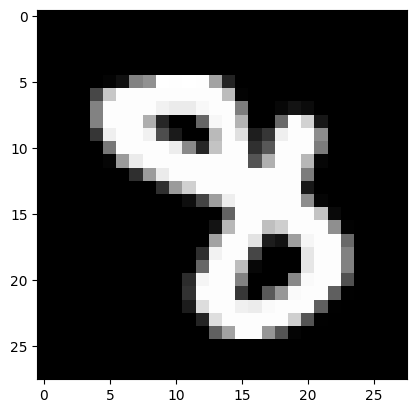

In [3]:
# Define the mini-batch size
batch_size = 100

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

dataset = datasets.MNIST(root='./', transform=transforms.ToTensor())
#idx = dataset.train_labels==5
#dataset.targets = dataset.train_labels[idx]
#dataset.data = dataset.train_data[idx]

# Dataset is split 8:2
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")

    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

In [4]:
def train_models(model_d, criterion_d, optimizer_d, model_g, criterion_g, optimizer_g, epochs, train_loader, k, batch_sz):
    it = iter(train_loader)
    for epoch in range(epochs):
          
        #Train Discriminator 
        for batch_nr in range(k):
            try:
                images,_ = next(it)
            except:
                it = iter(train_loader)
                images,_ = next(it)          
            _, out_real = model_d(torch.flatten(images,start_dim=1).to(device))
            _, out_fake = model_d(model_g(torch.randn(out_real.shape[0],100).to(device)))
            optimizer_d.zero_grad()
            loss_d_real = criterion_d(out_real,torch.ones_like(out_real)).to(device)
            loss_d_fake = criterion_d(out_fake,torch.zeros_like(out_fake)).to(device)
            loss_d = loss_d_real+loss_d_fake
            loss_d.backward()
            optimizer_d.step()

        #Train Generator
        _, out_fake = model_d(model_g(torch.randn(batch_sz,100).to(device)))
        optimizer_g.zero_grad()
        loss_g = criterion_g(out_fake,torch.ones_like(out_fake)).to(device)
        loss_g.backward()
        optimizer_g.step()
        
        
        
        if epoch%50==0:
            print("Epoch:",epoch)  
            print("loss_g:",loss_g.item(),"\tloss_d:",loss_d.item())
        if epoch%500==0:
            noise = torch.randn(batch_sz,100)
            disp = model_g(noise.to(device))
            plot_digit(torch.reshape(disp[0,:],(28,28)).detach().cpu())
            plot_digit(torch.reshape(disp[1,:],(28,28)).detach().cpu())
            plot_digit(torch.reshape(disp[2,:],(28,28)).detach().cpu())

Epoch: 0
loss_g: 0.7201024293899536 	loss_d: 1.4199005365371704


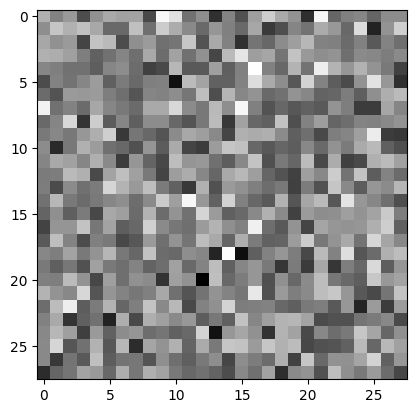

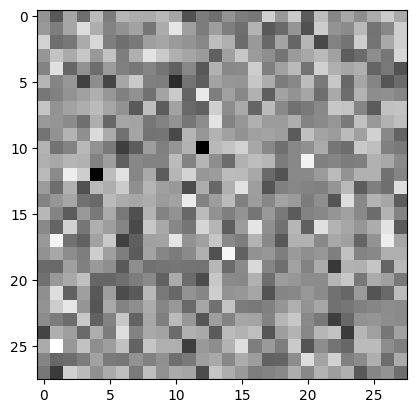

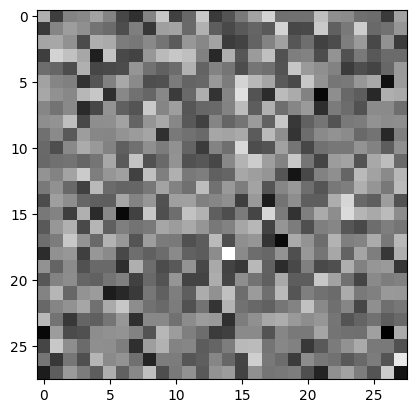

Epoch: 50
loss_g: 1.6030112504959106 	loss_d: 0.5387943983078003
Epoch: 100
loss_g: 1.3654844760894775 	loss_d: 1.0283010005950928
Epoch: 150
loss_g: 1.292450189590454 	loss_d: 1.1187632083892822
Epoch: 200
loss_g: 1.526776909828186 	loss_d: 0.6642918586730957
Epoch: 250
loss_g: 1.305452585220337 	loss_d: 0.9399497509002686
Epoch: 300
loss_g: 1.5705465078353882 	loss_d: 0.8429220914840698
Epoch: 350
loss_g: 1.7036184072494507 	loss_d: 0.6454876661300659
Epoch: 400
loss_g: 1.5690926313400269 	loss_d: 0.698980450630188
Epoch: 450
loss_g: 0.9715033769607544 	loss_d: 1.1820812225341797
Epoch: 500
loss_g: 1.0863755941390991 	loss_d: 1.0838088989257812


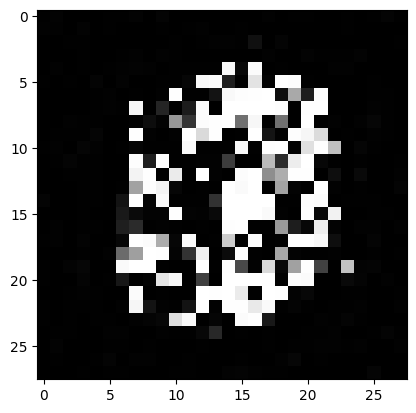

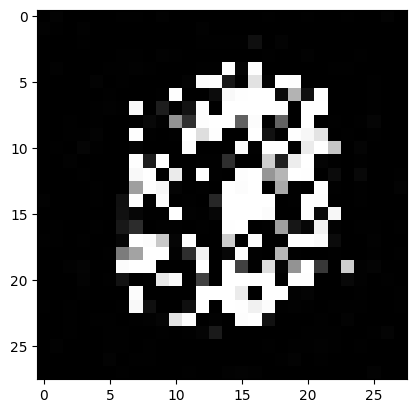

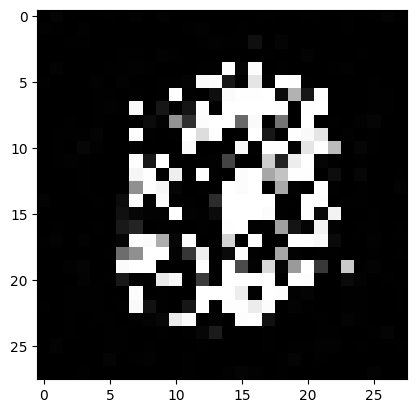

Epoch: 550
loss_g: 1.4949750900268555 	loss_d: 0.6863197088241577
Epoch: 600
loss_g: 1.8348867893218994 	loss_d: 0.7096311450004578
Epoch: 650
loss_g: 1.7371633052825928 	loss_d: 0.8904509544372559
Epoch: 700
loss_g: 1.396257996559143 	loss_d: 1.6951783895492554
Epoch: 750
loss_g: 1.862176775932312 	loss_d: 0.7926262617111206
Epoch: 800
loss_g: 2.1277692317962646 	loss_d: 0.38006871938705444
Epoch: 850
loss_g: 2.552088499069214 	loss_d: 0.18742269277572632
Epoch: 900
loss_g: 2.322046995162964 	loss_d: 0.24321702122688293
Epoch: 950
loss_g: 2.245312452316284 	loss_d: 0.2712497115135193
Epoch: 1000
loss_g: 2.2462751865386963 	loss_d: 0.3152831196784973


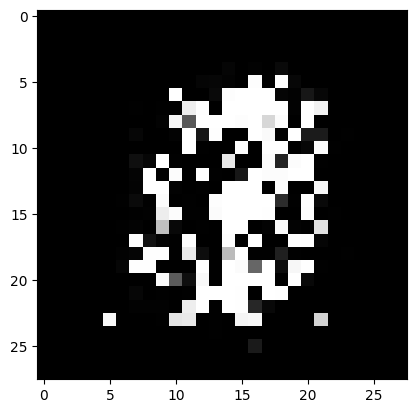

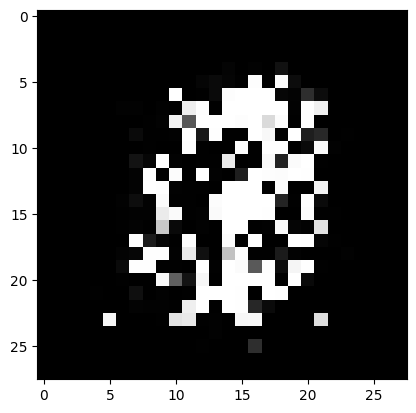

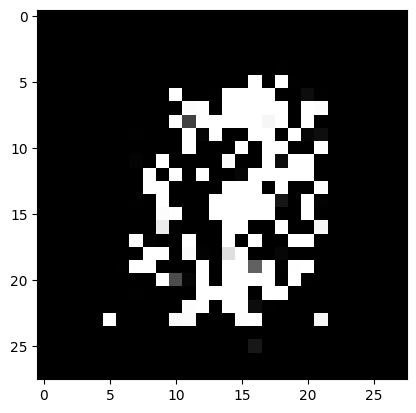

Epoch: 1050
loss_g: 1.8162466287612915 	loss_d: 0.6507097482681274
Epoch: 1100
loss_g: 1.0807944536209106 	loss_d: 1.275180459022522
Epoch: 1150
loss_g: 1.544470191001892 	loss_d: 1.26652991771698
Epoch: 1200
loss_g: 2.3959994316101074 	loss_d: 0.8987210392951965
Epoch: 1250
loss_g: 2.4804515838623047 	loss_d: 0.4419056177139282
Epoch: 1300
loss_g: 1.5440189838409424 	loss_d: 1.0911736488342285
Epoch: 1350
loss_g: 2.339365005493164 	loss_d: 0.2970034182071686
Epoch: 1400
loss_g: 2.862628221511841 	loss_d: 0.16563162207603455
Epoch: 1450
loss_g: 3.154621124267578 	loss_d: 0.12392232567071915
Epoch: 1500
loss_g: 3.4730772972106934 	loss_d: 0.10592104494571686


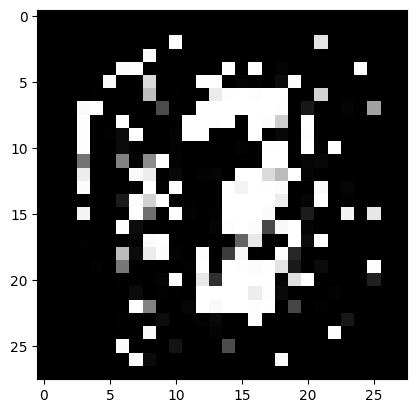

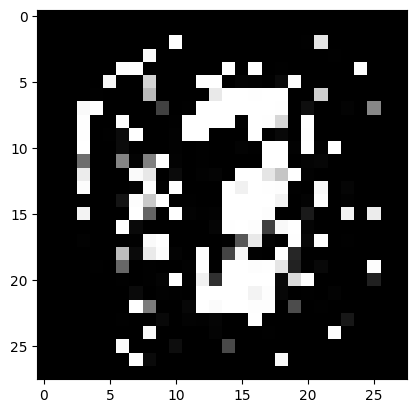

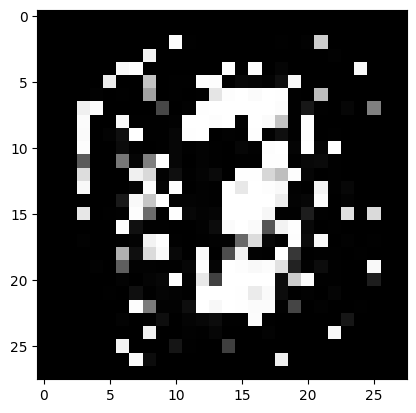

Epoch: 1550
loss_g: 2.448509693145752 	loss_d: 0.34172308444976807
Epoch: 1600
loss_g: 1.87763249874115 	loss_d: 0.6284993886947632
Epoch: 1650
loss_g: 2.6929314136505127 	loss_d: 0.24848578870296478
Epoch: 1700
loss_g: 2.664618968963623 	loss_d: 0.22167232632637024
Epoch: 1750
loss_g: 2.332407236099243 	loss_d: 0.3465955853462219
Epoch: 1800
loss_g: 2.1728413105010986 	loss_d: 0.36086511611938477
Epoch: 1850
loss_g: 2.608111619949341 	loss_d: 0.2784545123577118
Epoch: 1900
loss_g: 2.7130486965179443 	loss_d: 0.21605922281742096
Epoch: 1950
loss_g: 2.6992764472961426 	loss_d: 0.19108960032463074
Epoch: 2000
loss_g: 2.3860678672790527 	loss_d: 0.5372360348701477


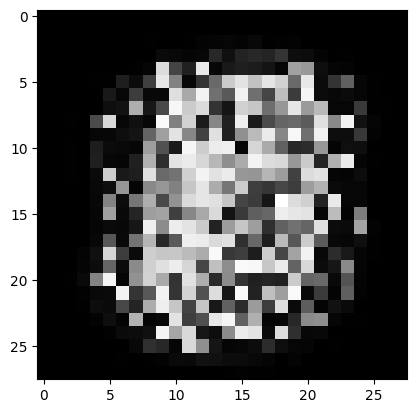

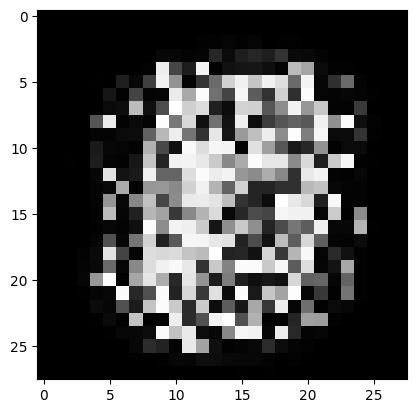

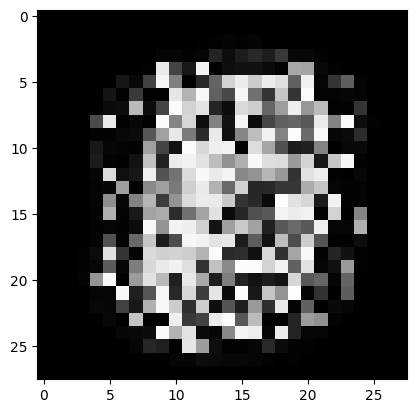

Epoch: 2050
loss_g: 1.7902578115463257 	loss_d: 0.7089170217514038
Epoch: 2100
loss_g: 1.6790521144866943 	loss_d: 0.646666407585144
Epoch: 2150
loss_g: 1.9933249950408936 	loss_d: 0.5408689975738525
Epoch: 2200
loss_g: 2.372671365737915 	loss_d: 0.6421358585357666
Epoch: 2250
loss_g: 2.086613416671753 	loss_d: 0.6706286072731018
Epoch: 2300
loss_g: 2.4487855434417725 	loss_d: 0.7162205576896667
Epoch: 2350
loss_g: 2.020895004272461 	loss_d: 0.7049415707588196
Epoch: 2400
loss_g: 2.0706627368927 	loss_d: 0.7169003486633301
Epoch: 2450
loss_g: 1.8531981706619263 	loss_d: 0.7284393310546875
Epoch: 2500
loss_g: 1.8528552055358887 	loss_d: 0.6401917338371277


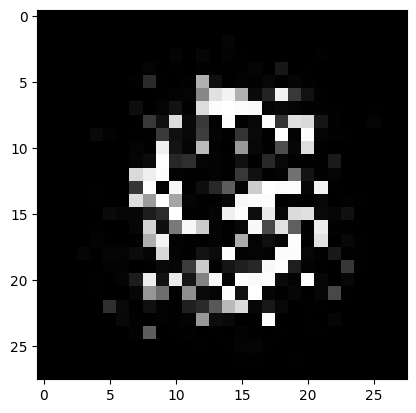

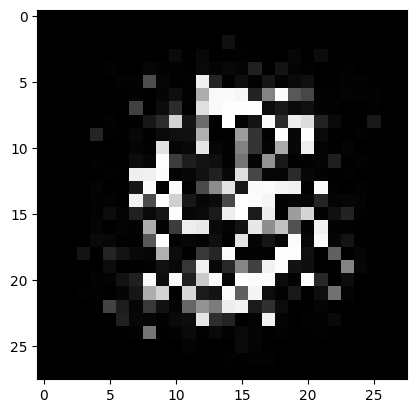

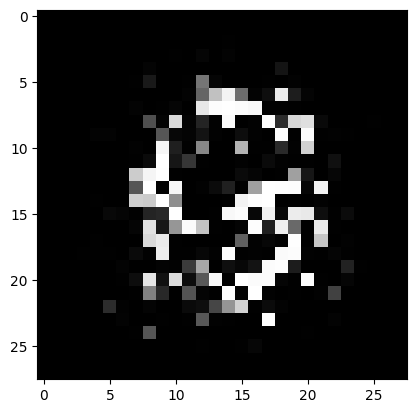

Epoch: 2550
loss_g: 1.4577279090881348 	loss_d: 0.5942367911338806
Epoch: 2600
loss_g: 1.435288667678833 	loss_d: 0.6901247501373291
Epoch: 2650
loss_g: 1.6110024452209473 	loss_d: 0.7654193639755249
Epoch: 2700
loss_g: 1.7683255672454834 	loss_d: 0.4726671576499939
Epoch: 2750
loss_g: 1.7503212690353394 	loss_d: 0.5108808279037476
Epoch: 2800
loss_g: 1.356059193611145 	loss_d: 0.6257028579711914
Epoch: 2850
loss_g: 1.3283299207687378 	loss_d: 0.5865280032157898
Epoch: 2900
loss_g: 1.3606672286987305 	loss_d: 0.575107991695404
Epoch: 2950
loss_g: 1.383168339729309 	loss_d: 0.6490508317947388
Epoch: 3000
loss_g: 1.084367275238037 	loss_d: 0.9228959083557129


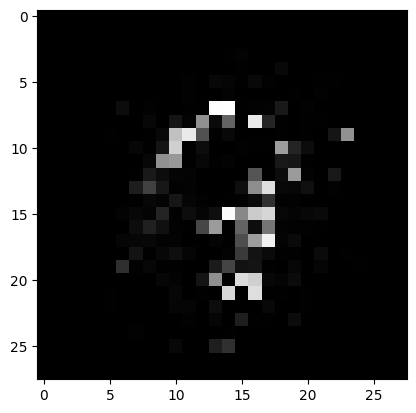

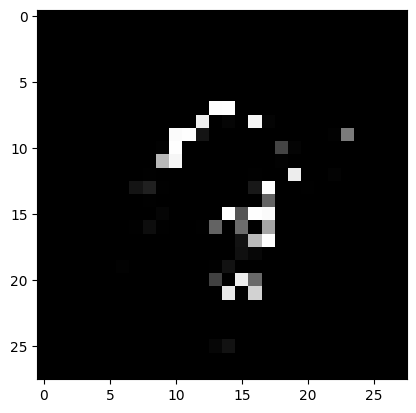

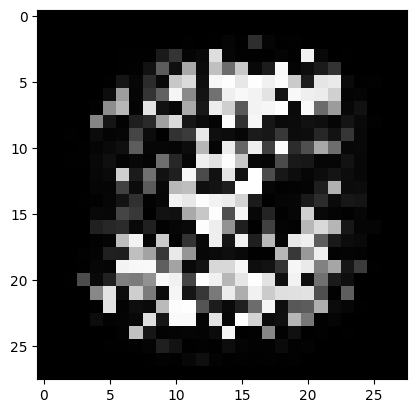

Epoch: 3050
loss_g: 1.1532118320465088 	loss_d: 0.7694963216781616
Epoch: 3100
loss_g: 1.426547646522522 	loss_d: 0.5893915295600891
Epoch: 3150
loss_g: 1.2438265085220337 	loss_d: 0.6844403147697449
Epoch: 3200
loss_g: 1.2821482419967651 	loss_d: 0.5122050046920776
Epoch: 3250
loss_g: 1.1133469343185425 	loss_d: 0.6438218951225281
Epoch: 3300
loss_g: 1.0673680305480957 	loss_d: 0.6234971880912781
Epoch: 3350
loss_g: 1.248436689376831 	loss_d: 0.5159177184104919
Epoch: 3400
loss_g: 1.1908928155899048 	loss_d: 0.503968358039856
Epoch: 3450
loss_g: 1.339304804801941 	loss_d: 0.4529568552970886
Epoch: 3500
loss_g: 1.3888812065124512 	loss_d: 0.47951874136924744


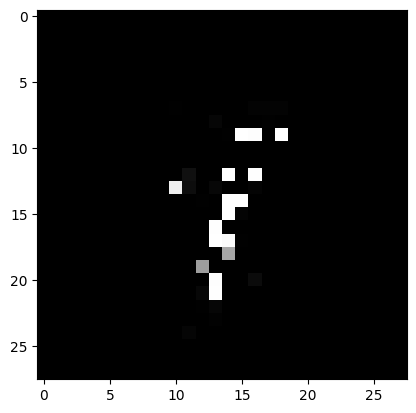

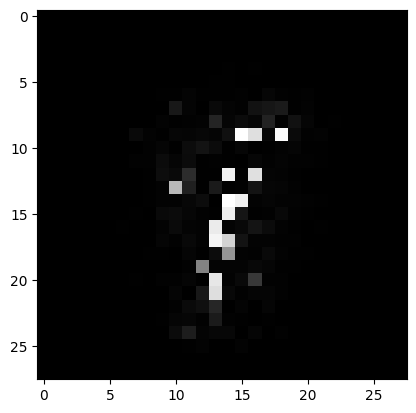

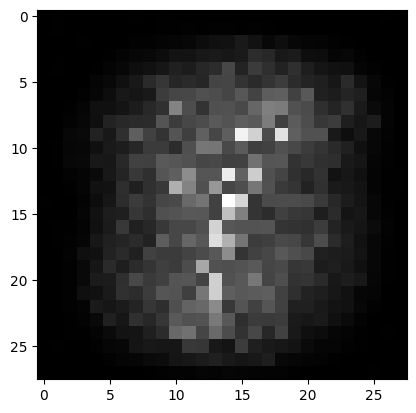

Epoch: 3550
loss_g: 1.2348371744155884 	loss_d: 0.5799927115440369
Epoch: 3600
loss_g: 1.4841527938842773 	loss_d: 0.614814281463623
Epoch: 3650
loss_g: 1.2535237073898315 	loss_d: 0.7168161869049072
Epoch: 3700
loss_g: 1.4739712476730347 	loss_d: 0.6242601871490479
Epoch: 3750
loss_g: 1.270872950553894 	loss_d: 0.8234938979148865
Epoch: 3800
loss_g: 1.3807379007339478 	loss_d: 0.7574945688247681
Epoch: 3850
loss_g: 1.4061938524246216 	loss_d: 0.7505226731300354
Epoch: 3900
loss_g: 1.3598980903625488 	loss_d: 0.8232921361923218
Epoch: 3950
loss_g: 1.5170129537582397 	loss_d: 0.6076791286468506
Epoch: 4000
loss_g: 1.4536129236221313 	loss_d: 0.7773630619049072


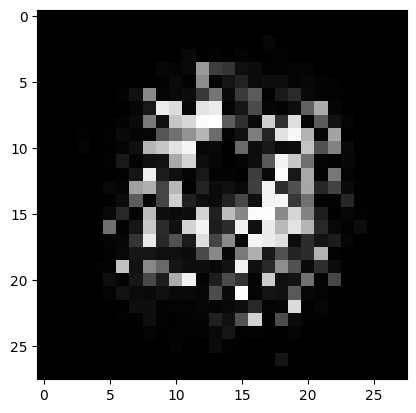

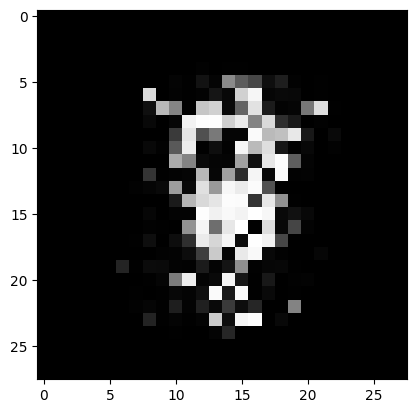

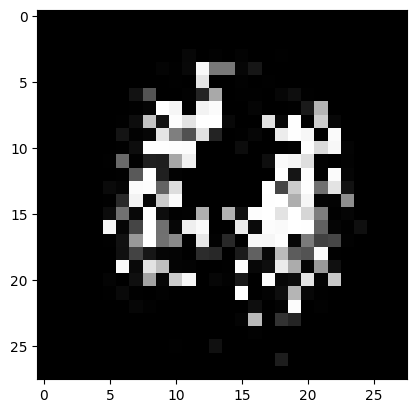

Epoch: 4050
loss_g: 2.0863046646118164 	loss_d: 0.400398313999176
Epoch: 4100
loss_g: 1.8530091047286987 	loss_d: 0.5851861834526062
Epoch: 4150
loss_g: 1.5915101766586304 	loss_d: 0.8486273288726807
Epoch: 4200
loss_g: 1.6248284578323364 	loss_d: 0.6289716362953186
Epoch: 4250
loss_g: 2.0457515716552734 	loss_d: 0.3663901388645172
Epoch: 4300
loss_g: 1.873005986213684 	loss_d: 0.5177661180496216
Epoch: 4350
loss_g: 1.664958119392395 	loss_d: 0.7863322496414185
Epoch: 4400
loss_g: 2.0578503608703613 	loss_d: 0.44123345613479614
Epoch: 4450
loss_g: 1.9887927770614624 	loss_d: 0.5153146386146545
Epoch: 4500
loss_g: 1.635791540145874 	loss_d: 0.5890139937400818


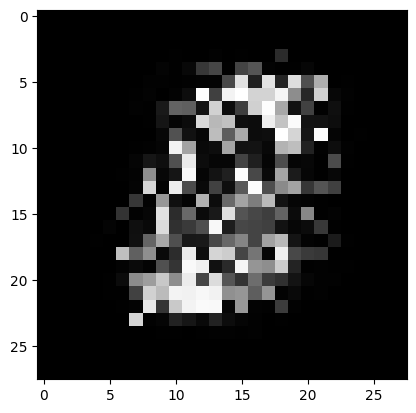

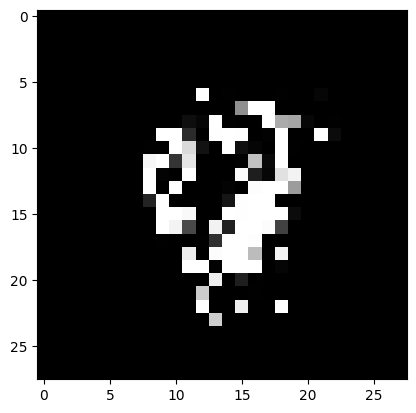

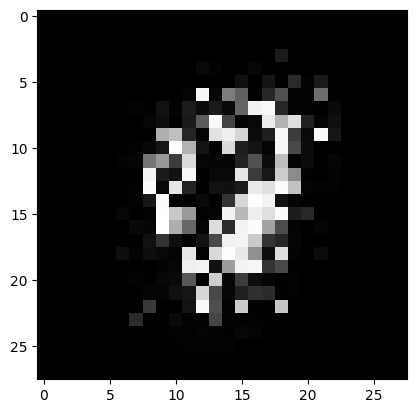

Epoch: 4550
loss_g: 1.8835519552230835 	loss_d: 0.5246418714523315
Epoch: 4600
loss_g: 1.9664442539215088 	loss_d: 0.4774628281593323
Epoch: 4650
loss_g: 1.93239164352417 	loss_d: 0.6487568616867065
Epoch: 4700
loss_g: 1.6632267236709595 	loss_d: 0.8837244510650635
Epoch: 4750
loss_g: 1.6782095432281494 	loss_d: 0.713216245174408
Epoch: 4800
loss_g: 1.9967232942581177 	loss_d: 0.5232932567596436
Epoch: 4850
loss_g: 1.672180414199829 	loss_d: 0.6338242292404175
Epoch: 4900
loss_g: 1.694295048713684 	loss_d: 0.7409425973892212
Epoch: 4950
loss_g: 1.376819133758545 	loss_d: 0.7775511741638184
Epoch: 5000
loss_g: 1.5132743120193481 	loss_d: 0.6656968593597412


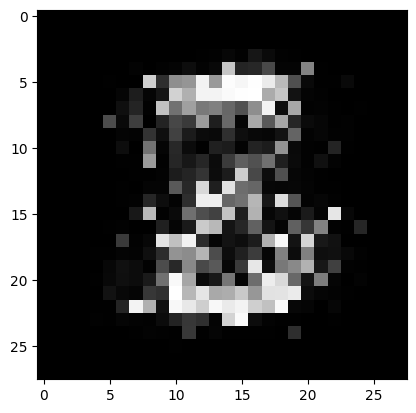

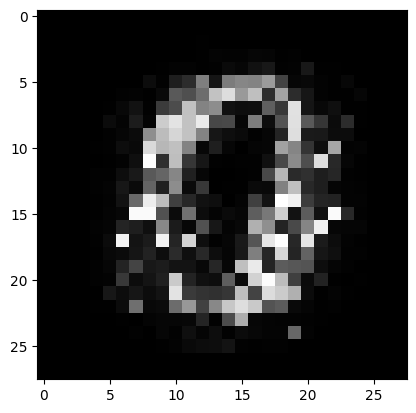

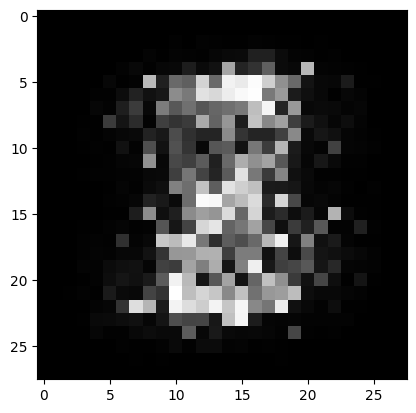

Epoch: 5050
loss_g: 1.8123583793640137 	loss_d: 0.5107303261756897
Epoch: 5100
loss_g: 1.6989905834197998 	loss_d: 0.6768854856491089
Epoch: 5150
loss_g: 1.7838058471679688 	loss_d: 0.6530802845954895
Epoch: 5200
loss_g: 1.5333811044692993 	loss_d: 0.7267552614212036
Epoch: 5250
loss_g: 1.670859932899475 	loss_d: 0.692189633846283
Epoch: 5300
loss_g: 1.6446408033370972 	loss_d: 0.584960401058197
Epoch: 5350
loss_g: 1.5183581113815308 	loss_d: 0.6029312610626221
Epoch: 5400
loss_g: 1.8069809675216675 	loss_d: 0.46898531913757324
Epoch: 5450
loss_g: 1.7955949306488037 	loss_d: 0.5090023279190063
Epoch: 5500
loss_g: 1.763755440711975 	loss_d: 0.614760160446167


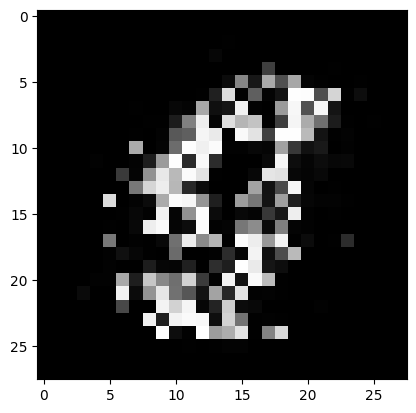

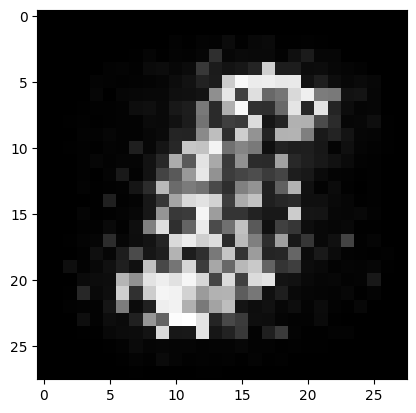

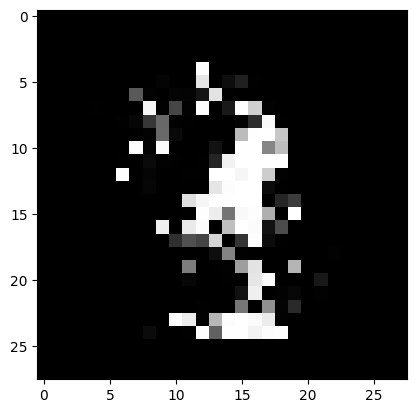

Epoch: 5550
loss_g: 1.7797350883483887 	loss_d: 0.8612383008003235
Epoch: 5600
loss_g: 1.755489468574524 	loss_d: 0.7037509679794312
Epoch: 5650
loss_g: 1.66391122341156 	loss_d: 0.7774781584739685
Epoch: 5700
loss_g: 1.9944204092025757 	loss_d: 0.5323370099067688
Epoch: 5750
loss_g: 2.120436429977417 	loss_d: 0.6058409214019775
Epoch: 5800
loss_g: 1.9994388818740845 	loss_d: 0.6073637008666992
Epoch: 5850
loss_g: 1.798067331314087 	loss_d: 0.5802531838417053
Epoch: 5900
loss_g: 2.187990427017212 	loss_d: 0.32605499029159546
Epoch: 5950
loss_g: 2.164351463317871 	loss_d: 0.3938540816307068
Epoch: 6000
loss_g: 1.61237633228302 	loss_d: 0.7571458220481873


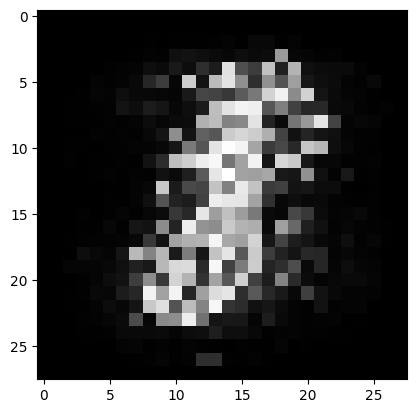

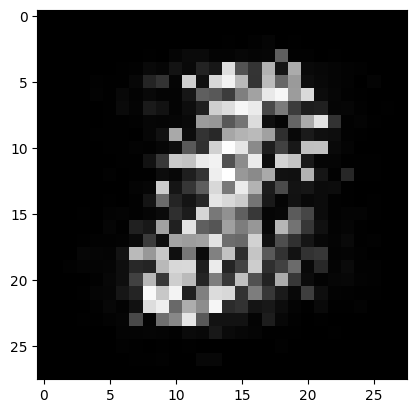

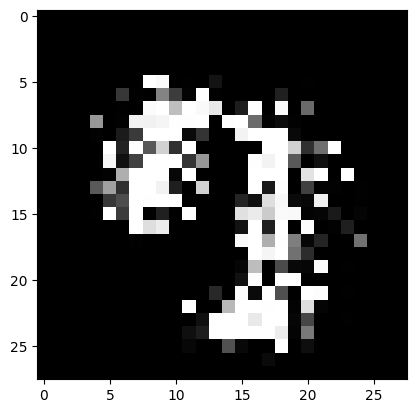

Epoch: 6050
loss_g: 1.5663998126983643 	loss_d: 0.6974563598632812
Epoch: 6100
loss_g: 2.1062984466552734 	loss_d: 0.5347604751586914
Epoch: 6150
loss_g: 2.083317995071411 	loss_d: 0.4746381640434265
Epoch: 6200
loss_g: 1.8508834838867188 	loss_d: 0.5739766359329224
Epoch: 6250
loss_g: 1.835617184638977 	loss_d: 0.5765233635902405
Epoch: 6300
loss_g: 2.034496307373047 	loss_d: 0.447878360748291
Epoch: 6350
loss_g: 1.8797869682312012 	loss_d: 0.7060786485671997
Epoch: 6400
loss_g: 1.9394865036010742 	loss_d: 0.5943684577941895
Epoch: 6450
loss_g: 1.7850494384765625 	loss_d: 0.8258239030838013
Epoch: 6500
loss_g: 1.8701567649841309 	loss_d: 0.7627688646316528


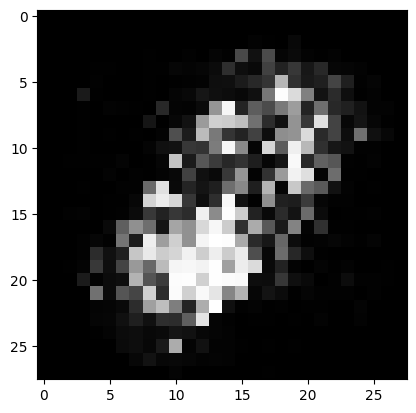

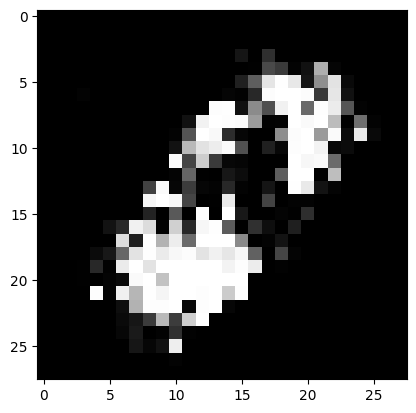

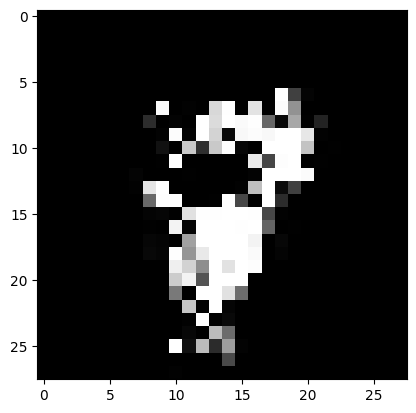

Epoch: 6550
loss_g: 2.262458086013794 	loss_d: 0.6188358068466187
Epoch: 6600
loss_g: 1.949131727218628 	loss_d: 0.8474915027618408
Epoch: 6650
loss_g: 2.0875096321105957 	loss_d: 0.44102510809898376
Epoch: 6700
loss_g: 2.054288387298584 	loss_d: 0.5507186651229858
Epoch: 6750
loss_g: 1.7605328559875488 	loss_d: 0.5162158608436584
Epoch: 6800
loss_g: 1.612493872642517 	loss_d: 0.6413098573684692
Epoch: 6850
loss_g: 1.4647772312164307 	loss_d: 0.6807178258895874
Epoch: 6900
loss_g: 1.9338970184326172 	loss_d: 0.5188335180282593
Epoch: 6950
loss_g: 1.6923550367355347 	loss_d: 0.4785808324813843
Epoch: 7000
loss_g: 1.7559527158737183 	loss_d: 0.7432743310928345


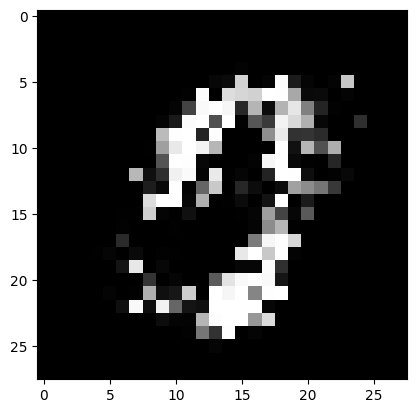

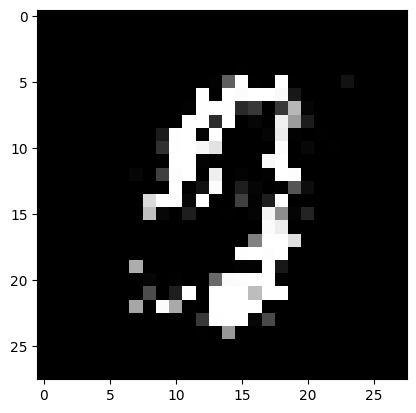

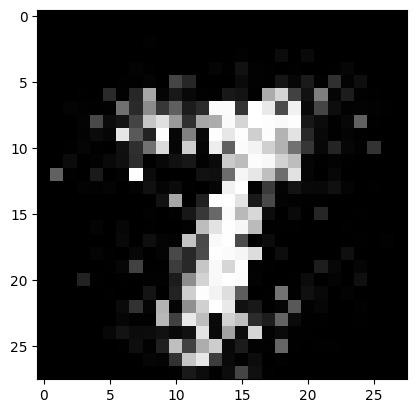

Epoch: 7050
loss_g: 1.6055681705474854 	loss_d: 0.6923145651817322
Epoch: 7100
loss_g: 1.761883020401001 	loss_d: 0.5980082750320435
Epoch: 7150
loss_g: 1.8416495323181152 	loss_d: 0.519852340221405
Epoch: 7200
loss_g: 1.7581719160079956 	loss_d: 0.5849063992500305
Epoch: 7250
loss_g: 1.5869985818862915 	loss_d: 0.7225427031517029
Epoch: 7300
loss_g: 1.5489530563354492 	loss_d: 0.7217231392860413
Epoch: 7350
loss_g: 1.7096322774887085 	loss_d: 0.6816134452819824
Epoch: 7400
loss_g: 1.370506763458252 	loss_d: 1.080005168914795
Epoch: 7450
loss_g: 1.5371769666671753 	loss_d: 0.9375371932983398
Epoch: 7500
loss_g: 1.396391749382019 	loss_d: 1.2772188186645508


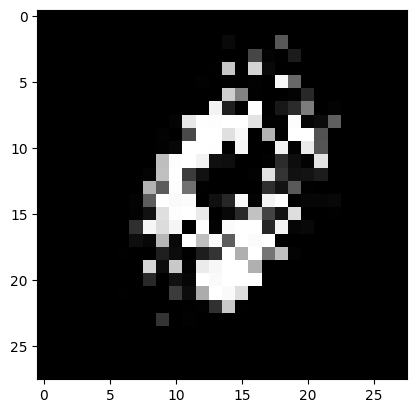

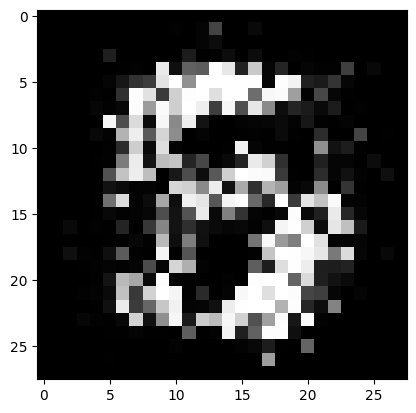

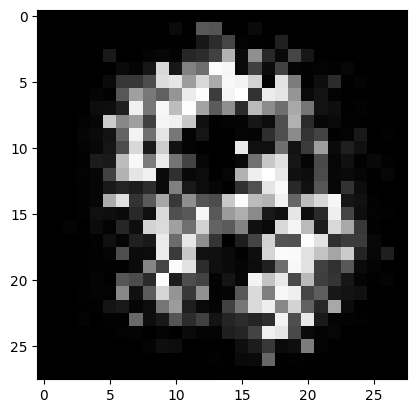

Epoch: 7550
loss_g: 1.5426862239837646 	loss_d: 1.1185672283172607
Epoch: 7600
loss_g: 1.5918035507202148 	loss_d: 1.0094269514083862
Epoch: 7650
loss_g: 1.6506832838058472 	loss_d: 0.6297136545181274
Epoch: 7700
loss_g: 1.5308010578155518 	loss_d: 0.719748318195343
Epoch: 7750
loss_g: 1.544978141784668 	loss_d: 0.7873364686965942
Epoch: 7800
loss_g: 1.759445309638977 	loss_d: 0.8893718123435974
Epoch: 7850
loss_g: 1.6161272525787354 	loss_d: 0.8543200492858887
Epoch: 7900
loss_g: 2.003702402114868 	loss_d: 0.6904829740524292
Epoch: 7950
loss_g: 1.708385944366455 	loss_d: 0.7607254981994629
Epoch: 8000
loss_g: 1.5608282089233398 	loss_d: 0.8864866495132446


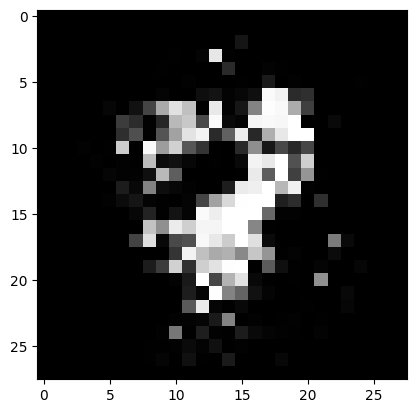

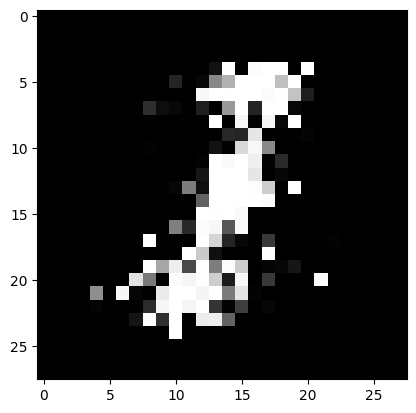

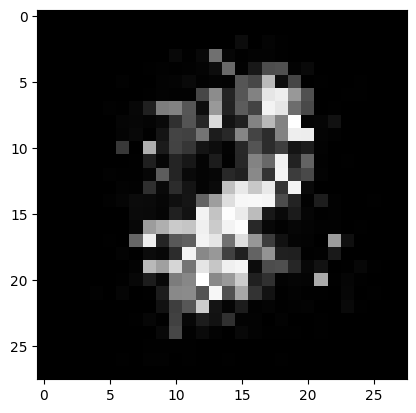

Epoch: 8050
loss_g: 1.562319040298462 	loss_d: 0.8266602754592896
Epoch: 8100
loss_g: 1.4826891422271729 	loss_d: 0.7409061193466187
Epoch: 8150
loss_g: 1.4560846090316772 	loss_d: 0.8864835500717163
Epoch: 8200
loss_g: 1.4086617231369019 	loss_d: 0.757770299911499
Epoch: 8250
loss_g: 1.4872688055038452 	loss_d: 0.7087124586105347
Epoch: 8300
loss_g: 1.5039538145065308 	loss_d: 0.680263876914978
Epoch: 8350
loss_g: 1.5436522960662842 	loss_d: 0.6892588138580322
Epoch: 8400
loss_g: 1.7606383562088013 	loss_d: 0.6366463899612427
Epoch: 8450
loss_g: 1.6429353952407837 	loss_d: 0.7105292677879333
Epoch: 8500
loss_g: 1.5961045026779175 	loss_d: 0.6829509139060974


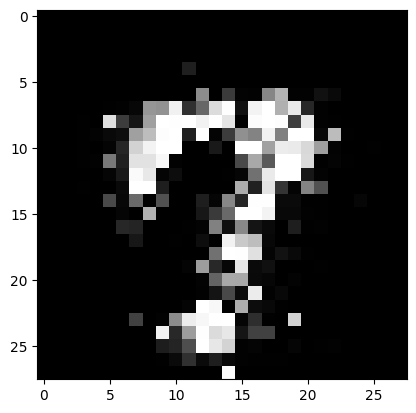

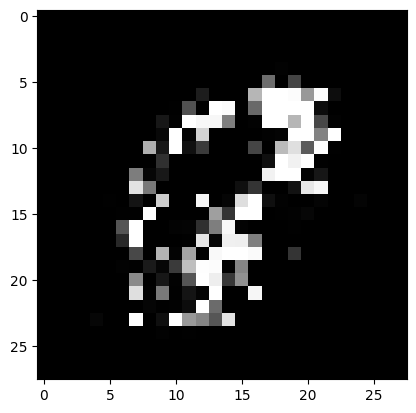

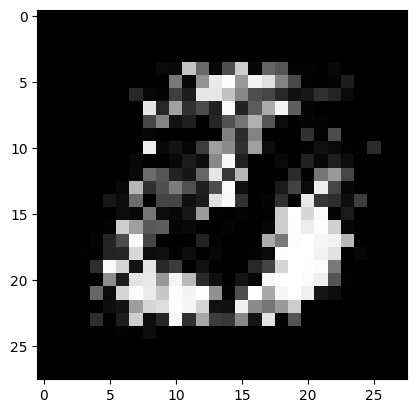

Epoch: 8550
loss_g: 1.5100431442260742 	loss_d: 0.8126848340034485
Epoch: 8600
loss_g: 1.4903008937835693 	loss_d: 0.8298723697662354
Epoch: 8650
loss_g: 1.2806740999221802 	loss_d: 1.053314447402954
Epoch: 8700
loss_g: 1.655755877494812 	loss_d: 0.7153716087341309
Epoch: 8750
loss_g: 1.4260531663894653 	loss_d: 1.1683087348937988
Epoch: 8800
loss_g: 1.4831500053405762 	loss_d: 1.1593531370162964
Epoch: 8850
loss_g: 1.3863277435302734 	loss_d: 1.2199586629867554
Epoch: 8900
loss_g: 1.5279330015182495 	loss_d: 1.0132228136062622
Epoch: 8950
loss_g: 1.6425105333328247 	loss_d: 0.7211710214614868
Epoch: 9000
loss_g: 1.5183042287826538 	loss_d: 1.015181541442871


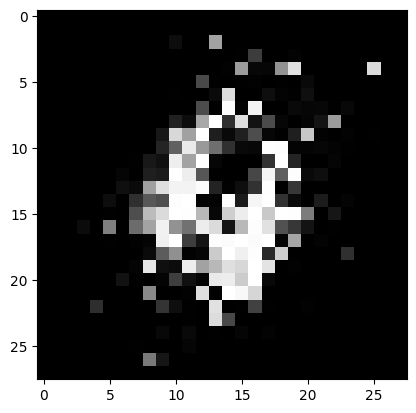

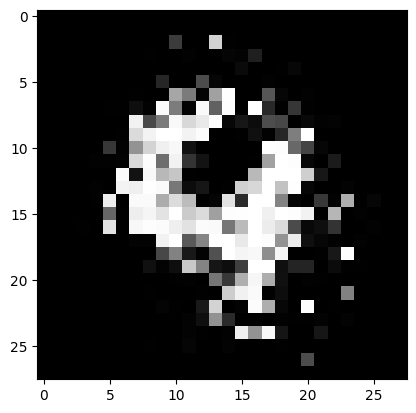

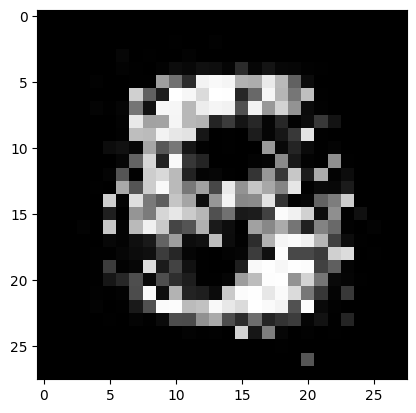

Epoch: 9050
loss_g: 1.3282157182693481 	loss_d: 1.042405605316162
Epoch: 9100
loss_g: 1.339834213256836 	loss_d: 0.8565412759780884
Epoch: 9150
loss_g: 1.7364572286605835 	loss_d: 0.6582580804824829
Epoch: 9200
loss_g: 1.4477053880691528 	loss_d: 0.854554295539856
Epoch: 9250
loss_g: 1.2886526584625244 	loss_d: 1.0041719675064087
Epoch: 9300
loss_g: 1.3930377960205078 	loss_d: 1.1051013469696045
Epoch: 9350
loss_g: 1.2515596151351929 	loss_d: 0.9725099802017212
Epoch: 9400
loss_g: 1.2186540365219116 	loss_d: 0.9745099544525146
Epoch: 9450
loss_g: 1.3764725923538208 	loss_d: 1.1346186399459839
Epoch: 9500
loss_g: 1.4165219068527222 	loss_d: 0.8897552490234375


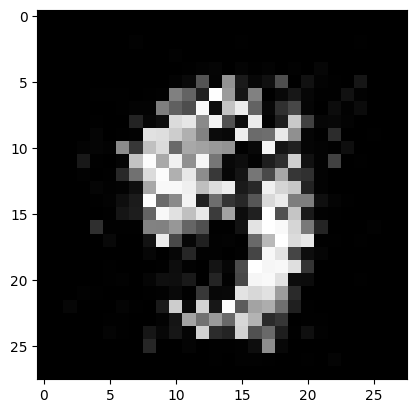

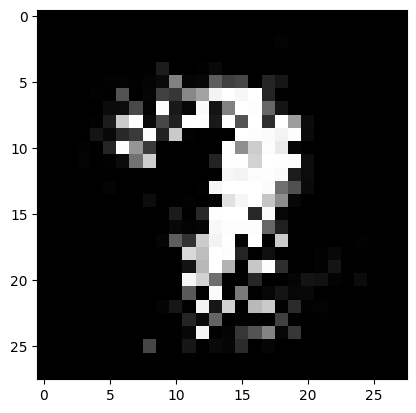

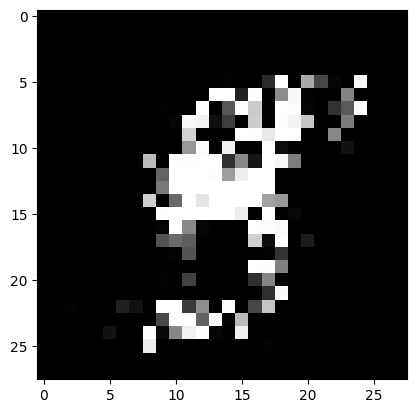

Epoch: 9550
loss_g: 1.524088978767395 	loss_d: 0.753817081451416
Epoch: 9600
loss_g: 1.4503262042999268 	loss_d: 1.0312758684158325
Epoch: 9650
loss_g: 1.2915387153625488 	loss_d: 0.9586701989173889
Epoch: 9700
loss_g: 1.3340413570404053 	loss_d: 0.8906943798065186
Epoch: 9750
loss_g: 1.6507805585861206 	loss_d: 0.6667729616165161
Epoch: 9800
loss_g: 1.570781946182251 	loss_d: 0.7205121517181396
Epoch: 9850
loss_g: 1.402065396308899 	loss_d: 0.7944726347923279
Epoch: 9900
loss_g: 1.4539721012115479 	loss_d: 0.8907621502876282
Epoch: 9950
loss_g: 1.3831353187561035 	loss_d: 0.8049728870391846
Epoch: 10000
loss_g: 1.4659451246261597 	loss_d: 0.7192384600639343


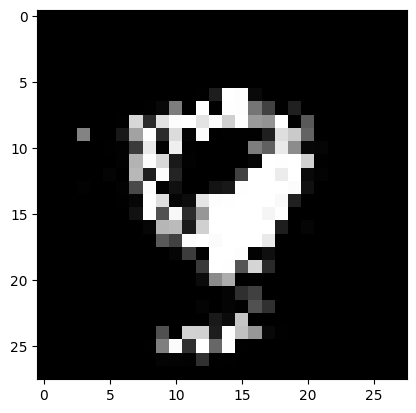

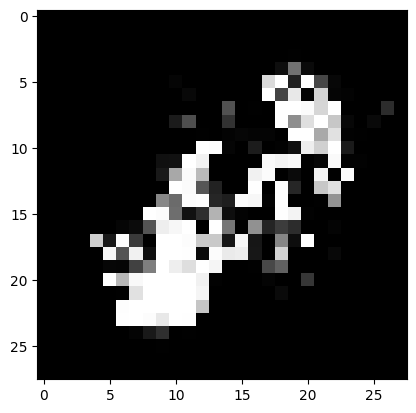

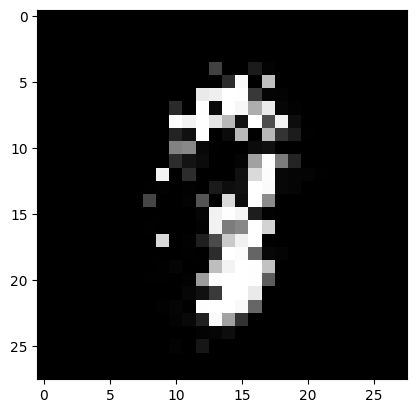

Epoch: 10050
loss_g: 1.3313225507736206 	loss_d: 0.7933535575866699
Epoch: 10100
loss_g: 1.2634092569351196 	loss_d: 0.8445602059364319
Epoch: 10150
loss_g: 1.3350476026535034 	loss_d: 0.8867747783660889
Epoch: 10200
loss_g: 1.4220755100250244 	loss_d: 0.909264326095581
Epoch: 10250
loss_g: 1.4912545680999756 	loss_d: 0.7961030006408691
Epoch: 10300
loss_g: 1.3862669467926025 	loss_d: 0.7081619501113892
Epoch: 10350
loss_g: 1.286948800086975 	loss_d: 0.8178014755249023
Epoch: 10400
loss_g: 1.4308401346206665 	loss_d: 0.8983863592147827
Epoch: 10450
loss_g: 1.2689930200576782 	loss_d: 0.8531394004821777
Epoch: 10500
loss_g: 1.3677210807800293 	loss_d: 0.8427116274833679


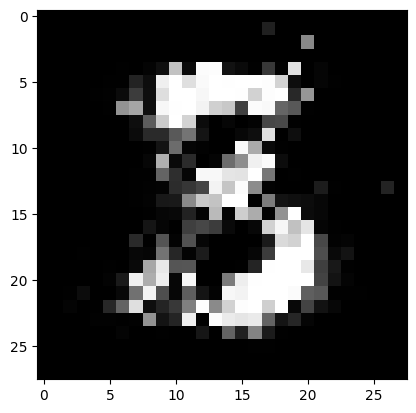

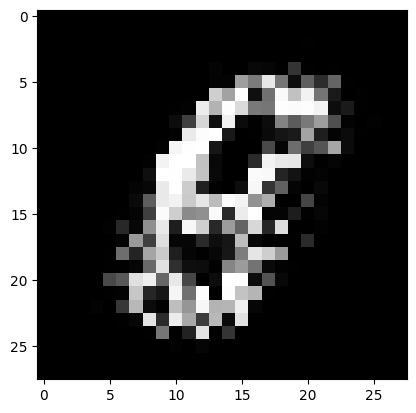

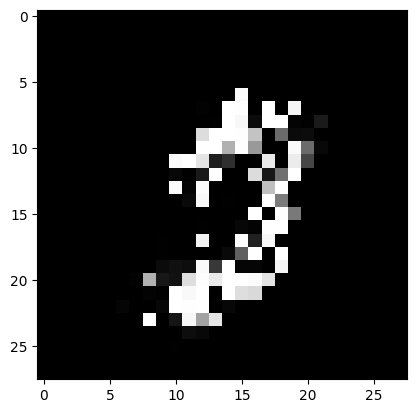

Epoch: 10550
loss_g: 1.2493557929992676 	loss_d: 0.8697535991668701
Epoch: 10600
loss_g: 1.5401732921600342 	loss_d: 0.9043940901756287
Epoch: 10650
loss_g: 1.2587265968322754 	loss_d: 1.0575382709503174
Epoch: 10700
loss_g: 1.3414849042892456 	loss_d: 0.8723611831665039
Epoch: 10750
loss_g: 1.374912977218628 	loss_d: 1.1216139793395996
Epoch: 10800
loss_g: 1.324520230293274 	loss_d: 0.9050320386886597
Epoch: 10850
loss_g: 1.321390986442566 	loss_d: 0.8167790174484253
Epoch: 10900
loss_g: 1.386932373046875 	loss_d: 0.7774624228477478
Epoch: 10950
loss_g: 1.4469192028045654 	loss_d: 0.9702298641204834
Epoch: 11000
loss_g: 1.7475411891937256 	loss_d: 0.811638593673706


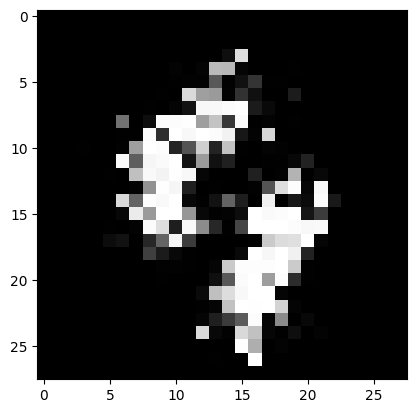

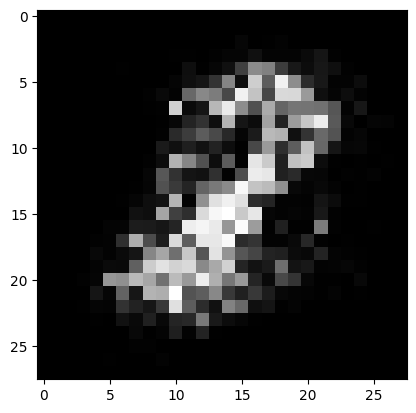

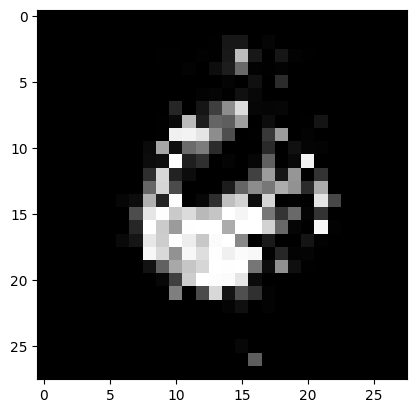

Epoch: 11050
loss_g: 1.1695427894592285 	loss_d: 1.3285212516784668
Epoch: 11100
loss_g: 1.2815994024276733 	loss_d: 1.077775239944458
Epoch: 11150
loss_g: 1.4685865640640259 	loss_d: 1.1767194271087646
Epoch: 11200
loss_g: 1.235065221786499 	loss_d: 1.0515961647033691
Epoch: 11250
loss_g: 1.3096981048583984 	loss_d: 1.1306802034378052
Epoch: 11300
loss_g: 1.3265866041183472 	loss_d: 0.9937000274658203
Epoch: 11350
loss_g: 1.4112462997436523 	loss_d: 0.7497568130493164
Epoch: 11400
loss_g: 1.422695279121399 	loss_d: 0.8253045082092285
Epoch: 11450
loss_g: 1.2175543308258057 	loss_d: 1.086663007736206
Epoch: 11500
loss_g: 1.5122207403182983 	loss_d: 0.8165648579597473


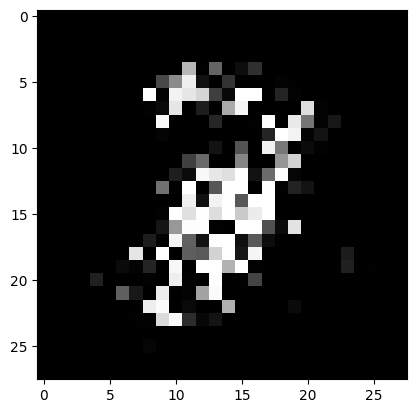

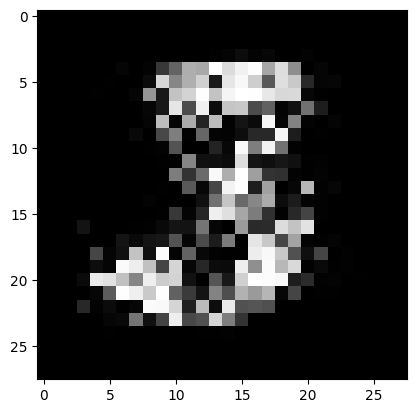

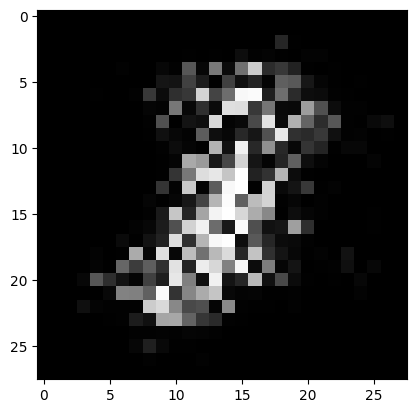

Epoch: 11550
loss_g: 1.4927904605865479 	loss_d: 0.8206727504730225
Epoch: 11600
loss_g: 1.629602313041687 	loss_d: 0.912255048751831
Epoch: 11650
loss_g: 1.3807494640350342 	loss_d: 0.9374712705612183
Epoch: 11700
loss_g: 1.202017068862915 	loss_d: 0.9874508380889893
Epoch: 11750
loss_g: 1.4624156951904297 	loss_d: 0.923468828201294
Epoch: 11800
loss_g: 1.4909157752990723 	loss_d: 0.8327517509460449
Epoch: 11850
loss_g: 1.4616563320159912 	loss_d: 0.8215103149414062
Epoch: 11900
loss_g: 1.2881999015808105 	loss_d: 0.9108099937438965
Epoch: 11950
loss_g: 1.2120286226272583 	loss_d: 0.845558762550354
Epoch: 12000
loss_g: 1.3637921810150146 	loss_d: 0.8247522115707397


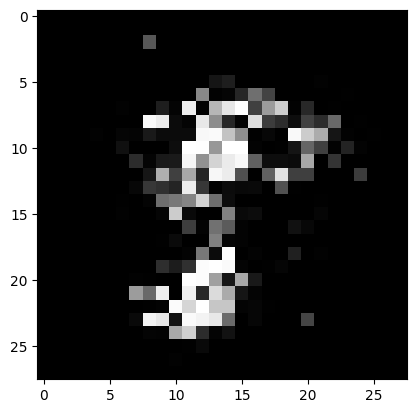

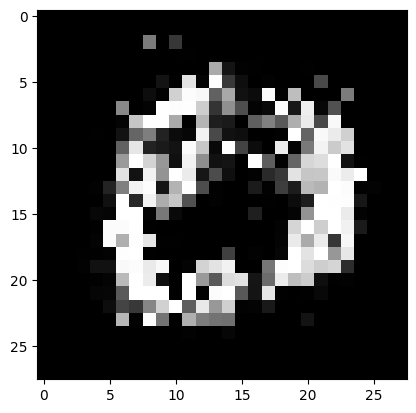

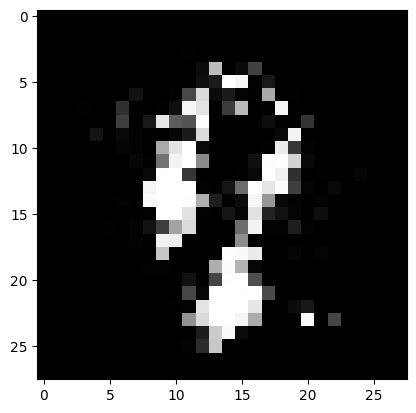

Epoch: 12050
loss_g: 1.3522368669509888 	loss_d: 0.9613927602767944
Epoch: 12100
loss_g: 1.1949467658996582 	loss_d: 0.9933152198791504
Epoch: 12150
loss_g: 1.1894437074661255 	loss_d: 1.1206824779510498
Epoch: 12200
loss_g: 1.4066412448883057 	loss_d: 1.053299069404602
Epoch: 12250
loss_g: 1.1818222999572754 	loss_d: 0.9245147705078125
Epoch: 12300
loss_g: 1.1882809400558472 	loss_d: 1.2075222730636597
Epoch: 12350
loss_g: 1.2004718780517578 	loss_d: 1.111288070678711
Epoch: 12400
loss_g: 1.1141819953918457 	loss_d: 0.9643093347549438
Epoch: 12450
loss_g: 1.2563103437423706 	loss_d: 0.96753990650177
Epoch: 12500
loss_g: 1.2108699083328247 	loss_d: 1.1915357112884521


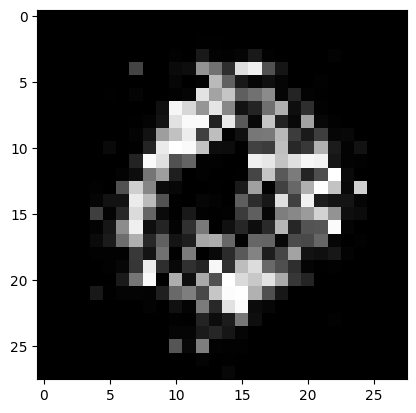

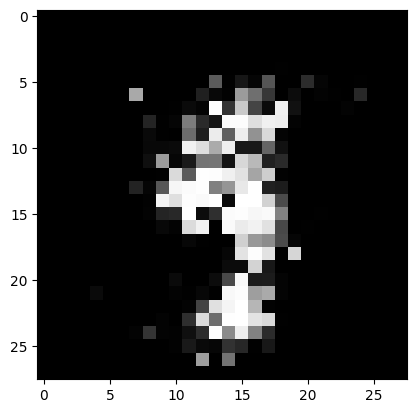

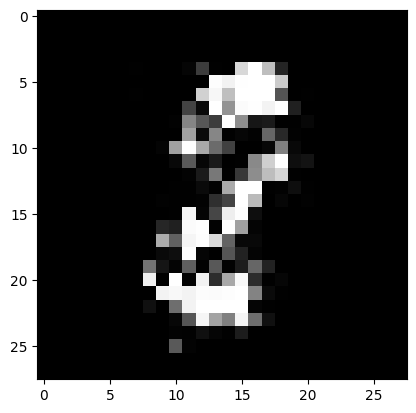

Epoch: 12550
loss_g: 1.308938980102539 	loss_d: 0.9393483400344849
Epoch: 12600
loss_g: 1.42441987991333 	loss_d: 0.8879895210266113
Epoch: 12650
loss_g: 1.4510815143585205 	loss_d: 0.7726583480834961
Epoch: 12700
loss_g: 1.4118058681488037 	loss_d: 1.0304895639419556
Epoch: 12750
loss_g: 1.5069580078125 	loss_d: 0.9325493574142456
Epoch: 12800
loss_g: 1.3108052015304565 	loss_d: 0.8890186548233032
Epoch: 12850
loss_g: 1.5154223442077637 	loss_d: 0.9499805569648743
Epoch: 12900
loss_g: 1.291817545890808 	loss_d: 1.1927133798599243
Epoch: 12950
loss_g: 1.3019871711730957 	loss_d: 0.9363285303115845
Epoch: 13000
loss_g: 1.4744558334350586 	loss_d: 1.191440224647522


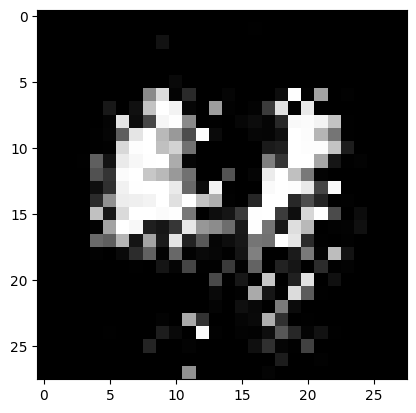

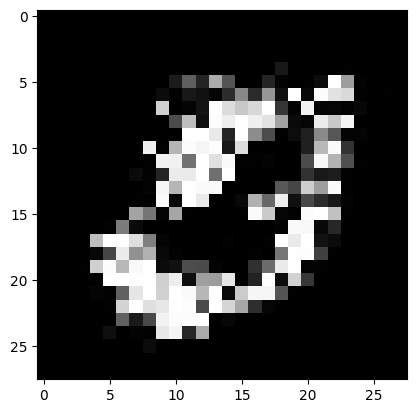

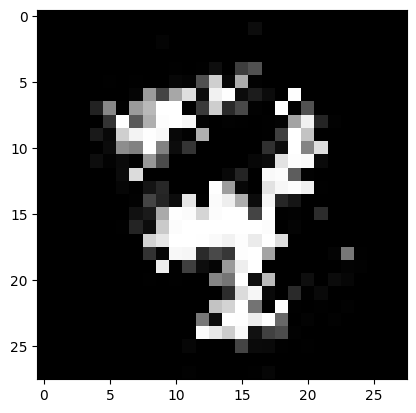

Epoch: 13050
loss_g: 1.5618462562561035 	loss_d: 0.9153293371200562
Epoch: 13100
loss_g: 1.539054274559021 	loss_d: 0.835540771484375
Epoch: 13150
loss_g: 1.3362023830413818 	loss_d: 0.9957674741744995
Epoch: 13200
loss_g: 1.3746541738510132 	loss_d: 1.1777592897415161
Epoch: 13250
loss_g: 1.345846176147461 	loss_d: 0.9786100387573242
Epoch: 13300
loss_g: 1.566011905670166 	loss_d: 0.8988867998123169
Epoch: 13350
loss_g: 1.4332631826400757 	loss_d: 0.8365952968597412
Epoch: 13400
loss_g: 1.3305714130401611 	loss_d: 1.010572910308838
Epoch: 13450
loss_g: 1.2920794486999512 	loss_d: 0.8269936442375183
Epoch: 13500
loss_g: 1.4377520084381104 	loss_d: 0.9788053631782532


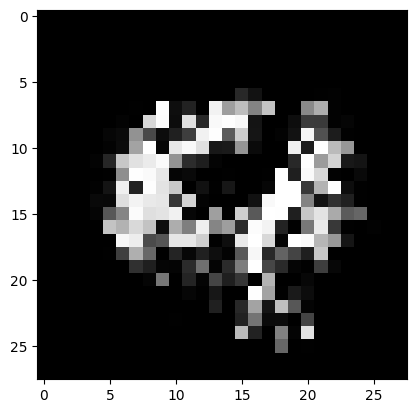

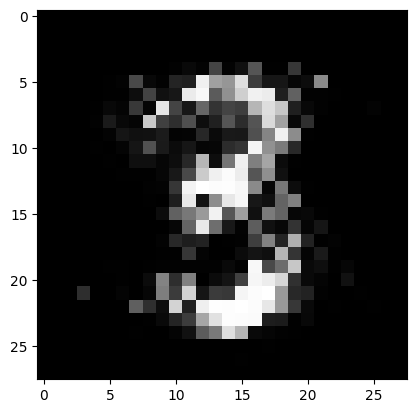

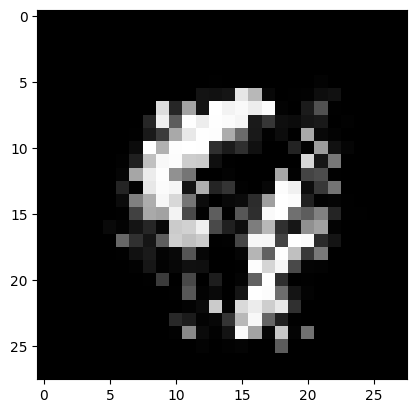

Epoch: 13550
loss_g: 1.4957940578460693 	loss_d: 1.002856731414795
Epoch: 13600
loss_g: 1.2376869916915894 	loss_d: 0.9149559736251831
Epoch: 13650
loss_g: 1.3318426609039307 	loss_d: 1.0104105472564697
Epoch: 13700
loss_g: 1.3335946798324585 	loss_d: 0.9831153154373169
Epoch: 13750
loss_g: 1.4552149772644043 	loss_d: 0.8491261601448059
Epoch: 13800
loss_g: 1.541028380393982 	loss_d: 0.8942652940750122
Epoch: 13850
loss_g: 1.5795000791549683 	loss_d: 0.9087374806404114
Epoch: 13900
loss_g: 1.4717360734939575 	loss_d: 1.0109238624572754
Epoch: 13950
loss_g: 1.3903264999389648 	loss_d: 0.8905835747718811
Epoch: 14000
loss_g: 1.322340965270996 	loss_d: 0.868119478225708


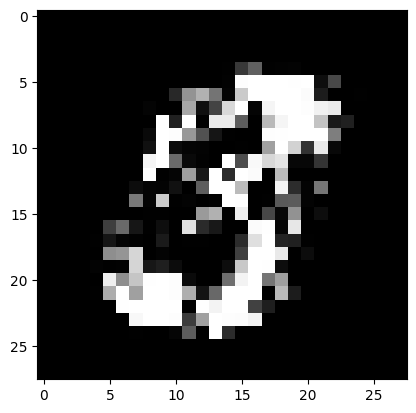

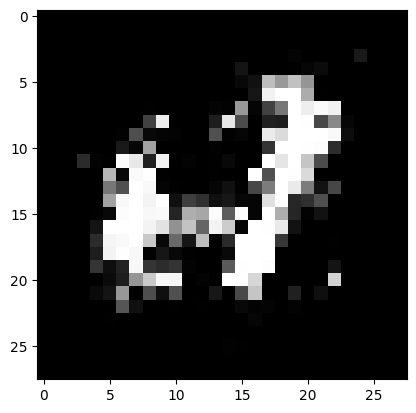

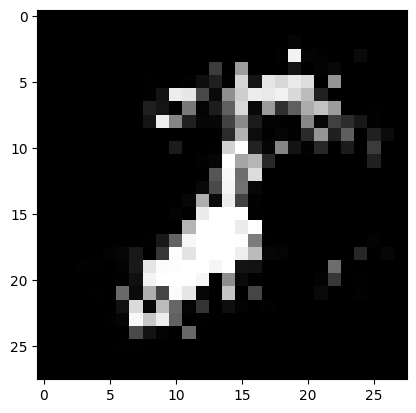

Epoch: 14050
loss_g: 1.349980115890503 	loss_d: 0.8807710409164429
Epoch: 14100
loss_g: 1.7140344381332397 	loss_d: 0.7094631195068359
Epoch: 14150
loss_g: 1.5206331014633179 	loss_d: 0.6974631547927856
Epoch: 14200
loss_g: 1.4565424919128418 	loss_d: 0.911395788192749
Epoch: 14250
loss_g: 1.468550682067871 	loss_d: 0.9213674664497375
Epoch: 14300
loss_g: 1.4448351860046387 	loss_d: 0.8099233508110046
Epoch: 14350
loss_g: 1.5824735164642334 	loss_d: 0.8225785493850708
Epoch: 14400
loss_g: 1.5419341325759888 	loss_d: 0.7055433988571167
Epoch: 14450
loss_g: 1.3744431734085083 	loss_d: 0.8836135268211365
Epoch: 14500
loss_g: 1.4704787731170654 	loss_d: 0.8648016452789307


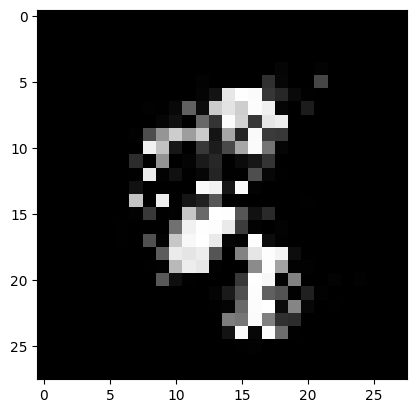

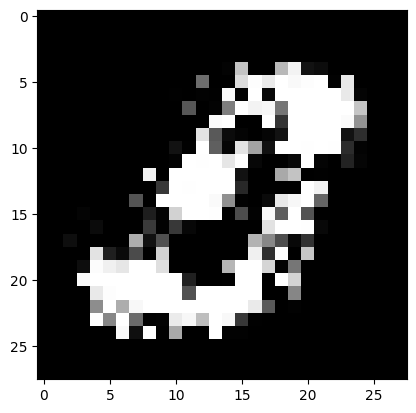

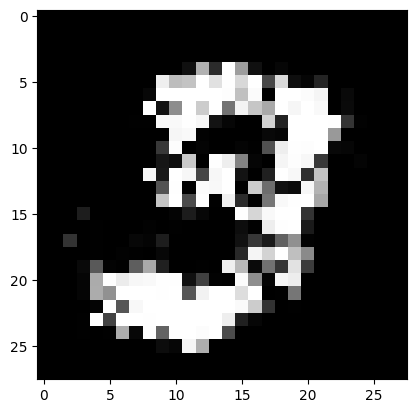

Epoch: 14550
loss_g: 1.6634587049484253 	loss_d: 0.7974267601966858
Epoch: 14600
loss_g: 1.4171453714370728 	loss_d: 0.9554112553596497
Epoch: 14650
loss_g: 1.348716139793396 	loss_d: 0.8863123655319214
Epoch: 14700
loss_g: 1.4156603813171387 	loss_d: 0.940654993057251
Epoch: 14750
loss_g: 1.4231945276260376 	loss_d: 0.9763910174369812
Epoch: 14800
loss_g: 1.3015035390853882 	loss_d: 1.0376694202423096
Epoch: 14850
loss_g: 1.183664321899414 	loss_d: 0.9237926006317139
Epoch: 14900
loss_g: 1.2710494995117188 	loss_d: 0.8273690938949585
Epoch: 14950
loss_g: 1.4909603595733643 	loss_d: 1.0549869537353516
Epoch: 15000
loss_g: 1.596990942955017 	loss_d: 0.9614324569702148


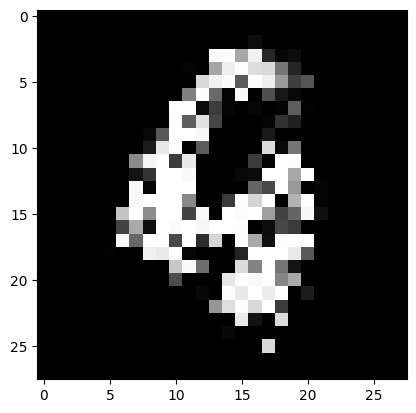

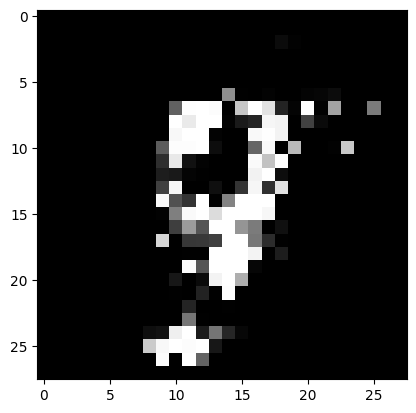

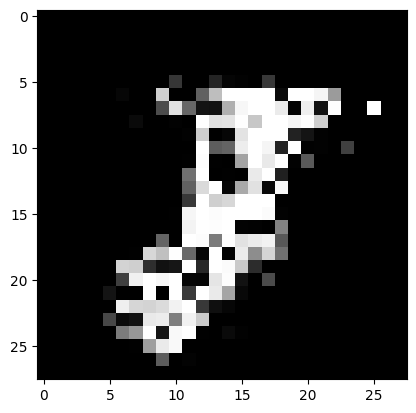

Epoch: 15050
loss_g: 1.6534417867660522 	loss_d: 0.8235582113265991
Epoch: 15100
loss_g: 1.3759493827819824 	loss_d: 1.035118579864502
Epoch: 15150
loss_g: 1.3885250091552734 	loss_d: 1.0580220222473145
Epoch: 15200
loss_g: 1.4309402704238892 	loss_d: 1.0090765953063965
Epoch: 15250
loss_g: 1.276580810546875 	loss_d: 0.8397594690322876
Epoch: 15300
loss_g: 1.3337570428848267 	loss_d: 0.8794242739677429
Epoch: 15350
loss_g: 1.286225438117981 	loss_d: 1.0670297145843506
Epoch: 15400
loss_g: 1.4644805192947388 	loss_d: 0.9946092367172241
Epoch: 15450
loss_g: 1.5023576021194458 	loss_d: 1.0927003622055054
Epoch: 15500
loss_g: 1.411924123764038 	loss_d: 0.889910876750946


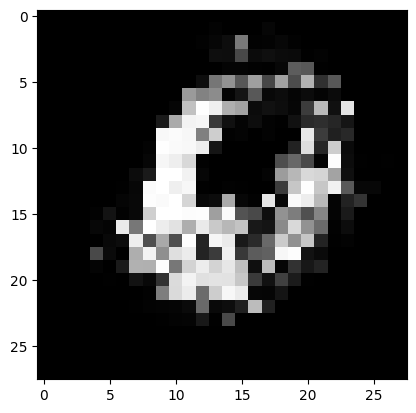

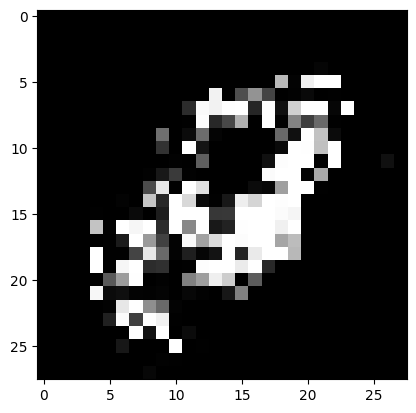

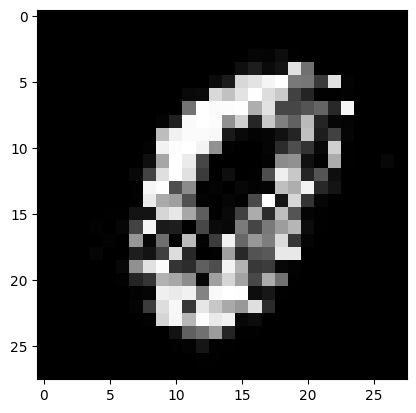

Epoch: 15550
loss_g: 1.2840297222137451 	loss_d: 1.1418969631195068
Epoch: 15600
loss_g: 1.5824315547943115 	loss_d: 0.917272686958313
Epoch: 15650
loss_g: 1.3373538255691528 	loss_d: 1.0440646409988403
Epoch: 15700
loss_g: 1.6260486841201782 	loss_d: 0.9624171853065491
Epoch: 15750
loss_g: 1.2972770929336548 	loss_d: 0.9517339468002319
Epoch: 15800
loss_g: 1.3900585174560547 	loss_d: 0.9169201850891113
Epoch: 15850
loss_g: 1.2964630126953125 	loss_d: 0.9897634983062744
Epoch: 15900
loss_g: 1.302230954170227 	loss_d: 1.035094976425171
Epoch: 15950
loss_g: 1.2940784692764282 	loss_d: 1.0222684144973755
Epoch: 16000
loss_g: 1.4488531351089478 	loss_d: 0.9197726249694824


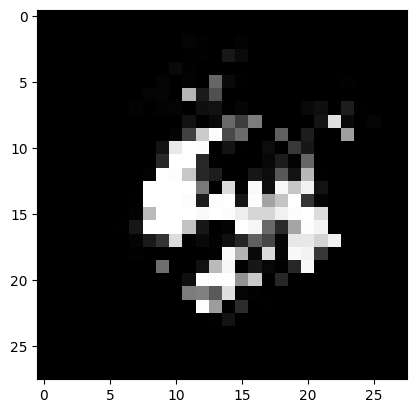

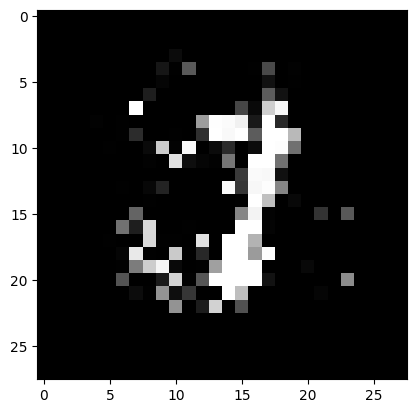

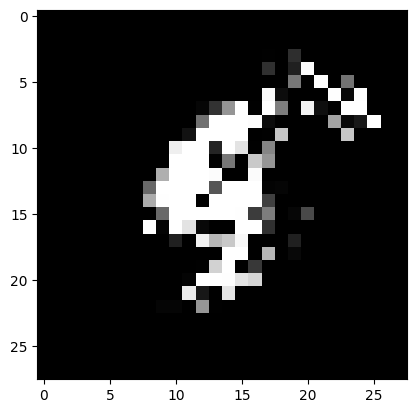

Epoch: 16050
loss_g: 1.2957303524017334 	loss_d: 1.0961536169052124
Epoch: 16100
loss_g: 1.4035604000091553 	loss_d: 0.9890615344047546
Epoch: 16150
loss_g: 1.3960398435592651 	loss_d: 0.9680792093276978
Epoch: 16200
loss_g: 1.2599221467971802 	loss_d: 0.9791521430015564
Epoch: 16250
loss_g: 1.2845252752304077 	loss_d: 0.9635465145111084
Epoch: 16300
loss_g: 1.4638776779174805 	loss_d: 1.021439790725708
Epoch: 16350
loss_g: 1.449567437171936 	loss_d: 0.8648122549057007
Epoch: 16400
loss_g: 1.5403112173080444 	loss_d: 0.8224233388900757
Epoch: 16450
loss_g: 1.4073063135147095 	loss_d: 0.7929109334945679
Epoch: 16500
loss_g: 1.369831919670105 	loss_d: 0.9316799640655518


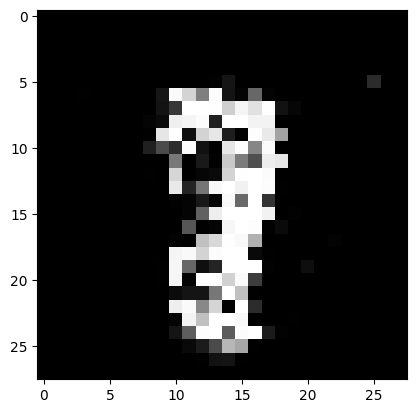

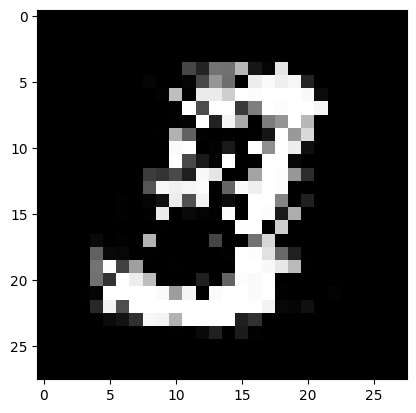

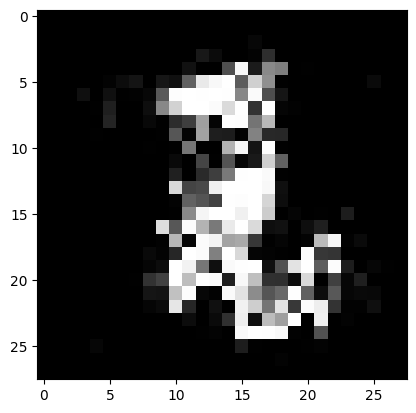

Epoch: 16550
loss_g: 1.4348207712173462 	loss_d: 0.8757337331771851
Epoch: 16600
loss_g: 1.379338026046753 	loss_d: 0.988233208656311
Epoch: 16650
loss_g: 1.5364794731140137 	loss_d: 0.9176402688026428
Epoch: 16700
loss_g: 1.4604870080947876 	loss_d: 0.8185474872589111
Epoch: 16750
loss_g: 1.565840721130371 	loss_d: 0.8227419853210449
Epoch: 16800
loss_g: 1.3171038627624512 	loss_d: 0.9906144738197327
Epoch: 16850
loss_g: 1.271012544631958 	loss_d: 0.882798433303833
Epoch: 16900
loss_g: 1.4286454916000366 	loss_d: 1.134742021560669
Epoch: 16950
loss_g: 1.3740966320037842 	loss_d: 1.0020321607589722
Epoch: 17000
loss_g: 1.2149159908294678 	loss_d: 1.0458931922912598


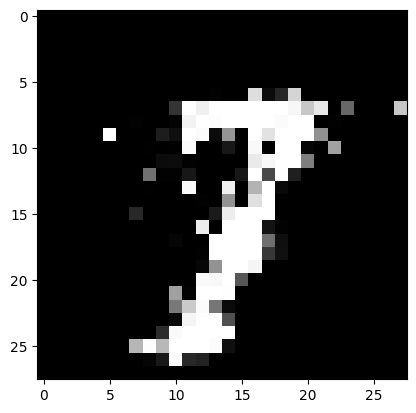

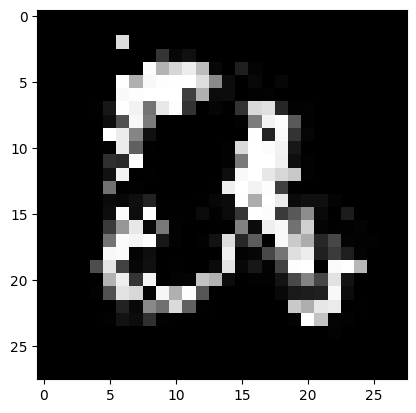

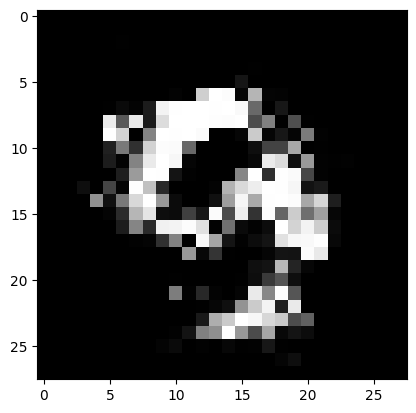

Epoch: 17050
loss_g: 1.382794737815857 	loss_d: 0.8782258629798889
Epoch: 17100
loss_g: 1.6567754745483398 	loss_d: 1.066748857498169
Epoch: 17150
loss_g: 1.3966988325119019 	loss_d: 0.8371105194091797
Epoch: 17200
loss_g: 1.4156423807144165 	loss_d: 0.8948550224304199
Epoch: 17250
loss_g: 1.5712887048721313 	loss_d: 0.8994742631912231
Epoch: 17300
loss_g: 1.5998351573944092 	loss_d: 0.7327577471733093
Epoch: 17350
loss_g: 1.5530956983566284 	loss_d: 0.8529074192047119
Epoch: 17400
loss_g: 1.5536532402038574 	loss_d: 0.9656572937965393
Epoch: 17450
loss_g: 1.4799238443374634 	loss_d: 1.0980589389801025
Epoch: 17500
loss_g: 1.3674041032791138 	loss_d: 0.8923070430755615


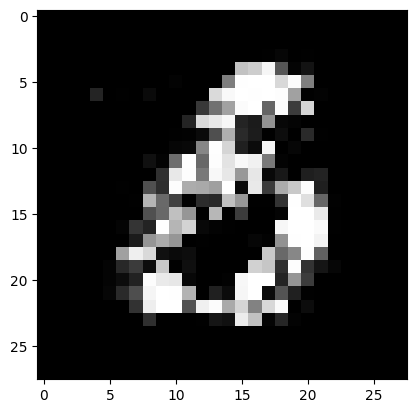

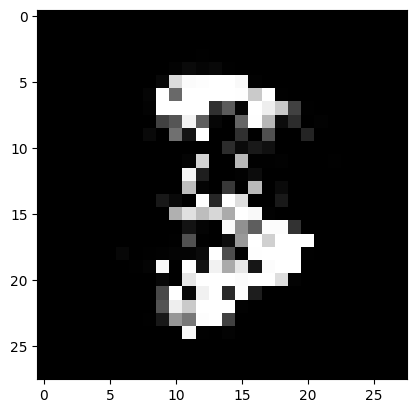

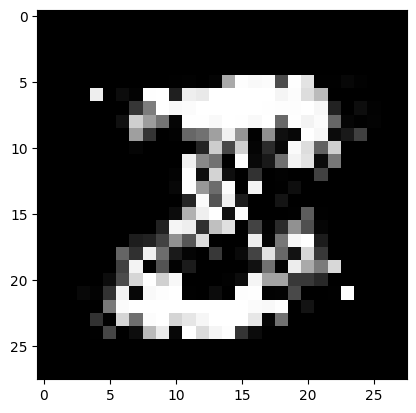

Epoch: 17550
loss_g: 1.4940673112869263 	loss_d: 0.8727805614471436
Epoch: 17600
loss_g: 1.4060598611831665 	loss_d: 0.8823386430740356
Epoch: 17650
loss_g: 1.2771861553192139 	loss_d: 0.7607933282852173
Epoch: 17700
loss_g: 1.248853325843811 	loss_d: 0.9768986105918884
Epoch: 17750
loss_g: 1.3233168125152588 	loss_d: 0.9685760736465454
Epoch: 17800
loss_g: 1.5192617177963257 	loss_d: 0.8036580681800842
Epoch: 17850
loss_g: 1.5886378288269043 	loss_d: 0.8803141117095947
Epoch: 17900
loss_g: 1.37041437625885 	loss_d: 0.9208675622940063
Epoch: 17950
loss_g: 1.4016729593276978 	loss_d: 1.0270638465881348
Epoch: 18000
loss_g: 1.3016300201416016 	loss_d: 1.0303252935409546


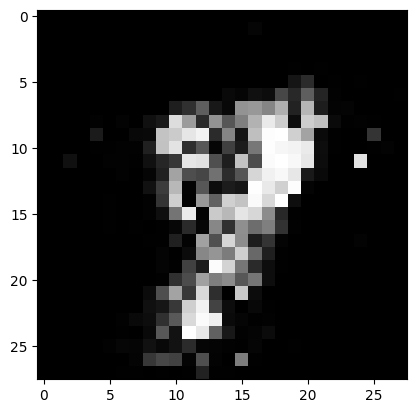

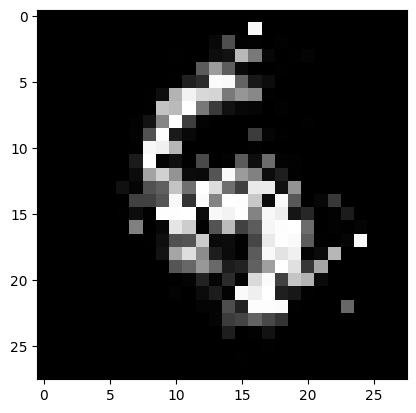

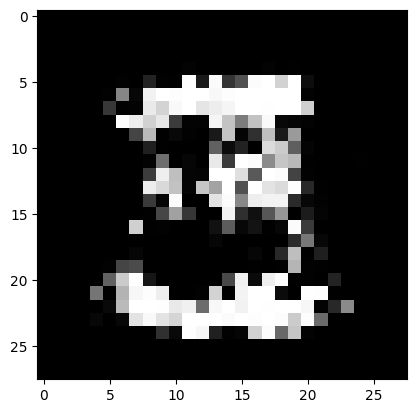

Epoch: 18050
loss_g: 1.3489322662353516 	loss_d: 0.9471983909606934
Epoch: 18100
loss_g: 1.4485387802124023 	loss_d: 0.8876036405563354
Epoch: 18150
loss_g: 1.347678303718567 	loss_d: 1.0352115631103516
Epoch: 18200
loss_g: 1.462351679801941 	loss_d: 1.1257929801940918
Epoch: 18250
loss_g: 1.5297563076019287 	loss_d: 0.8277523517608643
Epoch: 18300
loss_g: 1.4904910326004028 	loss_d: 0.8929819464683533
Epoch: 18350
loss_g: 1.4029852151870728 	loss_d: 0.7169455885887146
Epoch: 18400
loss_g: 1.3489311933517456 	loss_d: 0.913607120513916
Epoch: 18450
loss_g: 1.4448837041854858 	loss_d: 1.0118612051010132
Epoch: 18500
loss_g: 1.3702762126922607 	loss_d: 1.066755771636963


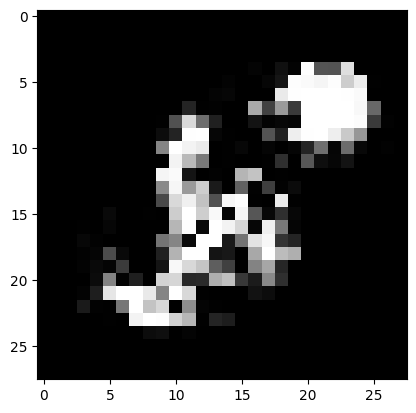

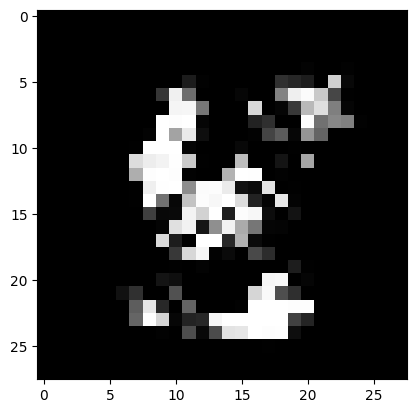

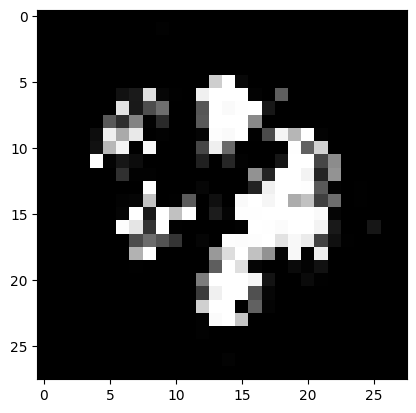

Epoch: 18550
loss_g: 1.5350537300109863 	loss_d: 0.8473389744758606
Epoch: 18600
loss_g: 1.5149712562561035 	loss_d: 0.9899019002914429
Epoch: 18650
loss_g: 1.4667936563491821 	loss_d: 0.9728595018386841
Epoch: 18700
loss_g: 1.3872017860412598 	loss_d: 1.0410726070404053
Epoch: 18750
loss_g: 1.1891252994537354 	loss_d: 0.9991186261177063
Epoch: 18800
loss_g: 1.5052869319915771 	loss_d: 1.04466712474823
Epoch: 18850
loss_g: 1.2993897199630737 	loss_d: 0.9205567836761475
Epoch: 18900
loss_g: 1.24189293384552 	loss_d: 0.9299277067184448
Epoch: 18950
loss_g: 1.4015192985534668 	loss_d: 1.0287697315216064
Epoch: 19000
loss_g: 1.332314133644104 	loss_d: 0.9687784910202026


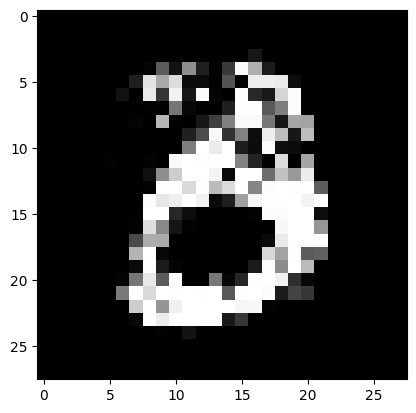

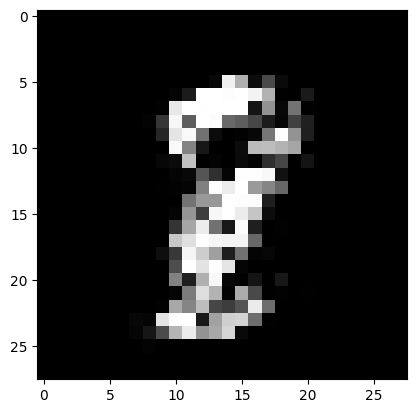

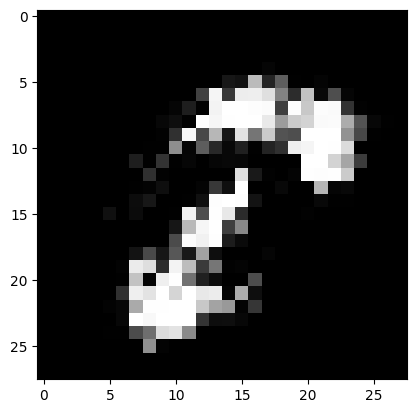

Epoch: 19050
loss_g: 1.2850234508514404 	loss_d: 1.0120664834976196
Epoch: 19100
loss_g: 1.388690710067749 	loss_d: 1.0071890354156494
Epoch: 19150
loss_g: 1.4589953422546387 	loss_d: 0.8915157318115234
Epoch: 19200
loss_g: 1.6206176280975342 	loss_d: 1.0471470355987549
Epoch: 19250
loss_g: 1.4292149543762207 	loss_d: 0.8468360900878906
Epoch: 19300
loss_g: 1.298797607421875 	loss_d: 0.9886060953140259
Epoch: 19350
loss_g: 1.3314913511276245 	loss_d: 1.0140548944473267
Epoch: 19400
loss_g: 1.444407343864441 	loss_d: 0.8534728288650513
Epoch: 19450
loss_g: 1.456380844116211 	loss_d: 1.0789521932601929
Epoch: 19500
loss_g: 1.2408275604248047 	loss_d: 1.0360026359558105


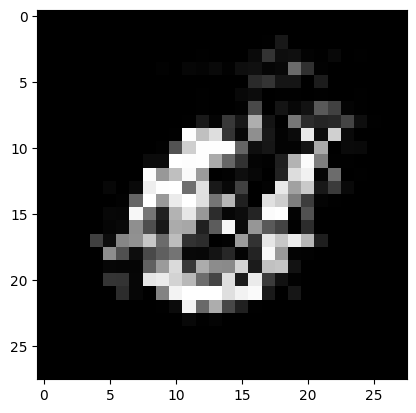

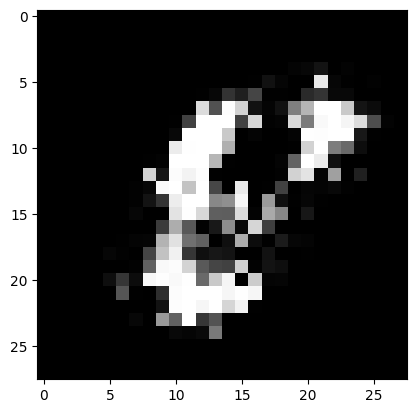

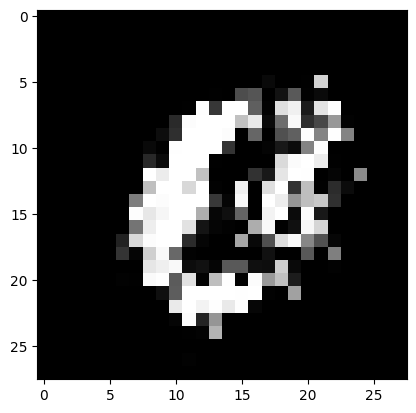

Epoch: 19550
loss_g: 1.4442214965820312 	loss_d: 0.8583459854125977
Epoch: 19600
loss_g: 1.3974266052246094 	loss_d: 1.1461001634597778
Epoch: 19650
loss_g: 1.205656886100769 	loss_d: 1.1549969911575317
Epoch: 19700
loss_g: 1.1976743936538696 	loss_d: 1.050574779510498
Epoch: 19750
loss_g: 1.323656439781189 	loss_d: 1.0779324769973755
Epoch: 19800
loss_g: 1.2143218517303467 	loss_d: 0.9151562452316284
Epoch: 19850
loss_g: 1.3661024570465088 	loss_d: 1.0134913921356201
Epoch: 19900
loss_g: 1.20733642578125 	loss_d: 1.0264015197753906
Epoch: 19950
loss_g: 1.3122917413711548 	loss_d: 0.9104244709014893
Epoch: 20000
loss_g: 1.2853679656982422 	loss_d: 0.8649280667304993


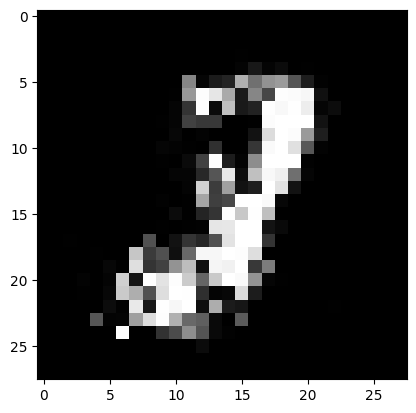

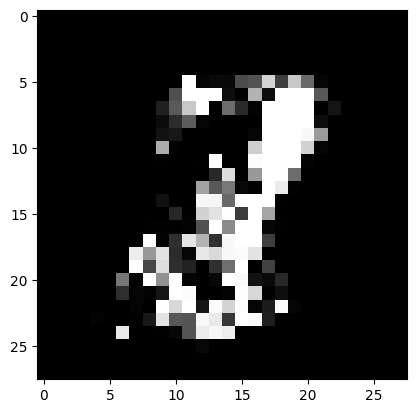

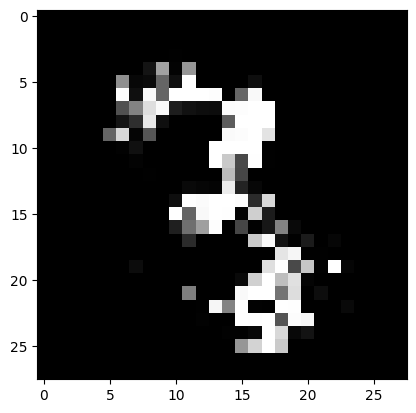

Epoch: 20050
loss_g: 1.3894277811050415 	loss_d: 0.9455406665802002
Epoch: 20100
loss_g: 1.3592880964279175 	loss_d: 0.8811404705047607
Epoch: 20150
loss_g: 1.2844032049179077 	loss_d: 0.9192698001861572
Epoch: 20200
loss_g: 1.2602778673171997 	loss_d: 1.0073981285095215
Epoch: 20250
loss_g: 1.5342488288879395 	loss_d: 1.0596801042556763
Epoch: 20300
loss_g: 1.275321125984192 	loss_d: 0.9259552955627441
Epoch: 20350
loss_g: 1.4931570291519165 	loss_d: 1.0326673984527588
Epoch: 20400
loss_g: 1.186950445175171 	loss_d: 1.0930321216583252
Epoch: 20450
loss_g: 1.2059223651885986 	loss_d: 1.0970089435577393
Epoch: 20500
loss_g: 1.1706255674362183 	loss_d: 1.1221277713775635


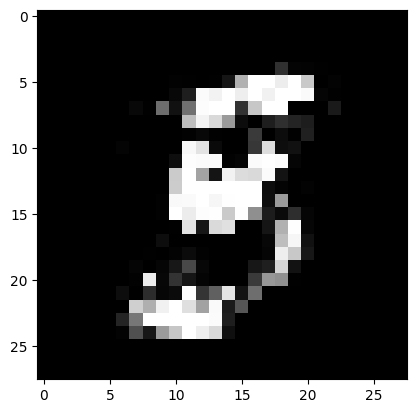

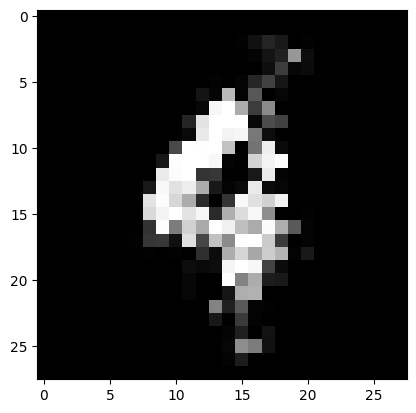

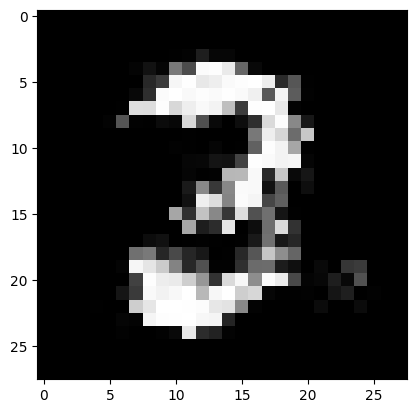

Epoch: 20550
loss_g: 1.2803878784179688 	loss_d: 1.1058789491653442
Epoch: 20600
loss_g: 1.3368881940841675 	loss_d: 1.1126909255981445
Epoch: 20650
loss_g: 1.2695579528808594 	loss_d: 1.0183637142181396
Epoch: 20700
loss_g: 1.1622289419174194 	loss_d: 1.1209357976913452
Epoch: 20750
loss_g: 1.4424552917480469 	loss_d: 1.2486746311187744
Epoch: 20800
loss_g: 1.273085594177246 	loss_d: 1.0307549238204956
Epoch: 20850
loss_g: 1.2911831140518188 	loss_d: 0.9532594680786133
Epoch: 20900
loss_g: 1.2855782508850098 	loss_d: 0.9735427498817444
Epoch: 20950
loss_g: 1.3323920965194702 	loss_d: 1.125302791595459
Epoch: 21000
loss_g: 1.2286559343338013 	loss_d: 1.0428025722503662


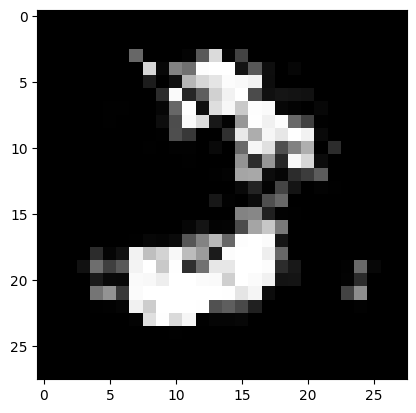

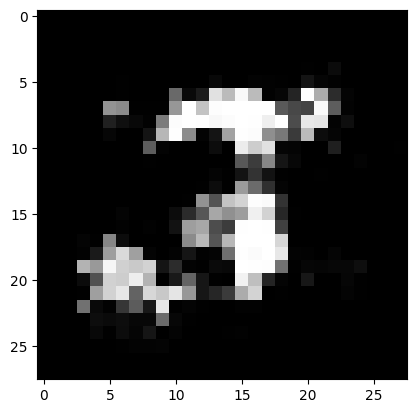

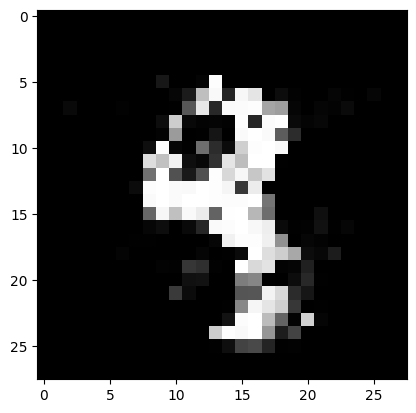

Epoch: 21050
loss_g: 1.3709570169448853 	loss_d: 1.06199049949646
Epoch: 21100
loss_g: 1.2877296209335327 	loss_d: 1.1151982545852661
Epoch: 21150
loss_g: 1.2024096250534058 	loss_d: 1.0695161819458008
Epoch: 21200
loss_g: 1.3060122728347778 	loss_d: 1.03216552734375
Epoch: 21250
loss_g: 1.286484956741333 	loss_d: 1.0619168281555176
Epoch: 21300
loss_g: 1.2889134883880615 	loss_d: 1.1281828880310059
Epoch: 21350
loss_g: 1.3414660692214966 	loss_d: 1.0381332635879517
Epoch: 21400
loss_g: 1.2488155364990234 	loss_d: 1.0871161222457886
Epoch: 21450
loss_g: 1.2461071014404297 	loss_d: 0.969317615032196
Epoch: 21500
loss_g: 1.4477108716964722 	loss_d: 1.0684174299240112


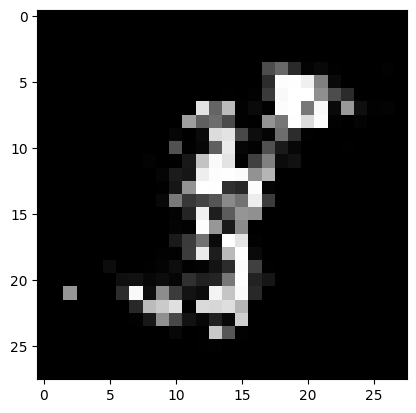

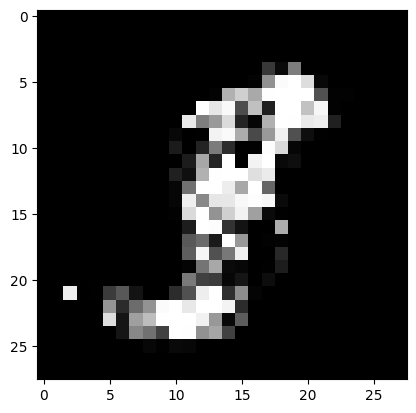

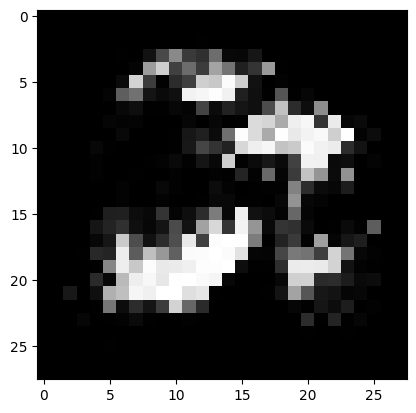

Epoch: 21550
loss_g: 1.476055383682251 	loss_d: 1.0272375345230103
Epoch: 21600
loss_g: 1.4505747556686401 	loss_d: 0.9376760125160217
Epoch: 21650
loss_g: 1.3901739120483398 	loss_d: 0.8420836925506592
Epoch: 21700
loss_g: 1.4426441192626953 	loss_d: 0.941500186920166
Epoch: 21750
loss_g: 1.3243663311004639 	loss_d: 1.077600121498108
Epoch: 21800
loss_g: 1.425966739654541 	loss_d: 0.9491691589355469
Epoch: 21850
loss_g: 1.4246981143951416 	loss_d: 1.0334542989730835
Epoch: 21900
loss_g: 1.3915045261383057 	loss_d: 1.057428240776062
Epoch: 21950
loss_g: 1.269222378730774 	loss_d: 0.9342918395996094
Epoch: 22000
loss_g: 1.4241195917129517 	loss_d: 1.0561963319778442


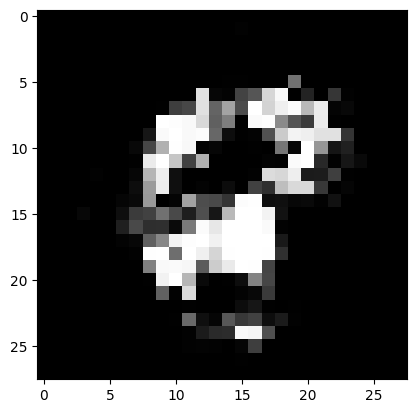

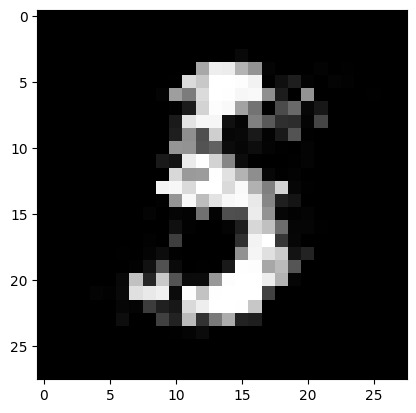

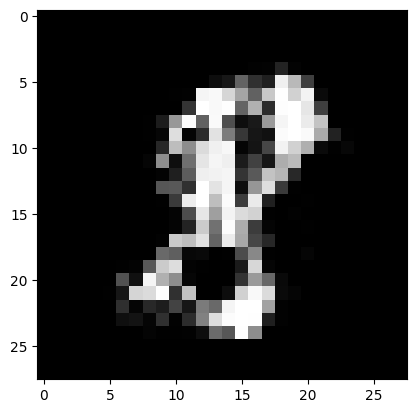

Epoch: 22050
loss_g: 1.2204768657684326 	loss_d: 0.9679418206214905
Epoch: 22100
loss_g: 1.3243982791900635 	loss_d: 0.9829995632171631
Epoch: 22150
loss_g: 1.2988018989562988 	loss_d: 1.0481852293014526
Epoch: 22200
loss_g: 1.2315330505371094 	loss_d: 0.9710016250610352
Epoch: 22250
loss_g: 1.2514514923095703 	loss_d: 1.0312867164611816
Epoch: 22300
loss_g: 1.2392171621322632 	loss_d: 1.0222537517547607
Epoch: 22350
loss_g: 1.2231965065002441 	loss_d: 0.9236469864845276
Epoch: 22400
loss_g: 1.3890496492385864 	loss_d: 0.8276063203811646
Epoch: 22450
loss_g: 1.3762271404266357 	loss_d: 0.8855658769607544
Epoch: 22500
loss_g: 1.4231940507888794 	loss_d: 0.9606512784957886


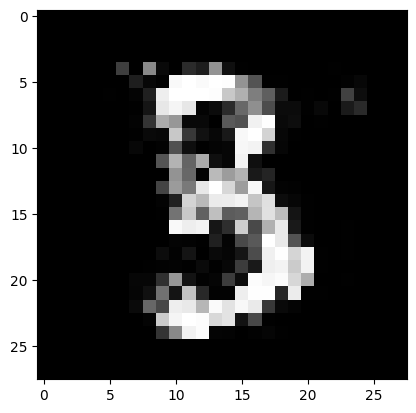

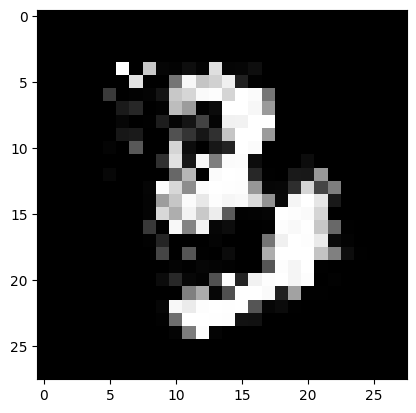

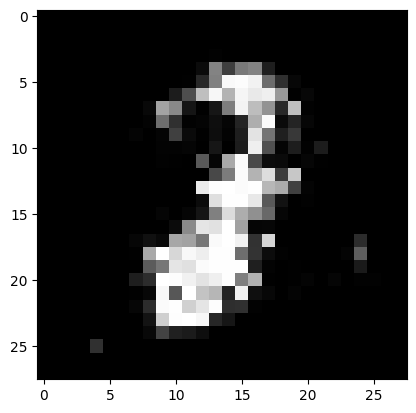

Epoch: 22550
loss_g: 1.4609410762786865 	loss_d: 0.9263044595718384
Epoch: 22600
loss_g: 1.537038803100586 	loss_d: 1.0154216289520264
Epoch: 22650
loss_g: 1.3826032876968384 	loss_d: 0.8908944129943848
Epoch: 22700
loss_g: 1.3560842275619507 	loss_d: 0.899427056312561
Epoch: 22750
loss_g: 1.680275559425354 	loss_d: 0.7802723050117493
Epoch: 22800
loss_g: 1.4765220880508423 	loss_d: 0.859986424446106
Epoch: 22850
loss_g: 1.194977879524231 	loss_d: 0.9094326496124268
Epoch: 22900
loss_g: 1.6309365034103394 	loss_d: 0.8774333000183105
Epoch: 22950
loss_g: 1.6826032400131226 	loss_d: 0.7272116541862488
Epoch: 23000
loss_g: 1.477189302444458 	loss_d: 0.8522422313690186


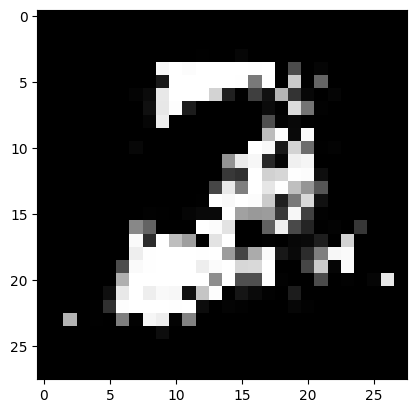

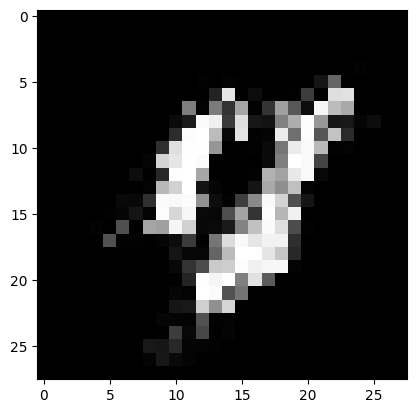

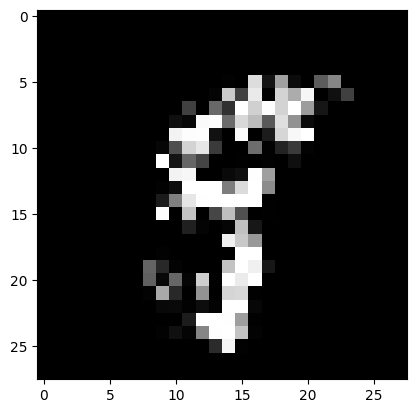

Epoch: 23050
loss_g: 1.682554841041565 	loss_d: 0.8562102913856506
Epoch: 23100
loss_g: 1.4881502389907837 	loss_d: 0.7996703386306763
Epoch: 23150
loss_g: 1.4518691301345825 	loss_d: 0.8498107194900513
Epoch: 23200
loss_g: 1.6345292329788208 	loss_d: 0.712049663066864
Epoch: 23250
loss_g: 1.5212551355361938 	loss_d: 0.9459238052368164
Epoch: 23300
loss_g: 1.4783636331558228 	loss_d: 0.885696291923523
Epoch: 23350
loss_g: 1.3141964673995972 	loss_d: 0.8419132232666016
Epoch: 23400
loss_g: 1.6028683185577393 	loss_d: 0.7983114123344421
Epoch: 23450
loss_g: 1.4140413999557495 	loss_d: 0.9691157341003418
Epoch: 23500
loss_g: 1.4722020626068115 	loss_d: 1.080620527267456


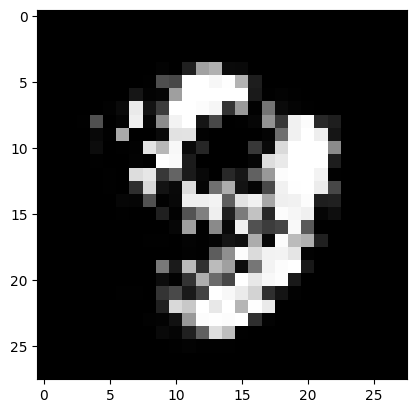

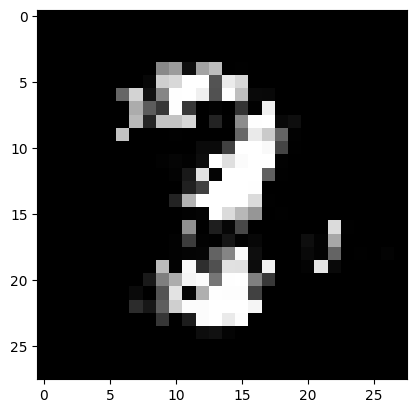

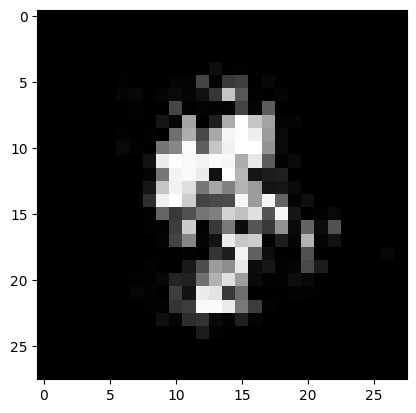

Epoch: 23550
loss_g: 1.4284255504608154 	loss_d: 1.0919641256332397
Epoch: 23600
loss_g: 1.4283866882324219 	loss_d: 0.874872624874115
Epoch: 23650
loss_g: 1.449096918106079 	loss_d: 0.9902393817901611
Epoch: 23700
loss_g: 1.3509936332702637 	loss_d: 1.0070446729660034
Epoch: 23750
loss_g: 1.448859691619873 	loss_d: 0.9493236541748047
Epoch: 23800
loss_g: 1.629954218864441 	loss_d: 0.9185582399368286
Epoch: 23850
loss_g: 1.4185924530029297 	loss_d: 1.0429773330688477
Epoch: 23900
loss_g: 1.4704452753067017 	loss_d: 1.012021780014038
Epoch: 23950
loss_g: 1.3626028299331665 	loss_d: 0.9801794290542603
Epoch: 24000
loss_g: 1.4163068532943726 	loss_d: 0.8009634017944336


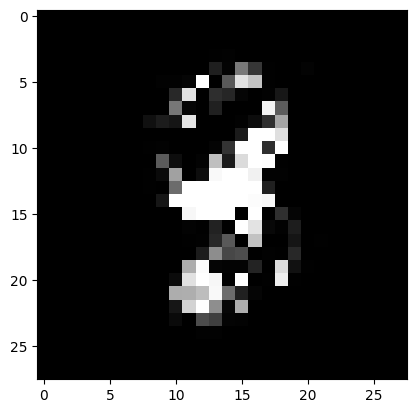

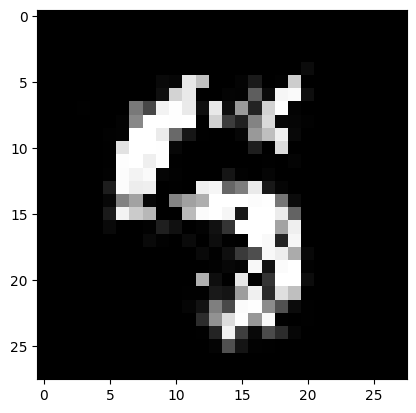

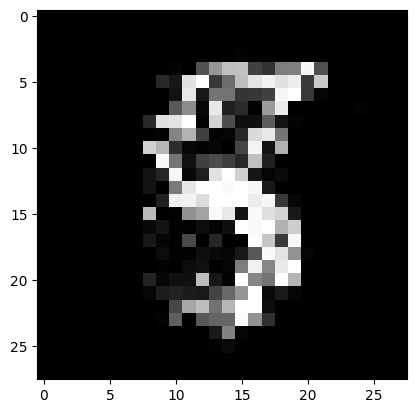

Epoch: 24050
loss_g: 1.5243853330612183 	loss_d: 0.9248660802841187
Epoch: 24100
loss_g: 1.4904992580413818 	loss_d: 0.8419651985168457
Epoch: 24150
loss_g: 1.4407204389572144 	loss_d: 1.0807527303695679
Epoch: 24200
loss_g: 1.2527779340744019 	loss_d: 0.9390652179718018
Epoch: 24250
loss_g: 1.4235411882400513 	loss_d: 0.9947890043258667
Epoch: 24300
loss_g: 1.5581579208374023 	loss_d: 1.0515003204345703
Epoch: 24350
loss_g: 1.6105201244354248 	loss_d: 0.9069451689720154
Epoch: 24400
loss_g: 1.5603092908859253 	loss_d: 0.9729855060577393
Epoch: 24450
loss_g: 1.248157262802124 	loss_d: 1.0521140098571777
Epoch: 24500
loss_g: 1.3351587057113647 	loss_d: 1.0307319164276123


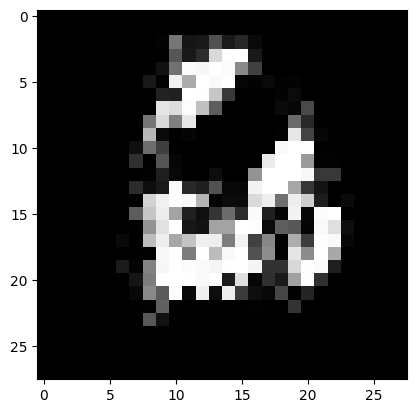

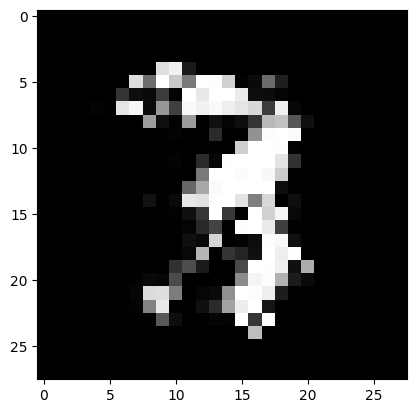

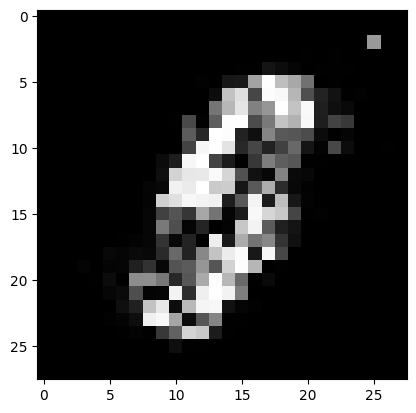

Epoch: 24550
loss_g: 1.5289509296417236 	loss_d: 0.9299334287643433
Epoch: 24600
loss_g: 1.4028306007385254 	loss_d: 0.7543958425521851
Epoch: 24650
loss_g: 1.2720532417297363 	loss_d: 0.961473822593689
Epoch: 24700
loss_g: 1.5662838220596313 	loss_d: 1.0271755456924438
Epoch: 24750
loss_g: 1.2830971479415894 	loss_d: 0.9913547039031982
Epoch: 24800
loss_g: 1.2739639282226562 	loss_d: 0.9620921611785889
Epoch: 24850
loss_g: 1.3350014686584473 	loss_d: 0.9609128832817078
Epoch: 24900
loss_g: 1.4217089414596558 	loss_d: 0.8883997201919556
Epoch: 24950
loss_g: 1.3876129388809204 	loss_d: 1.0927293300628662
Epoch: 25000
loss_g: 1.320786714553833 	loss_d: 0.9491945505142212


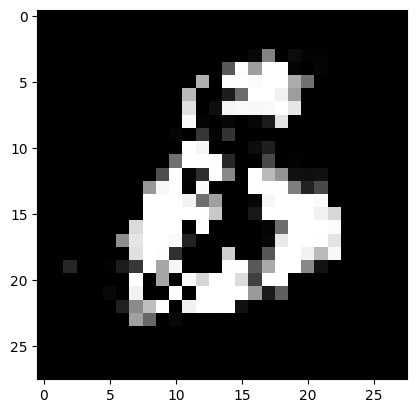

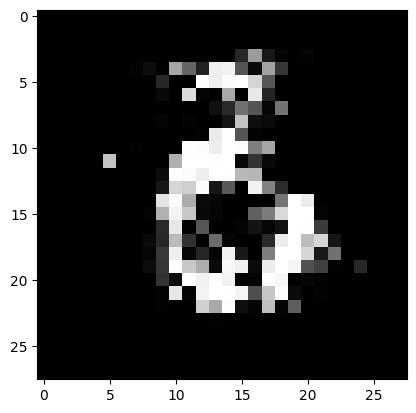

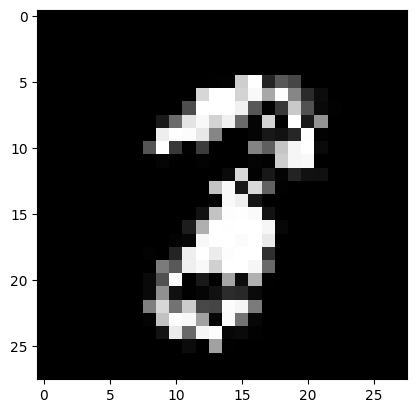

Epoch: 25050
loss_g: 1.2228360176086426 	loss_d: 0.921189546585083
Epoch: 25100
loss_g: 1.3413009643554688 	loss_d: 1.1350148916244507
Epoch: 25150
loss_g: 1.1973541975021362 	loss_d: 1.0539027452468872
Epoch: 25200
loss_g: 1.261419415473938 	loss_d: 0.9176530241966248
Epoch: 25250
loss_g: 1.3846443891525269 	loss_d: 0.8962790966033936
Epoch: 25300
loss_g: 1.330334186553955 	loss_d: 0.9816040992736816
Epoch: 25350
loss_g: 1.3386492729187012 	loss_d: 1.0109748840332031
Epoch: 25400
loss_g: 1.400296926498413 	loss_d: 1.0074167251586914
Epoch: 25450
loss_g: 1.194669246673584 	loss_d: 1.1131823062896729
Epoch: 25500
loss_g: 1.3847194910049438 	loss_d: 1.0102707147598267


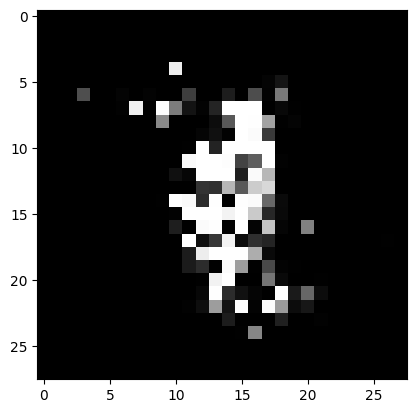

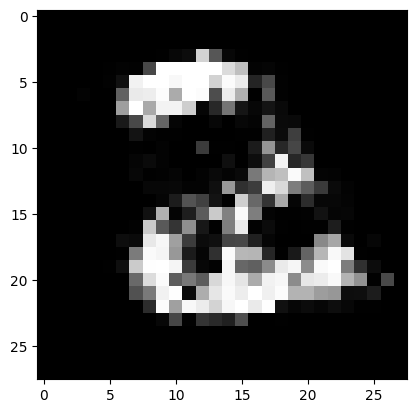

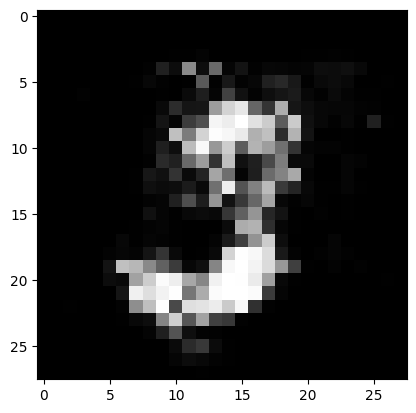

Epoch: 25550
loss_g: 1.2546778917312622 	loss_d: 1.1089943647384644
Epoch: 25600
loss_g: 1.1984587907791138 	loss_d: 1.0253643989562988
Epoch: 25650
loss_g: 1.30824613571167 	loss_d: 1.2419075965881348
Epoch: 25700
loss_g: 1.1922956705093384 	loss_d: 1.1178072690963745
Epoch: 25750
loss_g: 1.2711693048477173 	loss_d: 1.0868419408798218
Epoch: 25800
loss_g: 1.1598937511444092 	loss_d: 1.0932413339614868
Epoch: 25850
loss_g: 1.1617529392242432 	loss_d: 1.1182432174682617
Epoch: 25900
loss_g: 1.3540444374084473 	loss_d: 0.998313844203949
Epoch: 25950
loss_g: 1.3361660242080688 	loss_d: 1.0314621925354004
Epoch: 26000
loss_g: 1.257120132446289 	loss_d: 0.9934555292129517


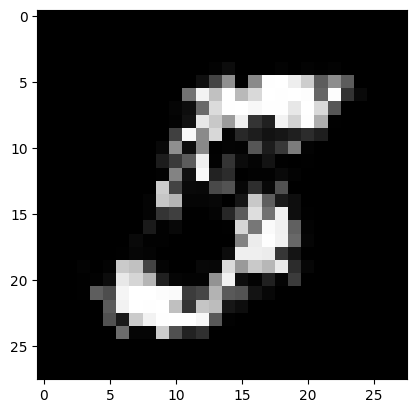

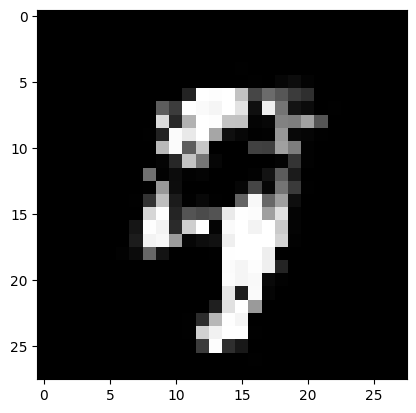

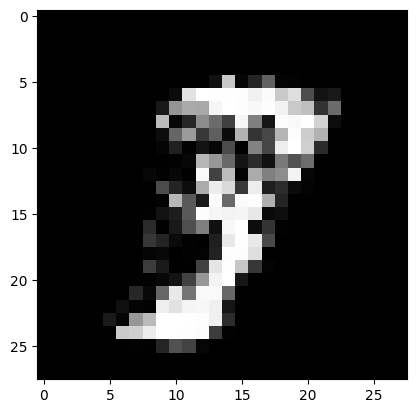

Epoch: 26050
loss_g: 1.1411741971969604 	loss_d: 1.21348237991333
Epoch: 26100
loss_g: 1.3024801015853882 	loss_d: 1.1620063781738281
Epoch: 26150
loss_g: 1.1873633861541748 	loss_d: 1.138398289680481
Epoch: 26200
loss_g: 1.2219208478927612 	loss_d: 1.1494808197021484
Epoch: 26250
loss_g: 1.2836412191390991 	loss_d: 1.2319612503051758
Epoch: 26300
loss_g: 1.1629431247711182 	loss_d: 1.100691556930542
Epoch: 26350
loss_g: 1.1474835872650146 	loss_d: 1.090520977973938
Epoch: 26400
loss_g: 1.134376883506775 	loss_d: 1.1379544734954834
Epoch: 26450
loss_g: 1.0670853853225708 	loss_d: 1.1453516483306885
Epoch: 26500
loss_g: 1.1021331548690796 	loss_d: 1.078016996383667


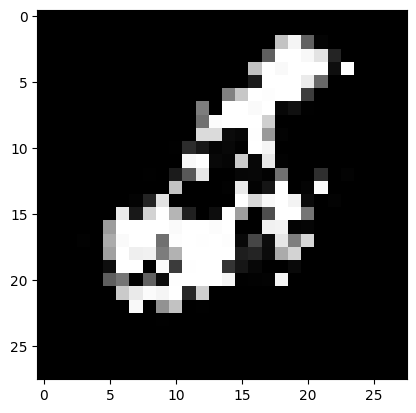

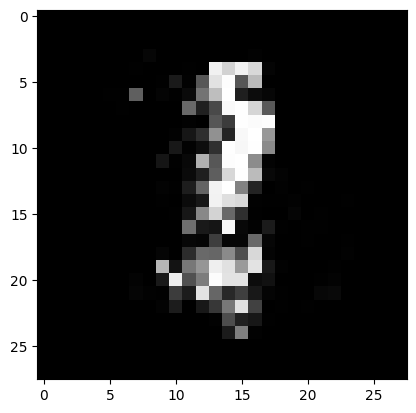

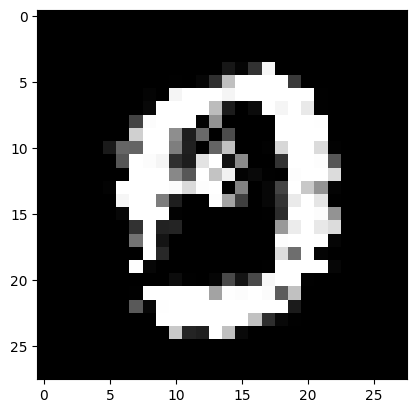

Epoch: 26550
loss_g: 1.098510503768921 	loss_d: 1.1805126667022705
Epoch: 26600
loss_g: 1.1220039129257202 	loss_d: 1.040706992149353
Epoch: 26650
loss_g: 1.2137184143066406 	loss_d: 1.0691421031951904
Epoch: 26700
loss_g: 1.2178843021392822 	loss_d: 1.1997768878936768
Epoch: 26750
loss_g: 1.016649603843689 	loss_d: 1.1445715427398682
Epoch: 26800
loss_g: 0.9965011477470398 	loss_d: 1.1720185279846191
Epoch: 26850
loss_g: 1.1423019170761108 	loss_d: 1.1840617656707764
Epoch: 26900
loss_g: 1.181322455406189 	loss_d: 1.088735580444336
Epoch: 26950
loss_g: 1.263001561164856 	loss_d: 1.2202283143997192
Epoch: 27000
loss_g: 1.2224349975585938 	loss_d: 1.2917580604553223


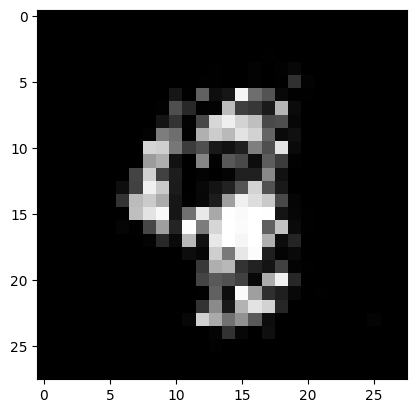

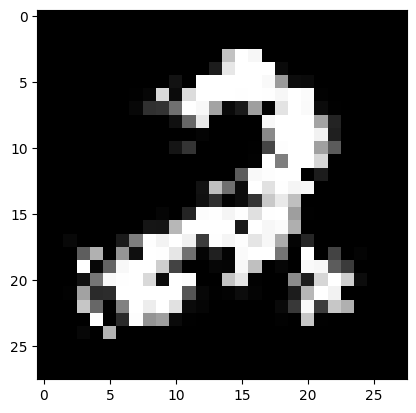

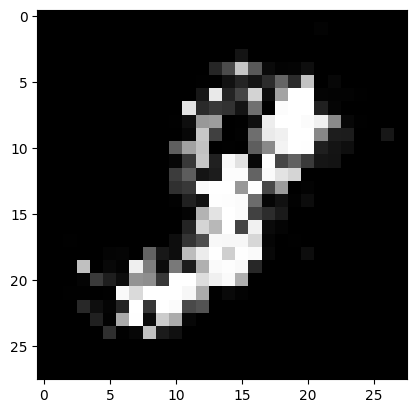

Epoch: 27050
loss_g: 1.1871819496154785 	loss_d: 1.0853463411331177
Epoch: 27100
loss_g: 1.1474196910858154 	loss_d: 1.1123323440551758
Epoch: 27150
loss_g: 1.119399070739746 	loss_d: 1.0444504022598267
Epoch: 27200
loss_g: 1.1078033447265625 	loss_d: 1.0588219165802002
Epoch: 27250
loss_g: 1.051692008972168 	loss_d: 1.1152628660202026
Epoch: 27300
loss_g: 0.902940034866333 	loss_d: 1.131518840789795
Epoch: 27350
loss_g: 1.1756913661956787 	loss_d: 1.0489007234573364
Epoch: 27400
loss_g: 1.15256929397583 	loss_d: 1.109163761138916
Epoch: 27450
loss_g: 0.9883042573928833 	loss_d: 1.1656250953674316
Epoch: 27500
loss_g: 1.1682815551757812 	loss_d: 1.0684850215911865


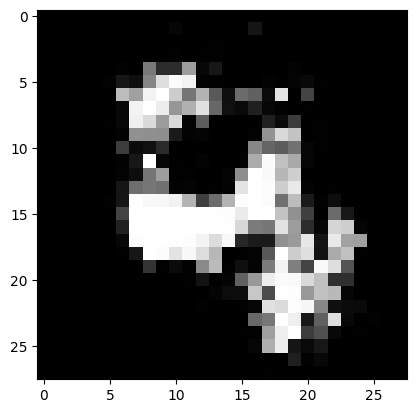

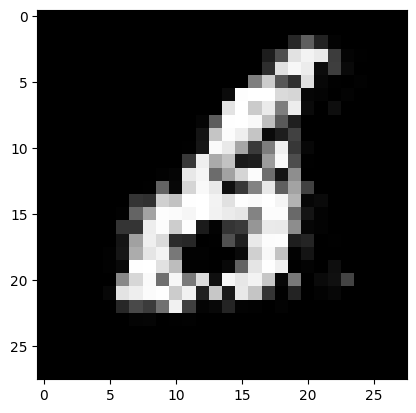

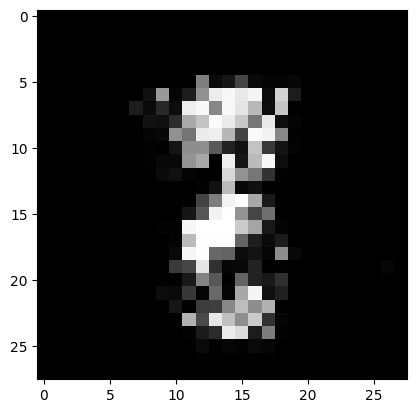

Epoch: 27550
loss_g: 1.1711483001708984 	loss_d: 1.138174295425415
Epoch: 27600
loss_g: 1.0770351886749268 	loss_d: 1.3460583686828613
Epoch: 27650
loss_g: 1.2258809804916382 	loss_d: 1.2045307159423828
Epoch: 27700
loss_g: 1.1992281675338745 	loss_d: 1.313014268875122
Epoch: 27750
loss_g: 1.1573753356933594 	loss_d: 1.1956970691680908
Epoch: 27800
loss_g: 1.0717271566390991 	loss_d: 1.234126329421997
Epoch: 27850
loss_g: 1.0171335935592651 	loss_d: 1.1617857217788696
Epoch: 27900
loss_g: 0.9983082413673401 	loss_d: 1.059035062789917
Epoch: 27950
loss_g: 1.0748127698898315 	loss_d: 1.3551361560821533
Epoch: 28000
loss_g: 1.0161370038986206 	loss_d: 1.4282495975494385


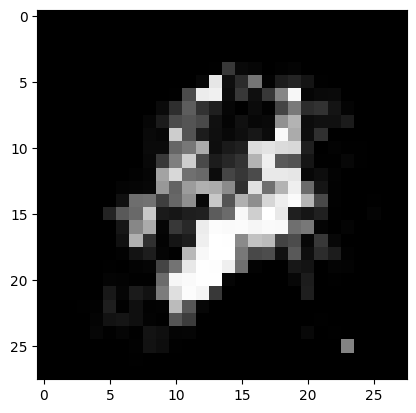

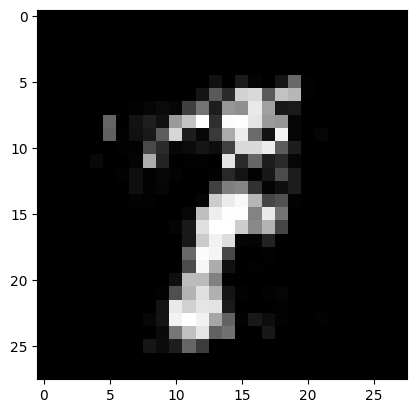

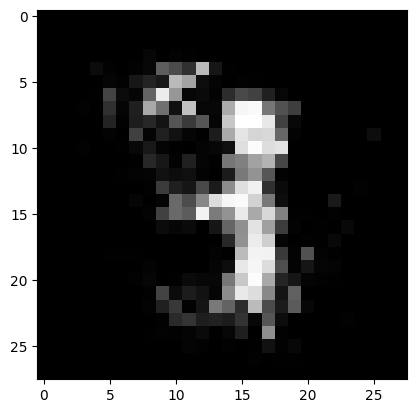

Epoch: 28050
loss_g: 1.0093715190887451 	loss_d: 1.108070969581604
Epoch: 28100
loss_g: 0.9993114471435547 	loss_d: 1.1136959791183472
Epoch: 28150
loss_g: 1.186853051185608 	loss_d: 1.2089484930038452
Epoch: 28200
loss_g: 1.1511651277542114 	loss_d: 1.0238549709320068
Epoch: 28250
loss_g: 1.0582424402236938 	loss_d: 1.119943380355835
Epoch: 28300
loss_g: 1.095643162727356 	loss_d: 1.2331242561340332
Epoch: 28350
loss_g: 0.9690739512443542 	loss_d: 1.2647713422775269
Epoch: 28400
loss_g: 0.9694848656654358 	loss_d: 1.309570550918579
Epoch: 28450
loss_g: 1.0267642736434937 	loss_d: 1.157449722290039
Epoch: 28500
loss_g: 0.9473341107368469 	loss_d: 1.2197296619415283


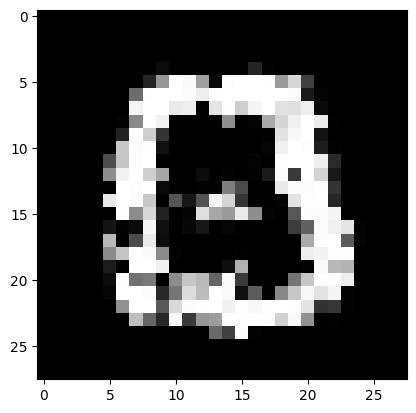

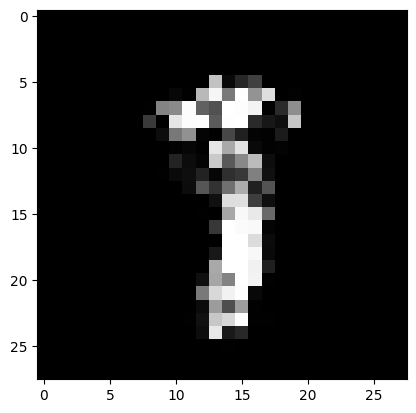

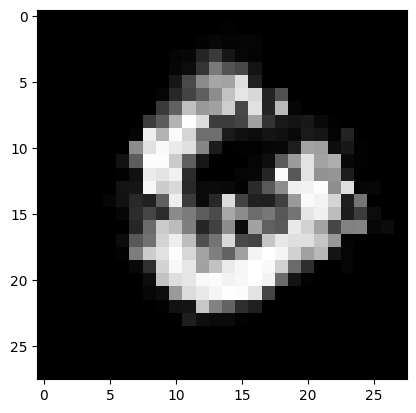

Epoch: 28550
loss_g: 1.046978235244751 	loss_d: 1.2849376201629639
Epoch: 28600
loss_g: 1.0601345300674438 	loss_d: 1.15299654006958
Epoch: 28650
loss_g: 0.9132206439971924 	loss_d: 1.049863338470459
Epoch: 28700
loss_g: 0.9604754447937012 	loss_d: 1.3051114082336426
Epoch: 28750
loss_g: 1.032112956047058 	loss_d: 1.1390397548675537
Epoch: 28800
loss_g: 1.0739067792892456 	loss_d: 1.1725213527679443
Epoch: 28850
loss_g: 0.972442090511322 	loss_d: 1.231503963470459
Epoch: 28900
loss_g: 1.0861799716949463 	loss_d: 1.1207813024520874
Epoch: 28950
loss_g: 1.1071221828460693 	loss_d: 1.3192317485809326
Epoch: 29000
loss_g: 0.980500340461731 	loss_d: 1.2253837585449219


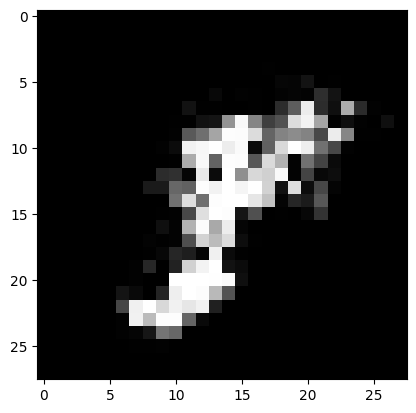

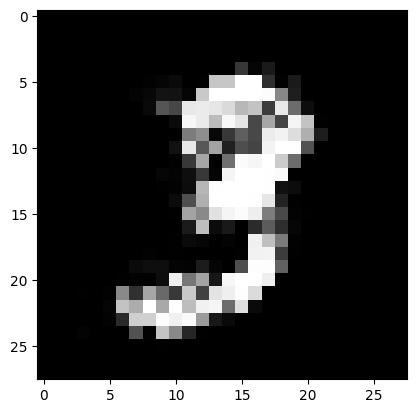

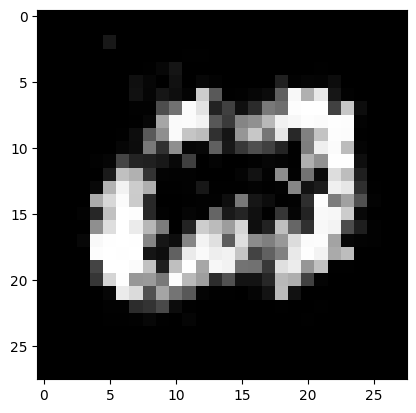

Epoch: 29050
loss_g: 1.074987769126892 	loss_d: 1.253145456314087
Epoch: 29100
loss_g: 1.1118370294570923 	loss_d: 1.2697060108184814
Epoch: 29150
loss_g: 1.0177375078201294 	loss_d: 1.2522902488708496
Epoch: 29200
loss_g: 1.0683859586715698 	loss_d: 1.2344192266464233
Epoch: 29250
loss_g: 0.9793792366981506 	loss_d: 1.2611029148101807
Epoch: 29300
loss_g: 1.1659610271453857 	loss_d: 1.1808836460113525
Epoch: 29350
loss_g: 1.1120156049728394 	loss_d: 1.2258861064910889
Epoch: 29400
loss_g: 1.0504018068313599 	loss_d: 1.1817662715911865
Epoch: 29450
loss_g: 1.1286371946334839 	loss_d: 1.190426230430603
Epoch: 29500
loss_g: 1.060551404953003 	loss_d: 1.2208781242370605


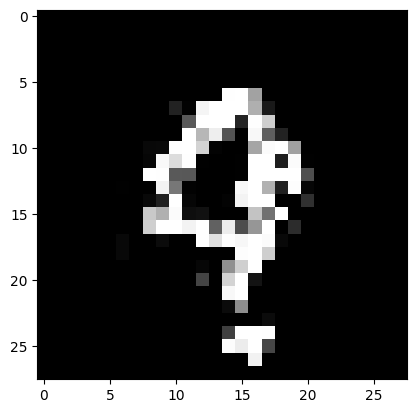

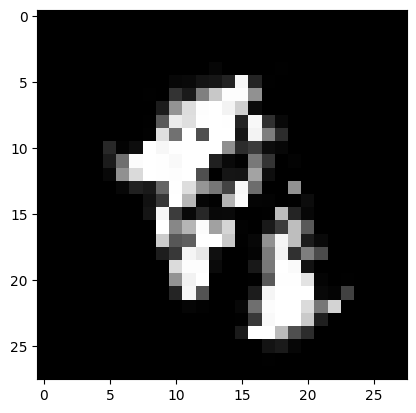

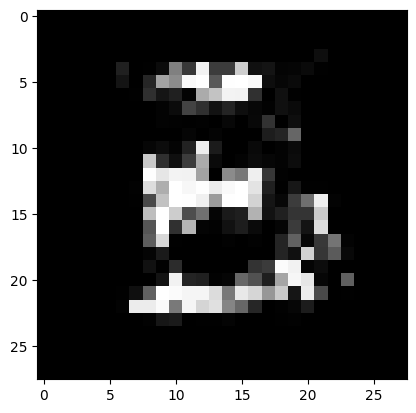

Epoch: 29550
loss_g: 0.9910276532173157 	loss_d: 1.2283015251159668
Epoch: 29600
loss_g: 1.0788935422897339 	loss_d: 1.207446813583374
Epoch: 29650
loss_g: 1.0168644189834595 	loss_d: 1.276393175125122
Epoch: 29700
loss_g: 1.046053409576416 	loss_d: 1.2148568630218506
Epoch: 29750
loss_g: 0.9913365840911865 	loss_d: 1.2031853199005127
Epoch: 29800
loss_g: 0.9919002056121826 	loss_d: 1.2278602123260498
Epoch: 29850
loss_g: 1.009321928024292 	loss_d: 1.3116427659988403
Epoch: 29900
loss_g: 1.0802212953567505 	loss_d: 1.2741894721984863
Epoch: 29950
loss_g: 1.03533136844635 	loss_d: 1.2017154693603516
Epoch: 30000
loss_g: 1.0345115661621094 	loss_d: 1.29168701171875


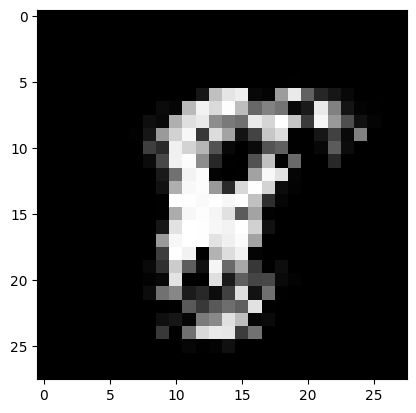

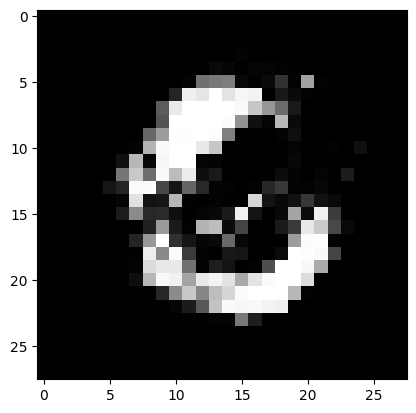

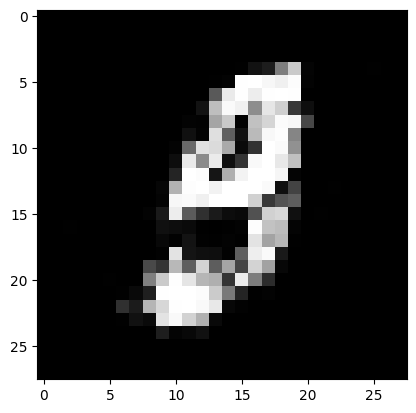

Epoch: 30050
loss_g: 1.037575602531433 	loss_d: 1.2302080392837524
Epoch: 30100
loss_g: 0.9064858555793762 	loss_d: 1.276576280593872
Epoch: 30150
loss_g: 0.9193841814994812 	loss_d: 1.3721768856048584
Epoch: 30200
loss_g: 0.9511082172393799 	loss_d: 1.2512602806091309
Epoch: 30250
loss_g: 0.8758545517921448 	loss_d: 1.2802248001098633
Epoch: 30300
loss_g: 0.9729958176612854 	loss_d: 1.1723716259002686
Epoch: 30350
loss_g: 0.9736773371696472 	loss_d: 1.2735631465911865
Epoch: 30400
loss_g: 1.0287153720855713 	loss_d: 1.3497416973114014
Epoch: 30450
loss_g: 0.9250083565711975 	loss_d: 1.3881475925445557
Epoch: 30500
loss_g: 0.9811585545539856 	loss_d: 1.2559795379638672


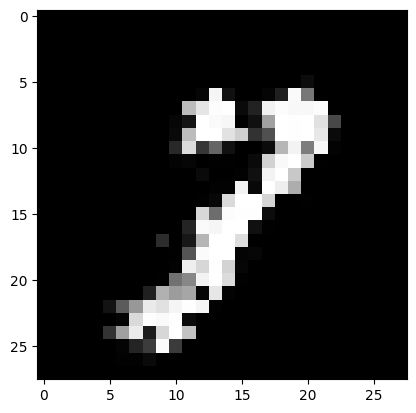

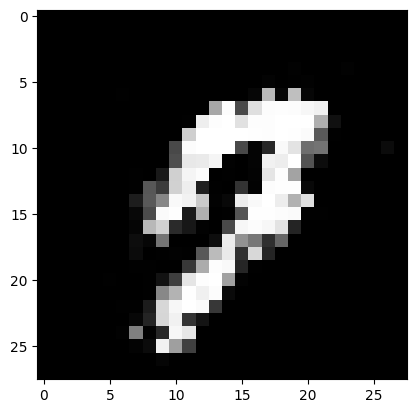

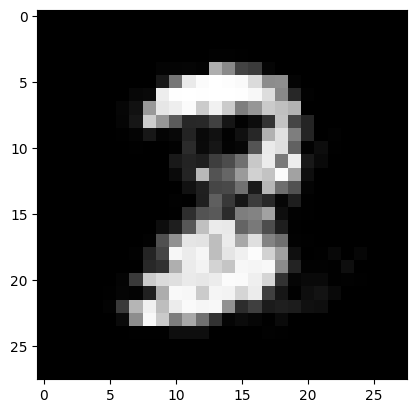

Epoch: 30550
loss_g: 1.0573939085006714 	loss_d: 1.3274109363555908
Epoch: 30600
loss_g: 1.0740227699279785 	loss_d: 1.2475889921188354
Epoch: 30650
loss_g: 0.9314252734184265 	loss_d: 1.2527003288269043
Epoch: 30700
loss_g: 0.9836843609809875 	loss_d: 1.2762912511825562
Epoch: 30750
loss_g: 0.96750807762146 	loss_d: 1.347573161125183
Epoch: 30800
loss_g: 0.8704370856285095 	loss_d: 1.1403900384902954
Epoch: 30850
loss_g: 0.9976306557655334 	loss_d: 1.2859123945236206
Epoch: 30900
loss_g: 0.7890791893005371 	loss_d: 1.2509269714355469
Epoch: 30950
loss_g: 0.9896668195724487 	loss_d: 1.2879092693328857
Epoch: 31000
loss_g: 0.9790433049201965 	loss_d: 1.2889798879623413


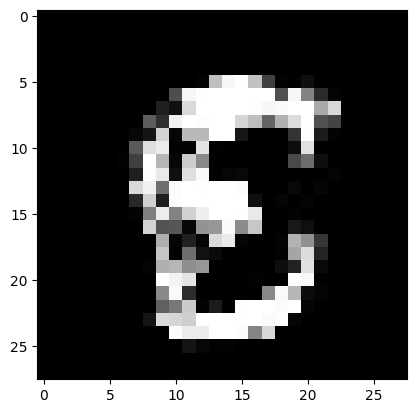

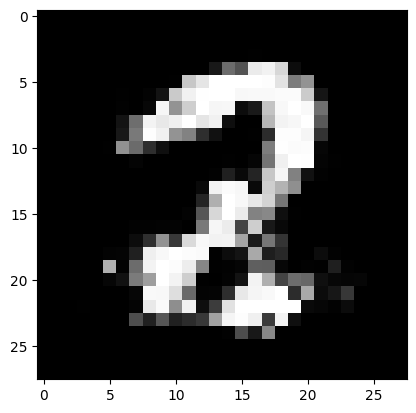

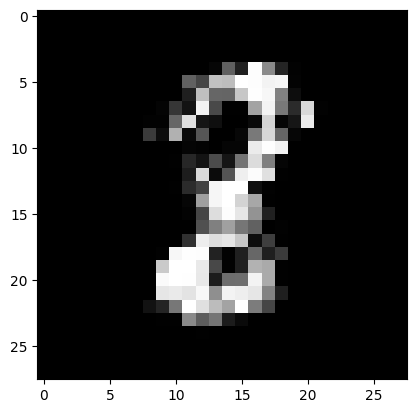

Epoch: 31050
loss_g: 1.0058138370513916 	loss_d: 1.332613229751587
Epoch: 31100
loss_g: 0.9257089495658875 	loss_d: 1.2074503898620605
Epoch: 31150
loss_g: 0.9716102480888367 	loss_d: 1.3255162239074707
Epoch: 31200
loss_g: 1.0079525709152222 	loss_d: 1.4085986614227295
Epoch: 31250
loss_g: 0.9813772439956665 	loss_d: 1.1143606901168823
Epoch: 31300
loss_g: 1.0443094968795776 	loss_d: 1.2314207553863525
Epoch: 31350
loss_g: 0.9590381979942322 	loss_d: 1.3283710479736328
Epoch: 31400
loss_g: 0.919356107711792 	loss_d: 1.271227478981018
Epoch: 31450
loss_g: 0.9102290272712708 	loss_d: 1.3150490522384644
Epoch: 31500
loss_g: 0.9362578392028809 	loss_d: 1.3747546672821045


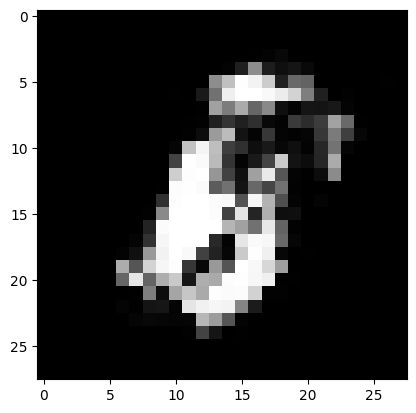

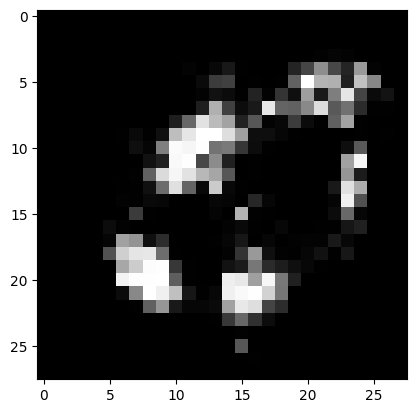

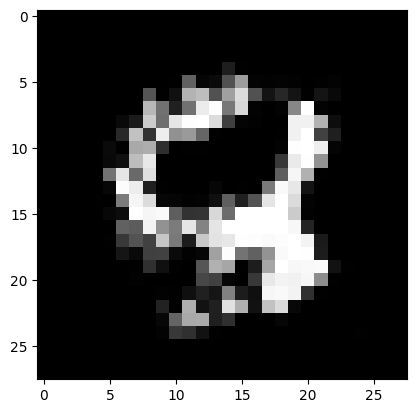

Epoch: 31550
loss_g: 0.9765647649765015 	loss_d: 1.3067026138305664
Epoch: 31600
loss_g: 0.9493787884712219 	loss_d: 1.3066743612289429
Epoch: 31650
loss_g: 0.8586578369140625 	loss_d: 1.273521900177002
Epoch: 31700
loss_g: 0.9672470688819885 	loss_d: 1.306687593460083
Epoch: 31750
loss_g: 0.9221838116645813 	loss_d: 1.2920949459075928
Epoch: 31800
loss_g: 0.9640177488327026 	loss_d: 1.2044891119003296
Epoch: 31850
loss_g: 1.006115436553955 	loss_d: 1.2370076179504395
Epoch: 31900
loss_g: 1.0548332929611206 	loss_d: 1.2834057807922363
Epoch: 31950
loss_g: 0.9226846694946289 	loss_d: 1.2740598917007446
Epoch: 32000
loss_g: 0.9347177147865295 	loss_d: 1.2749813795089722


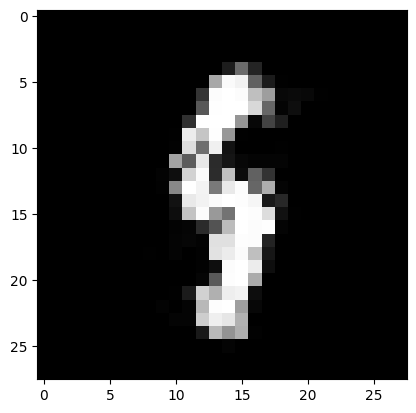

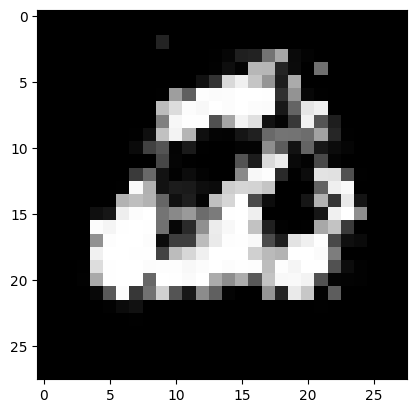

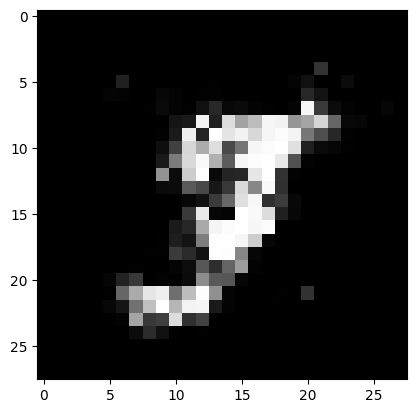

Epoch: 32050
loss_g: 0.9709081649780273 	loss_d: 1.2968217134475708
Epoch: 32100
loss_g: 1.0284806489944458 	loss_d: 1.2031152248382568
Epoch: 32150
loss_g: 0.8988386392593384 	loss_d: 1.3492943048477173
Epoch: 32200
loss_g: 0.9180207848548889 	loss_d: 1.2105293273925781
Epoch: 32250
loss_g: 0.9822514057159424 	loss_d: 1.315369725227356
Epoch: 32300
loss_g: 0.9595351815223694 	loss_d: 1.2539862394332886
Epoch: 32350
loss_g: 0.8914105296134949 	loss_d: 1.3333560228347778
Epoch: 32400
loss_g: 0.9143633842468262 	loss_d: 1.2742667198181152
Epoch: 32450
loss_g: 0.8405453562736511 	loss_d: 1.3261775970458984
Epoch: 32500
loss_g: 0.8442001342773438 	loss_d: 1.2860304117202759


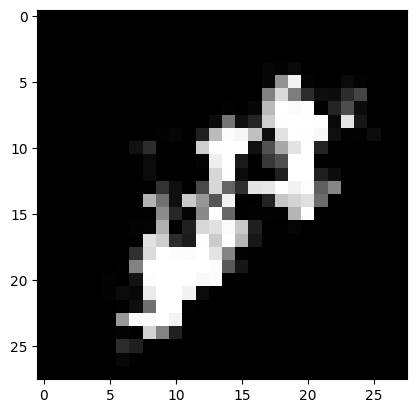

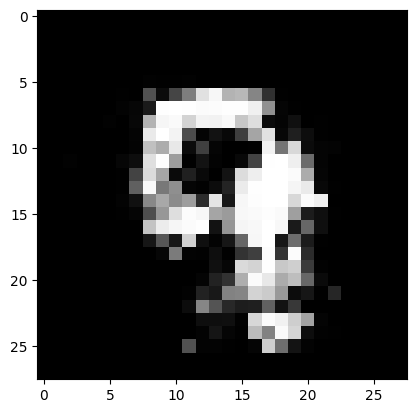

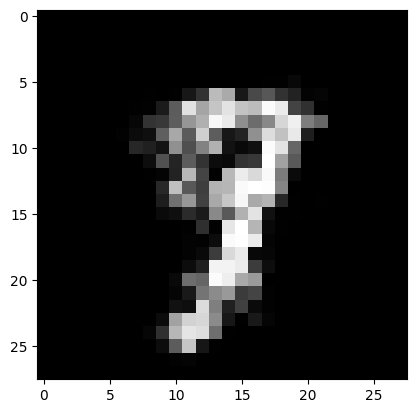

Epoch: 32550
loss_g: 0.9763650298118591 	loss_d: 1.2400867938995361
Epoch: 32600
loss_g: 0.8999885320663452 	loss_d: 1.2394578456878662
Epoch: 32650
loss_g: 0.8900798559188843 	loss_d: 1.1623395681381226
Epoch: 32700
loss_g: 0.9580501317977905 	loss_d: 1.1843559741973877
Epoch: 32750
loss_g: 1.0123552083969116 	loss_d: 1.2220861911773682
Epoch: 32800
loss_g: 0.8958308696746826 	loss_d: 1.288686752319336
Epoch: 32850
loss_g: 0.8395669460296631 	loss_d: 1.3834946155548096
Epoch: 32900
loss_g: 0.9522597193717957 	loss_d: 1.2928669452667236
Epoch: 32950
loss_g: 0.9817510843276978 	loss_d: 1.2670986652374268
Epoch: 33000
loss_g: 0.9556165933609009 	loss_d: 1.218977451324463


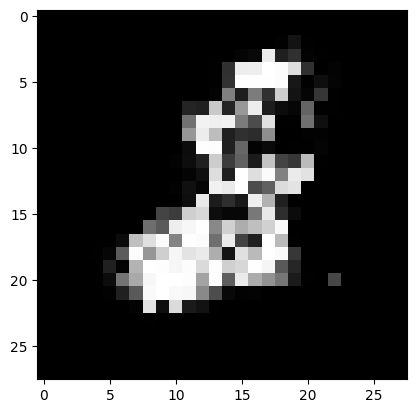

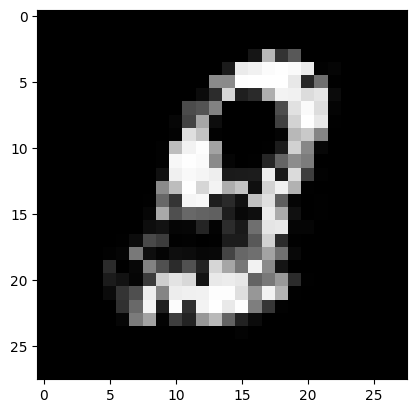

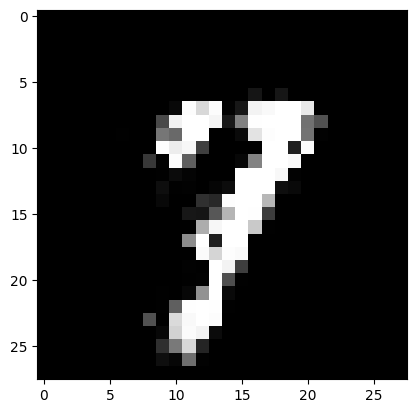

Epoch: 33050
loss_g: 0.9656997323036194 	loss_d: 1.2000563144683838
Epoch: 33100
loss_g: 0.9895086288452148 	loss_d: 1.2228074073791504
Epoch: 33150
loss_g: 0.9075737595558167 	loss_d: 1.2780476808547974
Epoch: 33200
loss_g: 0.8923426866531372 	loss_d: 1.232540249824524
Epoch: 33250
loss_g: 0.9180320501327515 	loss_d: 1.317358136177063
Epoch: 33300
loss_g: 0.8021189570426941 	loss_d: 1.29801344871521
Epoch: 33350
loss_g: 0.8947116136550903 	loss_d: 1.245437502861023
Epoch: 33400
loss_g: 0.9659746885299683 	loss_d: 1.2460553646087646
Epoch: 33450
loss_g: 0.8935542106628418 	loss_d: 1.292614459991455
Epoch: 33500
loss_g: 0.88954097032547 	loss_d: 1.3276607990264893


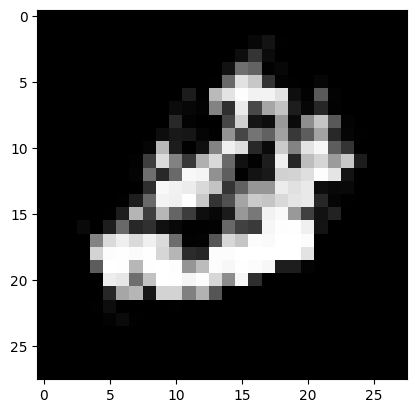

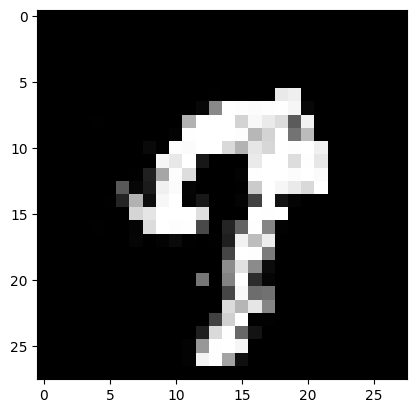

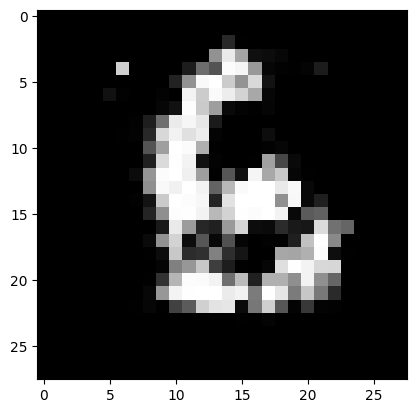

Epoch: 33550
loss_g: 0.9023892283439636 	loss_d: 1.37199068069458
Epoch: 33600
loss_g: 0.8846137523651123 	loss_d: 1.3972866535186768
Epoch: 33650
loss_g: 0.842414915561676 	loss_d: 1.2942792177200317
Epoch: 33700
loss_g: 1.0167285203933716 	loss_d: 1.3352495431900024
Epoch: 33750
loss_g: 0.988179624080658 	loss_d: 1.2325814962387085
Epoch: 33800
loss_g: 0.8668272495269775 	loss_d: 1.2832045555114746
Epoch: 33850
loss_g: 0.9946274161338806 	loss_d: 1.2021994590759277
Epoch: 33900
loss_g: 0.9392867088317871 	loss_d: 1.2701767683029175
Epoch: 33950
loss_g: 0.8504987955093384 	loss_d: 1.3357524871826172
Epoch: 34000
loss_g: 0.90081787109375 	loss_d: 1.2964637279510498


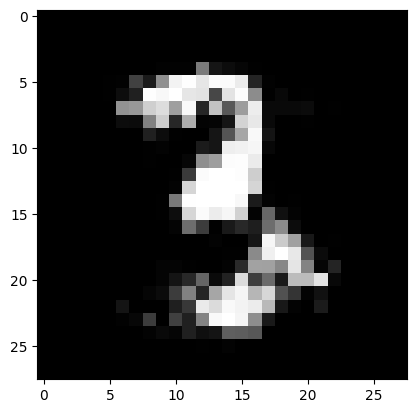

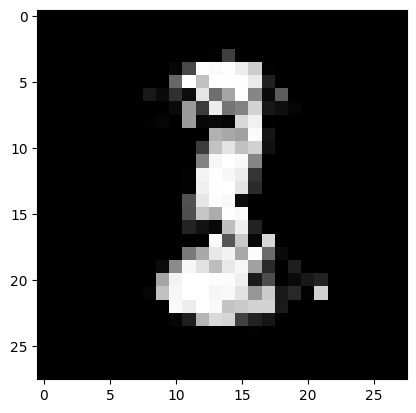

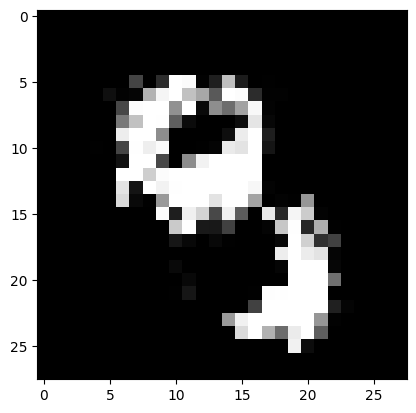

Epoch: 34050
loss_g: 0.7909116744995117 	loss_d: 1.348306655883789
Epoch: 34100
loss_g: 0.9098326563835144 	loss_d: 1.4612672328948975
Epoch: 34150
loss_g: 0.8996699452400208 	loss_d: 1.3476749658584595
Epoch: 34200
loss_g: 0.8261305093765259 	loss_d: 1.3891682624816895
Epoch: 34250
loss_g: 0.9974921941757202 	loss_d: 1.3283228874206543
Epoch: 34300
loss_g: 0.842530369758606 	loss_d: 1.4408235549926758
Epoch: 34350
loss_g: 0.9098110795021057 	loss_d: 1.3644872903823853
Epoch: 34400
loss_g: 0.9319784045219421 	loss_d: 1.2415683269500732
Epoch: 34450
loss_g: 0.8733441233634949 	loss_d: 1.3535231351852417
Epoch: 34500
loss_g: 0.8885932564735413 	loss_d: 1.263089656829834


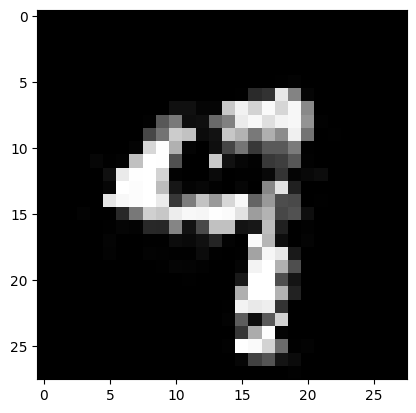

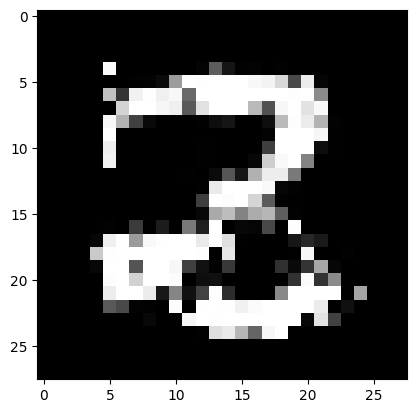

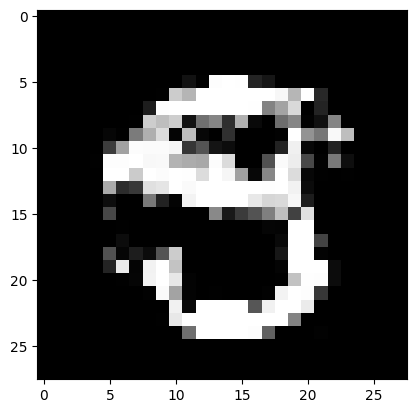

Epoch: 34550
loss_g: 0.9820785522460938 	loss_d: 1.3406445980072021
Epoch: 34600
loss_g: 0.8632380366325378 	loss_d: 1.2313873767852783
Epoch: 34650
loss_g: 0.8396598100662231 	loss_d: 1.3128113746643066
Epoch: 34700
loss_g: 0.8331257700920105 	loss_d: 1.2148115634918213
Epoch: 34750
loss_g: 0.9659051299095154 	loss_d: 1.2487146854400635
Epoch: 34800
loss_g: 0.9097340106964111 	loss_d: 1.2678704261779785
Epoch: 34850
loss_g: 0.859419584274292 	loss_d: 1.2893471717834473
Epoch: 34900
loss_g: 0.8281788229942322 	loss_d: 1.4490084648132324
Epoch: 34950
loss_g: 0.827166736125946 	loss_d: 1.2679694890975952
Epoch: 35000
loss_g: 0.8764772415161133 	loss_d: 1.3594799041748047


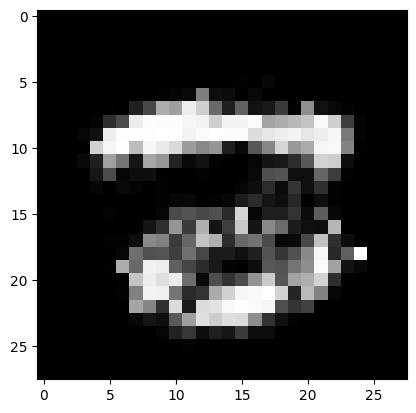

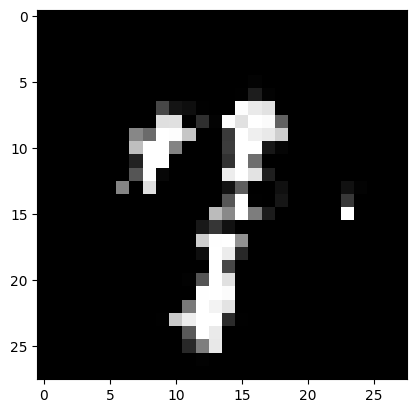

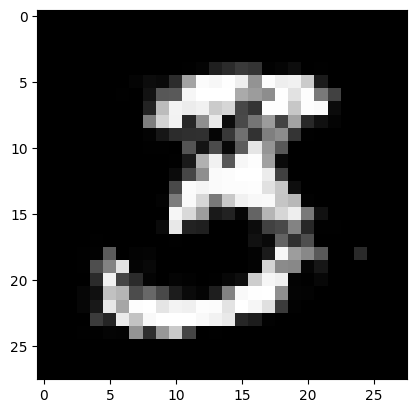

Epoch: 35050
loss_g: 0.8473606705665588 	loss_d: 1.259934902191162
Epoch: 35100
loss_g: 0.8869414925575256 	loss_d: 1.2506217956542969
Epoch: 35150
loss_g: 0.8814489841461182 	loss_d: 1.3464300632476807
Epoch: 35200
loss_g: 0.8484320044517517 	loss_d: 1.3775289058685303
Epoch: 35250
loss_g: 0.838030993938446 	loss_d: 1.31886887550354
Epoch: 35300
loss_g: 0.8286581039428711 	loss_d: 1.2653096914291382
Epoch: 35350
loss_g: 0.8020321726799011 	loss_d: 1.2785124778747559
Epoch: 35400
loss_g: 0.8260467052459717 	loss_d: 1.300234079360962
Epoch: 35450
loss_g: 0.8784919381141663 	loss_d: 1.3261430263519287
Epoch: 35500
loss_g: 0.9328658580780029 	loss_d: 1.3230544328689575


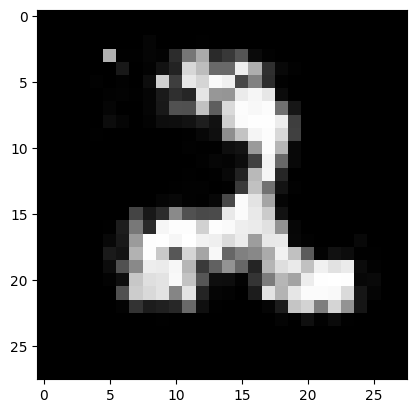

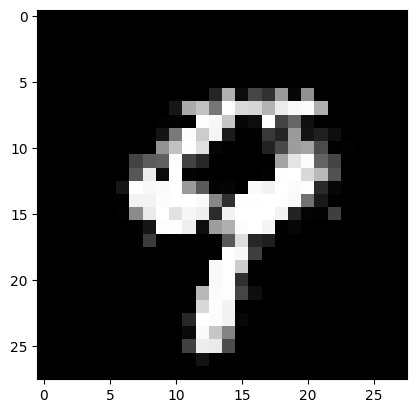

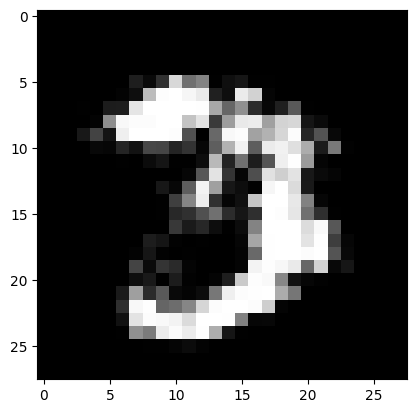

Epoch: 35550
loss_g: 0.8085474371910095 	loss_d: 1.437473177909851
Epoch: 35600
loss_g: 0.8058589100837708 	loss_d: 1.2708454132080078
Epoch: 35650
loss_g: 0.9575262069702148 	loss_d: 1.293460726737976
Epoch: 35700
loss_g: 0.8211567401885986 	loss_d: 1.321228265762329
Epoch: 35750
loss_g: 0.8383579254150391 	loss_d: 1.2372732162475586
Epoch: 35800
loss_g: 0.8860030770301819 	loss_d: 1.2192022800445557
Epoch: 35850
loss_g: 0.863220751285553 	loss_d: 1.3975846767425537
Epoch: 35900
loss_g: 0.8880248069763184 	loss_d: 1.2871016263961792
Epoch: 35950
loss_g: 1.0101268291473389 	loss_d: 1.2008652687072754
Epoch: 36000
loss_g: 0.876564621925354 	loss_d: 1.3452227115631104


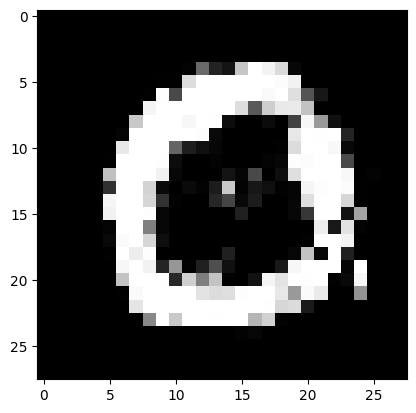

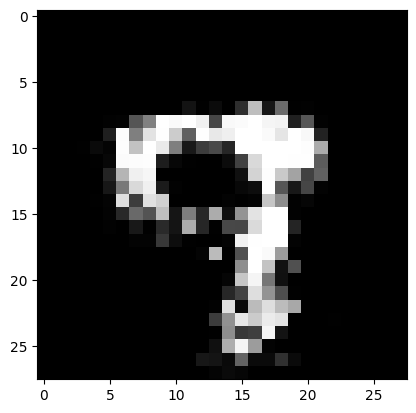

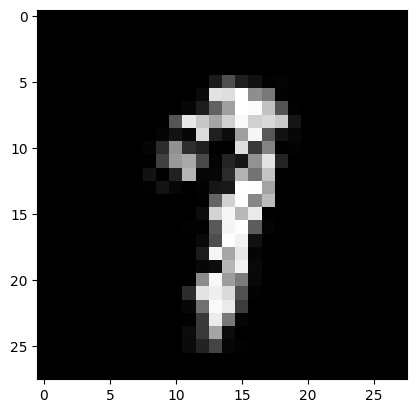

Epoch: 36050
loss_g: 0.8379107713699341 	loss_d: 1.284226417541504
Epoch: 36100
loss_g: 0.8428955078125 	loss_d: 1.3271256685256958
Epoch: 36150
loss_g: 0.8713251948356628 	loss_d: 1.2210009098052979
Epoch: 36200
loss_g: 0.9080182909965515 	loss_d: 1.2655792236328125
Epoch: 36250
loss_g: 0.8408911228179932 	loss_d: 1.3307898044586182
Epoch: 36300
loss_g: 0.8015261888504028 	loss_d: 1.4609624147415161
Epoch: 36350
loss_g: 0.8687670230865479 	loss_d: 1.2906444072723389
Epoch: 36400
loss_g: 0.9553596377372742 	loss_d: 1.3093459606170654
Epoch: 36450
loss_g: 0.9790012836456299 	loss_d: 1.2280523777008057
Epoch: 36500
loss_g: 0.9462231993675232 	loss_d: 1.1925859451293945


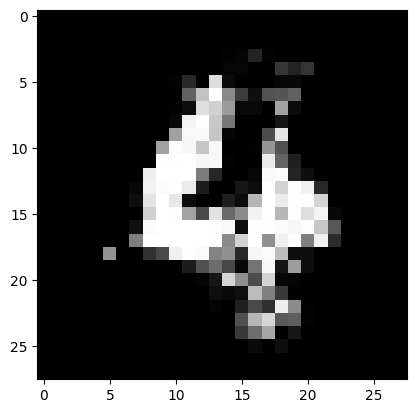

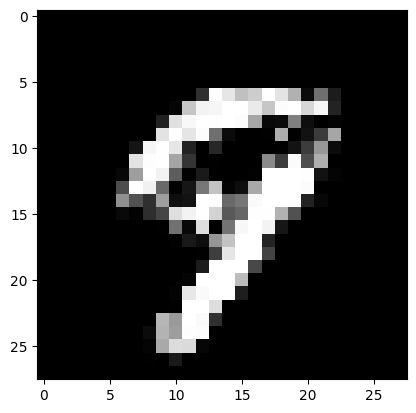

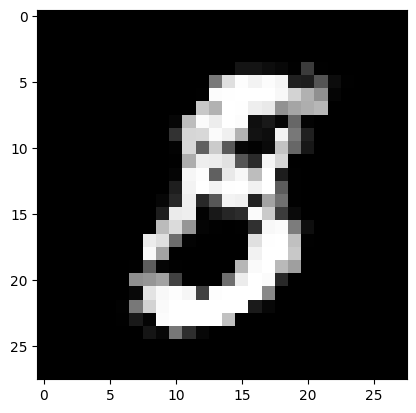

Epoch: 36550
loss_g: 0.8185275197029114 	loss_d: 1.3676581382751465
Epoch: 36600
loss_g: 0.8233585953712463 	loss_d: 1.2701091766357422
Epoch: 36650
loss_g: 0.8201656937599182 	loss_d: 1.2994487285614014
Epoch: 36700
loss_g: 0.8141052722930908 	loss_d: 1.300368070602417
Epoch: 36750
loss_g: 0.9423733949661255 	loss_d: 1.3703219890594482
Epoch: 36800
loss_g: 0.8477294445037842 	loss_d: 1.4046630859375
Epoch: 36850
loss_g: 0.8414801359176636 	loss_d: 1.38796067237854
Epoch: 36900
loss_g: 0.9275495409965515 	loss_d: 1.3336009979248047
Epoch: 36950
loss_g: 0.8562947511672974 	loss_d: 1.1657896041870117
Epoch: 37000
loss_g: 0.9411119818687439 	loss_d: 1.2866592407226562


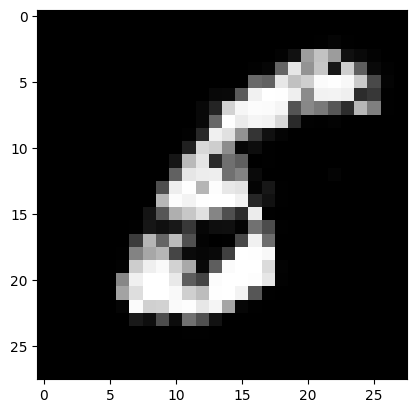

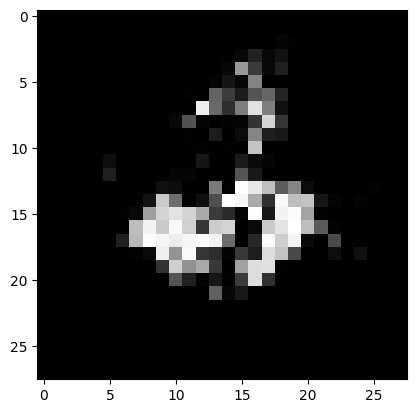

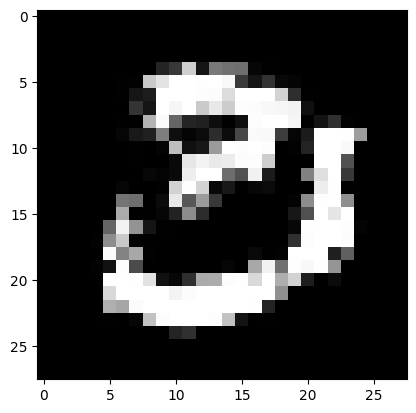

Epoch: 37050
loss_g: 0.8961504697799683 	loss_d: 1.3468127250671387
Epoch: 37100
loss_g: 0.8395571708679199 	loss_d: 1.3352923393249512
Epoch: 37150
loss_g: 0.8259687423706055 	loss_d: 1.2097537517547607
Epoch: 37200
loss_g: 0.8752944469451904 	loss_d: 1.280642032623291
Epoch: 37250
loss_g: 0.933543860912323 	loss_d: 1.3328711986541748
Epoch: 37300
loss_g: 0.7818263173103333 	loss_d: 1.3120474815368652
Epoch: 37350
loss_g: 0.9175001382827759 	loss_d: 1.2561994791030884
Epoch: 37400
loss_g: 0.8182241916656494 	loss_d: 1.2637109756469727
Epoch: 37450
loss_g: 0.8591368198394775 	loss_d: 1.225271463394165
Epoch: 37500
loss_g: 0.9137282371520996 	loss_d: 1.2802724838256836


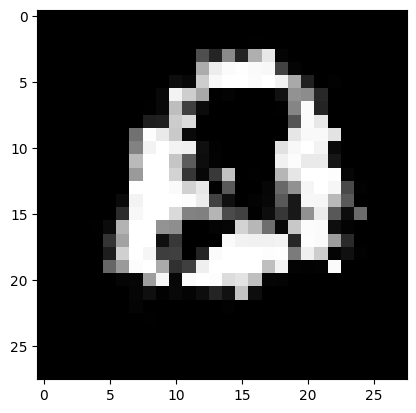

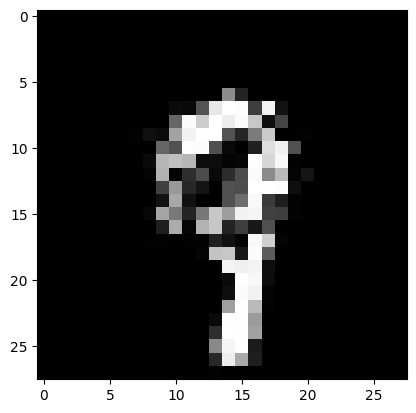

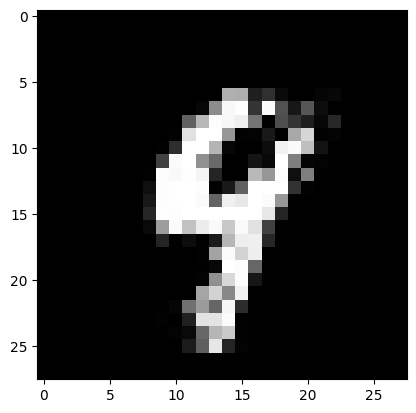

Epoch: 37550
loss_g: 0.8298059701919556 	loss_d: 1.31431245803833
Epoch: 37600
loss_g: 0.8921594619750977 	loss_d: 1.3027503490447998
Epoch: 37650
loss_g: 0.8391746878623962 	loss_d: 1.2985035181045532
Epoch: 37700
loss_g: 0.9510935544967651 	loss_d: 1.3131537437438965
Epoch: 37750
loss_g: 0.8553282022476196 	loss_d: 1.3024852275848389
Epoch: 37800
loss_g: 0.8701701164245605 	loss_d: 1.3629722595214844
Epoch: 37850
loss_g: 0.7854377031326294 	loss_d: 1.3560194969177246
Epoch: 37900
loss_g: 0.8630361557006836 	loss_d: 1.2312045097351074
Epoch: 37950
loss_g: 0.8953267335891724 	loss_d: 1.369425654411316
Epoch: 38000
loss_g: 0.9320181012153625 	loss_d: 1.3960720300674438


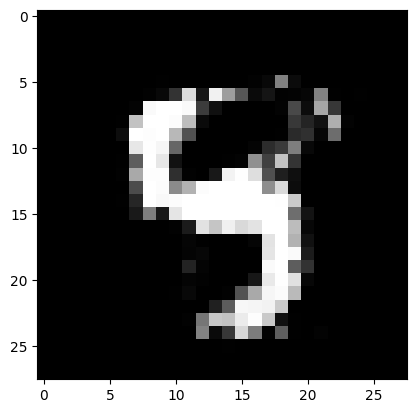

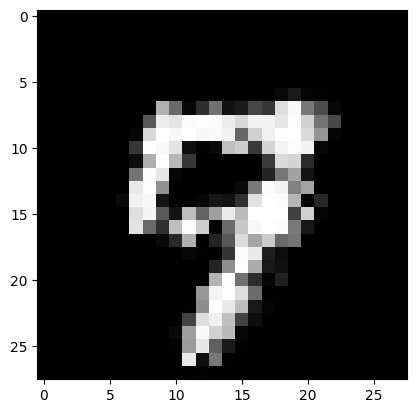

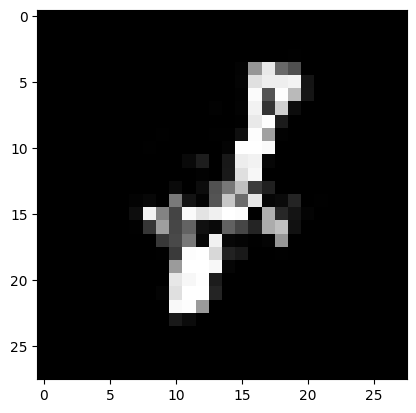

Epoch: 38050
loss_g: 0.9132647514343262 	loss_d: 1.3098716735839844
Epoch: 38100
loss_g: 0.8509424924850464 	loss_d: 1.2388725280761719
Epoch: 38150
loss_g: 0.815456211566925 	loss_d: 1.3284738063812256
Epoch: 38200
loss_g: 0.7827369570732117 	loss_d: 1.3271379470825195
Epoch: 38250
loss_g: 0.8477671146392822 	loss_d: 1.4185006618499756
Epoch: 38300
loss_g: 0.8680018186569214 	loss_d: 1.3215768337249756
Epoch: 38350
loss_g: 0.8867044448852539 	loss_d: 1.3196642398834229
Epoch: 38400
loss_g: 0.8731022477149963 	loss_d: 1.3279774188995361
Epoch: 38450
loss_g: 0.8558132648468018 	loss_d: 1.264035701751709
Epoch: 38500
loss_g: 0.8679681420326233 	loss_d: 1.3514647483825684


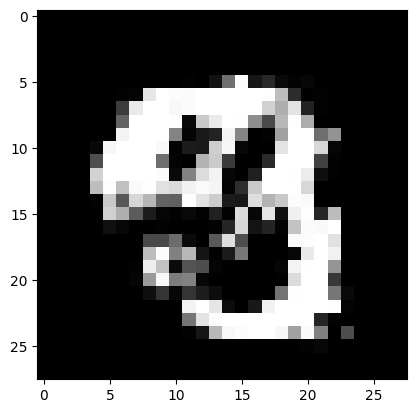

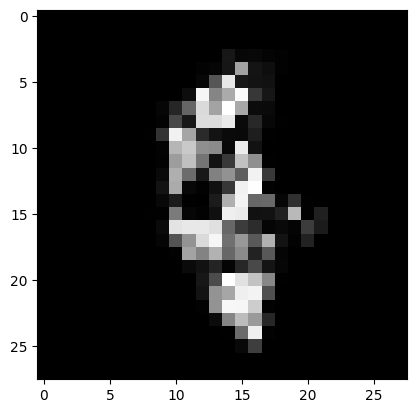

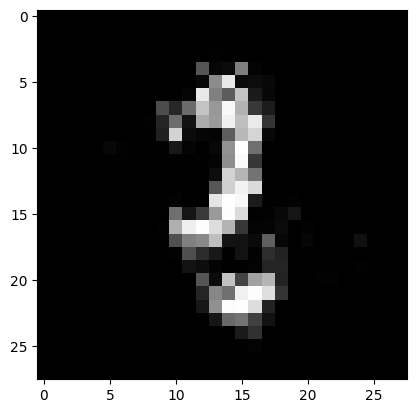

Epoch: 38550
loss_g: 0.8677122592926025 	loss_d: 1.2377498149871826
Epoch: 38600
loss_g: 0.901721179485321 	loss_d: 1.2792996168136597
Epoch: 38650
loss_g: 0.7928993105888367 	loss_d: 1.2760725021362305
Epoch: 38700
loss_g: 0.9253455996513367 	loss_d: 1.3692400455474854
Epoch: 38750
loss_g: 0.8422644138336182 	loss_d: 1.302886724472046
Epoch: 38800
loss_g: 0.9128161668777466 	loss_d: 1.3024394512176514
Epoch: 38850
loss_g: 0.7817080616950989 	loss_d: 1.3563759326934814
Epoch: 38900
loss_g: 0.789641797542572 	loss_d: 1.3396177291870117
Epoch: 38950
loss_g: 0.8592008948326111 	loss_d: 1.3741750717163086
Epoch: 39000
loss_g: 0.79156494140625 	loss_d: 1.303983211517334


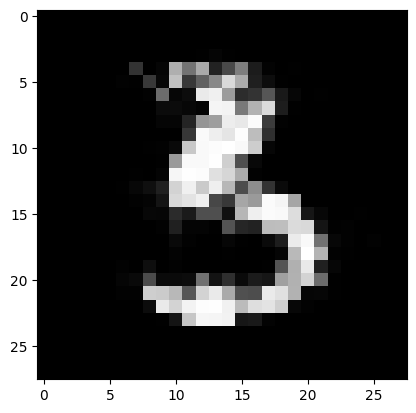

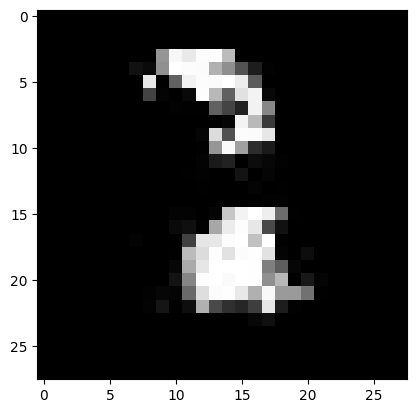

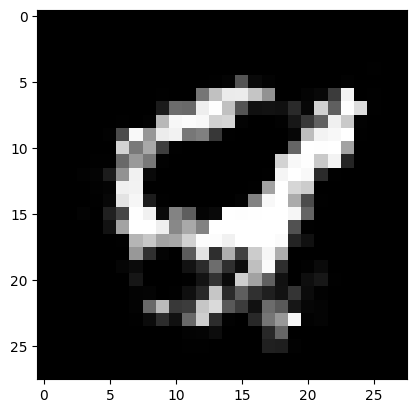

Epoch: 39050
loss_g: 0.8489456176757812 	loss_d: 1.2980337142944336
Epoch: 39100
loss_g: 0.8945517539978027 	loss_d: 1.3971147537231445
Epoch: 39150
loss_g: 0.8211732506752014 	loss_d: 1.34598708152771
Epoch: 39200
loss_g: 0.7935676574707031 	loss_d: 1.3694040775299072
Epoch: 39250
loss_g: 0.8758760094642639 	loss_d: 1.3532450199127197
Epoch: 39300
loss_g: 0.9363111853599548 	loss_d: 1.2740769386291504
Epoch: 39350
loss_g: 0.8753992915153503 	loss_d: 1.2199745178222656
Epoch: 39400
loss_g: 0.8624027967453003 	loss_d: 1.2690656185150146
Epoch: 39450
loss_g: 0.8097312450408936 	loss_d: 1.3570499420166016
Epoch: 39500
loss_g: 0.7832066416740417 	loss_d: 1.2906763553619385


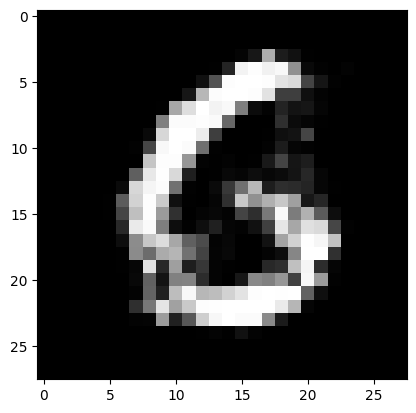

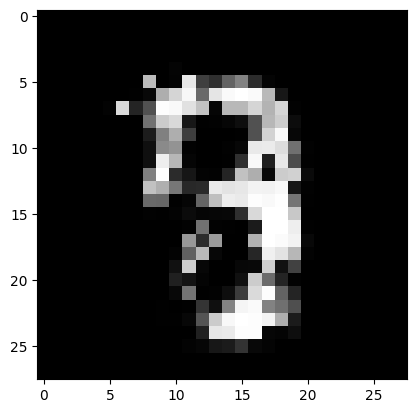

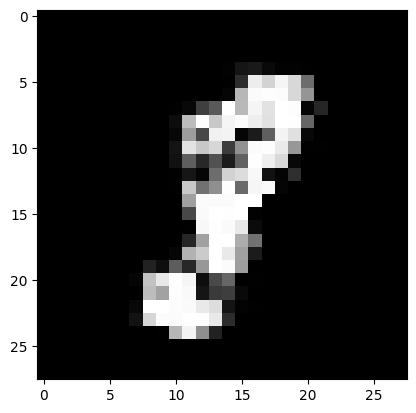

Epoch: 39550
loss_g: 0.9335780143737793 	loss_d: 1.3452229499816895
Epoch: 39600
loss_g: 0.7953349351882935 	loss_d: 1.3279163837432861
Epoch: 39650
loss_g: 0.8233920931816101 	loss_d: 1.2599890232086182
Epoch: 39700
loss_g: 0.8868495225906372 	loss_d: 1.268235206604004
Epoch: 39750
loss_g: 0.8555917143821716 	loss_d: 1.3409349918365479
Epoch: 39800
loss_g: 0.8729695081710815 	loss_d: 1.1935830116271973
Epoch: 39850
loss_g: 0.8831450939178467 	loss_d: 1.3976259231567383
Epoch: 39900
loss_g: 0.8185859322547913 	loss_d: 1.3745620250701904
Epoch: 39950
loss_g: 0.8631101846694946 	loss_d: 1.3543705940246582
Epoch: 40000
loss_g: 0.8292070031166077 	loss_d: 1.324268102645874


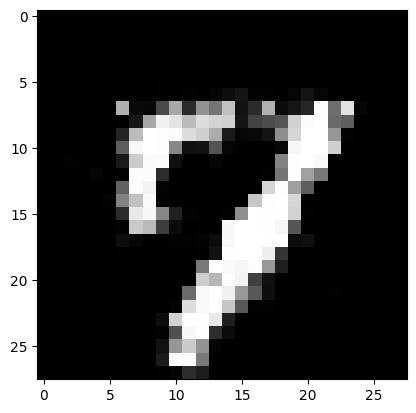

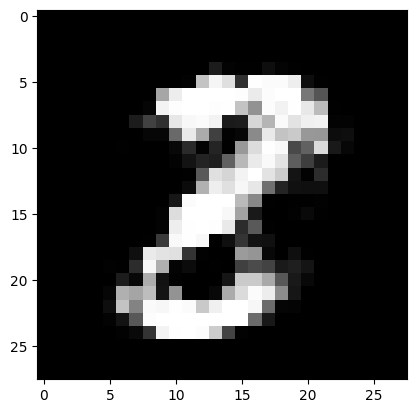

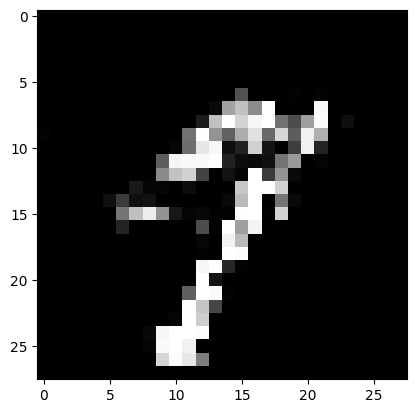

Epoch: 40050
loss_g: 0.8254769444465637 	loss_d: 1.374593734741211
Epoch: 40100
loss_g: 0.8461682200431824 	loss_d: 1.3068197965621948
Epoch: 40150
loss_g: 0.8633289933204651 	loss_d: 1.341578483581543
Epoch: 40200
loss_g: 0.8516549468040466 	loss_d: 1.211043119430542
Epoch: 40250
loss_g: 0.9418812990188599 	loss_d: 1.2840759754180908
Epoch: 40300
loss_g: 0.757086455821991 	loss_d: 1.3311736583709717
Epoch: 40350
loss_g: 0.8240095376968384 	loss_d: 1.3561432361602783
Epoch: 40400
loss_g: 0.7955343723297119 	loss_d: 1.2569646835327148
Epoch: 40450
loss_g: 0.769069492816925 	loss_d: 1.2772376537322998
Epoch: 40500
loss_g: 0.840717613697052 	loss_d: 1.2587894201278687


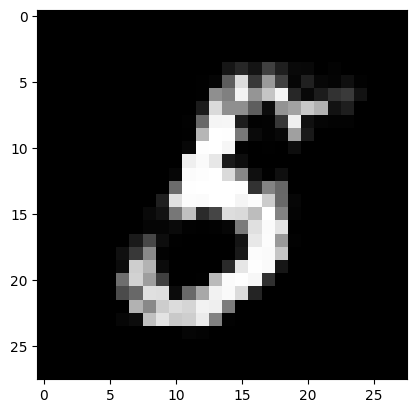

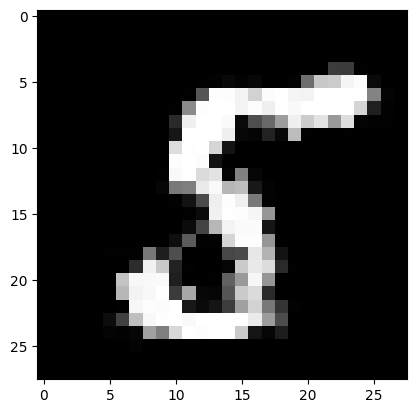

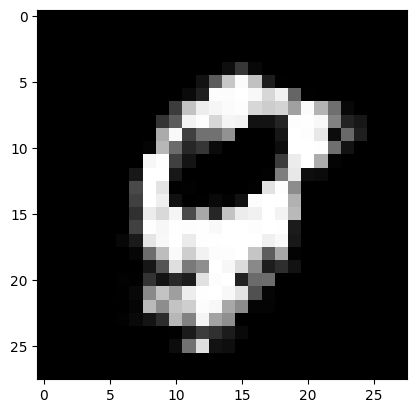

Epoch: 40550
loss_g: 0.7521339058876038 	loss_d: 1.275376558303833
Epoch: 40600
loss_g: 0.7849434018135071 	loss_d: 1.3498539924621582
Epoch: 40650
loss_g: 0.9589536786079407 	loss_d: 1.2901670932769775
Epoch: 40700
loss_g: 0.9285812377929688 	loss_d: 1.2657480239868164
Epoch: 40750
loss_g: 0.8857375979423523 	loss_d: 1.2771759033203125
Epoch: 40800
loss_g: 0.8019648790359497 	loss_d: 1.3419256210327148
Epoch: 40850
loss_g: 0.8932449221611023 	loss_d: 1.2303661108016968
Epoch: 40900
loss_g: 0.9548152685165405 	loss_d: 1.2790069580078125
Epoch: 40950
loss_g: 0.804874837398529 	loss_d: 1.3452858924865723
Epoch: 41000
loss_g: 0.7948246598243713 	loss_d: 1.326738715171814


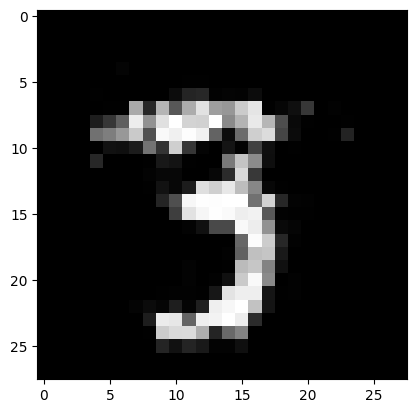

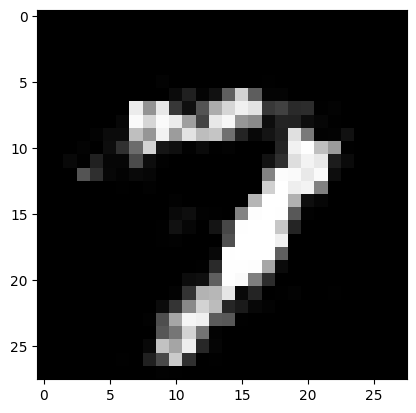

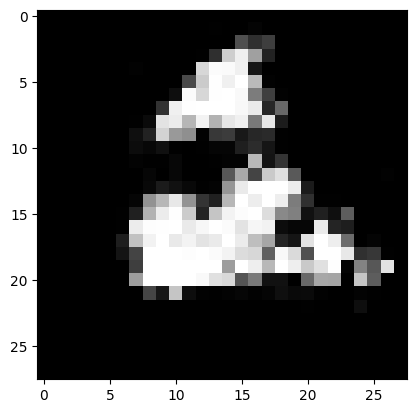

Epoch: 41050
loss_g: 0.8897239565849304 	loss_d: 1.2817968130111694
Epoch: 41100
loss_g: 0.7391415238380432 	loss_d: 1.2669155597686768
Epoch: 41150
loss_g: 0.8129652738571167 	loss_d: 1.3167827129364014
Epoch: 41200
loss_g: 0.8297498822212219 	loss_d: 1.286783218383789
Epoch: 41250
loss_g: 0.7829742431640625 	loss_d: 1.3382006883621216
Epoch: 41300
loss_g: 0.8368470668792725 	loss_d: 1.3481388092041016
Epoch: 41350
loss_g: 0.8202471733093262 	loss_d: 1.310375690460205
Epoch: 41400
loss_g: 0.8771169781684875 	loss_d: 1.309014081954956
Epoch: 41450
loss_g: 0.904861569404602 	loss_d: 1.259953260421753
Epoch: 41500
loss_g: 0.8752685189247131 	loss_d: 1.2906229496002197


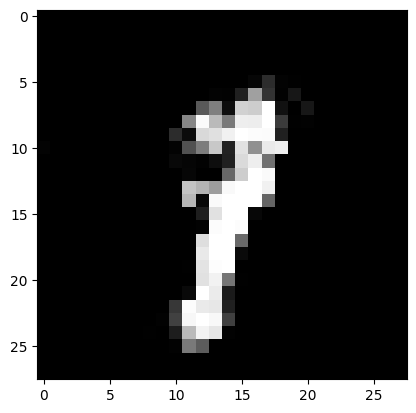

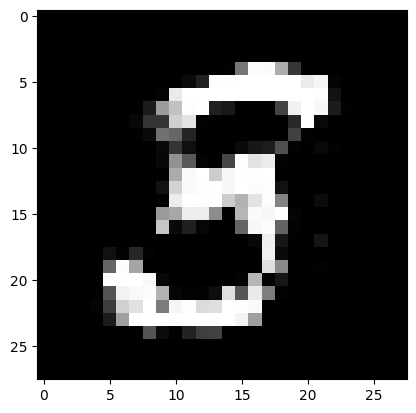

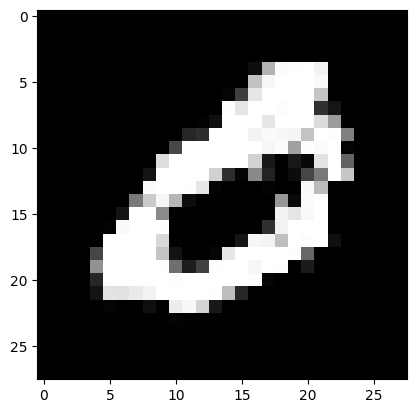

Epoch: 41550
loss_g: 0.8596212863922119 	loss_d: 1.272128701210022
Epoch: 41600
loss_g: 0.8809020519256592 	loss_d: 1.2959163188934326
Epoch: 41650
loss_g: 0.8663636445999146 	loss_d: 1.2476272583007812
Epoch: 41700
loss_g: 0.8155354261398315 	loss_d: 1.3006932735443115
Epoch: 41750
loss_g: 0.8097155094146729 	loss_d: 1.3501404523849487
Epoch: 41800
loss_g: 0.8789793848991394 	loss_d: 1.4072258472442627
Epoch: 41850
loss_g: 0.8704302906990051 	loss_d: 1.2335186004638672
Epoch: 41900
loss_g: 0.8357041478157043 	loss_d: 1.343951940536499
Epoch: 41950
loss_g: 0.7667244076728821 	loss_d: 1.3085142374038696
Epoch: 42000
loss_g: 0.9253936409950256 	loss_d: 1.3592623472213745


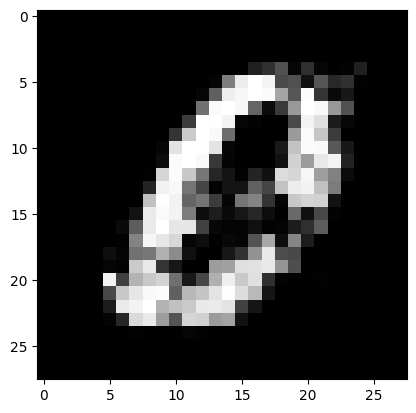

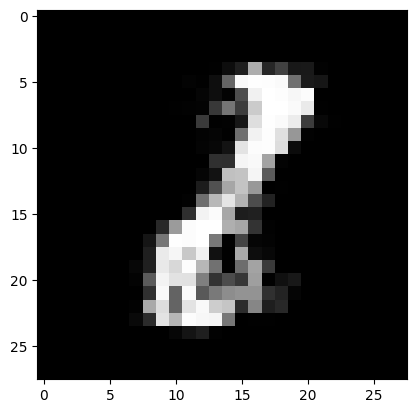

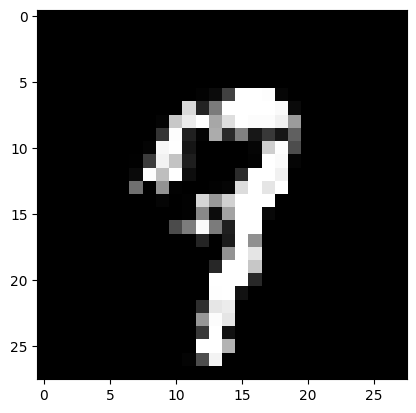

Epoch: 42050
loss_g: 0.8087882995605469 	loss_d: 1.335160255432129
Epoch: 42100
loss_g: 0.7819966077804565 	loss_d: 1.3519800901412964
Epoch: 42150
loss_g: 0.877348780632019 	loss_d: 1.306626796722412
Epoch: 42200
loss_g: 0.8816249370574951 	loss_d: 1.247573971748352
Epoch: 42250
loss_g: 0.8617082238197327 	loss_d: 1.3305754661560059
Epoch: 42300
loss_g: 0.8964986801147461 	loss_d: 1.3600051403045654
Epoch: 42350
loss_g: 0.9031500220298767 	loss_d: 1.4123640060424805
Epoch: 42400
loss_g: 0.8108073472976685 	loss_d: 1.2670775651931763
Epoch: 42450
loss_g: 0.8213090300559998 	loss_d: 1.2829296588897705
Epoch: 42500
loss_g: 0.8412718772888184 	loss_d: 1.2822506427764893


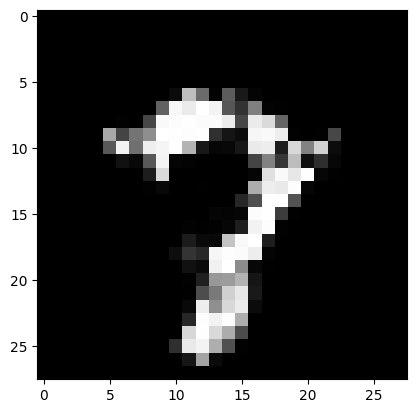

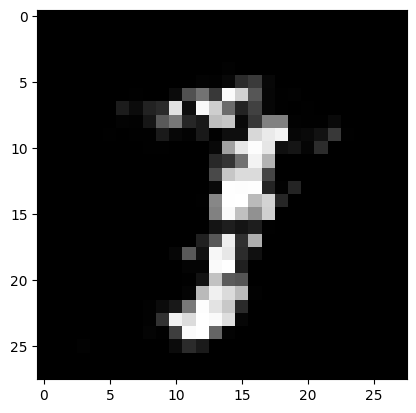

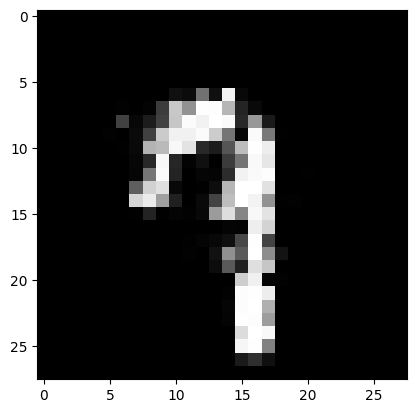

Epoch: 42550
loss_g: 0.8076100945472717 	loss_d: 1.3440351486206055
Epoch: 42600
loss_g: 0.8648924231529236 	loss_d: 1.4211162328720093
Epoch: 42650
loss_g: 0.8128775358200073 	loss_d: 1.3111224174499512
Epoch: 42700
loss_g: 0.8269017338752747 	loss_d: 1.359723687171936
Epoch: 42750
loss_g: 0.8332000374794006 	loss_d: 1.3438317775726318
Epoch: 42800
loss_g: 0.7863969206809998 	loss_d: 1.3616013526916504
Epoch: 42850
loss_g: 0.8625311255455017 	loss_d: 1.3795006275177002
Epoch: 42900
loss_g: 0.9170913696289062 	loss_d: 1.3568203449249268
Epoch: 42950
loss_g: 0.8239647746086121 	loss_d: 1.3678643703460693
Epoch: 43000
loss_g: 0.8831532597541809 	loss_d: 1.320737600326538


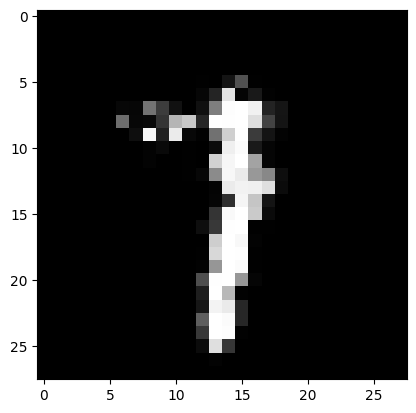

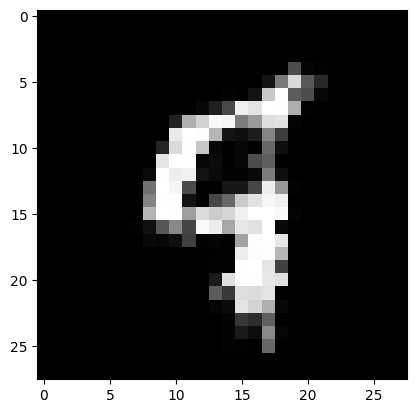

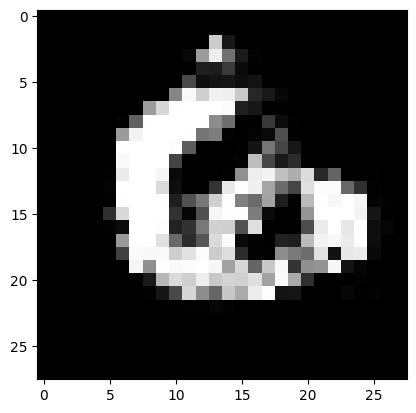

Epoch: 43050
loss_g: 0.8370912671089172 	loss_d: 1.2938625812530518
Epoch: 43100
loss_g: 0.769517719745636 	loss_d: 1.2864890098571777
Epoch: 43150
loss_g: 0.8626433610916138 	loss_d: 1.2723195552825928
Epoch: 43200
loss_g: 0.8276771306991577 	loss_d: 1.2659130096435547
Epoch: 43250
loss_g: 0.8162614107131958 	loss_d: 1.354027509689331
Epoch: 43300
loss_g: 0.900489330291748 	loss_d: 1.4021081924438477
Epoch: 43350
loss_g: 0.8408778309822083 	loss_d: 1.3138160705566406
Epoch: 43400
loss_g: 0.8526573777198792 	loss_d: 1.3818657398223877
Epoch: 43450
loss_g: 0.7763931751251221 	loss_d: 1.4150054454803467
Epoch: 43500
loss_g: 0.9557340741157532 	loss_d: 1.3315932750701904


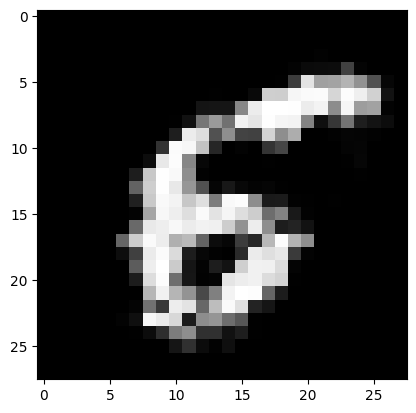

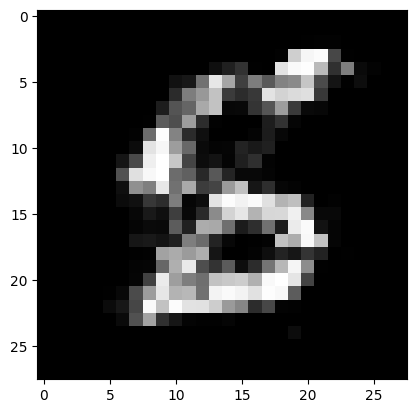

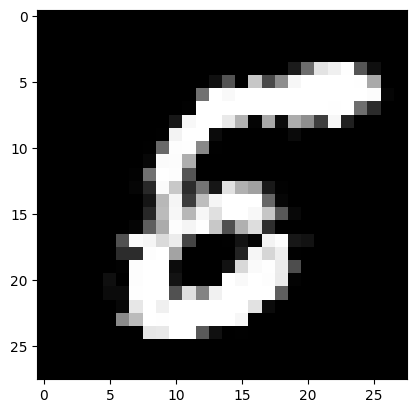

Epoch: 43550
loss_g: 0.795132577419281 	loss_d: 1.2600605487823486
Epoch: 43600
loss_g: 0.857583224773407 	loss_d: 1.3194434642791748
Epoch: 43650
loss_g: 0.8765003085136414 	loss_d: 1.3242757320404053
Epoch: 43700
loss_g: 0.9027532935142517 	loss_d: 1.373478889465332
Epoch: 43750
loss_g: 0.7860141396522522 	loss_d: 1.3211637735366821
Epoch: 43800
loss_g: 0.9045780897140503 	loss_d: 1.2763906717300415
Epoch: 43850
loss_g: 0.8295102715492249 	loss_d: 1.3332488536834717
Epoch: 43900
loss_g: 0.8214640617370605 	loss_d: 1.3055946826934814
Epoch: 43950
loss_g: 0.7422824501991272 	loss_d: 1.3308889865875244
Epoch: 44000
loss_g: 0.7611525058746338 	loss_d: 1.3159892559051514


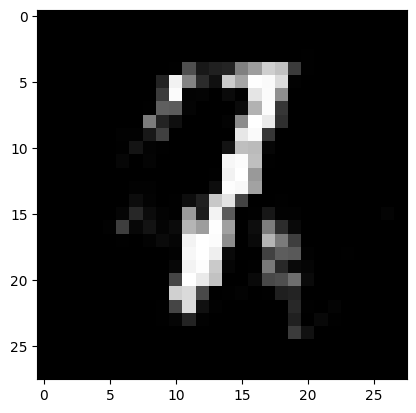

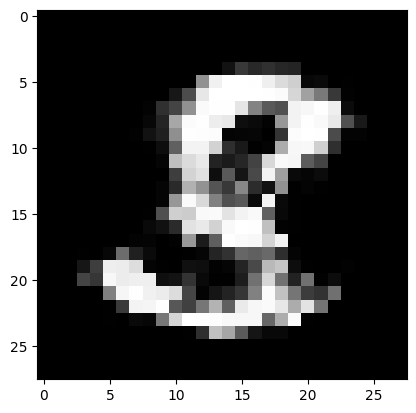

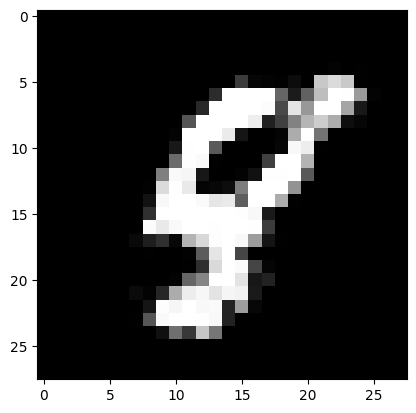

Epoch: 44050
loss_g: 0.7800775170326233 	loss_d: 1.2613956928253174
Epoch: 44100
loss_g: 0.7883872985839844 	loss_d: 1.3061856031417847
Epoch: 44150
loss_g: 0.9025922417640686 	loss_d: 1.356365442276001
Epoch: 44200
loss_g: 0.8188673853874207 	loss_d: 1.4279162883758545
Epoch: 44250
loss_g: 0.7882893681526184 	loss_d: 1.3312509059906006
Epoch: 44300
loss_g: 0.826257586479187 	loss_d: 1.3314917087554932
Epoch: 44350
loss_g: 0.8368232250213623 	loss_d: 1.3705239295959473
Epoch: 44400
loss_g: 0.8650739789009094 	loss_d: 1.3695640563964844
Epoch: 44450
loss_g: 0.7852745056152344 	loss_d: 1.3256314992904663
Epoch: 44500
loss_g: 0.845890462398529 	loss_d: 1.3331860303878784


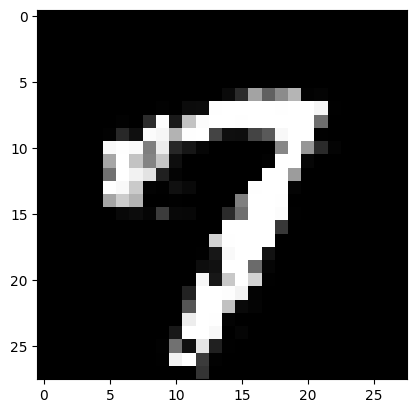

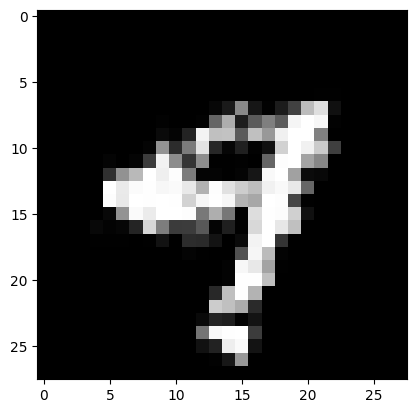

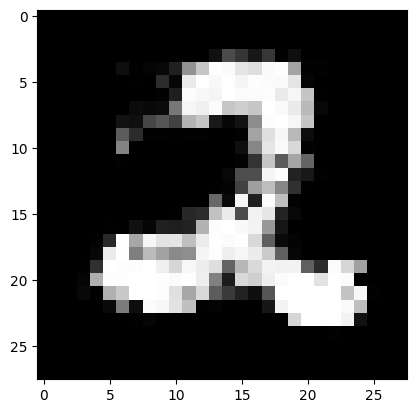

Epoch: 44550
loss_g: 0.7558016777038574 	loss_d: 1.3458596467971802
Epoch: 44600
loss_g: 0.9044170379638672 	loss_d: 1.2661246061325073
Epoch: 44650
loss_g: 0.9288622140884399 	loss_d: 1.286228895187378
Epoch: 44700
loss_g: 0.8238282799720764 	loss_d: 1.479740023612976
Epoch: 44750
loss_g: 0.8296735882759094 	loss_d: 1.3371186256408691
Epoch: 44800
loss_g: 0.8999727368354797 	loss_d: 1.3506168127059937
Epoch: 44850
loss_g: 0.8208871483802795 	loss_d: 1.2952572107315063
Epoch: 44900
loss_g: 0.8948591351509094 	loss_d: 1.3901832103729248
Epoch: 44950
loss_g: 0.764072835445404 	loss_d: 1.3255009651184082
Epoch: 45000
loss_g: 0.8110669255256653 	loss_d: 1.3256306648254395


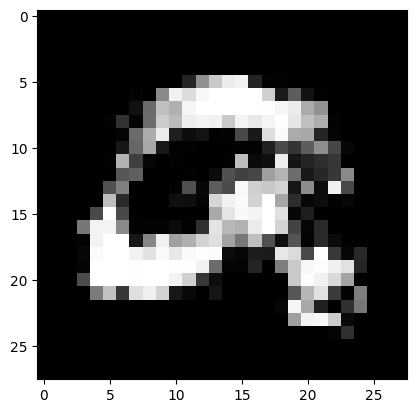

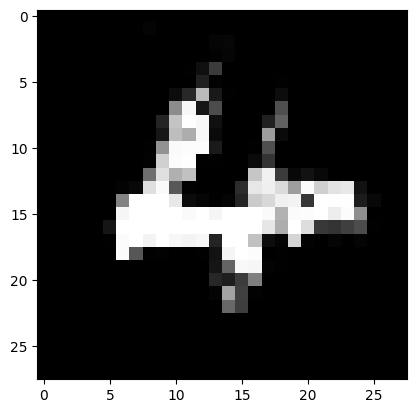

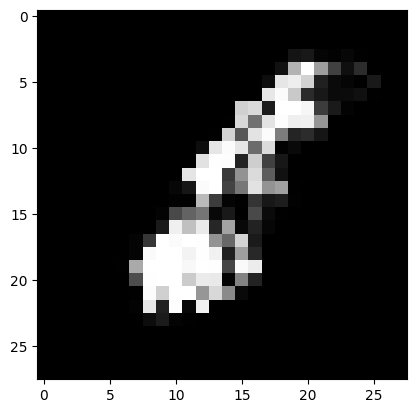

Epoch: 45050
loss_g: 0.7853420972824097 	loss_d: 1.3541245460510254
Epoch: 45100
loss_g: 0.8223176598548889 	loss_d: 1.3337223529815674
Epoch: 45150
loss_g: 0.7712163925170898 	loss_d: 1.4159862995147705
Epoch: 45200
loss_g: 0.7802571058273315 	loss_d: 1.361164927482605
Epoch: 45250
loss_g: 0.870657205581665 	loss_d: 1.3881388902664185
Epoch: 45300
loss_g: 0.7734920978546143 	loss_d: 1.2393310070037842
Epoch: 45350
loss_g: 0.7191363573074341 	loss_d: 1.3633272647857666
Epoch: 45400
loss_g: 0.8192338347434998 	loss_d: 1.316200852394104
Epoch: 45450
loss_g: 0.8077819347381592 	loss_d: 1.3484001159667969
Epoch: 45500
loss_g: 0.8439552187919617 	loss_d: 1.3150830268859863


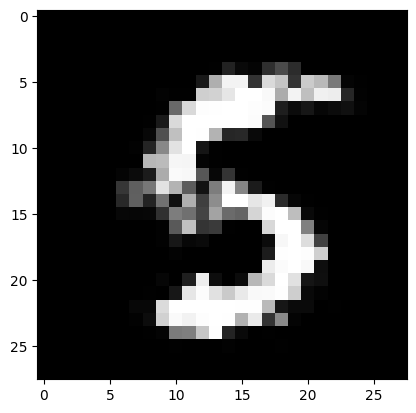

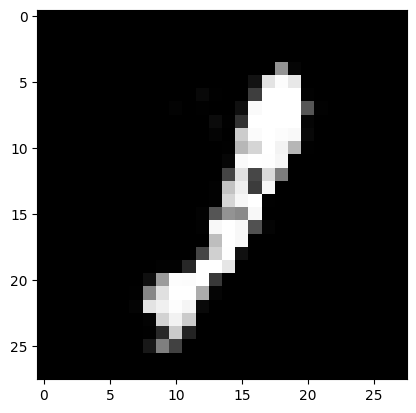

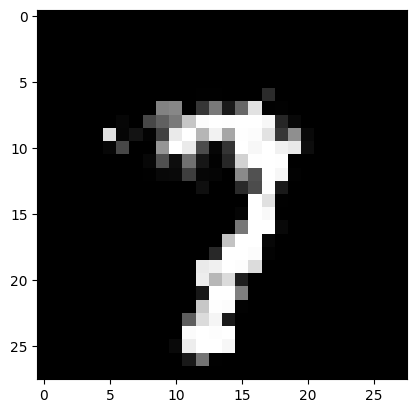

Epoch: 45550
loss_g: 0.8531701564788818 	loss_d: 1.2594507932662964
Epoch: 45600
loss_g: 0.799639105796814 	loss_d: 1.2961468696594238
Epoch: 45650
loss_g: 0.8459892272949219 	loss_d: 1.223128080368042
Epoch: 45700
loss_g: 0.8061005473136902 	loss_d: 1.2907464504241943
Epoch: 45750
loss_g: 0.8048730492591858 	loss_d: 1.3904309272766113
Epoch: 45800
loss_g: 0.7894187569618225 	loss_d: 1.2808711528778076
Epoch: 45850
loss_g: 0.7275962829589844 	loss_d: 1.3224623203277588
Epoch: 45900
loss_g: 0.8099219799041748 	loss_d: 1.3463557958602905
Epoch: 45950
loss_g: 0.7312483787536621 	loss_d: 1.304069995880127
Epoch: 46000
loss_g: 0.8217746615409851 	loss_d: 1.380651831626892


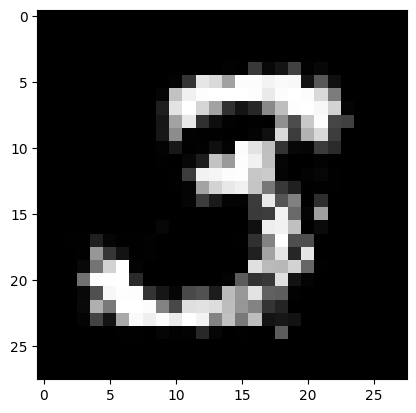

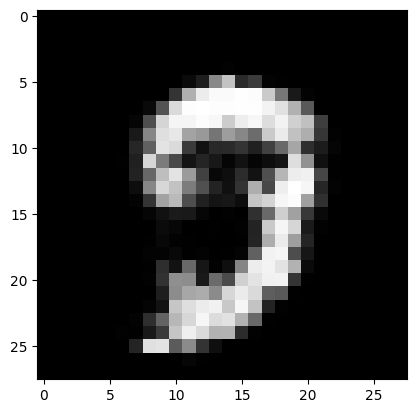

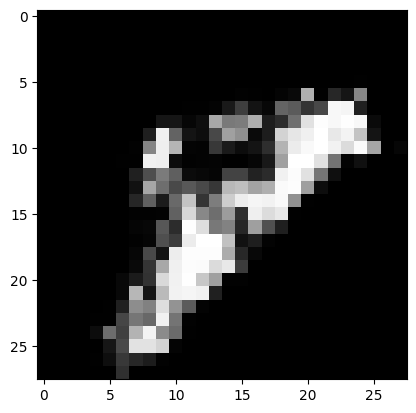

Epoch: 46050
loss_g: 0.7857605814933777 	loss_d: 1.3134812116622925
Epoch: 46100
loss_g: 0.8097044229507446 	loss_d: 1.2523870468139648
Epoch: 46150
loss_g: 0.7633580565452576 	loss_d: 1.4033043384552002
Epoch: 46200
loss_g: 0.7470529079437256 	loss_d: 1.410138487815857
Epoch: 46250
loss_g: 0.86207115650177 	loss_d: 1.349825143814087
Epoch: 46300
loss_g: 0.824202299118042 	loss_d: 1.3900890350341797
Epoch: 46350
loss_g: 0.7455667853355408 	loss_d: 1.3973510265350342
Epoch: 46400
loss_g: 0.8111954927444458 	loss_d: 1.2708444595336914
Epoch: 46450
loss_g: 0.8536887764930725 	loss_d: 1.2700626850128174
Epoch: 46500
loss_g: 0.7668496370315552 	loss_d: 1.2886358499526978


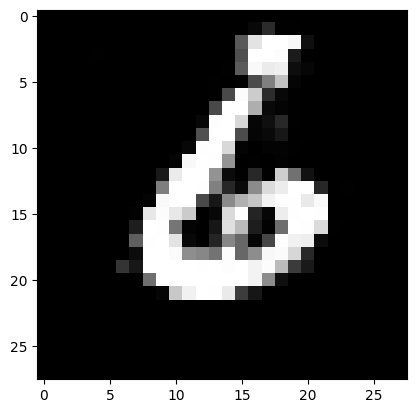

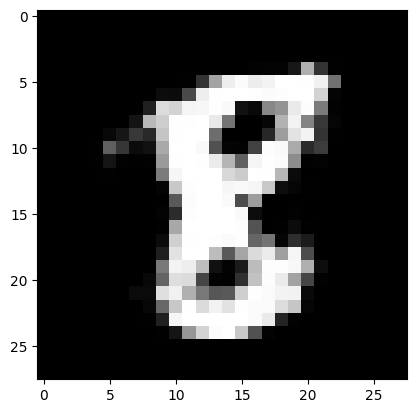

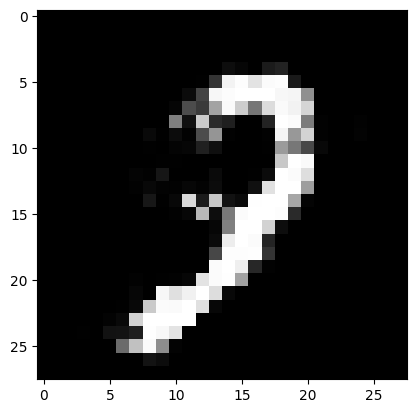

Epoch: 46550
loss_g: 0.815888524055481 	loss_d: 1.317099928855896
Epoch: 46600
loss_g: 0.797625720500946 	loss_d: 1.2722039222717285
Epoch: 46650
loss_g: 0.7708831429481506 	loss_d: 1.3355765342712402
Epoch: 46700
loss_g: 0.8277541399002075 	loss_d: 1.349081039428711
Epoch: 46750
loss_g: 0.8422800898551941 	loss_d: 1.3396912813186646
Epoch: 46800
loss_g: 0.762337863445282 	loss_d: 1.3089491128921509
Epoch: 46850
loss_g: 0.7870100736618042 	loss_d: 1.394159197807312
Epoch: 46900
loss_g: 0.7705487012863159 	loss_d: 1.2778593301773071
Epoch: 46950
loss_g: 0.8206607103347778 	loss_d: 1.225283145904541
Epoch: 47000
loss_g: 0.7791405916213989 	loss_d: 1.4286141395568848


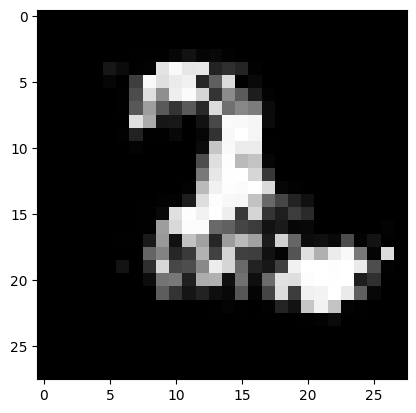

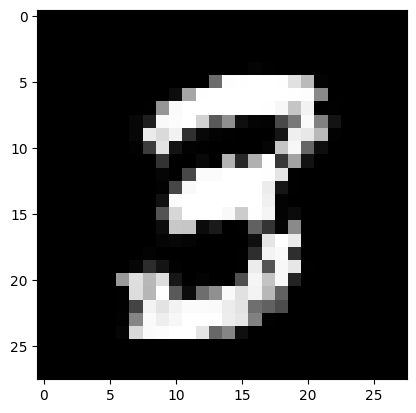

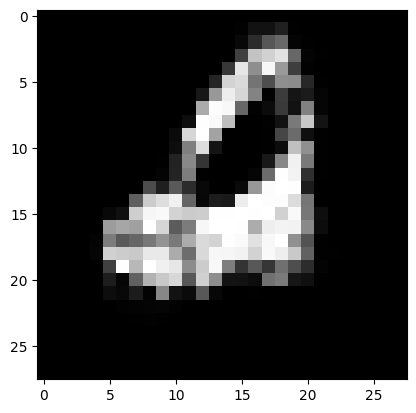

Epoch: 47050
loss_g: 0.7906734943389893 	loss_d: 1.3465831279754639
Epoch: 47100
loss_g: 0.7616177201271057 	loss_d: 1.3385823965072632
Epoch: 47150
loss_g: 0.7765593528747559 	loss_d: 1.3467633724212646
Epoch: 47200
loss_g: 0.8168236613273621 	loss_d: 1.273414969444275
Epoch: 47250
loss_g: 0.8042622804641724 	loss_d: 1.3168253898620605
Epoch: 47300
loss_g: 0.8279019594192505 	loss_d: 1.3326671123504639
Epoch: 47350
loss_g: 0.7414088845252991 	loss_d: 1.3661938905715942
Epoch: 47400
loss_g: 0.7673593163490295 	loss_d: 1.360748529434204
Epoch: 47450
loss_g: 0.8521957993507385 	loss_d: 1.301135540008545
Epoch: 47500
loss_g: 0.8234174251556396 	loss_d: 1.3642065525054932


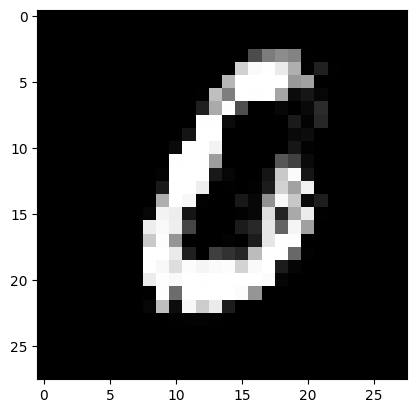

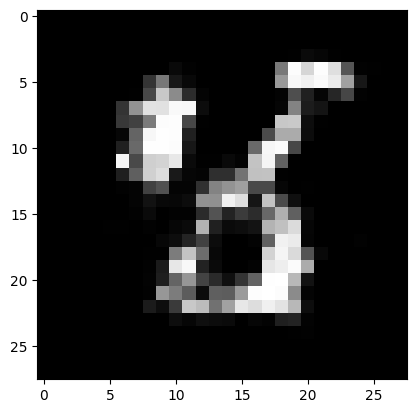

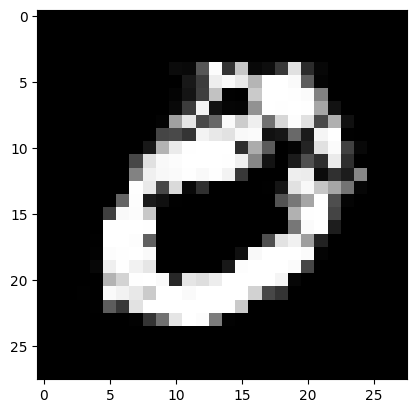

Epoch: 47550
loss_g: 0.7992326021194458 	loss_d: 1.2964203357696533
Epoch: 47600
loss_g: 0.8089787364006042 	loss_d: 1.283461570739746
Epoch: 47650
loss_g: 0.8346170783042908 	loss_d: 1.3361594676971436
Epoch: 47700
loss_g: 0.8342239260673523 	loss_d: 1.3917876482009888
Epoch: 47750
loss_g: 0.79823237657547 	loss_d: 1.3095829486846924
Epoch: 47800
loss_g: 0.8467828035354614 	loss_d: 1.3384346961975098
Epoch: 47850
loss_g: 0.8112611174583435 	loss_d: 1.2981841564178467
Epoch: 47900
loss_g: 0.7894088625907898 	loss_d: 1.3436636924743652
Epoch: 47950
loss_g: 0.7679853439331055 	loss_d: 1.3579450845718384
Epoch: 48000
loss_g: 0.7420009970664978 	loss_d: 1.321118950843811


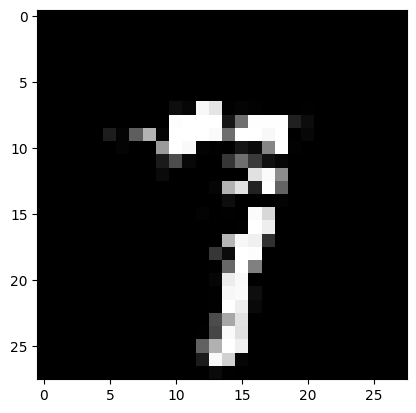

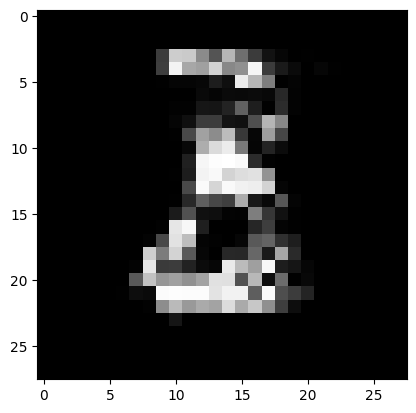

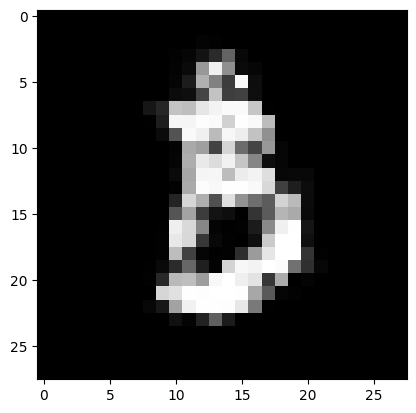

Epoch: 48050
loss_g: 0.8021615147590637 	loss_d: 1.2200870513916016
Epoch: 48100
loss_g: 0.7123569250106812 	loss_d: 1.36770761013031
Epoch: 48150
loss_g: 0.8248304724693298 	loss_d: 1.388322114944458
Epoch: 48200
loss_g: 0.8187451958656311 	loss_d: 1.2947214841842651
Epoch: 48250
loss_g: 0.8442471027374268 	loss_d: 1.3658572435379028
Epoch: 48300
loss_g: 0.8209182620048523 	loss_d: 1.292964220046997
Epoch: 48350
loss_g: 0.7685304284095764 	loss_d: 1.3285439014434814
Epoch: 48400
loss_g: 0.780249834060669 	loss_d: 1.3846393823623657
Epoch: 48450
loss_g: 0.8163917064666748 	loss_d: 1.3618054389953613
Epoch: 48500
loss_g: 0.7995770573616028 	loss_d: 1.3406975269317627


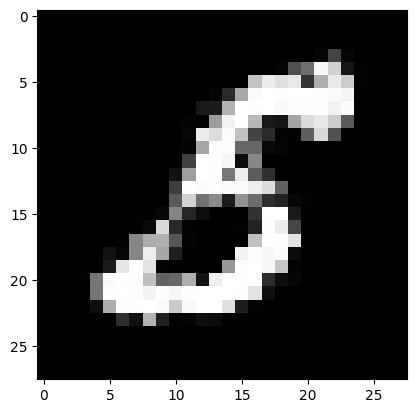

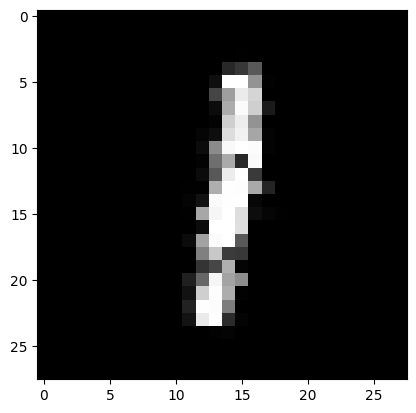

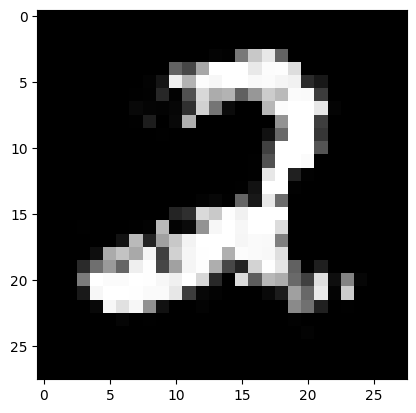

Epoch: 48550
loss_g: 0.8195028305053711 	loss_d: 1.315922737121582
Epoch: 48600
loss_g: 0.8285874724388123 	loss_d: 1.4390209913253784
Epoch: 48650
loss_g: 0.7217666506767273 	loss_d: 1.4067096710205078
Epoch: 48700
loss_g: 0.7930027842521667 	loss_d: 1.3191790580749512
Epoch: 48750
loss_g: 0.759390115737915 	loss_d: 1.3516732454299927
Epoch: 48800
loss_g: 0.7946075201034546 	loss_d: 1.3394140005111694
Epoch: 48850
loss_g: 0.7106438875198364 	loss_d: 1.4005881547927856
Epoch: 48900
loss_g: 0.8496476411819458 	loss_d: 1.359740972518921
Epoch: 48950
loss_g: 0.7666378617286682 	loss_d: 1.4017655849456787
Epoch: 49000
loss_g: 0.7981274724006653 	loss_d: 1.3307397365570068


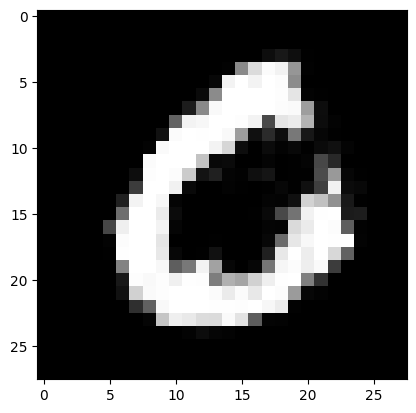

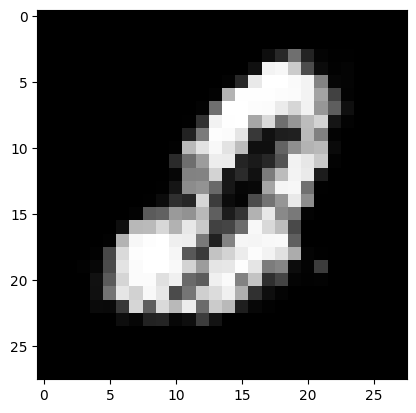

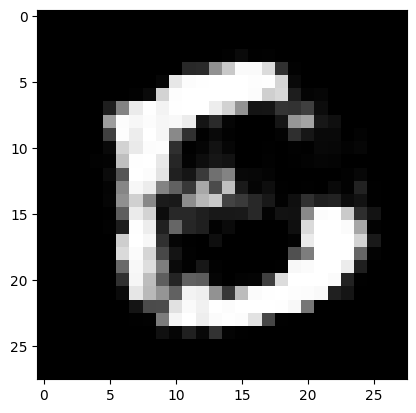

Epoch: 49050
loss_g: 0.7909974455833435 	loss_d: 1.3547236919403076
Epoch: 49100
loss_g: 0.7531862258911133 	loss_d: 1.293816089630127
Epoch: 49150
loss_g: 0.8421981334686279 	loss_d: 1.3001995086669922
Epoch: 49200
loss_g: 0.8340726494789124 	loss_d: 1.461591362953186
Epoch: 49250
loss_g: 0.7919726371765137 	loss_d: 1.3532400131225586
Epoch: 49300
loss_g: 0.8233550786972046 	loss_d: 1.3231744766235352
Epoch: 49350
loss_g: 0.7676048278808594 	loss_d: 1.330106258392334
Epoch: 49400
loss_g: 0.7498575448989868 	loss_d: 1.3549010753631592
Epoch: 49450
loss_g: 0.8196351528167725 	loss_d: 1.3054382801055908
Epoch: 49500
loss_g: 0.7576769590377808 	loss_d: 1.3270152807235718


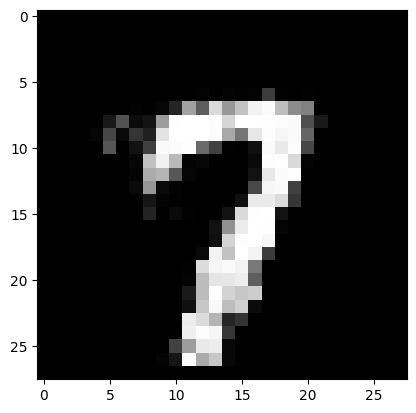

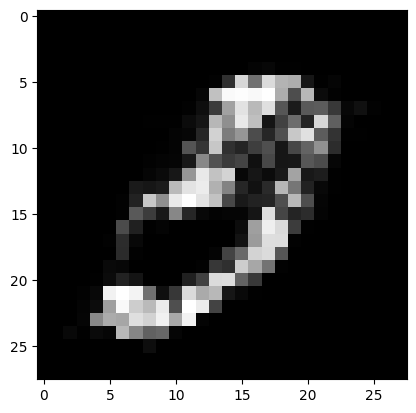

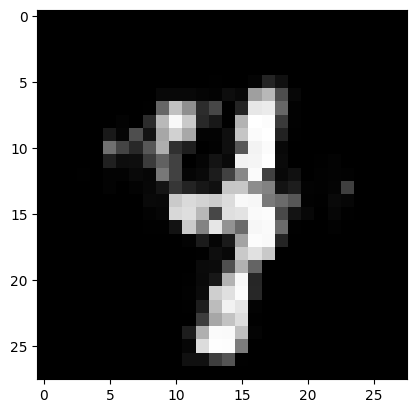

Epoch: 49550
loss_g: 0.798162043094635 	loss_d: 1.32529878616333
Epoch: 49600
loss_g: 0.8056942820549011 	loss_d: 1.3232665061950684
Epoch: 49650
loss_g: 0.7307908535003662 	loss_d: 1.3606956005096436
Epoch: 49700
loss_g: 0.7604911923408508 	loss_d: 1.3126039505004883
Epoch: 49750
loss_g: 0.7367889285087585 	loss_d: 1.3224067687988281
Epoch: 49800
loss_g: 0.7412933111190796 	loss_d: 1.3218655586242676
Epoch: 49850
loss_g: 0.8854023814201355 	loss_d: 1.3579108715057373
Epoch: 49900
loss_g: 0.8288899064064026 	loss_d: 1.3323369026184082
Epoch: 49950
loss_g: 0.8248083591461182 	loss_d: 1.3361811637878418
Epoch: 50000
loss_g: 0.7310358881950378 	loss_d: 1.3459663391113281


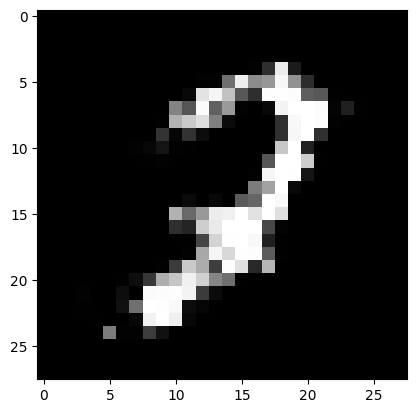

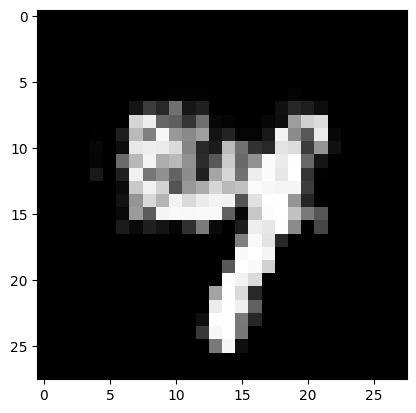

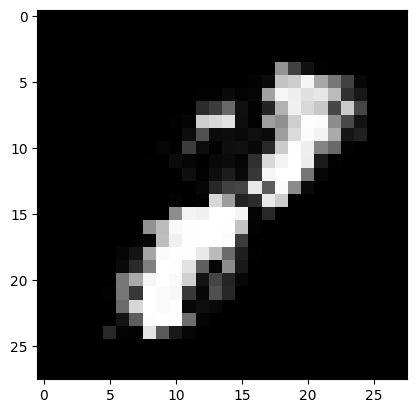

Epoch: 50050
loss_g: 0.8293498754501343 	loss_d: 1.3156874179840088
Epoch: 50100
loss_g: 0.7695816159248352 	loss_d: 1.4220008850097656
Epoch: 50150
loss_g: 0.7305053472518921 	loss_d: 1.321431279182434
Epoch: 50200
loss_g: 0.8622047901153564 	loss_d: 1.3539724349975586
Epoch: 50250
loss_g: 0.861255407333374 	loss_d: 1.3206182718276978
Epoch: 50300
loss_g: 0.7733194828033447 	loss_d: 1.3679896593093872
Epoch: 50350
loss_g: 0.7920263409614563 	loss_d: 1.3301355838775635
Epoch: 50400
loss_g: 0.7416300773620605 	loss_d: 1.2950198650360107
Epoch: 50450
loss_g: 0.7948022484779358 	loss_d: 1.3541890382766724
Epoch: 50500
loss_g: 0.7933387756347656 	loss_d: 1.3985519409179688


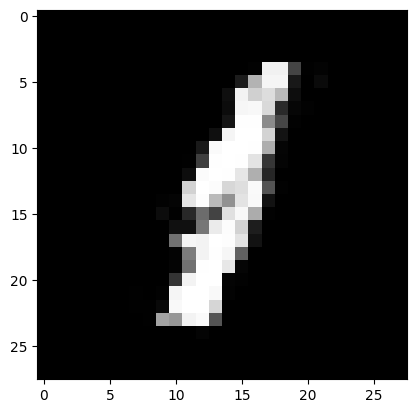

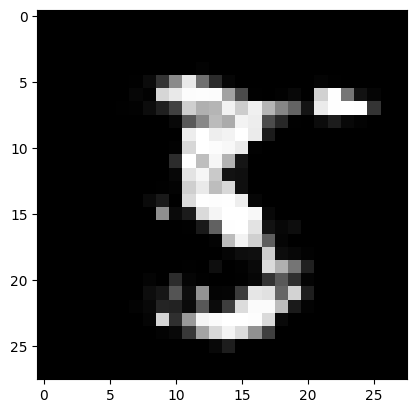

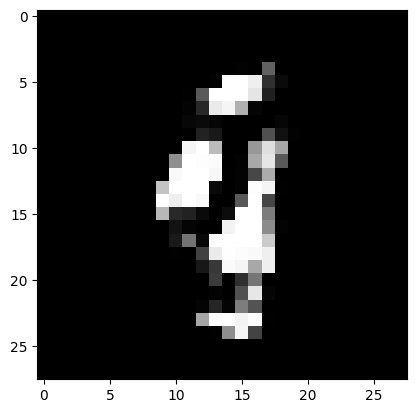

Epoch: 50550
loss_g: 0.8206576108932495 	loss_d: 1.419356346130371
Epoch: 50600
loss_g: 0.7897096276283264 	loss_d: 1.379690170288086
Epoch: 50650
loss_g: 0.7666400074958801 	loss_d: 1.335860252380371
Epoch: 50700
loss_g: 0.709737241268158 	loss_d: 1.3256858587265015
Epoch: 50750
loss_g: 0.8314019441604614 	loss_d: 1.3261950016021729
Epoch: 50800
loss_g: 0.8194119334220886 	loss_d: 1.2814000844955444
Epoch: 50850
loss_g: 0.824986457824707 	loss_d: 1.337667465209961
Epoch: 50900
loss_g: 0.8051443099975586 	loss_d: 1.396868348121643
Epoch: 50950
loss_g: 0.7531867027282715 	loss_d: 1.3419935703277588
Epoch: 51000
loss_g: 0.8005679249763489 	loss_d: 1.392876148223877


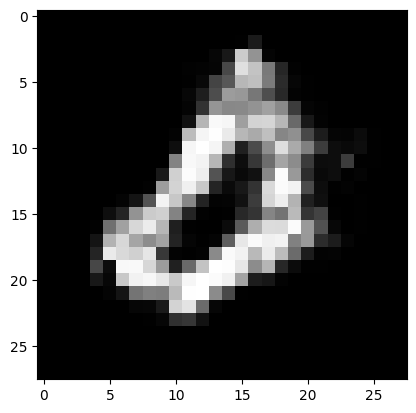

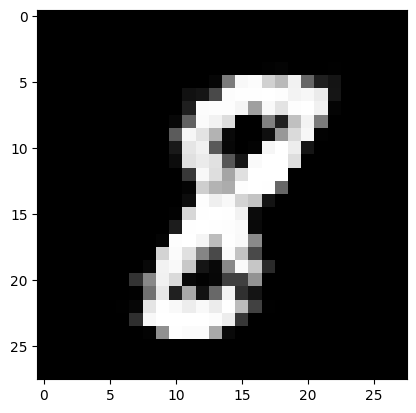

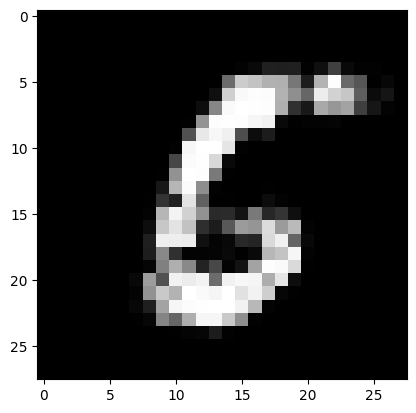

Epoch: 51050
loss_g: 0.7709792852401733 	loss_d: 1.3628926277160645
Epoch: 51100
loss_g: 0.8313920497894287 	loss_d: 1.3286049365997314
Epoch: 51150
loss_g: 0.8063478469848633 	loss_d: 1.3592431545257568
Epoch: 51200
loss_g: 0.8342512845993042 	loss_d: 1.288519263267517
Epoch: 51250
loss_g: 0.7778933048248291 	loss_d: 1.3427457809448242
Epoch: 51300
loss_g: 0.7752944827079773 	loss_d: 1.3447482585906982
Epoch: 51350
loss_g: 0.7945040464401245 	loss_d: 1.2713005542755127
Epoch: 51400
loss_g: 0.864193856716156 	loss_d: 1.3252670764923096
Epoch: 51450
loss_g: 0.8178994655609131 	loss_d: 1.3308801651000977
Epoch: 51500
loss_g: 0.8289111256599426 	loss_d: 1.2634820938110352


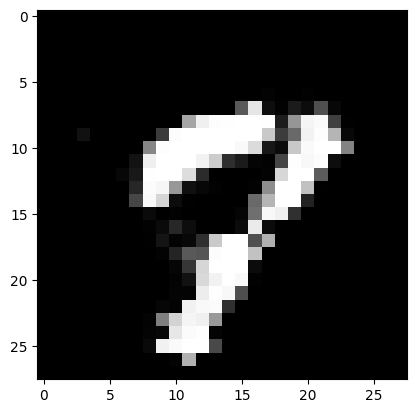

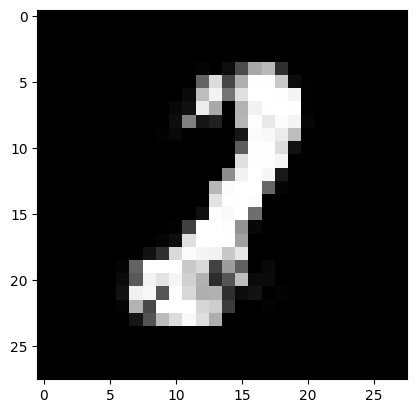

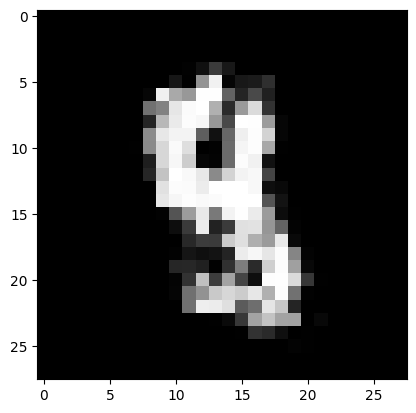

Epoch: 51550
loss_g: 0.8045077919960022 	loss_d: 1.380157232284546
Epoch: 51600
loss_g: 0.7735277414321899 	loss_d: 1.4181898832321167
Epoch: 51650
loss_g: 0.8044103980064392 	loss_d: 1.3328893184661865
Epoch: 51700
loss_g: 0.7911990880966187 	loss_d: 1.337202787399292
Epoch: 51750
loss_g: 0.7338671684265137 	loss_d: 1.3731107711791992
Epoch: 51800
loss_g: 0.7770612835884094 	loss_d: 1.3426381349563599
Epoch: 51850
loss_g: 0.751285970211029 	loss_d: 1.357149600982666
Epoch: 51900
loss_g: 0.8015905618667603 	loss_d: 1.2997891902923584
Epoch: 51950
loss_g: 0.8063409328460693 	loss_d: 1.3256330490112305
Epoch: 52000
loss_g: 0.7652525305747986 	loss_d: 1.355588674545288


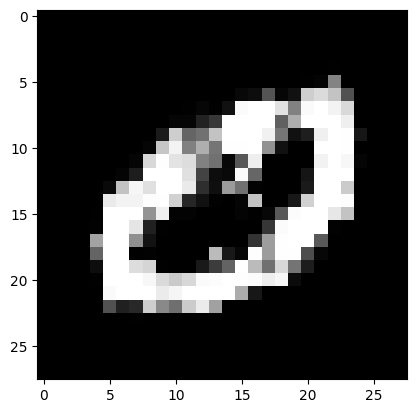

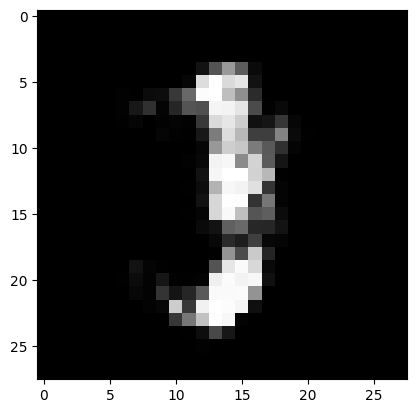

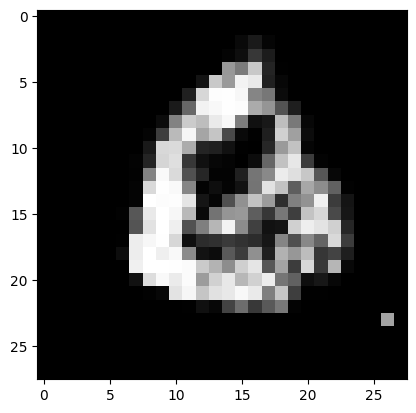

Epoch: 52050
loss_g: 0.7938567996025085 	loss_d: 1.3316192626953125
Epoch: 52100
loss_g: 0.7396875023841858 	loss_d: 1.3435120582580566
Epoch: 52150
loss_g: 0.8226073980331421 	loss_d: 1.3859213590621948
Epoch: 52200
loss_g: 0.8031439185142517 	loss_d: 1.267708659172058
Epoch: 52250
loss_g: 0.802114725112915 	loss_d: 1.3814401626586914
Epoch: 52300
loss_g: 0.8008391857147217 	loss_d: 1.2637851238250732
Epoch: 52350
loss_g: 0.7979623079299927 	loss_d: 1.4078161716461182
Epoch: 52400
loss_g: 0.7212214469909668 	loss_d: 1.3501715660095215
Epoch: 52450
loss_g: 0.7876819968223572 	loss_d: 1.307647466659546
Epoch: 52500
loss_g: 0.7934777140617371 	loss_d: 1.377327561378479


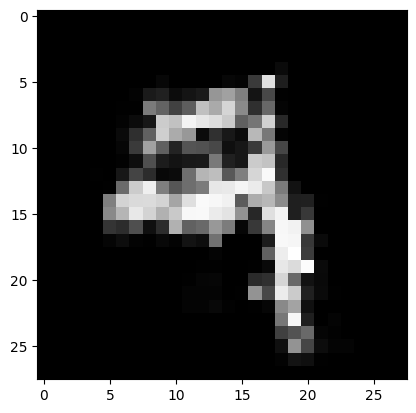

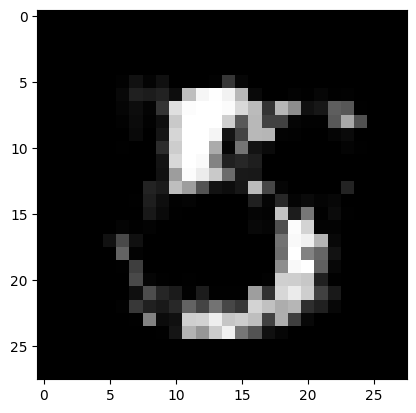

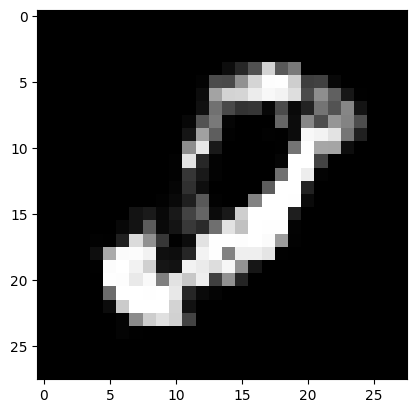

Epoch: 52550
loss_g: 0.7449830174446106 	loss_d: 1.3057546615600586
Epoch: 52600
loss_g: 0.7932193875312805 	loss_d: 1.3047668933868408
Epoch: 52650
loss_g: 0.907364010810852 	loss_d: 1.3132789134979248
Epoch: 52700
loss_g: 0.7988597750663757 	loss_d: 1.3519887924194336
Epoch: 52750
loss_g: 0.7864716053009033 	loss_d: 1.4038207530975342
Epoch: 52800
loss_g: 0.7495216131210327 	loss_d: 1.373974084854126
Epoch: 52850
loss_g: 0.7740871906280518 	loss_d: 1.2777692079544067
Epoch: 52900
loss_g: 0.7413995862007141 	loss_d: 1.3878344297409058
Epoch: 52950
loss_g: 0.7721336483955383 	loss_d: 1.3866262435913086
Epoch: 53000
loss_g: 0.8361249566078186 	loss_d: 1.378610610961914


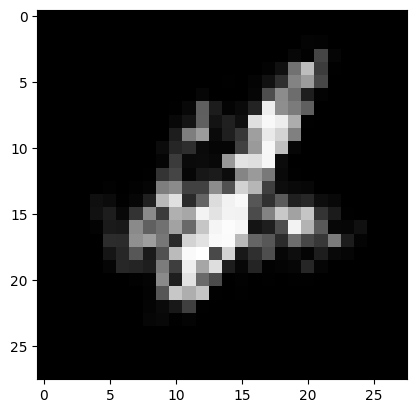

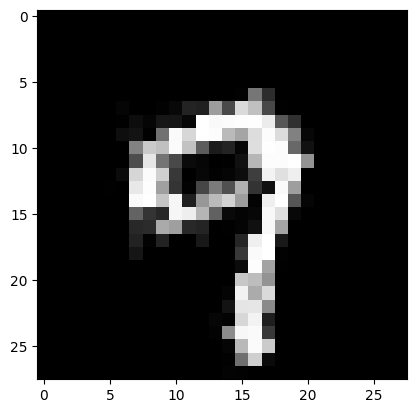

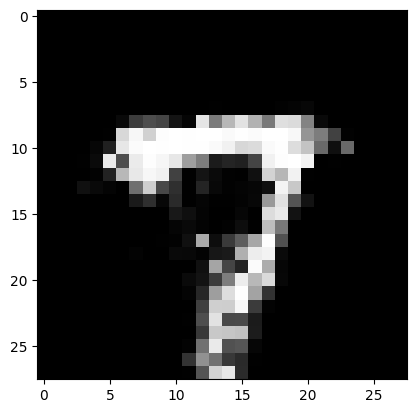

Epoch: 53050
loss_g: 0.8171574473381042 	loss_d: 1.308600902557373
Epoch: 53100
loss_g: 0.780064582824707 	loss_d: 1.3217334747314453
Epoch: 53150
loss_g: 0.8035105466842651 	loss_d: 1.325352430343628
Epoch: 53200
loss_g: 0.7994818091392517 	loss_d: 1.3196282386779785
Epoch: 53250
loss_g: 0.7252827286720276 	loss_d: 1.3213465213775635
Epoch: 53300
loss_g: 0.7933778762817383 	loss_d: 1.3594474792480469
Epoch: 53350
loss_g: 0.738129734992981 	loss_d: 1.3546887636184692
Epoch: 53400
loss_g: 0.7549921870231628 	loss_d: 1.3412096500396729
Epoch: 53450
loss_g: 0.7171767354011536 	loss_d: 1.3105735778808594
Epoch: 53500
loss_g: 0.7928745150566101 	loss_d: 1.3750414848327637


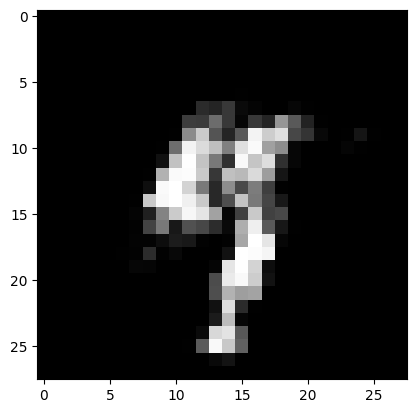

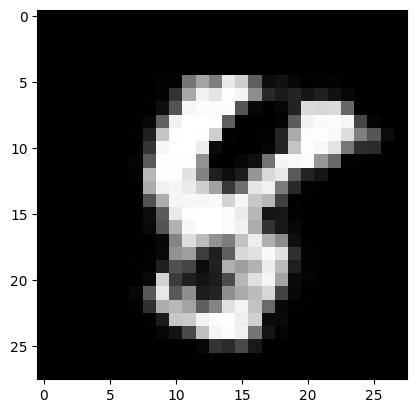

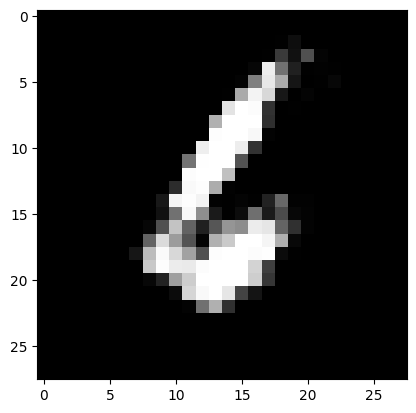

Epoch: 53550
loss_g: 0.8272247314453125 	loss_d: 1.3155248165130615
Epoch: 53600
loss_g: 0.7173362374305725 	loss_d: 1.3046865463256836
Epoch: 53650
loss_g: 0.8765807151794434 	loss_d: 1.338841199874878
Epoch: 53700
loss_g: 0.7672738432884216 	loss_d: 1.3687901496887207
Epoch: 53750
loss_g: 0.7499970197677612 	loss_d: 1.4038231372833252
Epoch: 53800
loss_g: 0.8200627565383911 	loss_d: 1.3234853744506836
Epoch: 53850
loss_g: 0.830180823802948 	loss_d: 1.3547601699829102
Epoch: 53900
loss_g: 0.7570390105247498 	loss_d: 1.3821310997009277
Epoch: 53950
loss_g: 0.7944658398628235 	loss_d: 1.3652560710906982
Epoch: 54000
loss_g: 0.7570005655288696 	loss_d: 1.3642199039459229


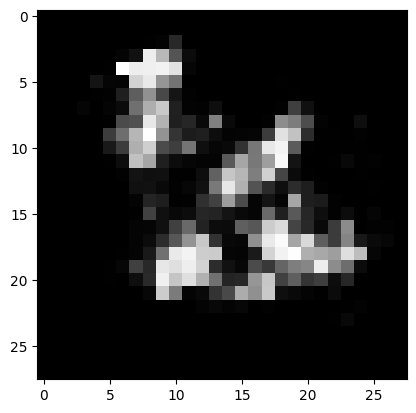

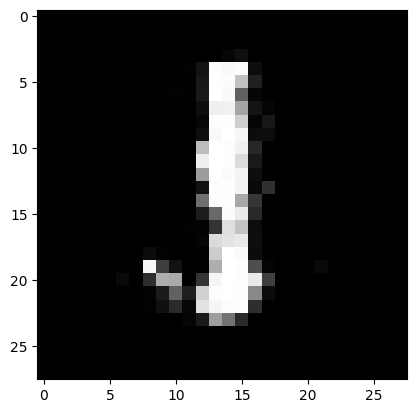

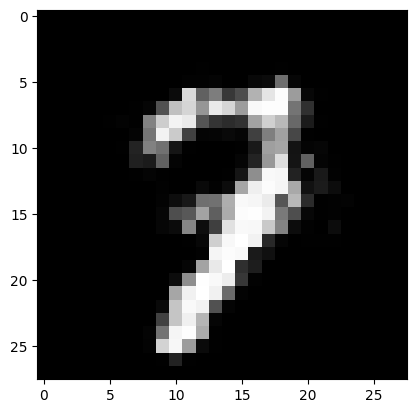

Epoch: 54050
loss_g: 0.7390539646148682 	loss_d: 1.3504045009613037
Epoch: 54100
loss_g: 0.8032471537590027 	loss_d: 1.3559365272521973
Epoch: 54150
loss_g: 0.7557682394981384 	loss_d: 1.3433054685592651
Epoch: 54200
loss_g: 0.726448655128479 	loss_d: 1.3785855770111084
Epoch: 54250
loss_g: 0.7786172032356262 	loss_d: 1.3235763311386108
Epoch: 54300
loss_g: 0.7916389107704163 	loss_d: 1.3767995834350586
Epoch: 54350
loss_g: 0.789467453956604 	loss_d: 1.3399982452392578
Epoch: 54400
loss_g: 0.7450447678565979 	loss_d: 1.3521130084991455
Epoch: 54450
loss_g: 0.7891993522644043 	loss_d: 1.3448718786239624
Epoch: 54500
loss_g: 0.8272691369056702 	loss_d: 1.350043535232544


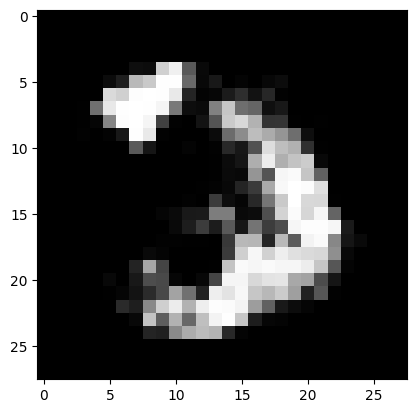

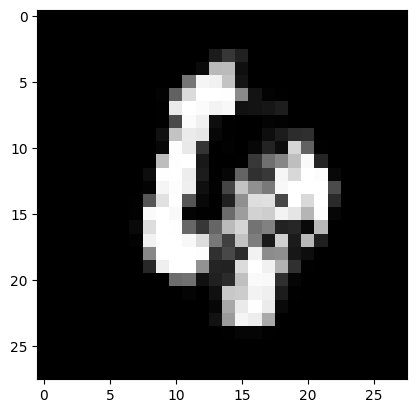

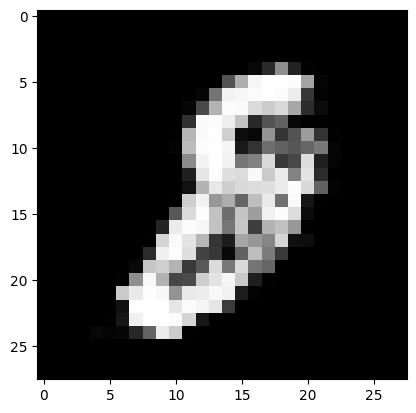

Epoch: 54550
loss_g: 0.752392590045929 	loss_d: 1.3693585395812988
Epoch: 54600
loss_g: 0.782741367816925 	loss_d: 1.3388688564300537
Epoch: 54650
loss_g: 0.7910386323928833 	loss_d: 1.369171380996704
Epoch: 54700
loss_g: 0.7868185043334961 	loss_d: 1.3797581195831299
Epoch: 54750
loss_g: 0.7608003616333008 	loss_d: 1.3676475286483765
Epoch: 54800
loss_g: 0.7822133302688599 	loss_d: 1.3578838109970093
Epoch: 54850
loss_g: 0.7579872608184814 	loss_d: 1.287973403930664
Epoch: 54900
loss_g: 0.7514220476150513 	loss_d: 1.3844623565673828
Epoch: 54950
loss_g: 0.7859465479850769 	loss_d: 1.318835735321045
Epoch: 55000
loss_g: 0.8116413950920105 	loss_d: 1.281200885772705


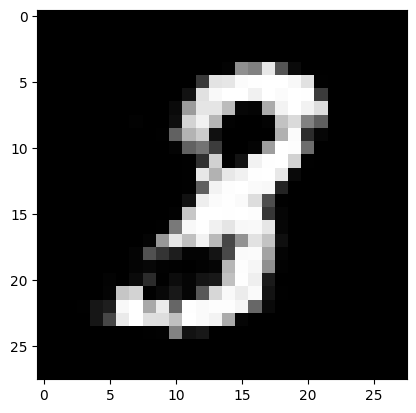

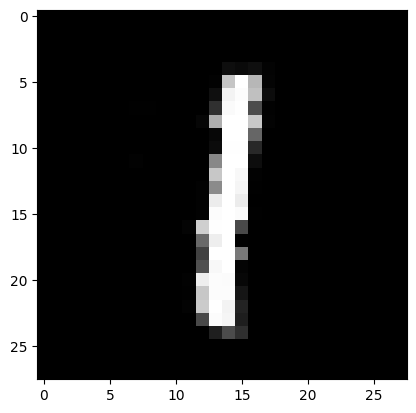

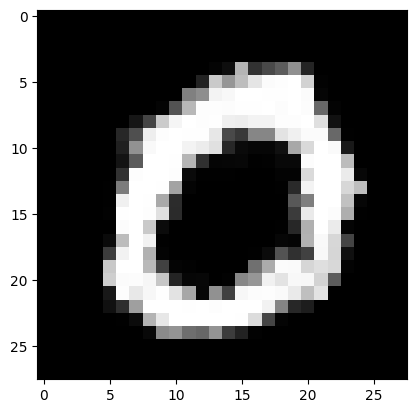

Epoch: 55050
loss_g: 0.7080467939376831 	loss_d: 1.371138095855713
Epoch: 55100
loss_g: 0.8390647768974304 	loss_d: 1.3837487697601318
Epoch: 55150
loss_g: 0.7903217673301697 	loss_d: 1.3219585418701172
Epoch: 55200
loss_g: 0.7790522575378418 	loss_d: 1.4048852920532227
Epoch: 55250
loss_g: 0.8022801280021667 	loss_d: 1.401686668395996
Epoch: 55300
loss_g: 0.7501250505447388 	loss_d: 1.3158576488494873
Epoch: 55350
loss_g: 0.8175910711288452 	loss_d: 1.394829511642456
Epoch: 55400
loss_g: 0.8202430605888367 	loss_d: 1.3308100700378418
Epoch: 55450
loss_g: 0.7698982954025269 	loss_d: 1.4056822061538696
Epoch: 55500
loss_g: 0.7876766920089722 	loss_d: 1.3552985191345215


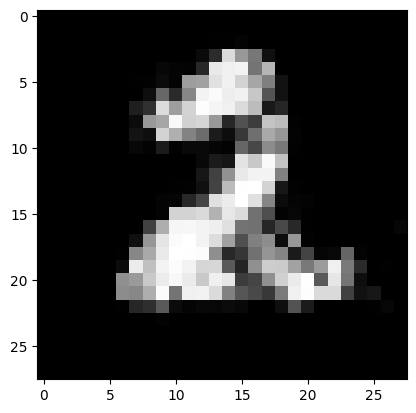

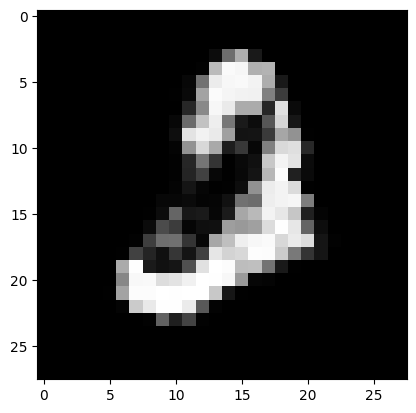

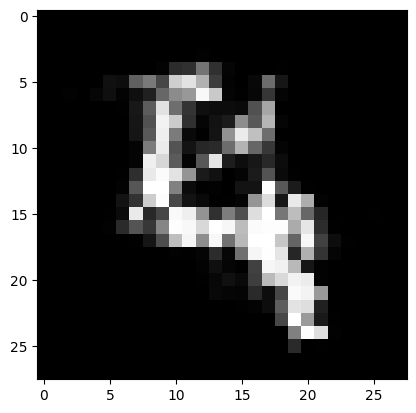

Epoch: 55550
loss_g: 0.9075121879577637 	loss_d: 1.3899224996566772
Epoch: 55600
loss_g: 0.7280282974243164 	loss_d: 1.3499113321304321
Epoch: 55650
loss_g: 0.7023931741714478 	loss_d: 1.403865098953247
Epoch: 55700
loss_g: 0.7942495346069336 	loss_d: 1.3734104633331299
Epoch: 55750
loss_g: 0.7503970265388489 	loss_d: 1.2965279817581177
Epoch: 55800
loss_g: 0.7550774812698364 	loss_d: 1.3521231412887573
Epoch: 55850
loss_g: 0.7311366200447083 	loss_d: 1.3450953960418701
Epoch: 55900
loss_g: 0.8015058636665344 	loss_d: 1.2771859169006348
Epoch: 55950
loss_g: 0.8004900813102722 	loss_d: 1.3628617525100708
Epoch: 56000
loss_g: 0.7961174845695496 	loss_d: 1.3657252788543701


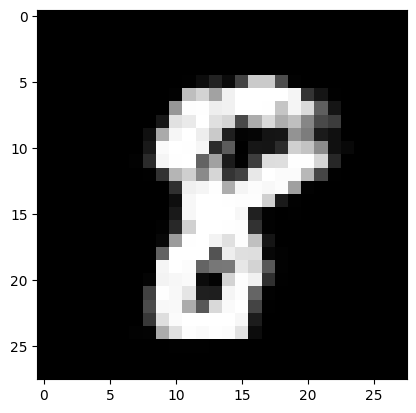

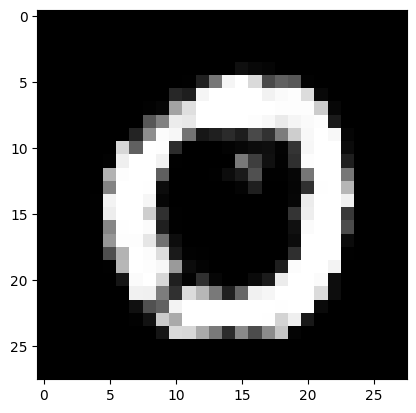

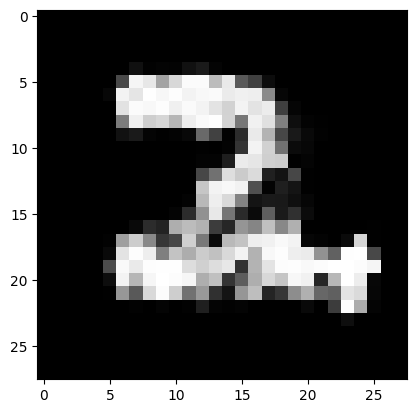

Epoch: 56050
loss_g: 0.7519683837890625 	loss_d: 1.3366860151290894
Epoch: 56100
loss_g: 0.8085303902626038 	loss_d: 1.350311040878296
Epoch: 56150
loss_g: 0.7906106114387512 	loss_d: 1.3470673561096191
Epoch: 56200
loss_g: 0.7827309370040894 	loss_d: 1.406785249710083
Epoch: 56250
loss_g: 0.7954131364822388 	loss_d: 1.261106014251709
Epoch: 56300
loss_g: 0.8168299198150635 	loss_d: 1.3683252334594727
Epoch: 56350
loss_g: 0.7486662268638611 	loss_d: 1.3363230228424072
Epoch: 56400
loss_g: 0.7614097595214844 	loss_d: 1.377071499824524
Epoch: 56450
loss_g: 0.768267810344696 	loss_d: 1.36326265335083
Epoch: 56500
loss_g: 0.7338477969169617 	loss_d: 1.2415275573730469


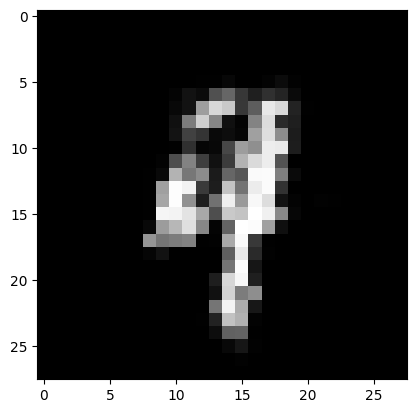

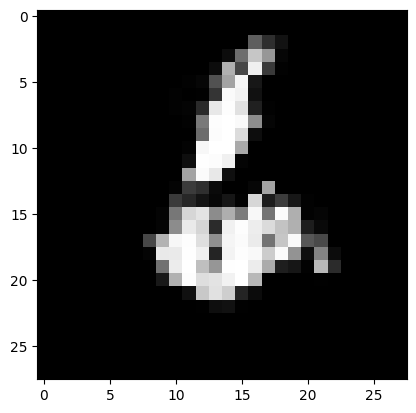

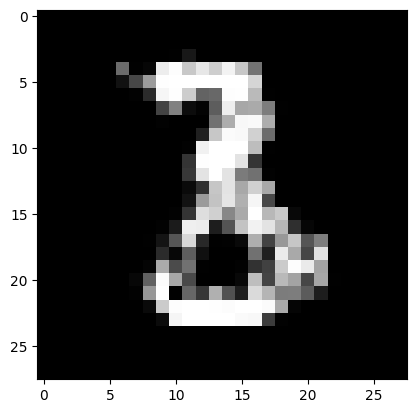

Epoch: 56550
loss_g: 0.8017355799674988 	loss_d: 1.3196556568145752
Epoch: 56600
loss_g: 0.7606692910194397 	loss_d: 1.3613779544830322
Epoch: 56650
loss_g: 0.7936537861824036 	loss_d: 1.3222180604934692
Epoch: 56700
loss_g: 0.7976900339126587 	loss_d: 1.3351311683654785
Epoch: 56750
loss_g: 0.7829083204269409 	loss_d: 1.375001311302185
Epoch: 56800
loss_g: 0.7784444093704224 	loss_d: 1.3910257816314697
Epoch: 56850
loss_g: 0.7699673175811768 	loss_d: 1.3038709163665771
Epoch: 56900
loss_g: 0.713999330997467 	loss_d: 1.3485357761383057
Epoch: 56950
loss_g: 0.7072486877441406 	loss_d: 1.3752260208129883
Epoch: 57000
loss_g: 0.7504118084907532 	loss_d: 1.368812084197998


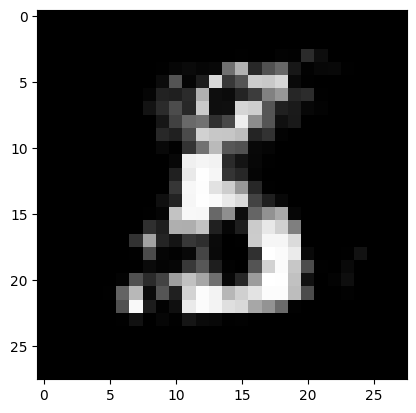

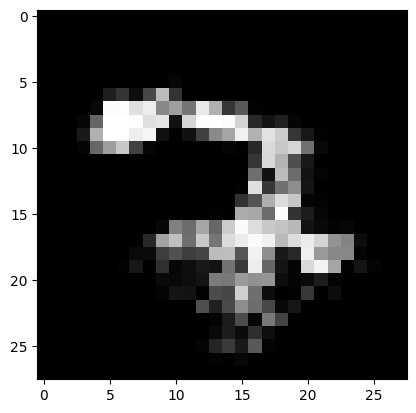

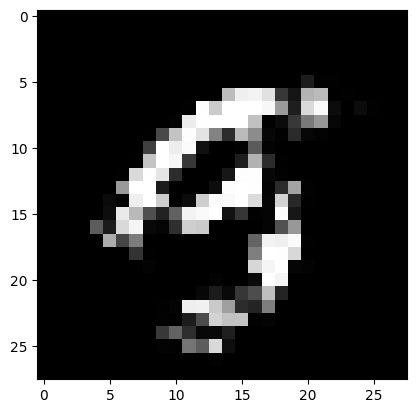

Epoch: 57050
loss_g: 0.7354138493537903 	loss_d: 1.2927792072296143
Epoch: 57100
loss_g: 0.7176396250724792 	loss_d: 1.3452410697937012
Epoch: 57150
loss_g: 0.7566653490066528 	loss_d: 1.386434555053711
Epoch: 57200
loss_g: 0.7577142119407654 	loss_d: 1.3484957218170166
Epoch: 57250
loss_g: 0.7843073010444641 	loss_d: 1.273008108139038
Epoch: 57300
loss_g: 0.7899553775787354 	loss_d: 1.3487834930419922
Epoch: 57350
loss_g: 0.7176217436790466 	loss_d: 1.4035886526107788
Epoch: 57400
loss_g: 0.7691715955734253 	loss_d: 1.3373544216156006
Epoch: 57450
loss_g: 0.7954028844833374 	loss_d: 1.377608299255371
Epoch: 57500
loss_g: 0.7635751962661743 	loss_d: 1.3581914901733398


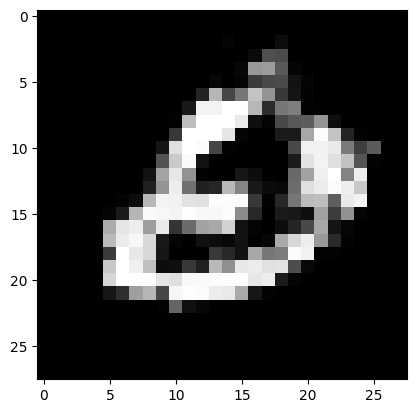

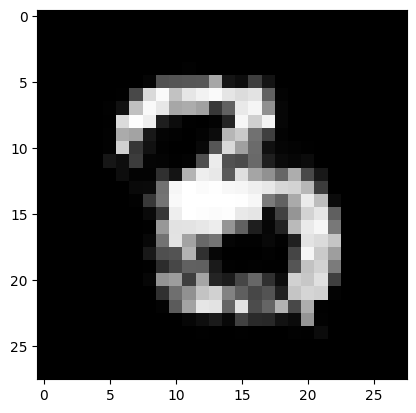

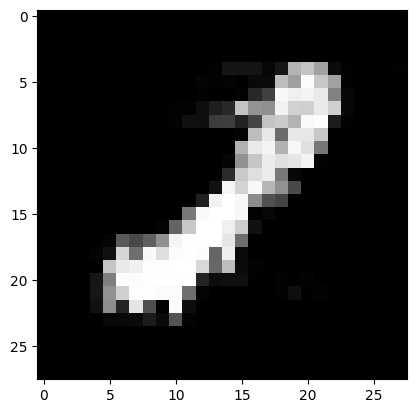

Epoch: 57550
loss_g: 0.8199771046638489 	loss_d: 1.3519270420074463
Epoch: 57600
loss_g: 0.7881560921669006 	loss_d: 1.419766902923584
Epoch: 57650
loss_g: 0.7709951400756836 	loss_d: 1.3031806945800781
Epoch: 57700
loss_g: 0.7348194718360901 	loss_d: 1.2926249504089355
Epoch: 57750
loss_g: 0.7943049669265747 	loss_d: 1.3154101371765137
Epoch: 57800
loss_g: 0.735638439655304 	loss_d: 1.3343265056610107
Epoch: 57850
loss_g: 0.7548632621765137 	loss_d: 1.3441017866134644
Epoch: 57900
loss_g: 0.8438067436218262 	loss_d: 1.3262608051300049
Epoch: 57950
loss_g: 0.7688257694244385 	loss_d: 1.3008208274841309
Epoch: 58000
loss_g: 0.759884238243103 	loss_d: 1.3660163879394531


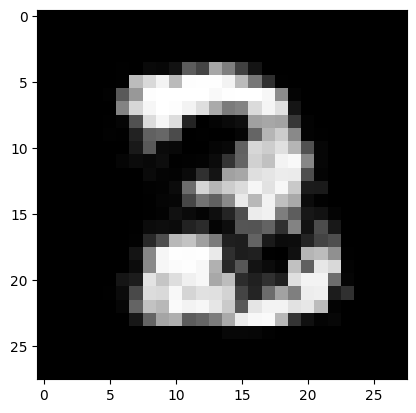

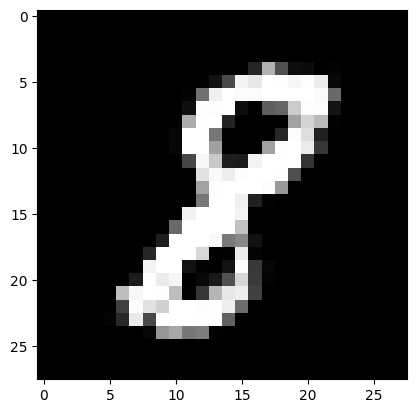

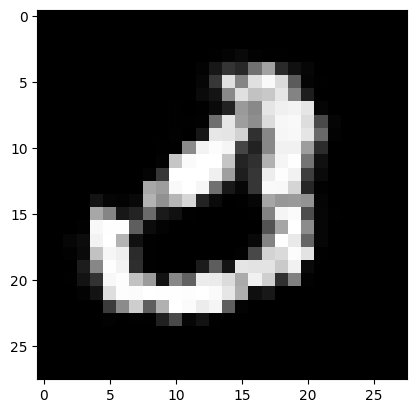

Epoch: 58050
loss_g: 0.7842552065849304 	loss_d: 1.3330819606781006
Epoch: 58100
loss_g: 0.7653046250343323 	loss_d: 1.3497589826583862
Epoch: 58150
loss_g: 0.78482586145401 	loss_d: 1.3429014682769775
Epoch: 58200
loss_g: 0.8100161552429199 	loss_d: 1.4276981353759766
Epoch: 58250
loss_g: 0.8017399311065674 	loss_d: 1.3044778108596802
Epoch: 58300
loss_g: 0.7817685008049011 	loss_d: 1.3697547912597656
Epoch: 58350
loss_g: 0.7411808371543884 	loss_d: 1.3599677085876465
Epoch: 58400
loss_g: 0.8150454759597778 	loss_d: 1.3507623672485352
Epoch: 58450
loss_g: 0.7631507515907288 	loss_d: 1.3288383483886719
Epoch: 58500
loss_g: 0.7812104821205139 	loss_d: 1.3410406112670898


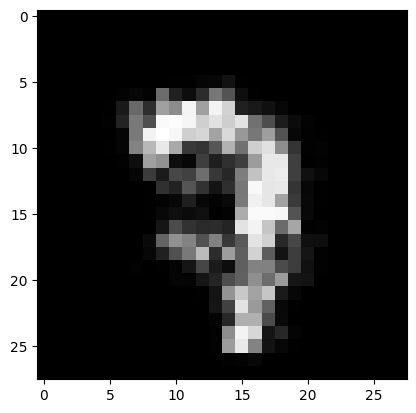

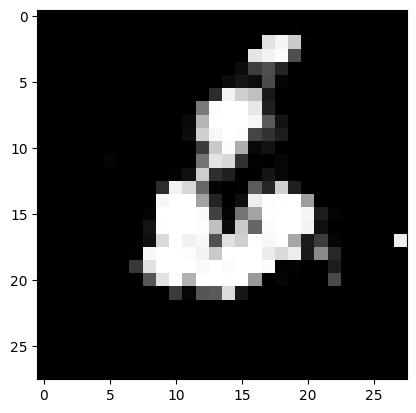

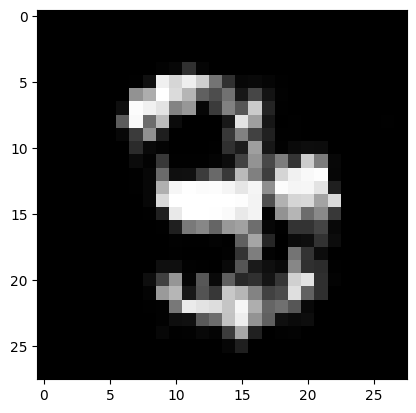

Epoch: 58550
loss_g: 0.7767048478126526 	loss_d: 1.2993133068084717
Epoch: 58600
loss_g: 0.7327312231063843 	loss_d: 1.3810548782348633
Epoch: 58650
loss_g: 0.8031478524208069 	loss_d: 1.3993523120880127
Epoch: 58700
loss_g: 0.8283743858337402 	loss_d: 1.3235886096954346
Epoch: 58750
loss_g: 0.7773934602737427 	loss_d: 1.2747869491577148
Epoch: 58800
loss_g: 0.7743822336196899 	loss_d: 1.3859601020812988
Epoch: 58850
loss_g: 0.7627845406532288 	loss_d: 1.3198351860046387
Epoch: 58900
loss_g: 0.7728601098060608 	loss_d: 1.3736658096313477
Epoch: 58950
loss_g: 0.752833366394043 	loss_d: 1.3400440216064453
Epoch: 59000
loss_g: 0.7474098801612854 	loss_d: 1.3767995834350586


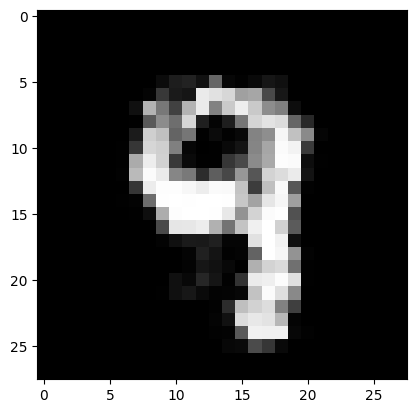

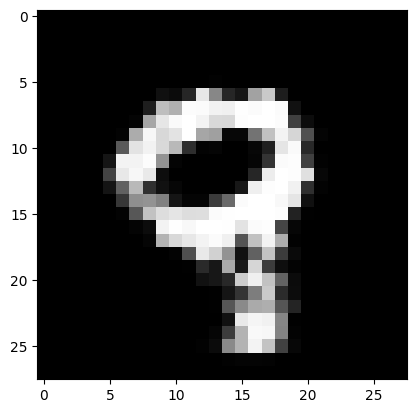

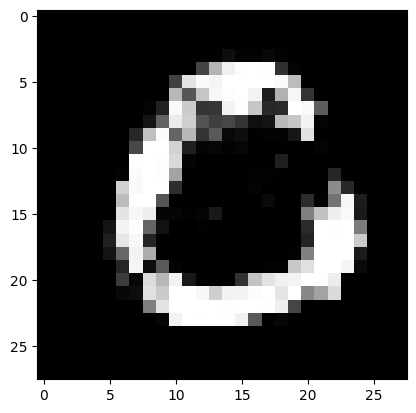

Epoch: 59050
loss_g: 0.8403087258338928 	loss_d: 1.3301417827606201
Epoch: 59100
loss_g: 0.8252463936805725 	loss_d: 1.3491051197052002
Epoch: 59150
loss_g: 0.7484720945358276 	loss_d: 1.348078727722168
Epoch: 59200
loss_g: 0.8013624548912048 	loss_d: 1.3349454402923584
Epoch: 59250
loss_g: 0.7860792279243469 	loss_d: 1.3403983116149902
Epoch: 59300
loss_g: 0.7204868197441101 	loss_d: 1.396425724029541
Epoch: 59350
loss_g: 0.821654200553894 	loss_d: 1.3108028173446655
Epoch: 59400
loss_g: 0.7770463228225708 	loss_d: 1.3614448308944702
Epoch: 59450
loss_g: 0.748630940914154 	loss_d: 1.3001112937927246
Epoch: 59500
loss_g: 0.8070397973060608 	loss_d: 1.363039493560791


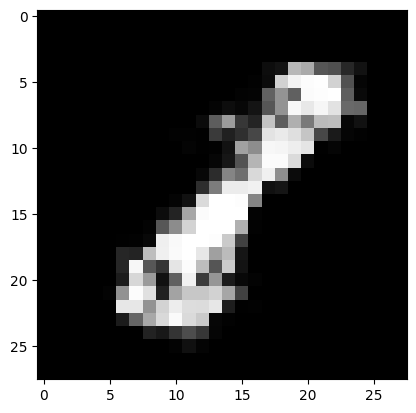

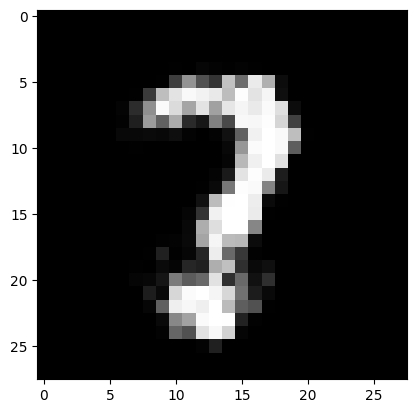

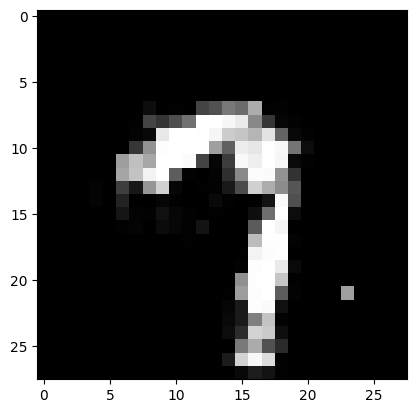

Epoch: 59550
loss_g: 0.7902775406837463 	loss_d: 1.4353203773498535
Epoch: 59600
loss_g: 0.7749986052513123 	loss_d: 1.3381482362747192
Epoch: 59650
loss_g: 0.7666944861412048 	loss_d: 1.3143377304077148
Epoch: 59700
loss_g: 0.7399497032165527 	loss_d: 1.311593770980835
Epoch: 59750
loss_g: 0.7471115589141846 	loss_d: 1.3774149417877197
Epoch: 59800
loss_g: 0.7963922023773193 	loss_d: 1.2894856929779053
Epoch: 59850
loss_g: 0.7569480538368225 	loss_d: 1.3522400856018066
Epoch: 59900
loss_g: 0.7857447862625122 	loss_d: 1.3912229537963867
Epoch: 59950
loss_g: 0.7553706169128418 	loss_d: 1.3057358264923096
Epoch: 60000
loss_g: 0.7768375873565674 	loss_d: 1.4133647680282593


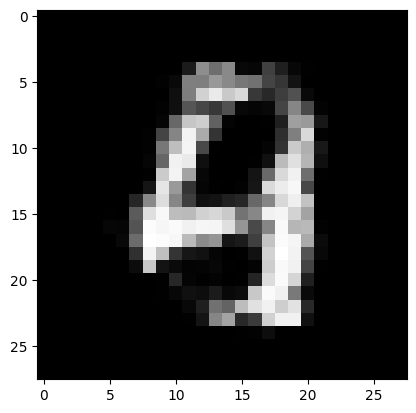

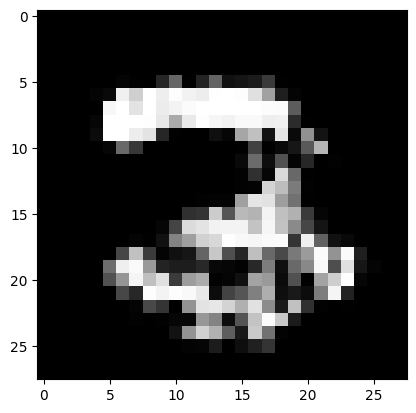

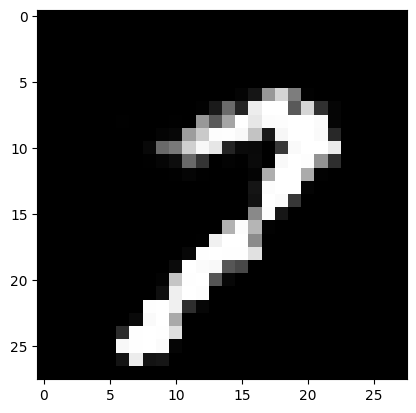

Epoch: 60050
loss_g: 0.7762092351913452 	loss_d: 1.286691665649414
Epoch: 60100
loss_g: 0.7634510397911072 	loss_d: 1.3473434448242188
Epoch: 60150
loss_g: 0.8083073496818542 	loss_d: 1.4233193397521973
Epoch: 60200
loss_g: 0.8052548170089722 	loss_d: 1.3066949844360352
Epoch: 60250
loss_g: 0.7671371102333069 	loss_d: 1.3837391138076782
Epoch: 60300
loss_g: 0.7508809566497803 	loss_d: 1.3160293102264404
Epoch: 60350
loss_g: 0.8375923037528992 	loss_d: 1.301846981048584
Epoch: 60400
loss_g: 0.8099804520606995 	loss_d: 1.3417561054229736
Epoch: 60450
loss_g: 0.718755304813385 	loss_d: 1.3833937644958496
Epoch: 60500
loss_g: 0.811086893081665 	loss_d: 1.305450677871704


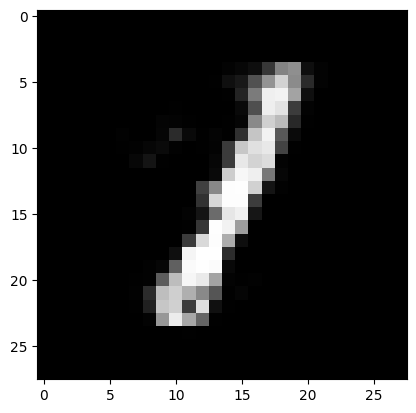

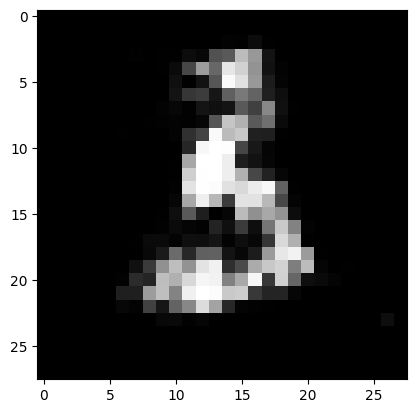

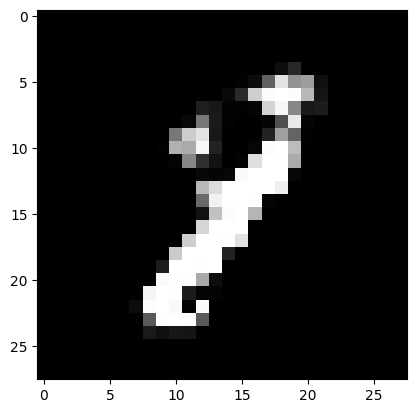

Epoch: 60550
loss_g: 0.7440429329872131 	loss_d: 1.4113056659698486
Epoch: 60600
loss_g: 0.7450571060180664 	loss_d: 1.2945234775543213
Epoch: 60650
loss_g: 0.7634578347206116 	loss_d: 1.3594721555709839
Epoch: 60700
loss_g: 0.8011060953140259 	loss_d: 1.3354544639587402
Epoch: 60750
loss_g: 0.7771939039230347 	loss_d: 1.3312504291534424
Epoch: 60800
loss_g: 0.7742725014686584 	loss_d: 1.3788609504699707
Epoch: 60850
loss_g: 0.8190327882766724 	loss_d: 1.4016832113265991
Epoch: 60900
loss_g: 0.7956581115722656 	loss_d: 1.317523717880249
Epoch: 60950
loss_g: 0.7922828793525696 	loss_d: 1.3135229349136353
Epoch: 61000
loss_g: 0.7594383358955383 	loss_d: 1.388708472251892


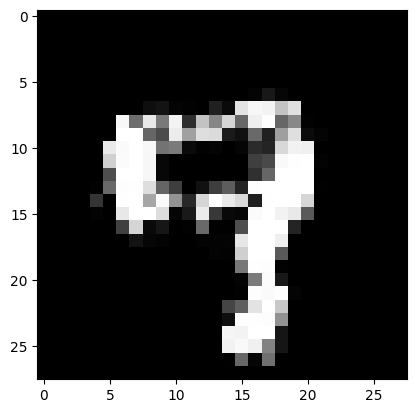

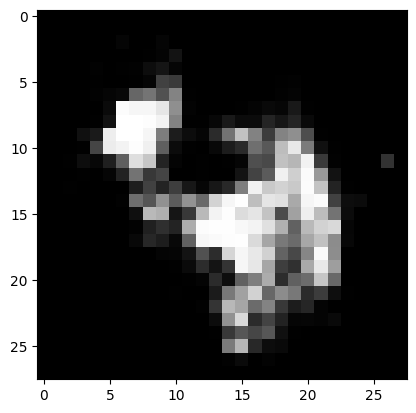

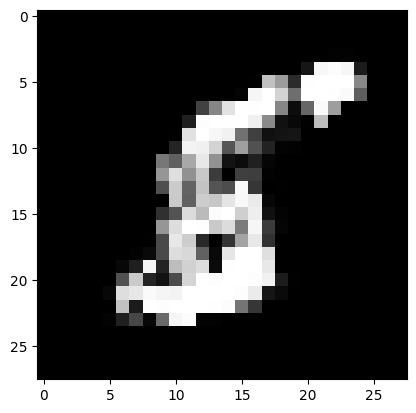

Epoch: 61050
loss_g: 0.756356954574585 	loss_d: 1.3349344730377197
Epoch: 61100
loss_g: 0.7443158626556396 	loss_d: 1.346984624862671
Epoch: 61150
loss_g: 0.8366003036499023 	loss_d: 1.3108994960784912
Epoch: 61200
loss_g: 0.7620255351066589 	loss_d: 1.350229263305664
Epoch: 61250
loss_g: 0.8158754706382751 	loss_d: 1.2698469161987305
Epoch: 61300
loss_g: 0.8057205677032471 	loss_d: 1.3346871137619019
Epoch: 61350
loss_g: 0.7878372073173523 	loss_d: 1.3214201927185059
Epoch: 61400
loss_g: 0.7754226326942444 	loss_d: 1.3479995727539062
Epoch: 61450
loss_g: 0.7872506380081177 	loss_d: 1.2959671020507812
Epoch: 61500
loss_g: 0.7725895643234253 	loss_d: 1.3573403358459473


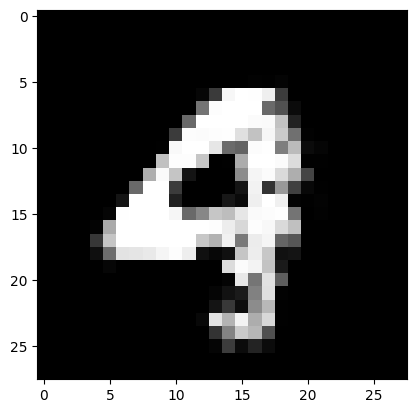

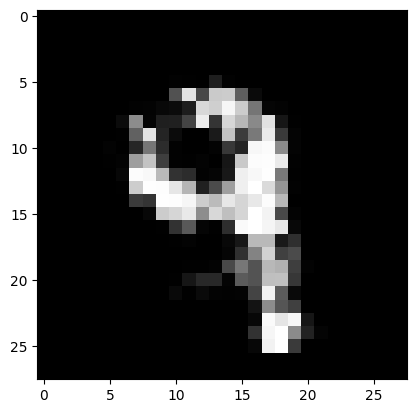

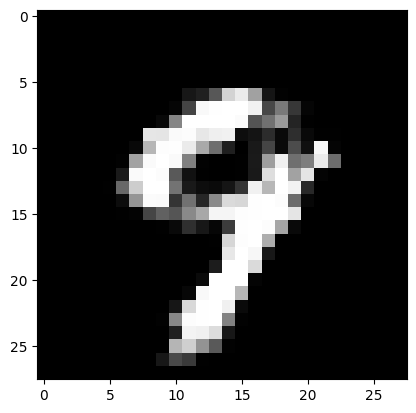

Epoch: 61550
loss_g: 0.7808048725128174 	loss_d: 1.2310330867767334
Epoch: 61600
loss_g: 0.7545477151870728 	loss_d: 1.3916451930999756
Epoch: 61650
loss_g: 0.7984886765480042 	loss_d: 1.392411708831787
Epoch: 61700
loss_g: 0.7875202894210815 	loss_d: 1.3282511234283447
Epoch: 61750
loss_g: 0.7799596786499023 	loss_d: 1.3654284477233887
Epoch: 61800
loss_g: 0.7879763841629028 	loss_d: 1.2760626077651978
Epoch: 61850
loss_g: 0.8290895819664001 	loss_d: 1.3777692317962646
Epoch: 61900
loss_g: 0.8198157548904419 	loss_d: 1.301877498626709
Epoch: 61950
loss_g: 0.7887948155403137 	loss_d: 1.3162277936935425
Epoch: 62000
loss_g: 0.7881119847297668 	loss_d: 1.3534619808197021


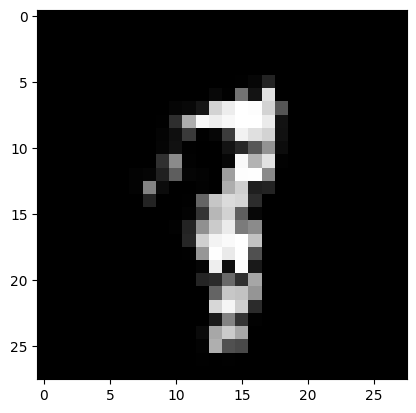

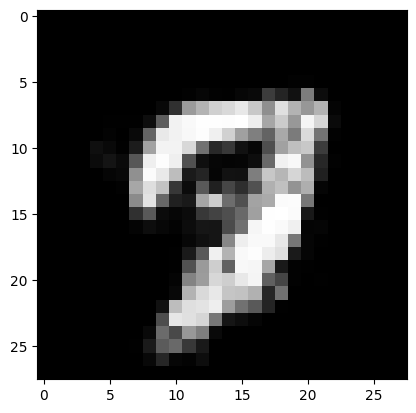

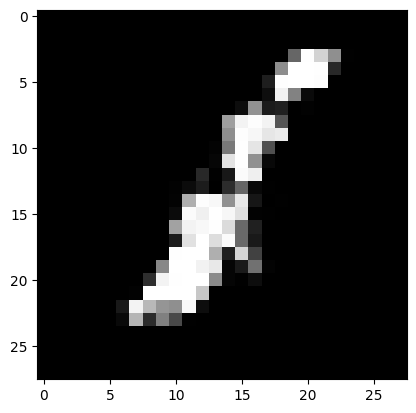

Epoch: 62050
loss_g: 0.8135412335395813 	loss_d: 1.3413641452789307
Epoch: 62100
loss_g: 0.7649267315864563 	loss_d: 1.3124628067016602
Epoch: 62150
loss_g: 0.7759042382240295 	loss_d: 1.3649046421051025
Epoch: 62200
loss_g: 0.7647653818130493 	loss_d: 1.344756841659546
Epoch: 62250
loss_g: 0.7961437106132507 	loss_d: 1.350234866142273
Epoch: 62300
loss_g: 0.7179942727088928 	loss_d: 1.3462152481079102
Epoch: 62350
loss_g: 0.8378562927246094 	loss_d: 1.3218445777893066
Epoch: 62400
loss_g: 0.7634864449501038 	loss_d: 1.4036628007888794
Epoch: 62450
loss_g: 0.7644141912460327 	loss_d: 1.3724395036697388
Epoch: 62500
loss_g: 0.7660899758338928 	loss_d: 1.3737175464630127


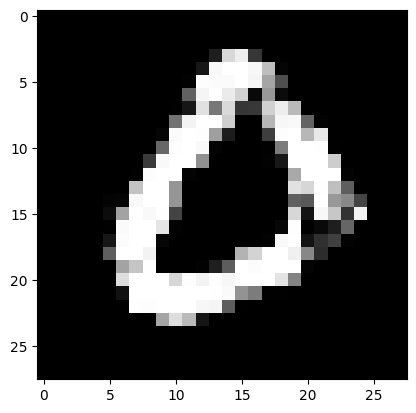

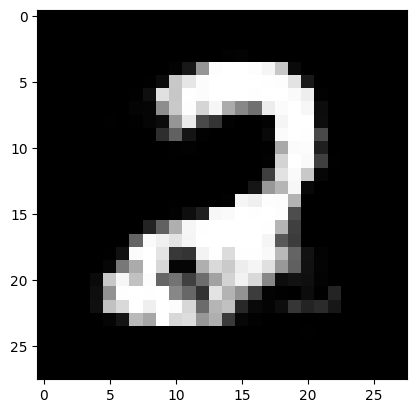

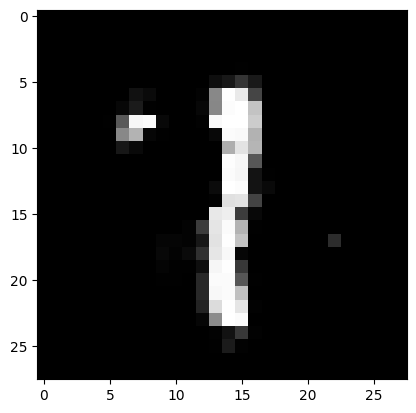

Epoch: 62550
loss_g: 0.7485116124153137 	loss_d: 1.345966100692749
Epoch: 62600
loss_g: 0.7961630821228027 	loss_d: 1.3821806907653809
Epoch: 62650
loss_g: 0.7626633048057556 	loss_d: 1.2985727787017822
Epoch: 62700
loss_g: 0.7989413142204285 	loss_d: 1.2909891605377197
Epoch: 62750
loss_g: 0.7654493451118469 	loss_d: 1.3873438835144043
Epoch: 62800
loss_g: 0.7560907602310181 	loss_d: 1.3656775951385498
Epoch: 62850
loss_g: 0.7517005205154419 	loss_d: 1.3525382280349731
Epoch: 62900
loss_g: 0.7080052495002747 	loss_d: 1.352936029434204
Epoch: 62950
loss_g: 0.8062132000923157 	loss_d: 1.3962986469268799
Epoch: 63000
loss_g: 0.7340226769447327 	loss_d: 1.3588001728057861


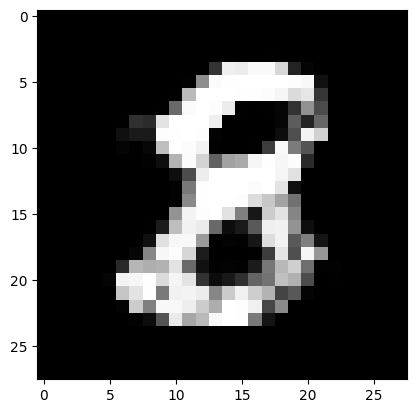

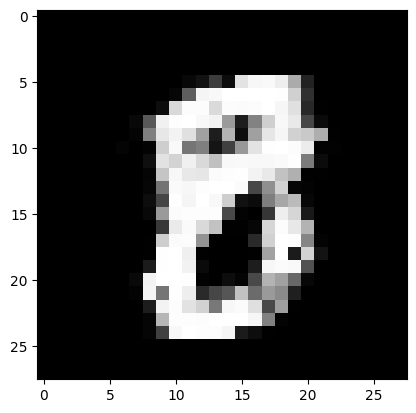

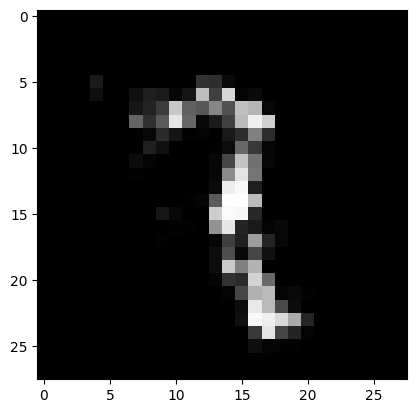

Epoch: 63050
loss_g: 0.7524356842041016 	loss_d: 1.3392595052719116
Epoch: 63100
loss_g: 0.7583152055740356 	loss_d: 1.4067986011505127
Epoch: 63150
loss_g: 0.7435206174850464 	loss_d: 1.300978183746338
Epoch: 63200
loss_g: 0.7606030106544495 	loss_d: 1.3724335432052612
Epoch: 63250
loss_g: 0.752802848815918 	loss_d: 1.3764681816101074
Epoch: 63300
loss_g: 0.7533348202705383 	loss_d: 1.3307383060455322
Epoch: 63350
loss_g: 0.7618142366409302 	loss_d: 1.3569514751434326
Epoch: 63400
loss_g: 0.8050289154052734 	loss_d: 1.3947014808654785
Epoch: 63450
loss_g: 0.8246299624443054 	loss_d: 1.34281325340271
Epoch: 63500
loss_g: 0.7575245499610901 	loss_d: 1.3602216243743896


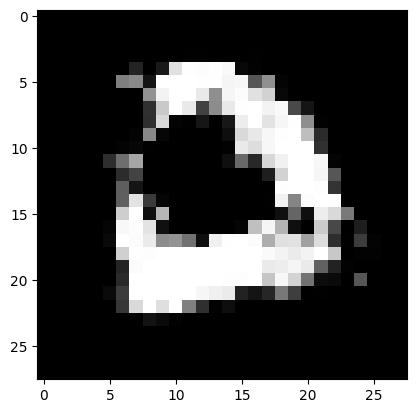

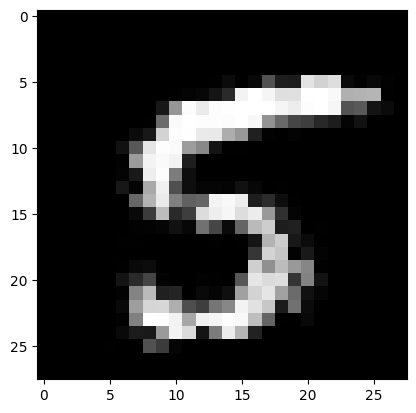

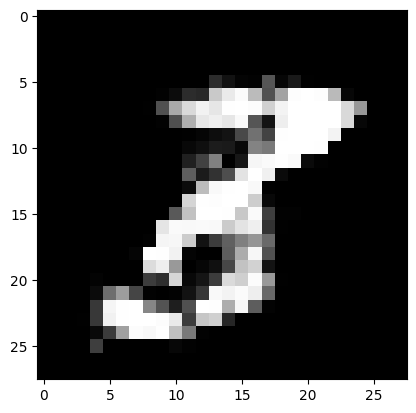

Epoch: 63550
loss_g: 0.7566721439361572 	loss_d: 1.285226583480835
Epoch: 63600
loss_g: 0.8014805316925049 	loss_d: 1.3583272695541382
Epoch: 63650
loss_g: 0.7813985347747803 	loss_d: 1.3431651592254639
Epoch: 63700
loss_g: 0.7433134913444519 	loss_d: 1.3265125751495361
Epoch: 63750
loss_g: 0.789448082447052 	loss_d: 1.3303883075714111
Epoch: 63800
loss_g: 0.7304663062095642 	loss_d: 1.3129017353057861
Epoch: 63850
loss_g: 0.7528818249702454 	loss_d: 1.2946802377700806
Epoch: 63900
loss_g: 0.7841242551803589 	loss_d: 1.3850433826446533
Epoch: 63950
loss_g: 0.7509409189224243 	loss_d: 1.4027621746063232
Epoch: 64000
loss_g: 0.8019631505012512 	loss_d: 1.2576875686645508


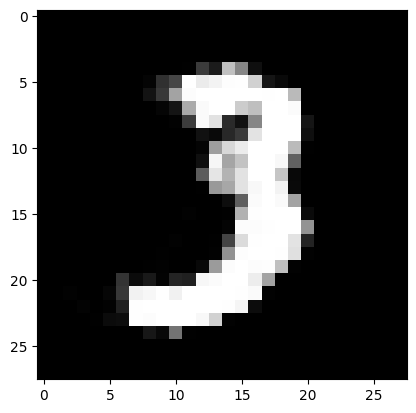

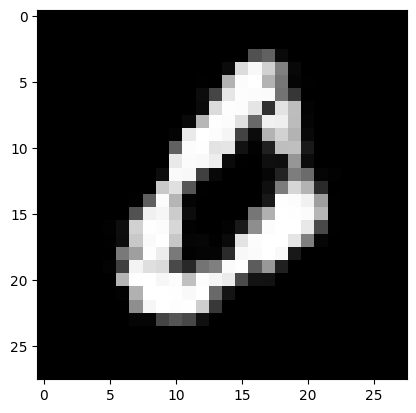

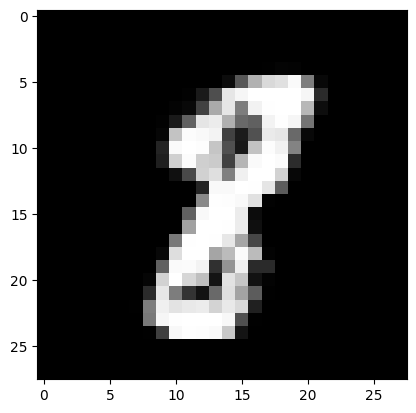

Epoch: 64050
loss_g: 0.7840017676353455 	loss_d: 1.383504867553711
Epoch: 64100
loss_g: 0.7464730739593506 	loss_d: 1.415074348449707
Epoch: 64150
loss_g: 0.7541084289550781 	loss_d: 1.3920209407806396
Epoch: 64200
loss_g: 0.7297358512878418 	loss_d: 1.3881919384002686
Epoch: 64250
loss_g: 0.7211382985115051 	loss_d: 1.3026527166366577
Epoch: 64300
loss_g: 0.7803152203559875 	loss_d: 1.2993733882904053
Epoch: 64350
loss_g: 0.8057077527046204 	loss_d: 1.3307271003723145
Epoch: 64400
loss_g: 0.770965576171875 	loss_d: 1.3207149505615234
Epoch: 64450
loss_g: 0.8178427219390869 	loss_d: 1.319253921508789
Epoch: 64500
loss_g: 0.7234904170036316 	loss_d: 1.3853864669799805


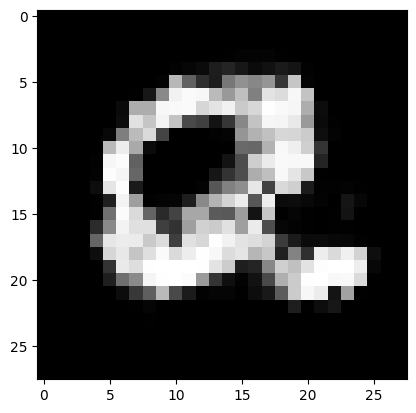

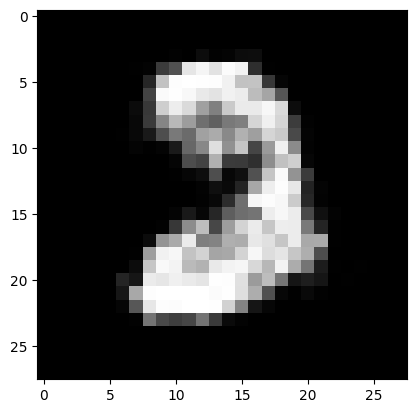

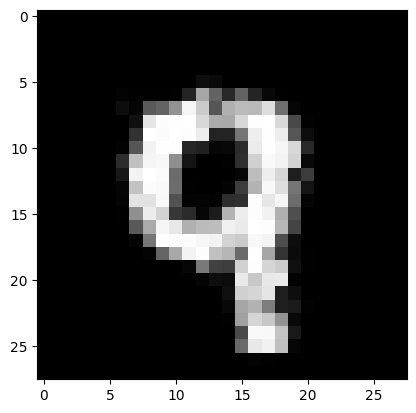

Epoch: 64550
loss_g: 0.7276998162269592 	loss_d: 1.3350708484649658
Epoch: 64600
loss_g: 0.7467785477638245 	loss_d: 1.3835982084274292
Epoch: 64650
loss_g: 0.7588226199150085 	loss_d: 1.3200018405914307
Epoch: 64700
loss_g: 0.7943323850631714 	loss_d: 1.3691998720169067
Epoch: 64750
loss_g: 0.7565145492553711 	loss_d: 1.3416929244995117
Epoch: 64800
loss_g: 0.7926437258720398 	loss_d: 1.3335915803909302
Epoch: 64850
loss_g: 0.7684482932090759 	loss_d: 1.3393185138702393
Epoch: 64900
loss_g: 0.7798641324043274 	loss_d: 1.3747820854187012
Epoch: 64950
loss_g: 0.7795013785362244 	loss_d: 1.290210485458374
Epoch: 65000
loss_g: 0.7756922841072083 	loss_d: 1.2774726152420044


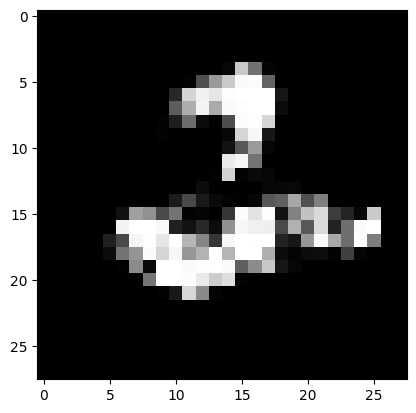

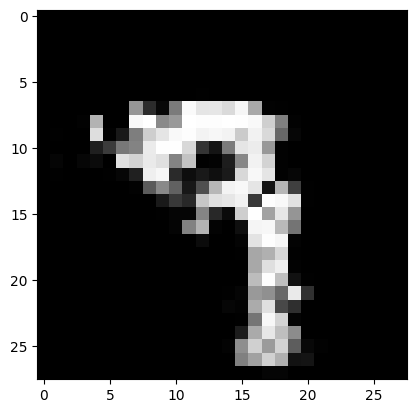

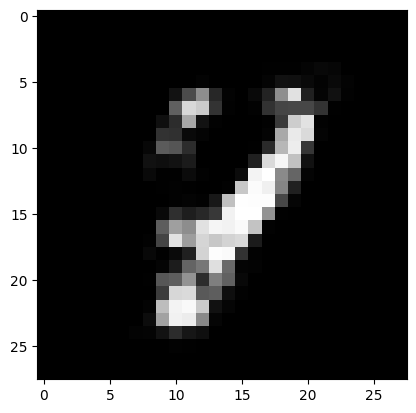

Epoch: 65050
loss_g: 0.7860649228096008 	loss_d: 1.3408167362213135
Epoch: 65100
loss_g: 0.7360676527023315 	loss_d: 1.361611247062683
Epoch: 65150
loss_g: 0.7641106843948364 	loss_d: 1.3050224781036377
Epoch: 65200
loss_g: 0.7367083430290222 	loss_d: 1.3051156997680664
Epoch: 65250
loss_g: 0.7598008513450623 	loss_d: 1.381180763244629
Epoch: 65300
loss_g: 0.8025643825531006 	loss_d: 1.2742016315460205
Epoch: 65350
loss_g: 0.7720498442649841 	loss_d: 1.3692078590393066
Epoch: 65400
loss_g: 0.7883297801017761 	loss_d: 1.3089938163757324
Epoch: 65450
loss_g: 0.7975662350654602 	loss_d: 1.3044310808181763
Epoch: 65500
loss_g: 0.7358545660972595 	loss_d: 1.4094703197479248


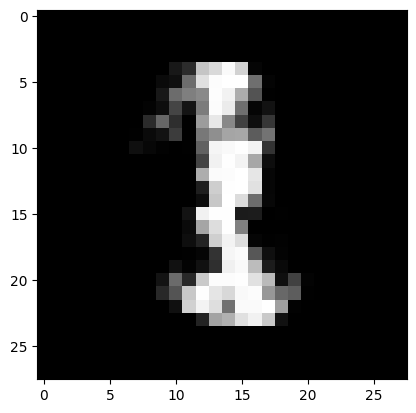

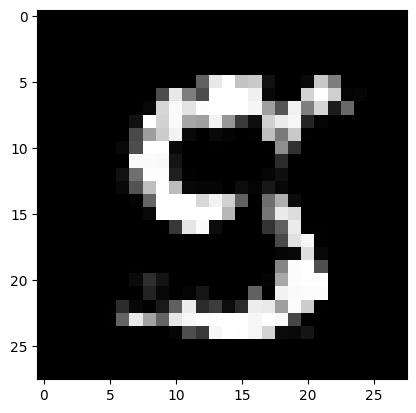

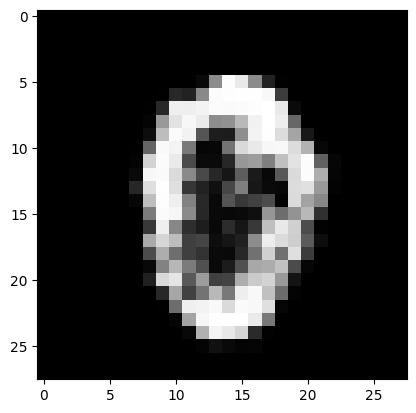

Epoch: 65550
loss_g: 0.7759726643562317 	loss_d: 1.2858142852783203
Epoch: 65600
loss_g: 0.7524861097335815 	loss_d: 1.319916009902954
Epoch: 65650
loss_g: 0.7615139484405518 	loss_d: 1.3784215450286865
Epoch: 65700
loss_g: 0.7421118021011353 	loss_d: 1.2825779914855957
Epoch: 65750
loss_g: 0.7983478903770447 	loss_d: 1.3254811763763428
Epoch: 65800
loss_g: 0.8313971757888794 	loss_d: 1.308241605758667
Epoch: 65850
loss_g: 0.787573516368866 	loss_d: 1.2919378280639648
Epoch: 65900
loss_g: 0.7719838619232178 	loss_d: 1.3521993160247803
Epoch: 65950
loss_g: 0.8323718905448914 	loss_d: 1.2990336418151855
Epoch: 66000
loss_g: 0.7700958251953125 	loss_d: 1.364196538925171


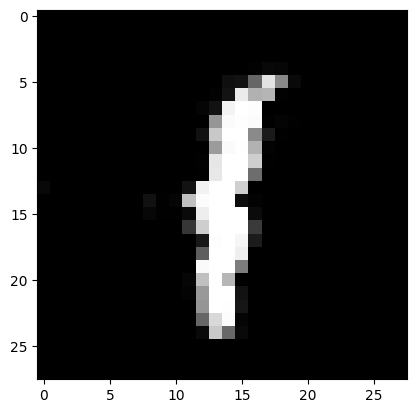

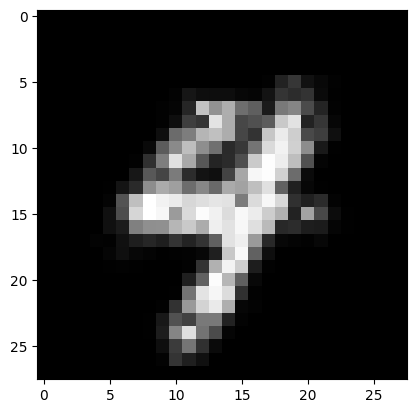

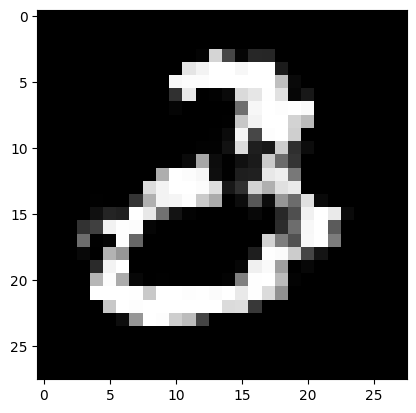

Epoch: 66050
loss_g: 0.7427157163619995 	loss_d: 1.2870588302612305
Epoch: 66100
loss_g: 0.8385767340660095 	loss_d: 1.2952942848205566
Epoch: 66150
loss_g: 0.7885192632675171 	loss_d: 1.293938398361206
Epoch: 66200
loss_g: 0.8383169174194336 	loss_d: 1.2972729206085205
Epoch: 66250
loss_g: 0.8288056254386902 	loss_d: 1.2869088649749756
Epoch: 66300
loss_g: 0.7593008279800415 	loss_d: 1.361967921257019
Epoch: 66350
loss_g: 0.8267773389816284 	loss_d: 1.3017297983169556
Epoch: 66400
loss_g: 0.8135438561439514 	loss_d: 1.3188648223876953
Epoch: 66450
loss_g: 0.7441035509109497 	loss_d: 1.3564143180847168
Epoch: 66500
loss_g: 0.7350196838378906 	loss_d: 1.331036925315857


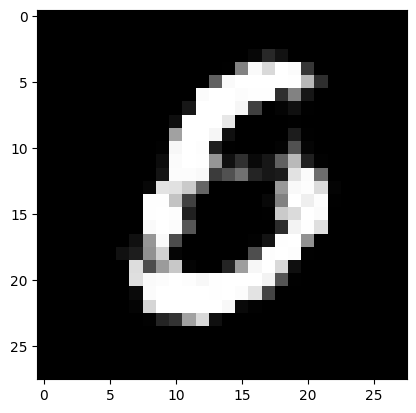

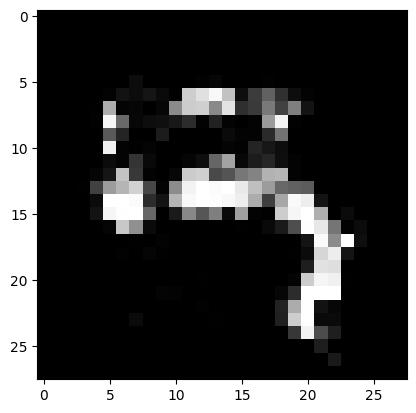

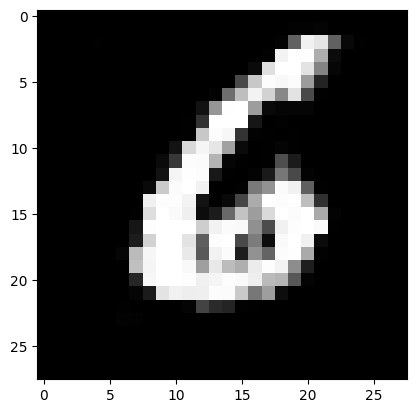

Epoch: 66550
loss_g: 0.7725199460983276 	loss_d: 1.323925256729126
Epoch: 66600
loss_g: 0.7809962034225464 	loss_d: 1.3614068031311035
Epoch: 66650
loss_g: 0.7351221442222595 	loss_d: 1.3358769416809082
Epoch: 66700
loss_g: 0.8272585868835449 	loss_d: 1.259368658065796
Epoch: 66750
loss_g: 0.8532376885414124 	loss_d: 1.3974790573120117
Epoch: 66800
loss_g: 0.790176510810852 	loss_d: 1.39617919921875
Epoch: 66850
loss_g: 0.7541400194168091 	loss_d: 1.3513621091842651
Epoch: 66900
loss_g: 0.7925089597702026 	loss_d: 1.2461048364639282
Epoch: 66950
loss_g: 0.7965173125267029 	loss_d: 1.3412935733795166
Epoch: 67000
loss_g: 0.7856233716011047 	loss_d: 1.350292682647705


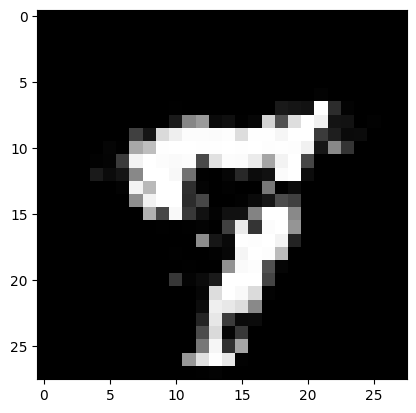

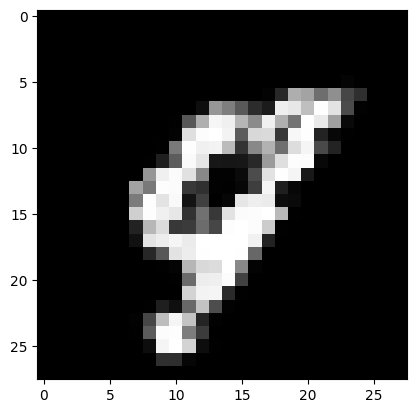

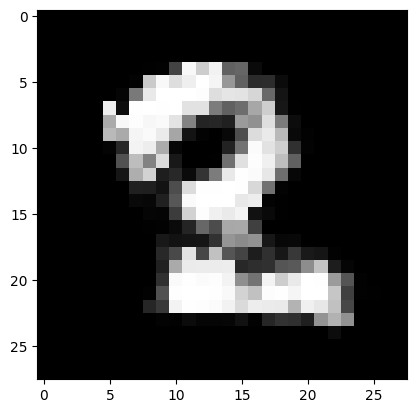

Epoch: 67050
loss_g: 0.7166250944137573 	loss_d: 1.3184192180633545
Epoch: 67100
loss_g: 0.8064997792243958 	loss_d: 1.310107946395874
Epoch: 67150
loss_g: 0.7736029028892517 	loss_d: 1.361574411392212
Epoch: 67200
loss_g: 0.8156054615974426 	loss_d: 1.2546985149383545
Epoch: 67250
loss_g: 0.7500135898590088 	loss_d: 1.3269579410552979
Epoch: 67300
loss_g: 0.7591103911399841 	loss_d: 1.3287267684936523
Epoch: 67350
loss_g: 0.821165144443512 	loss_d: 1.3867921829223633
Epoch: 67400
loss_g: 0.7917161583900452 	loss_d: 1.3427932262420654
Epoch: 67450
loss_g: 0.7441596984863281 	loss_d: 1.311457872390747
Epoch: 67500
loss_g: 0.8039073944091797 	loss_d: 1.331498384475708


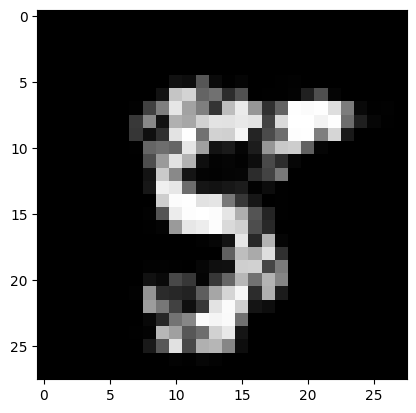

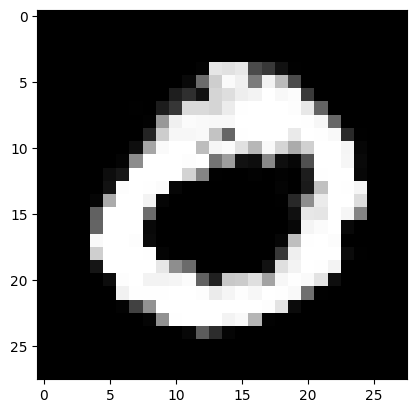

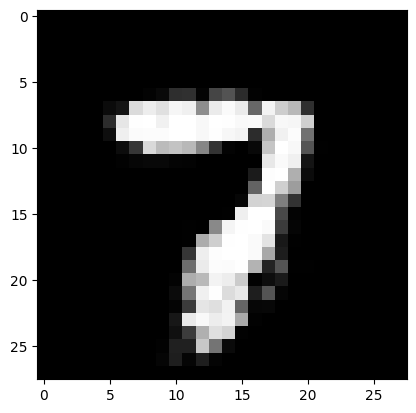

Epoch: 67550
loss_g: 0.745083749294281 	loss_d: 1.3346881866455078
Epoch: 67600
loss_g: 0.7943801879882812 	loss_d: 1.3340723514556885
Epoch: 67650
loss_g: 0.8563910722732544 	loss_d: 1.2945401668548584
Epoch: 67700
loss_g: 0.8370702266693115 	loss_d: 1.340578556060791
Epoch: 67750
loss_g: 0.8239602446556091 	loss_d: 1.3325908184051514
Epoch: 67800
loss_g: 0.7921726703643799 	loss_d: 1.3406226634979248
Epoch: 67850
loss_g: 0.7671548128128052 	loss_d: 1.3586145639419556
Epoch: 67900
loss_g: 0.8153043985366821 	loss_d: 1.293959140777588
Epoch: 67950
loss_g: 0.8123185634613037 	loss_d: 1.312420129776001
Epoch: 68000
loss_g: 0.7708187699317932 	loss_d: 1.3272268772125244


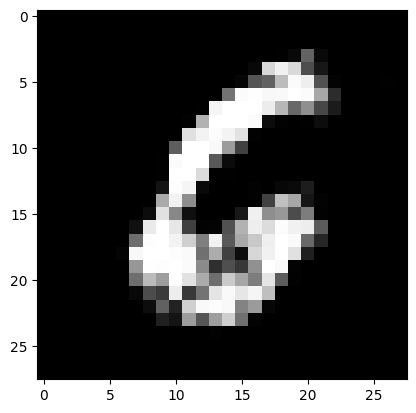

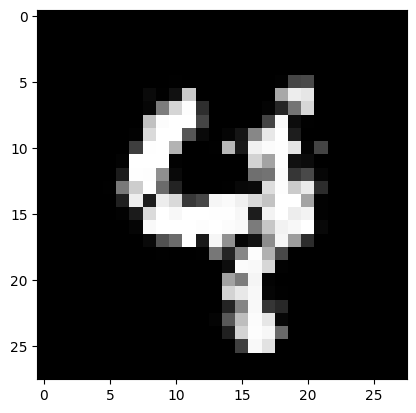

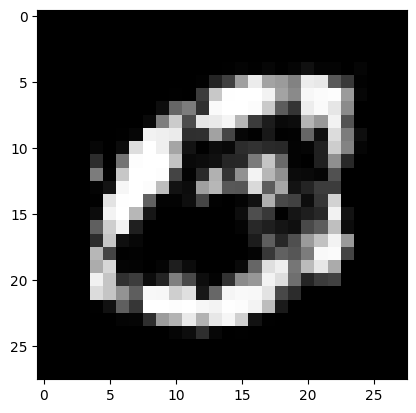

Epoch: 68050
loss_g: 0.8072197437286377 	loss_d: 1.3264870643615723
Epoch: 68100
loss_g: 0.7451789975166321 	loss_d: 1.3312013149261475
Epoch: 68150
loss_g: 0.7809171080589294 	loss_d: 1.3069484233856201
Epoch: 68200
loss_g: 0.7733522057533264 	loss_d: 1.3263019323349
Epoch: 68250
loss_g: 0.8098984956741333 	loss_d: 1.3699960708618164
Epoch: 68300
loss_g: 0.7834444046020508 	loss_d: 1.3281899690628052
Epoch: 68350
loss_g: 0.7842200994491577 	loss_d: 1.2946712970733643
Epoch: 68400
loss_g: 0.7454221844673157 	loss_d: 1.3588159084320068
Epoch: 68450
loss_g: 0.825413703918457 	loss_d: 1.3271242380142212
Epoch: 68500
loss_g: 0.7958291172981262 	loss_d: 1.3349589109420776


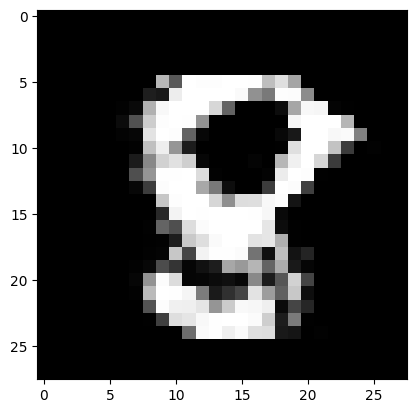

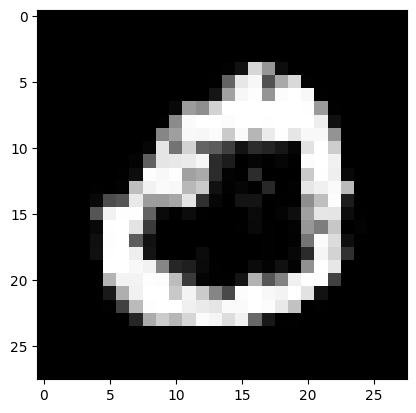

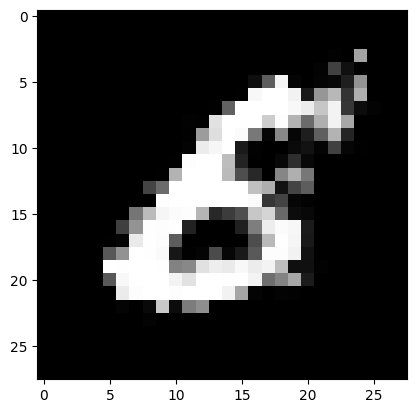

Epoch: 68550
loss_g: 0.7542739510536194 	loss_d: 1.3268070220947266
Epoch: 68600
loss_g: 0.7412921786308289 	loss_d: 1.3337631225585938
Epoch: 68650
loss_g: 0.7990464568138123 	loss_d: 1.3141896724700928
Epoch: 68700
loss_g: 0.748299241065979 	loss_d: 1.3658404350280762
Epoch: 68750
loss_g: 0.8256243467330933 	loss_d: 1.2142415046691895
Epoch: 68800
loss_g: 0.8503539562225342 	loss_d: 1.3406438827514648
Epoch: 68850
loss_g: 0.7786959409713745 	loss_d: 1.3619053363800049
Epoch: 68900
loss_g: 0.7440857291221619 	loss_d: 1.3194255828857422
Epoch: 68950
loss_g: 0.7172907590866089 	loss_d: 1.32193922996521
Epoch: 69000
loss_g: 0.7457758784294128 	loss_d: 1.3455169200897217


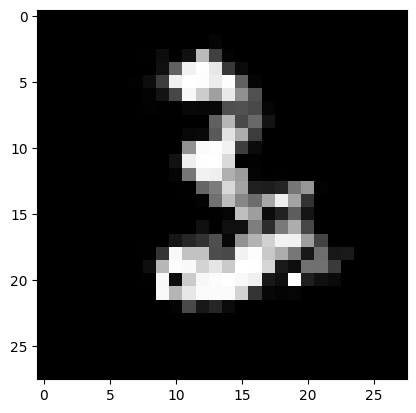

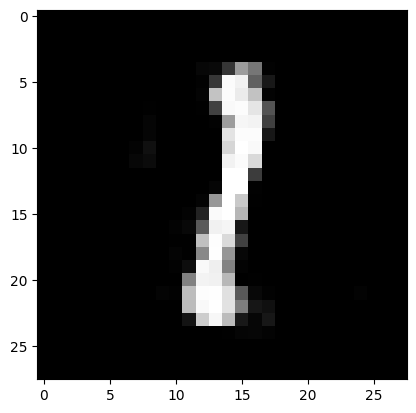

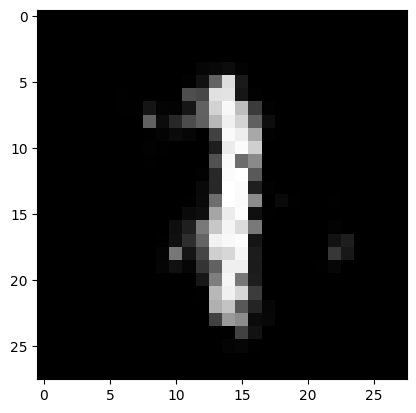

Epoch: 69050
loss_g: 0.7313869595527649 	loss_d: 1.329200267791748
Epoch: 69100
loss_g: 0.7604038715362549 	loss_d: 1.381438970565796
Epoch: 69150
loss_g: 0.7173370122909546 	loss_d: 1.359339952468872
Epoch: 69200
loss_g: 0.7951356172561646 	loss_d: 1.308414340019226
Epoch: 69250
loss_g: 0.8399422764778137 	loss_d: 1.3416707515716553
Epoch: 69300
loss_g: 0.7311977744102478 	loss_d: 1.371251106262207
Epoch: 69350
loss_g: 0.7293710708618164 	loss_d: 1.340492606163025
Epoch: 69400
loss_g: 0.8037734627723694 	loss_d: 1.3971049785614014
Epoch: 69450
loss_g: 0.8215757608413696 	loss_d: 1.330196499824524
Epoch: 69500
loss_g: 0.7588286995887756 	loss_d: 1.3365302085876465


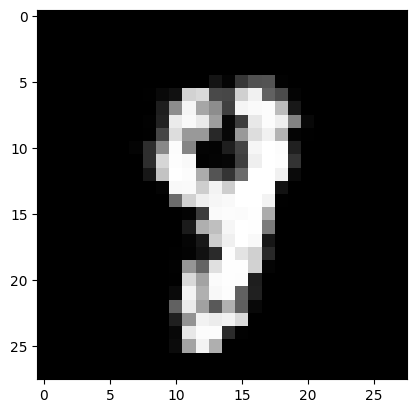

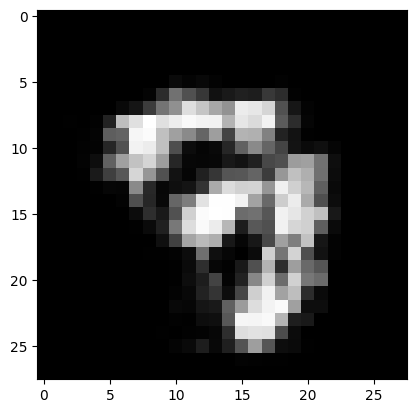

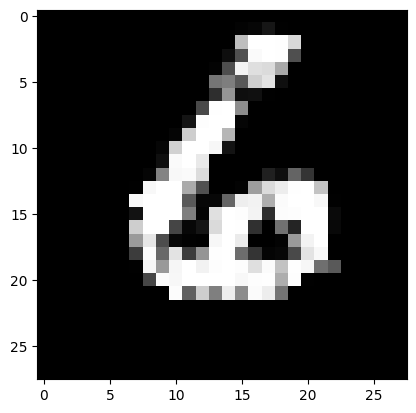

Epoch: 69550
loss_g: 0.8386647701263428 	loss_d: 1.2901276350021362
Epoch: 69600
loss_g: 0.8379608988761902 	loss_d: 1.3135945796966553
Epoch: 69650
loss_g: 0.7888718843460083 	loss_d: 1.2928555011749268
Epoch: 69700
loss_g: 0.8183940052986145 	loss_d: 1.3147976398468018
Epoch: 69750
loss_g: 0.7900631427764893 	loss_d: 1.3334013223648071
Epoch: 69800
loss_g: 0.7957795262336731 	loss_d: 1.292701244354248
Epoch: 69850
loss_g: 0.787352442741394 	loss_d: 1.3075028657913208
Epoch: 69900
loss_g: 0.7133712768554688 	loss_d: 1.3568609952926636
Epoch: 69950
loss_g: 0.7673888802528381 	loss_d: 1.306302547454834
Epoch: 70000
loss_g: 0.8322585821151733 	loss_d: 1.2782795429229736


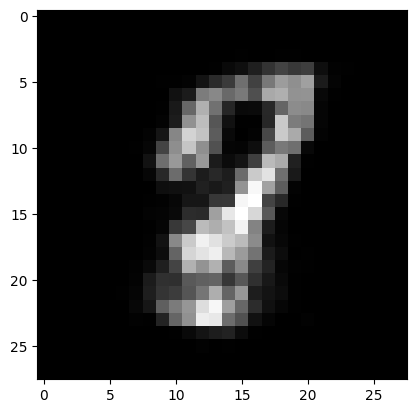

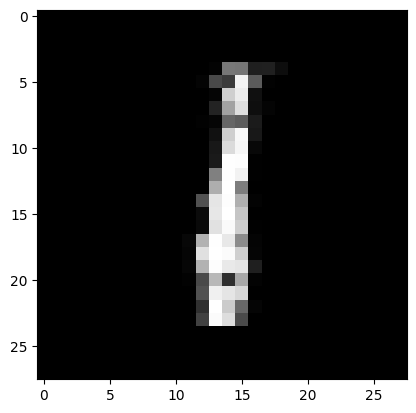

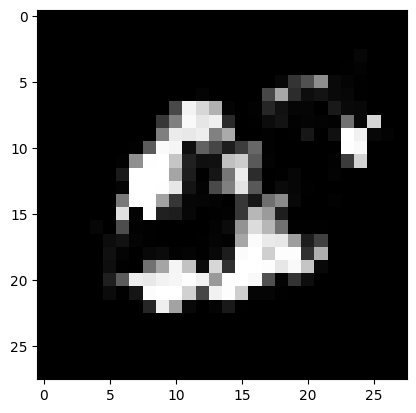

Epoch: 70050
loss_g: 0.9031625390052795 	loss_d: 1.3412137031555176
Epoch: 70100
loss_g: 0.7267873287200928 	loss_d: 1.2797889709472656
Epoch: 70150
loss_g: 0.8023602366447449 	loss_d: 1.3596675395965576
Epoch: 70200
loss_g: 0.7355077862739563 	loss_d: 1.32981276512146
Epoch: 70250
loss_g: 0.7980697751045227 	loss_d: 1.336457371711731
Epoch: 70300
loss_g: 0.8164131045341492 	loss_d: 1.333925724029541
Epoch: 70350
loss_g: 0.8061185479164124 	loss_d: 1.2843329906463623
Epoch: 70400
loss_g: 0.7780857682228088 	loss_d: 1.3648252487182617
Epoch: 70450
loss_g: 0.8352027535438538 	loss_d: 1.364811897277832
Epoch: 70500
loss_g: 0.7903320789337158 	loss_d: 1.369522213935852


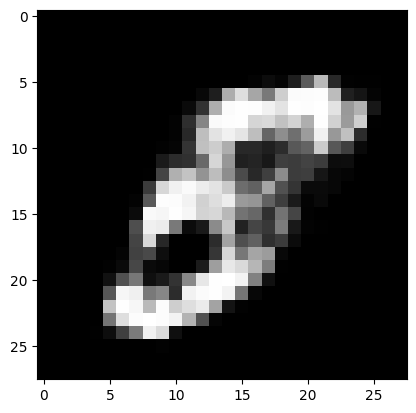

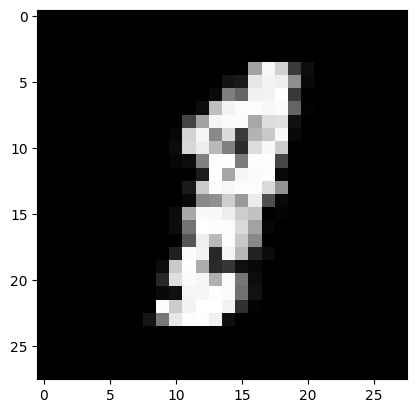

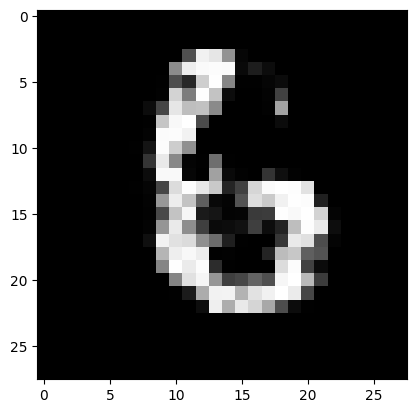

Epoch: 70550
loss_g: 0.7415394186973572 	loss_d: 1.380295991897583
Epoch: 70600
loss_g: 0.7712178826332092 	loss_d: 1.3347022533416748
Epoch: 70650
loss_g: 0.7740756273269653 	loss_d: 1.3276174068450928
Epoch: 70700
loss_g: 0.7952777743339539 	loss_d: 1.3485214710235596
Epoch: 70750
loss_g: 0.8188570737838745 	loss_d: 1.3275120258331299
Epoch: 70800
loss_g: 0.7478313446044922 	loss_d: 1.2999837398529053
Epoch: 70850
loss_g: 0.8057751059532166 	loss_d: 1.3401068449020386
Epoch: 70900
loss_g: 0.7920834422111511 	loss_d: 1.2333614826202393
Epoch: 70950
loss_g: 0.7875217795372009 	loss_d: 1.358028531074524
Epoch: 71000
loss_g: 0.7741007804870605 	loss_d: 1.3092060089111328


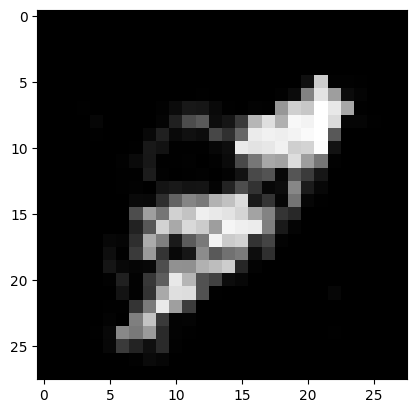

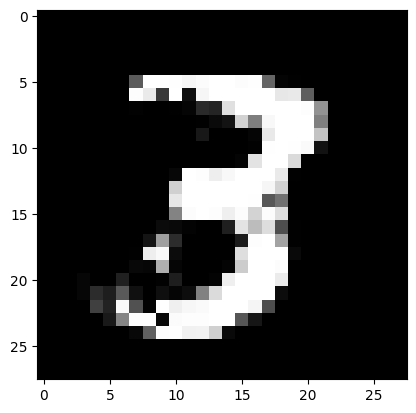

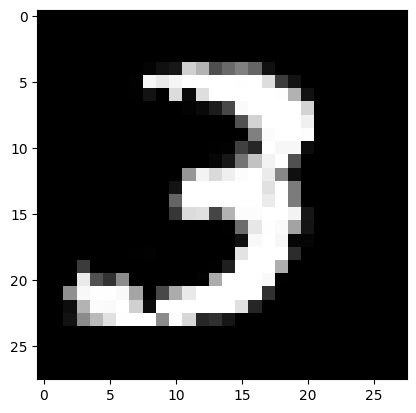

Epoch: 71050
loss_g: 0.7795554995536804 	loss_d: 1.3508864641189575
Epoch: 71100
loss_g: 0.7657936215400696 	loss_d: 1.3361700773239136
Epoch: 71150
loss_g: 0.7561469674110413 	loss_d: 1.2995483875274658
Epoch: 71200
loss_g: 0.7782392501831055 	loss_d: 1.3294758796691895
Epoch: 71250
loss_g: 0.8277269005775452 	loss_d: 1.3365010023117065
Epoch: 71300
loss_g: 0.7674466371536255 	loss_d: 1.2490673065185547
Epoch: 71350
loss_g: 0.7943671941757202 	loss_d: 1.2930715084075928
Epoch: 71400
loss_g: 0.7756136655807495 	loss_d: 1.3031654357910156
Epoch: 71450
loss_g: 0.7579827904701233 	loss_d: 1.3423810005187988
Epoch: 71500
loss_g: 0.8073059916496277 	loss_d: 1.3529070615768433


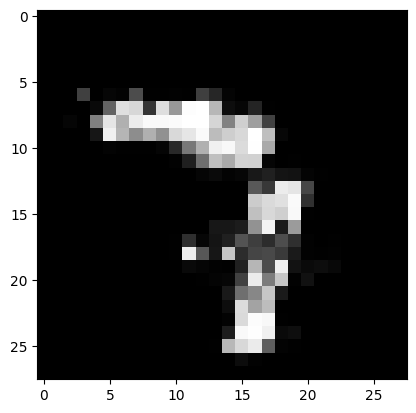

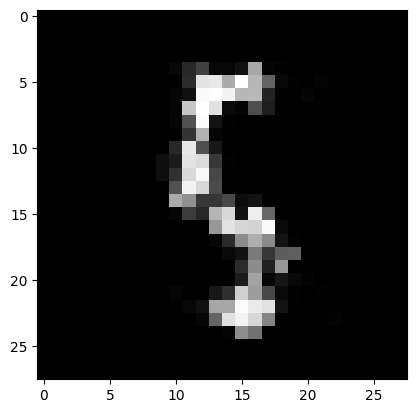

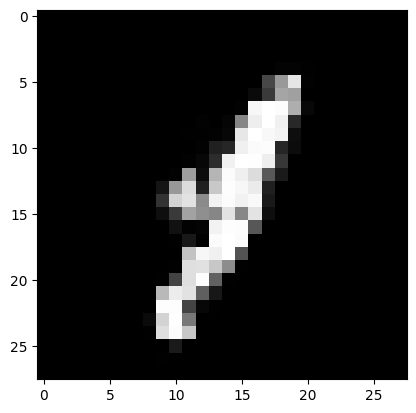

Epoch: 71550
loss_g: 0.780430257320404 	loss_d: 1.4187101125717163
Epoch: 71600
loss_g: 0.7668859958648682 	loss_d: 1.3539005517959595
Epoch: 71650
loss_g: 0.7832666635513306 	loss_d: 1.2890653610229492
Epoch: 71700
loss_g: 0.7997804284095764 	loss_d: 1.3676519393920898
Epoch: 71750
loss_g: 0.8032029271125793 	loss_d: 1.3053267002105713
Epoch: 71800
loss_g: 0.8424724340438843 	loss_d: 1.3513751029968262
Epoch: 71850
loss_g: 0.8443230390548706 	loss_d: 1.2992444038391113
Epoch: 71900
loss_g: 0.7747107744216919 	loss_d: 1.3063939809799194
Epoch: 71950
loss_g: 0.8520994186401367 	loss_d: 1.336482048034668
Epoch: 72000
loss_g: 0.7904639840126038 	loss_d: 1.3274540901184082


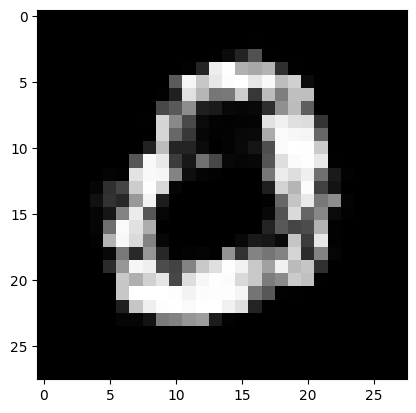

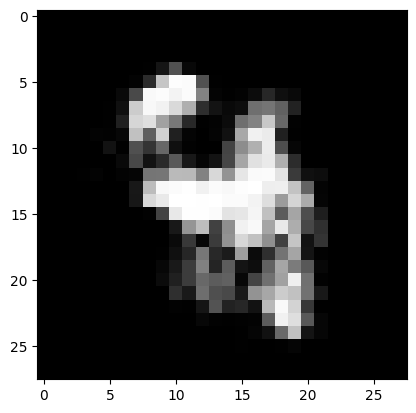

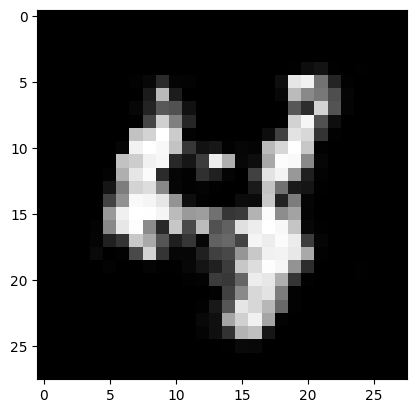

Epoch: 72050
loss_g: 0.8037554621696472 	loss_d: 1.2513980865478516
Epoch: 72100
loss_g: 0.7630605697631836 	loss_d: 1.2851417064666748
Epoch: 72150
loss_g: 0.7629725337028503 	loss_d: 1.3393983840942383
Epoch: 72200
loss_g: 0.7855843305587769 	loss_d: 1.345454454421997
Epoch: 72250
loss_g: 0.8192773461341858 	loss_d: 1.3411345481872559
Epoch: 72300
loss_g: 0.7343335747718811 	loss_d: 1.3197283744812012
Epoch: 72350
loss_g: 0.8088330626487732 	loss_d: 1.2540637254714966
Epoch: 72400
loss_g: 0.777252733707428 	loss_d: 1.3345284461975098
Epoch: 72450
loss_g: 0.7501359581947327 	loss_d: 1.3181877136230469
Epoch: 72500
loss_g: 0.8232465982437134 	loss_d: 1.311901330947876


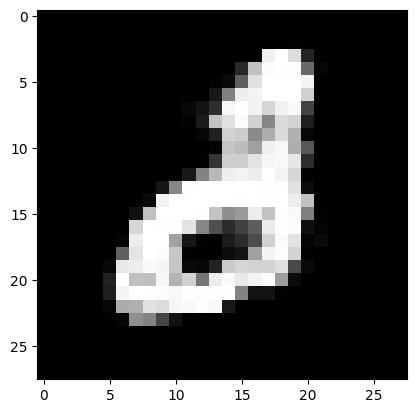

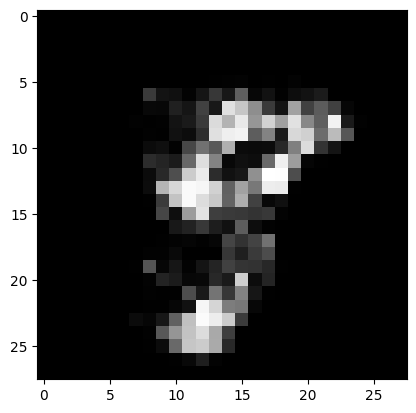

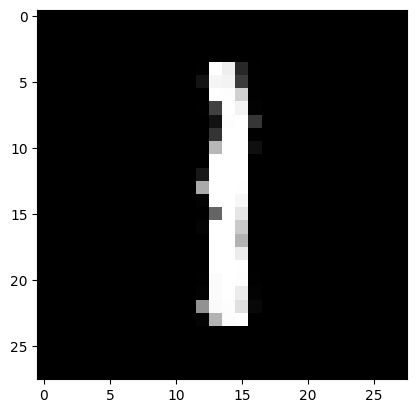

Epoch: 72550
loss_g: 0.7956472635269165 	loss_d: 1.3272643089294434
Epoch: 72600
loss_g: 0.7808944582939148 	loss_d: 1.3370697498321533
Epoch: 72650
loss_g: 0.8049181699752808 	loss_d: 1.3075193166732788
Epoch: 72700
loss_g: 0.8024201989173889 	loss_d: 1.3015241622924805
Epoch: 72750
loss_g: 0.7951432466506958 	loss_d: 1.3423075675964355
Epoch: 72800
loss_g: 0.7472656965255737 	loss_d: 1.3821715116500854
Epoch: 72850
loss_g: 0.7779342532157898 	loss_d: 1.2773804664611816
Epoch: 72900
loss_g: 0.8288134336471558 	loss_d: 1.3346171379089355
Epoch: 72950
loss_g: 0.8581002354621887 	loss_d: 1.3070430755615234
Epoch: 73000
loss_g: 0.7925096750259399 	loss_d: 1.400291919708252


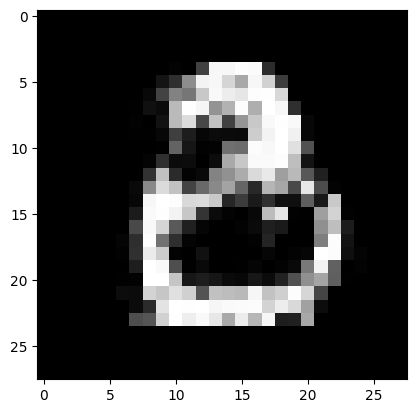

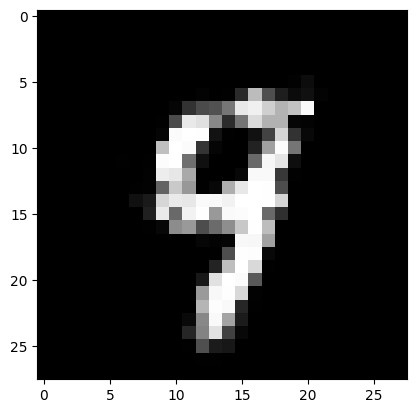

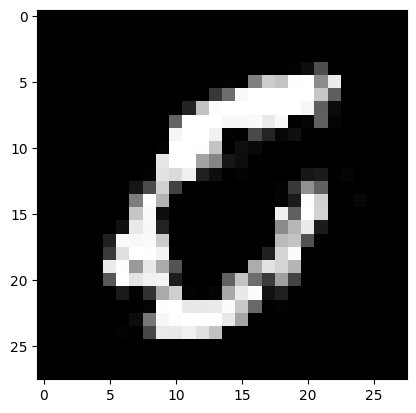

Epoch: 73050
loss_g: 0.7705798149108887 	loss_d: 1.3138117790222168
Epoch: 73100
loss_g: 0.7580678462982178 	loss_d: 1.3063228130340576
Epoch: 73150
loss_g: 0.8062859773635864 	loss_d: 1.291174292564392
Epoch: 73200
loss_g: 0.7207242250442505 	loss_d: 1.3559620380401611
Epoch: 73250
loss_g: 0.7723274230957031 	loss_d: 1.297910213470459
Epoch: 73300
loss_g: 0.754491925239563 	loss_d: 1.355057954788208
Epoch: 73350
loss_g: 0.8156276345252991 	loss_d: 1.2887510061264038
Epoch: 73400
loss_g: 0.8172406554222107 	loss_d: 1.3606531620025635
Epoch: 73450
loss_g: 0.8160158395767212 	loss_d: 1.2913340330123901
Epoch: 73500
loss_g: 0.7787036895751953 	loss_d: 1.3658936023712158


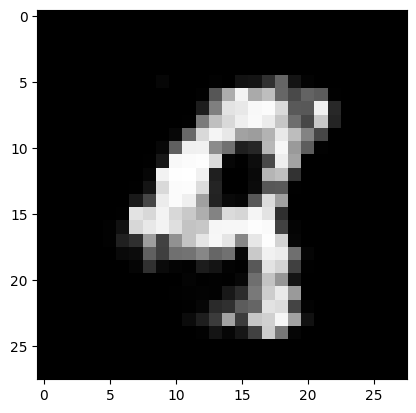

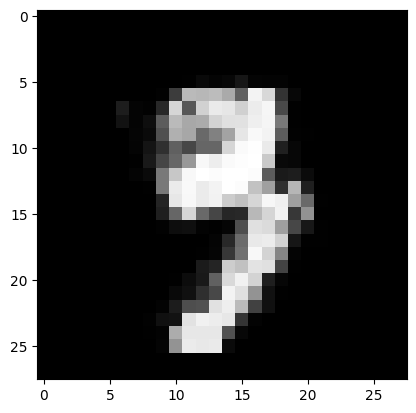

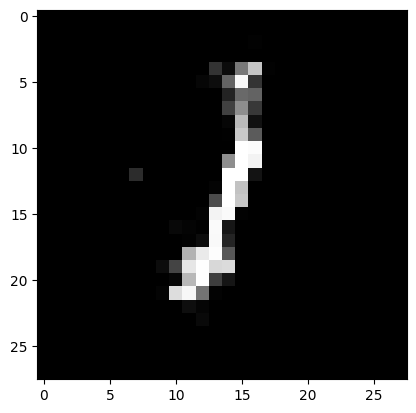

Epoch: 73550
loss_g: 0.8172768354415894 	loss_d: 1.2955822944641113
Epoch: 73600
loss_g: 0.7965481281280518 	loss_d: 1.2690770626068115
Epoch: 73650
loss_g: 0.7641994953155518 	loss_d: 1.2771122455596924
Epoch: 73700
loss_g: 0.7799423336982727 	loss_d: 1.301731824874878
Epoch: 73750
loss_g: 0.7802668809890747 	loss_d: 1.3174457550048828
Epoch: 73800
loss_g: 0.7800054550170898 	loss_d: 1.3959661722183228
Epoch: 73850
loss_g: 0.7349556088447571 	loss_d: 1.3412952423095703
Epoch: 73900
loss_g: 0.8171718120574951 	loss_d: 1.3412175178527832
Epoch: 73950
loss_g: 0.7942861914634705 	loss_d: 1.3141731023788452
Epoch: 74000
loss_g: 0.7390621900558472 	loss_d: 1.3500139713287354


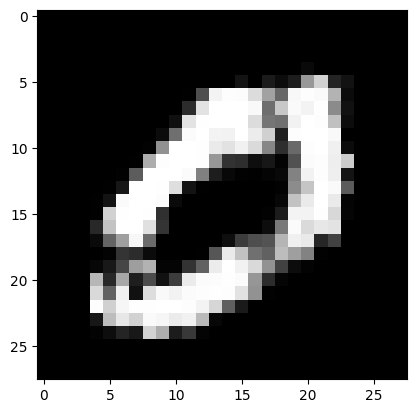

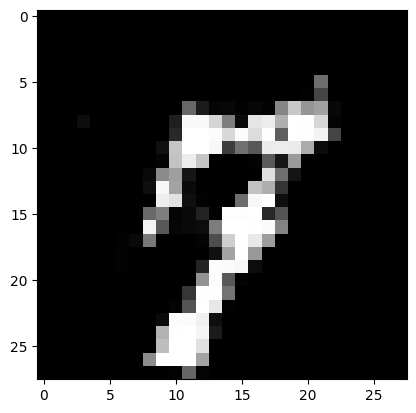

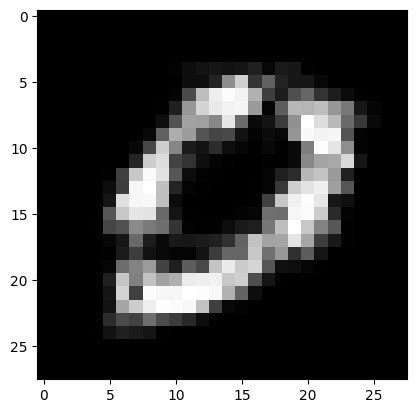

Epoch: 74050
loss_g: 0.8134655356407166 	loss_d: 1.2433671951293945
Epoch: 74100
loss_g: 0.7797631025314331 	loss_d: 1.2972123622894287
Epoch: 74150
loss_g: 0.8216645121574402 	loss_d: 1.3300395011901855
Epoch: 74200
loss_g: 0.7660068273544312 	loss_d: 1.3902738094329834
Epoch: 74250
loss_g: 0.7608898878097534 	loss_d: 1.3357510566711426
Epoch: 74300
loss_g: 0.805479884147644 	loss_d: 1.2744163274765015
Epoch: 74350
loss_g: 0.7882819771766663 	loss_d: 1.3066539764404297
Epoch: 74400
loss_g: 0.7547690272331238 	loss_d: 1.3546812534332275
Epoch: 74450
loss_g: 0.7578935027122498 	loss_d: 1.3269942998886108
Epoch: 74500
loss_g: 0.7710287570953369 	loss_d: 1.2993847131729126


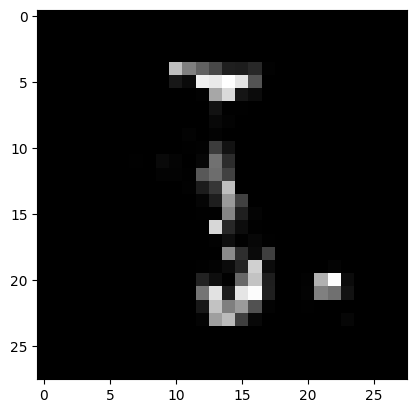

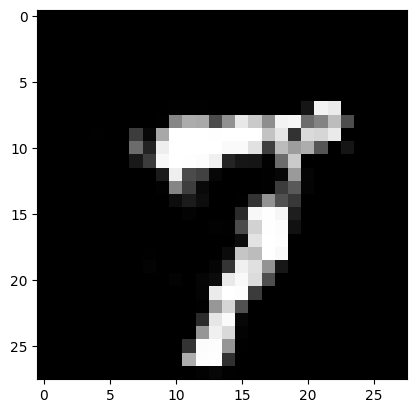

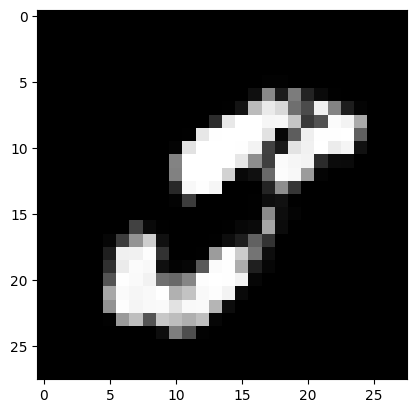

Epoch: 74550
loss_g: 0.7375223636627197 	loss_d: 1.3551229238510132
Epoch: 74600
loss_g: 0.786325991153717 	loss_d: 1.269287347793579
Epoch: 74650
loss_g: 0.7291555404663086 	loss_d: 1.3121833801269531
Epoch: 74700
loss_g: 0.7624068260192871 	loss_d: 1.2999839782714844
Epoch: 74750
loss_g: 0.7586294412612915 	loss_d: 1.3409123420715332
Epoch: 74800
loss_g: 0.824748694896698 	loss_d: 1.3679839372634888
Epoch: 74850
loss_g: 0.8155537247657776 	loss_d: 1.297472596168518
Epoch: 74900
loss_g: 0.7835061550140381 	loss_d: 1.319246768951416
Epoch: 74950
loss_g: 0.8269500732421875 	loss_d: 1.354396104812622
Epoch: 75000
loss_g: 0.7799252271652222 	loss_d: 1.3233528137207031


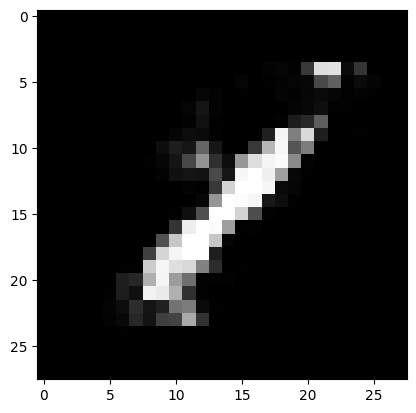

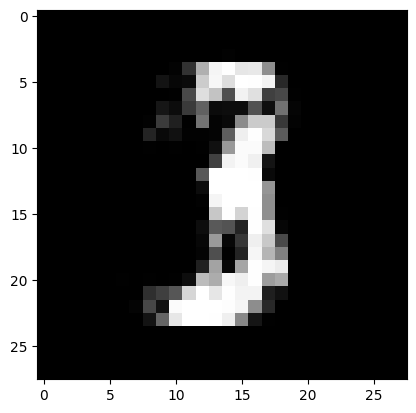

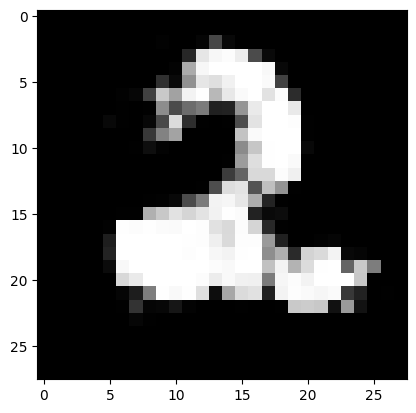

Epoch: 75050
loss_g: 0.7947548627853394 	loss_d: 1.2994568347930908
Epoch: 75100
loss_g: 0.7779409885406494 	loss_d: 1.3014682531356812
Epoch: 75150
loss_g: 0.7905510067939758 	loss_d: 1.3091826438903809
Epoch: 75200
loss_g: 0.8276537656784058 	loss_d: 1.4209321737289429
Epoch: 75250
loss_g: 0.7947090864181519 	loss_d: 1.3391656875610352
Epoch: 75300
loss_g: 0.8128625154495239 	loss_d: 1.2633473873138428
Epoch: 75350
loss_g: 0.8649494647979736 	loss_d: 1.3091347217559814
Epoch: 75400
loss_g: 0.8128512501716614 	loss_d: 1.2671573162078857
Epoch: 75450
loss_g: 0.7644762992858887 	loss_d: 1.3195550441741943
Epoch: 75500
loss_g: 0.7806581854820251 	loss_d: 1.239567756652832


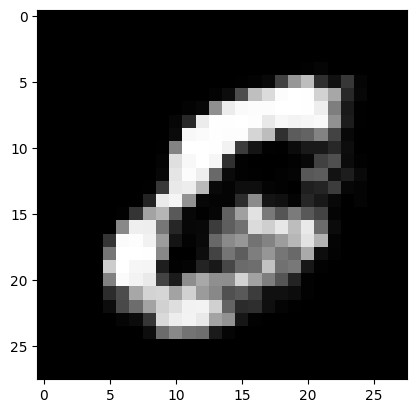

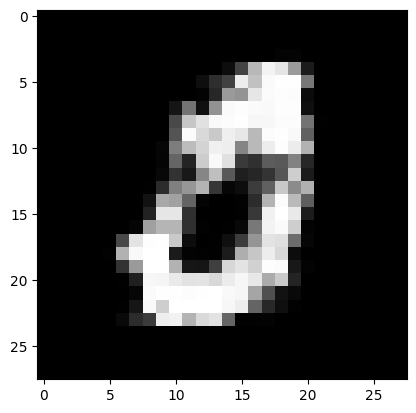

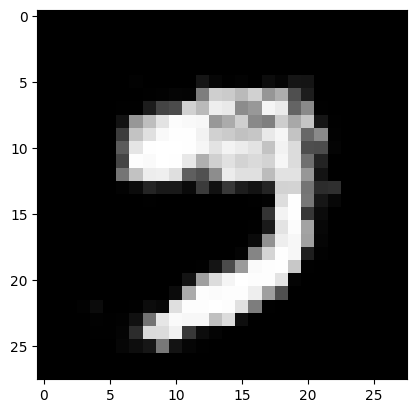

Epoch: 75550
loss_g: 0.8029241561889648 	loss_d: 1.3044300079345703
Epoch: 75600
loss_g: 0.8288673162460327 	loss_d: 1.2988684177398682
Epoch: 75650
loss_g: 0.747817873954773 	loss_d: 1.3645884990692139
Epoch: 75700
loss_g: 0.8023028373718262 	loss_d: 1.2811412811279297
Epoch: 75750
loss_g: 0.7445960640907288 	loss_d: 1.3327984809875488
Epoch: 75800
loss_g: 0.774124026298523 	loss_d: 1.2582738399505615
Epoch: 75850
loss_g: 0.8112471103668213 	loss_d: 1.28718900680542
Epoch: 75900
loss_g: 0.8205869793891907 	loss_d: 1.3523344993591309
Epoch: 75950
loss_g: 0.7960176467895508 	loss_d: 1.2774473428726196
Epoch: 76000
loss_g: 0.7786099314689636 	loss_d: 1.378303050994873


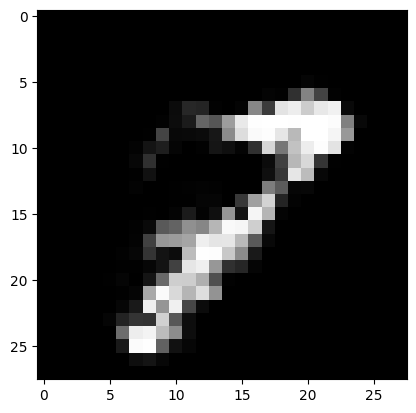

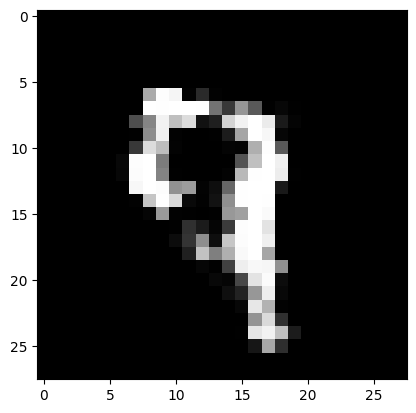

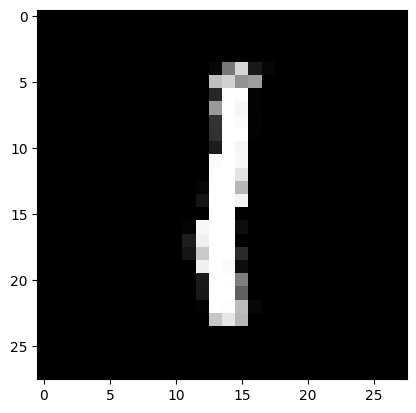

Epoch: 76050
loss_g: 0.8181756138801575 	loss_d: 1.2729406356811523
Epoch: 76100
loss_g: 0.7654950022697449 	loss_d: 1.2983040809631348
Epoch: 76150
loss_g: 0.7709625959396362 	loss_d: 1.3864436149597168
Epoch: 76200
loss_g: 0.8078203201293945 	loss_d: 1.2882778644561768
Epoch: 76250
loss_g: 0.794112503528595 	loss_d: 1.3195569515228271
Epoch: 76300
loss_g: 0.767197847366333 	loss_d: 1.31559157371521
Epoch: 76350
loss_g: 0.8336294293403625 	loss_d: 1.2353551387786865
Epoch: 76400
loss_g: 0.8395515084266663 	loss_d: 1.3352686166763306
Epoch: 76450
loss_g: 0.7706162929534912 	loss_d: 1.3252776861190796
Epoch: 76500
loss_g: 0.7989739179611206 	loss_d: 1.30539071559906


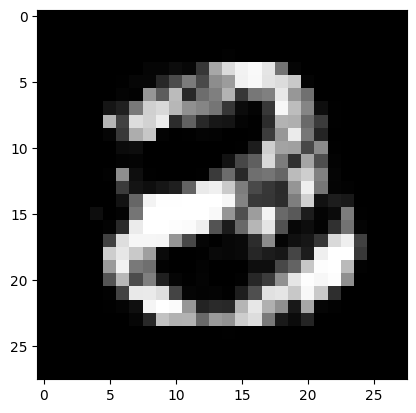

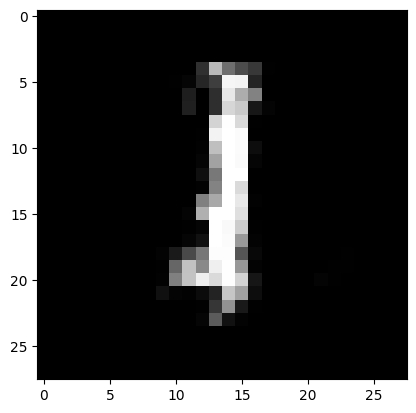

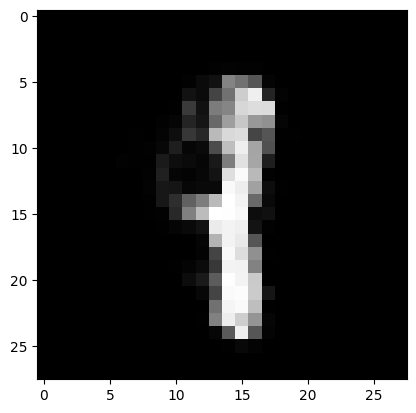

Epoch: 76550
loss_g: 0.8417999148368835 	loss_d: 1.3377805948257446
Epoch: 76600
loss_g: 0.7675190567970276 	loss_d: 1.3073844909667969
Epoch: 76650
loss_g: 0.7763774991035461 	loss_d: 1.2932350635528564
Epoch: 76700
loss_g: 0.7850462198257446 	loss_d: 1.3392504453659058
Epoch: 76750
loss_g: 0.8293203711509705 	loss_d: 1.317173719406128
Epoch: 76800
loss_g: 0.8054437041282654 	loss_d: 1.248021125793457
Epoch: 76850
loss_g: 0.736247718334198 	loss_d: 1.3875949382781982
Epoch: 76900
loss_g: 0.8321326971054077 	loss_d: 1.3109943866729736
Epoch: 76950
loss_g: 0.7663106918334961 	loss_d: 1.32855224609375
Epoch: 77000
loss_g: 0.7517263889312744 	loss_d: 1.294445276260376


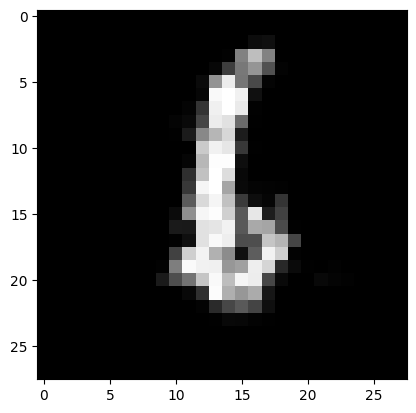

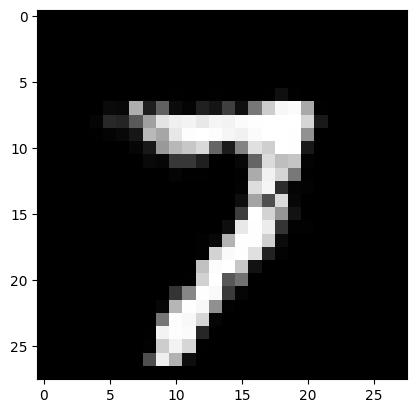

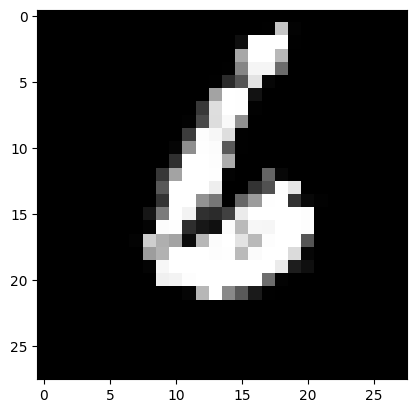

Epoch: 77050
loss_g: 0.7779651284217834 	loss_d: 1.3234283924102783
Epoch: 77100
loss_g: 0.747710108757019 	loss_d: 1.2996339797973633
Epoch: 77150
loss_g: 0.8198713660240173 	loss_d: 1.333559274673462
Epoch: 77200
loss_g: 0.7980395555496216 	loss_d: 1.3302127122879028
Epoch: 77250
loss_g: 0.7898377776145935 	loss_d: 1.302621603012085
Epoch: 77300
loss_g: 0.78287672996521 	loss_d: 1.3479907512664795
Epoch: 77350
loss_g: 0.7505953907966614 	loss_d: 1.298689842224121
Epoch: 77400
loss_g: 0.8346228003501892 	loss_d: 1.297084093093872
Epoch: 77450
loss_g: 0.8403612971305847 	loss_d: 1.3246365785598755
Epoch: 77500
loss_g: 0.7815468907356262 	loss_d: 1.3333415985107422


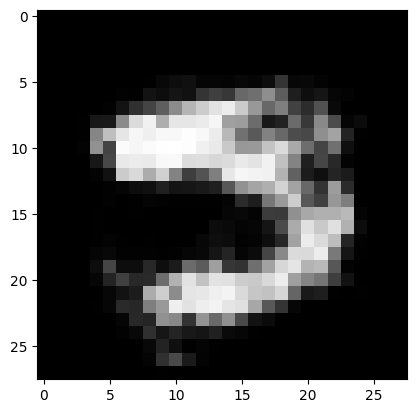

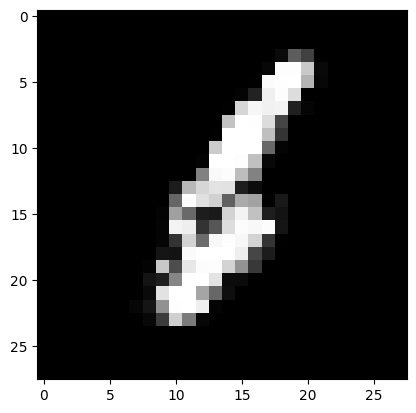

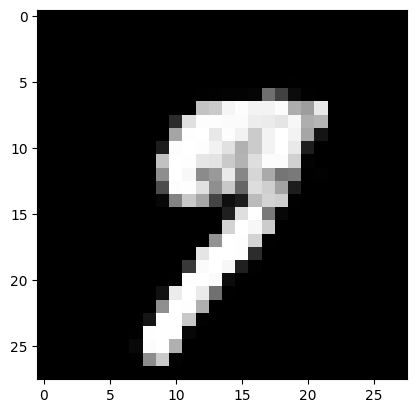

Epoch: 77550
loss_g: 0.7480804324150085 	loss_d: 1.2931056022644043
Epoch: 77600
loss_g: 0.8169226050376892 	loss_d: 1.2562146186828613
Epoch: 77650
loss_g: 0.7567002773284912 	loss_d: 1.3275521993637085
Epoch: 77700
loss_g: 0.7489283680915833 	loss_d: 1.3175716400146484
Epoch: 77750
loss_g: 0.8375147581100464 	loss_d: 1.3518190383911133
Epoch: 77800
loss_g: 0.770018458366394 	loss_d: 1.2705121040344238
Epoch: 77850
loss_g: 0.832108736038208 	loss_d: 1.3488757610321045
Epoch: 77900
loss_g: 0.7804813981056213 	loss_d: 1.3702366352081299
Epoch: 77950
loss_g: 0.8224778771400452 	loss_d: 1.3004827499389648
Epoch: 78000
loss_g: 0.7534278631210327 	loss_d: 1.3407418727874756


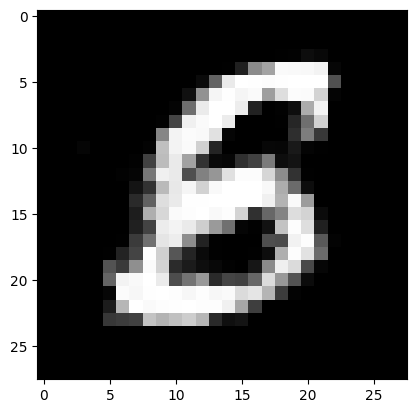

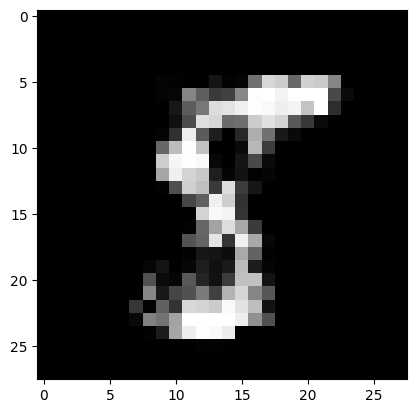

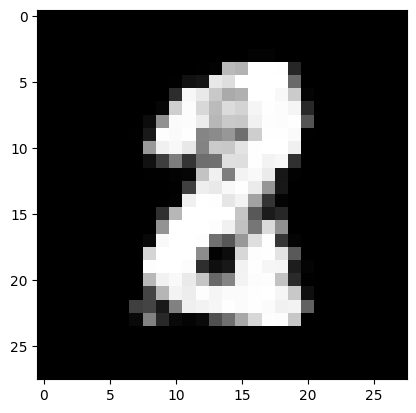

Epoch: 78050
loss_g: 0.7708432674407959 	loss_d: 1.314978837966919
Epoch: 78100
loss_g: 0.7716099619865417 	loss_d: 1.2590142488479614
Epoch: 78150
loss_g: 0.7991764545440674 	loss_d: 1.331313133239746
Epoch: 78200
loss_g: 0.7922830581665039 	loss_d: 1.311208963394165
Epoch: 78250
loss_g: 0.7677180171012878 	loss_d: 1.335448980331421
Epoch: 78300
loss_g: 0.7774627804756165 	loss_d: 1.2755744457244873
Epoch: 78350
loss_g: 0.8075079917907715 	loss_d: 1.3074791431427002
Epoch: 78400
loss_g: 0.7558384537696838 	loss_d: 1.3715474605560303
Epoch: 78450
loss_g: 0.7530474066734314 	loss_d: 1.349942922592163
Epoch: 78500
loss_g: 0.7953314185142517 	loss_d: 1.2596852779388428


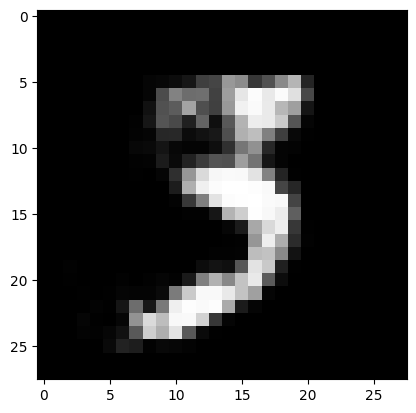

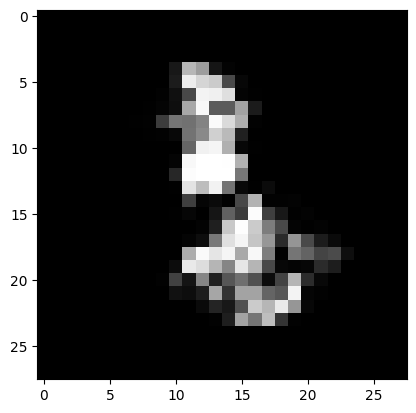

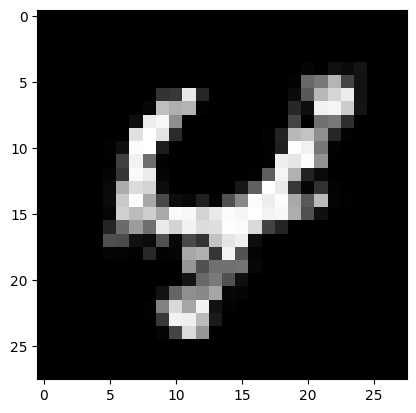

Epoch: 78550
loss_g: 0.753315269947052 	loss_d: 1.3566761016845703
Epoch: 78600
loss_g: 0.7871726155281067 	loss_d: 1.3605825901031494
Epoch: 78650
loss_g: 0.7763044834136963 	loss_d: 1.3289488554000854
Epoch: 78700
loss_g: 0.8087772727012634 	loss_d: 1.3121113777160645
Epoch: 78750
loss_g: 0.7876440286636353 	loss_d: 1.3266494274139404
Epoch: 78800
loss_g: 0.8261141777038574 	loss_d: 1.3024742603302002
Epoch: 78850
loss_g: 0.7592760920524597 	loss_d: 1.3560105562210083
Epoch: 78900
loss_g: 0.7861405611038208 	loss_d: 1.3731753826141357
Epoch: 78950
loss_g: 0.8143161535263062 	loss_d: 1.2584376335144043
Epoch: 79000
loss_g: 0.8516650199890137 	loss_d: 1.2876453399658203


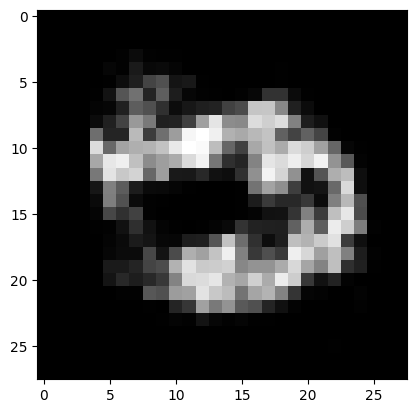

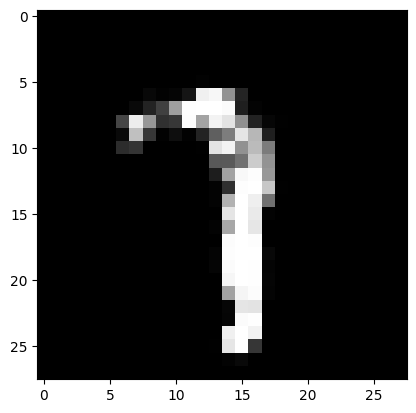

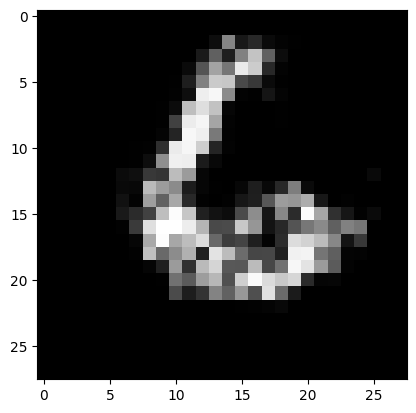

Epoch: 79050
loss_g: 0.7790990471839905 	loss_d: 1.3180696964263916
Epoch: 79100
loss_g: 0.7532167434692383 	loss_d: 1.2543092966079712
Epoch: 79150
loss_g: 0.8535200357437134 	loss_d: 1.2606744766235352
Epoch: 79200
loss_g: 0.788785994052887 	loss_d: 1.309808373451233
Epoch: 79250
loss_g: 0.7733271718025208 	loss_d: 1.355344295501709
Epoch: 79300
loss_g: 0.7756026983261108 	loss_d: 1.3081965446472168
Epoch: 79350
loss_g: 0.8206243515014648 	loss_d: 1.2575993537902832
Epoch: 79400
loss_g: 0.7838481068611145 	loss_d: 1.3287914991378784
Epoch: 79450
loss_g: 0.7742416262626648 	loss_d: 1.284029483795166
Epoch: 79500
loss_g: 0.791478157043457 	loss_d: 1.3398051261901855


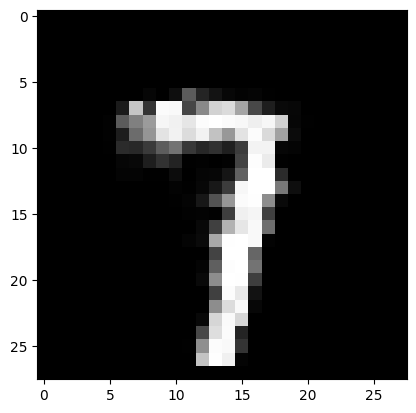

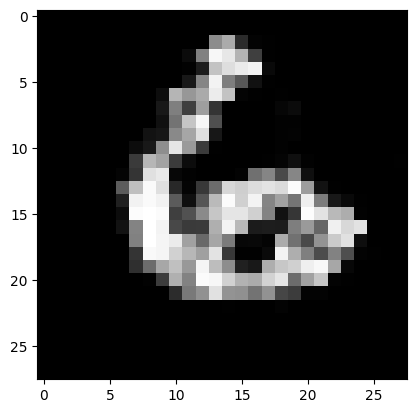

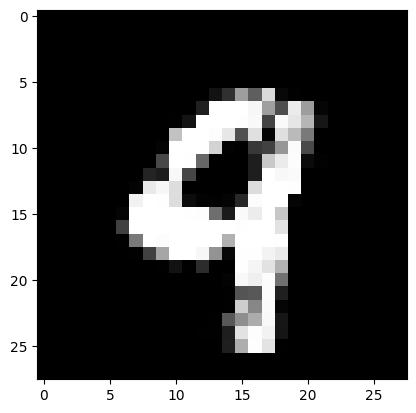

Epoch: 79550
loss_g: 0.7774378657341003 	loss_d: 1.310356616973877
Epoch: 79600
loss_g: 0.726810872554779 	loss_d: 1.3597221374511719
Epoch: 79650
loss_g: 0.8029391169548035 	loss_d: 1.2443269491195679
Epoch: 79700
loss_g: 0.8042786717414856 	loss_d: 1.3110575675964355
Epoch: 79750
loss_g: 0.809265673160553 	loss_d: 1.3407763242721558
Epoch: 79800
loss_g: 0.8513475060462952 	loss_d: 1.3007901906967163
Epoch: 79850
loss_g: 0.748096764087677 	loss_d: 1.3178205490112305
Epoch: 79900
loss_g: 0.7959638833999634 	loss_d: 1.3285107612609863
Epoch: 79950
loss_g: 0.8270393013954163 	loss_d: 1.290571689605713
Epoch: 80000
loss_g: 0.7322876453399658 	loss_d: 1.3383843898773193


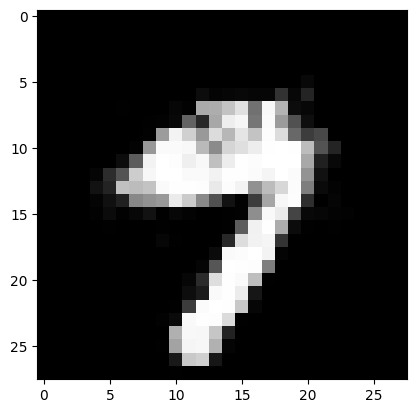

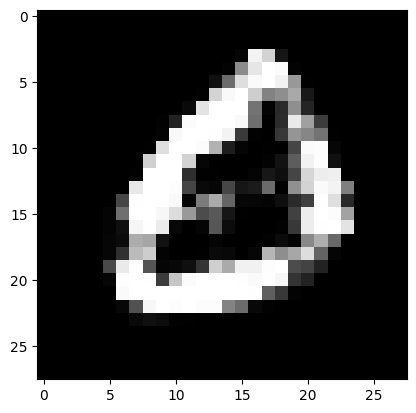

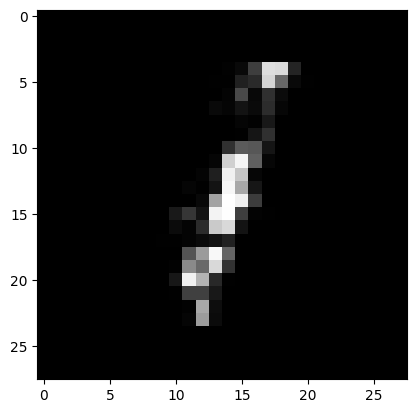

Epoch: 80050
loss_g: 0.8108811974525452 	loss_d: 1.2813817262649536
Epoch: 80100
loss_g: 0.8274807333946228 	loss_d: 1.294425129890442
Epoch: 80150
loss_g: 0.7709726691246033 	loss_d: 1.3236973285675049
Epoch: 80200
loss_g: 0.7761901617050171 	loss_d: 1.3291041851043701
Epoch: 80250
loss_g: 0.7994564771652222 	loss_d: 1.3204059600830078
Epoch: 80300
loss_g: 0.781317412853241 	loss_d: 1.2190545797348022
Epoch: 80350
loss_g: 0.8008399605751038 	loss_d: 1.3317384719848633
Epoch: 80400
loss_g: 0.8129735589027405 	loss_d: 1.3116042613983154
Epoch: 80450
loss_g: 0.8806459903717041 	loss_d: 1.2171094417572021
Epoch: 80500
loss_g: 0.8045342564582825 	loss_d: 1.3294286727905273


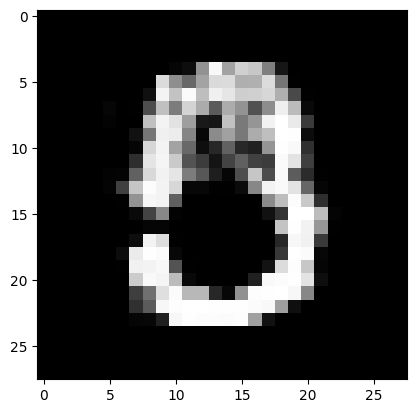

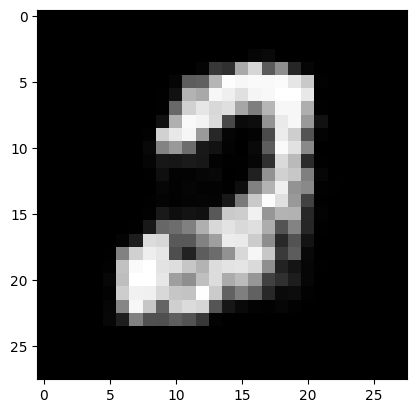

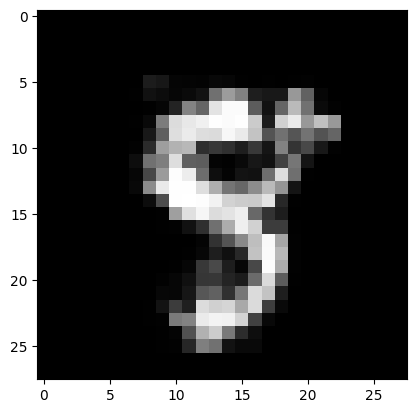

Epoch: 80550
loss_g: 0.7694822549819946 	loss_d: 1.4152969121932983
Epoch: 80600
loss_g: 0.7594466805458069 	loss_d: 1.3188238143920898
Epoch: 80650
loss_g: 0.8389549851417542 	loss_d: 1.3152096271514893
Epoch: 80700
loss_g: 0.8388059139251709 	loss_d: 1.2556262016296387
Epoch: 80750
loss_g: 0.7942063808441162 	loss_d: 1.32072913646698
Epoch: 80800
loss_g: 0.7684520483016968 	loss_d: 1.3161218166351318
Epoch: 80850
loss_g: 0.7787587642669678 	loss_d: 1.2953402996063232
Epoch: 80900
loss_g: 0.7690882682800293 	loss_d: 1.2837508916854858
Epoch: 80950
loss_g: 0.8128079175949097 	loss_d: 1.2947585582733154
Epoch: 81000
loss_g: 0.8344129920005798 	loss_d: 1.290618896484375


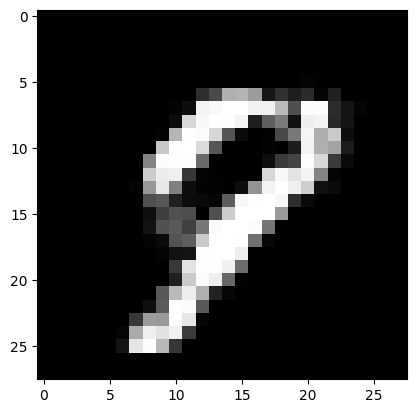

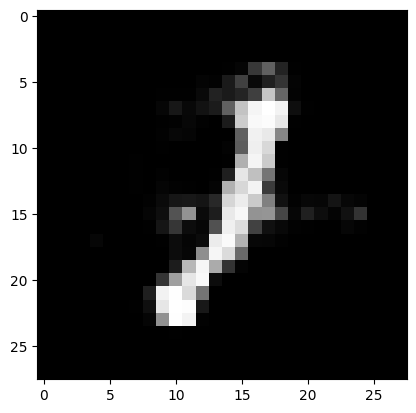

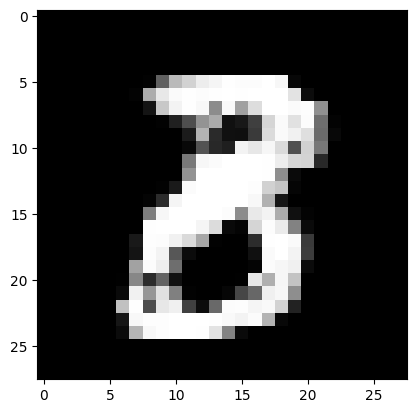

Epoch: 81050
loss_g: 0.8059437274932861 	loss_d: 1.2249054908752441
Epoch: 81100
loss_g: 0.7618805766105652 	loss_d: 1.2930867671966553
Epoch: 81150
loss_g: 0.82169109582901 	loss_d: 1.3733978271484375
Epoch: 81200
loss_g: 0.741483747959137 	loss_d: 1.3236817121505737
Epoch: 81250
loss_g: 0.7736089825630188 	loss_d: 1.3803880214691162
Epoch: 81300
loss_g: 0.7734820246696472 	loss_d: 1.3494353294372559
Epoch: 81350
loss_g: 0.7751765251159668 	loss_d: 1.2696988582611084
Epoch: 81400
loss_g: 0.8271981477737427 	loss_d: 1.3512595891952515
Epoch: 81450
loss_g: 0.8125874400138855 	loss_d: 1.317452073097229
Epoch: 81500
loss_g: 0.7422055602073669 	loss_d: 1.3162537813186646


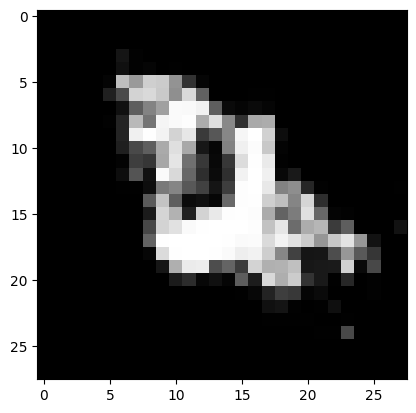

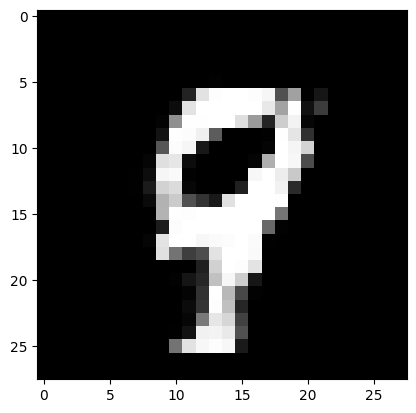

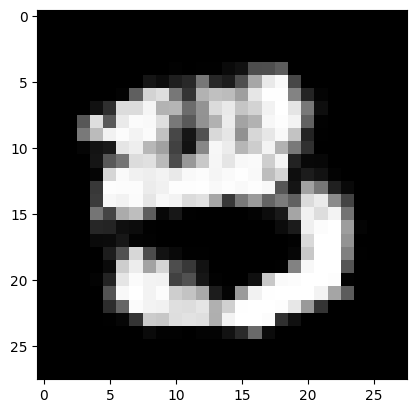

Epoch: 81550
loss_g: 0.7853286862373352 	loss_d: 1.3192522525787354
Epoch: 81600
loss_g: 0.8035609126091003 	loss_d: 1.350430965423584
Epoch: 81650
loss_g: 0.7430747747421265 	loss_d: 1.3165709972381592
Epoch: 81700
loss_g: 0.8478663563728333 	loss_d: 1.273407220840454
Epoch: 81750
loss_g: 0.7790295481681824 	loss_d: 1.2485291957855225
Epoch: 81800
loss_g: 0.8584333658218384 	loss_d: 1.3217722177505493
Epoch: 81850
loss_g: 0.79254150390625 	loss_d: 1.2313480377197266
Epoch: 81900
loss_g: 0.7939843535423279 	loss_d: 1.3217231035232544
Epoch: 81950
loss_g: 0.7980903387069702 	loss_d: 1.2978131771087646
Epoch: 82000
loss_g: 0.8720703721046448 	loss_d: 1.3001577854156494


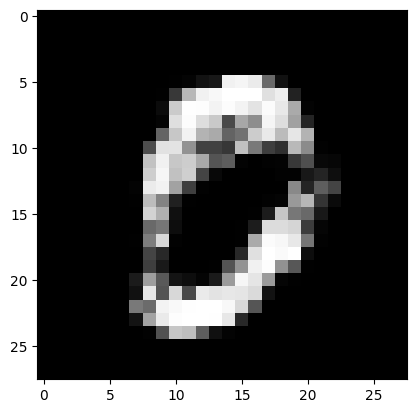

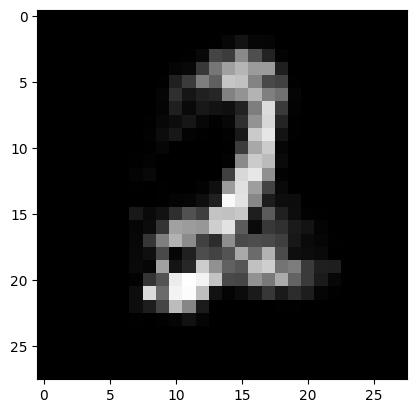

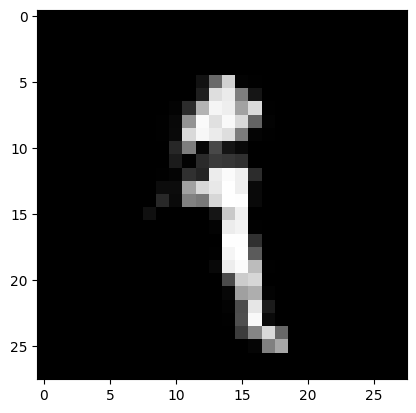

Epoch: 82050
loss_g: 0.7937219142913818 	loss_d: 1.3032691478729248
Epoch: 82100
loss_g: 0.8062139749526978 	loss_d: 1.2894914150238037
Epoch: 82150
loss_g: 0.8272234797477722 	loss_d: 1.3689502477645874
Epoch: 82200
loss_g: 0.7996241450309753 	loss_d: 1.252227783203125
Epoch: 82250
loss_g: 0.7808710932731628 	loss_d: 1.2756071090698242
Epoch: 82300
loss_g: 0.8558666110038757 	loss_d: 1.3186511993408203
Epoch: 82350
loss_g: 0.7375736236572266 	loss_d: 1.290280818939209
Epoch: 82400
loss_g: 0.759297788143158 	loss_d: 1.2611802816390991
Epoch: 82450
loss_g: 0.7730200886726379 	loss_d: 1.3109023571014404
Epoch: 82500
loss_g: 0.7761803865432739 	loss_d: 1.3897676467895508


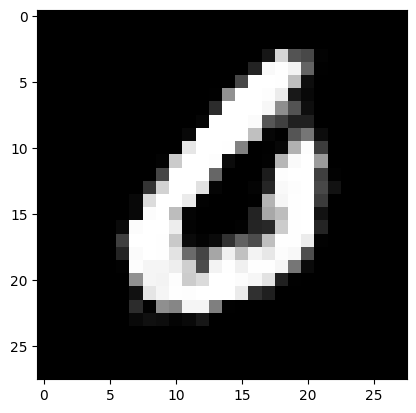

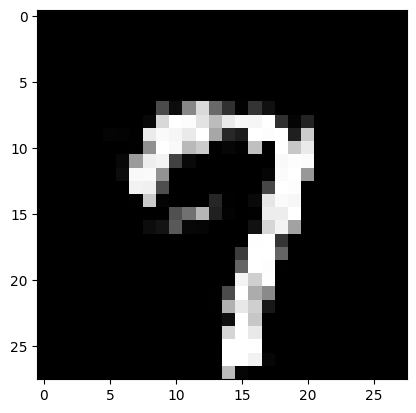

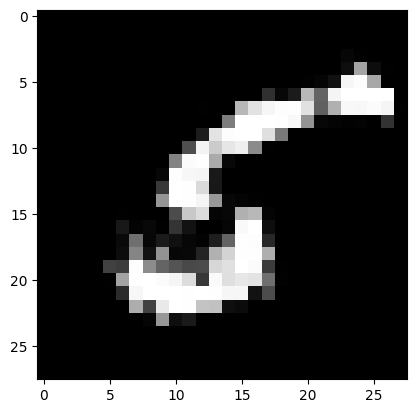

Epoch: 82550
loss_g: 0.7887743711471558 	loss_d: 1.275406837463379
Epoch: 82600
loss_g: 0.8211217522621155 	loss_d: 1.329271674156189
Epoch: 82650
loss_g: 0.8038321733474731 	loss_d: 1.3167991638183594
Epoch: 82700
loss_g: 0.7413247227668762 	loss_d: 1.3102244138717651
Epoch: 82750
loss_g: 0.8276679515838623 	loss_d: 1.308234453201294
Epoch: 82800
loss_g: 0.8073619604110718 	loss_d: 1.3472874164581299
Epoch: 82850
loss_g: 0.8705558776855469 	loss_d: 1.2750952243804932
Epoch: 82900
loss_g: 0.8061883449554443 	loss_d: 1.322575569152832
Epoch: 82950
loss_g: 0.8367761969566345 	loss_d: 1.2815288305282593
Epoch: 83000
loss_g: 0.8108105063438416 	loss_d: 1.2337876558303833


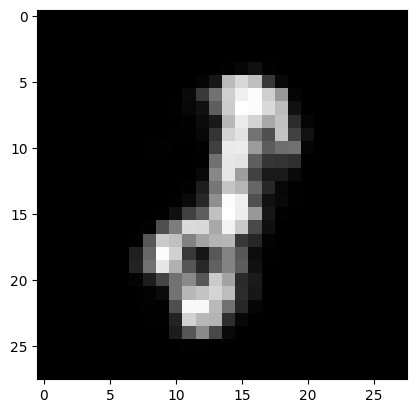

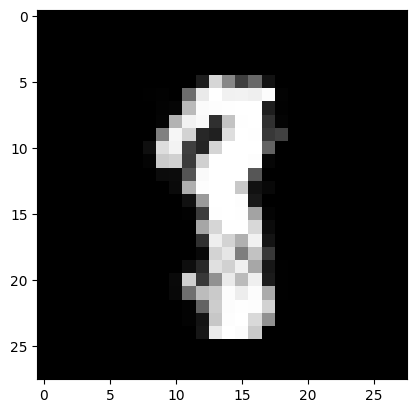

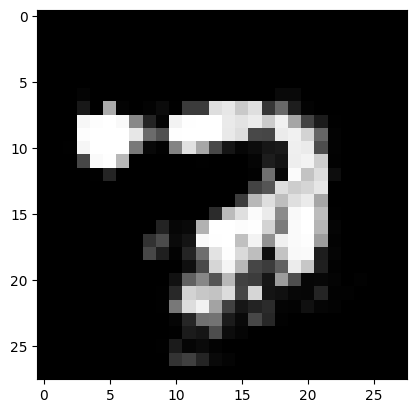

Epoch: 83050
loss_g: 0.8031848073005676 	loss_d: 1.274627923965454
Epoch: 83100
loss_g: 0.8298860788345337 	loss_d: 1.2746491432189941
Epoch: 83150
loss_g: 0.7477735877037048 	loss_d: 1.3185019493103027
Epoch: 83200
loss_g: 0.7027280330657959 	loss_d: 1.3619792461395264
Epoch: 83250
loss_g: 0.7740185856819153 	loss_d: 1.353888988494873
Epoch: 83300
loss_g: 0.785717785358429 	loss_d: 1.3153626918792725
Epoch: 83350
loss_g: 0.7881672978401184 	loss_d: 1.3546984195709229
Epoch: 83400
loss_g: 0.7855253219604492 	loss_d: 1.2781007289886475
Epoch: 83450
loss_g: 0.8765766620635986 	loss_d: 1.2960492372512817
Epoch: 83500
loss_g: 0.7759367823600769 	loss_d: 1.3468267917633057


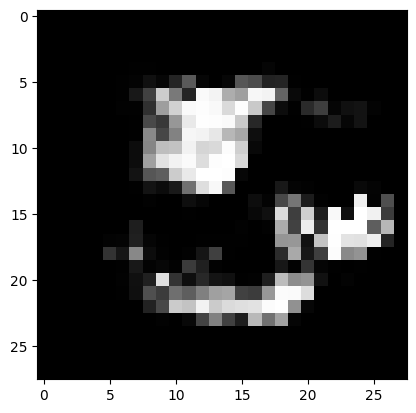

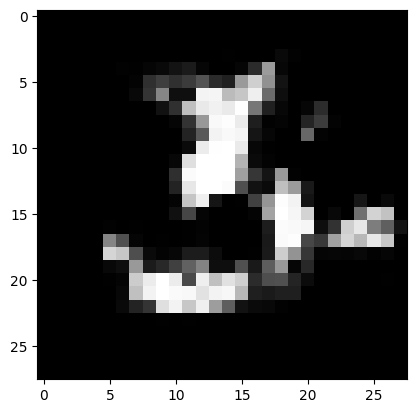

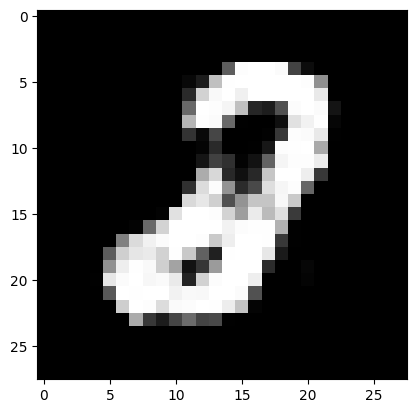

Epoch: 83550
loss_g: 0.8060853481292725 	loss_d: 1.3350706100463867
Epoch: 83600
loss_g: 0.7979409694671631 	loss_d: 1.3156578540802002
Epoch: 83650
loss_g: 0.8217425346374512 	loss_d: 1.3000857830047607
Epoch: 83700
loss_g: 0.7869329452514648 	loss_d: 1.3558166027069092
Epoch: 83750
loss_g: 0.8340797424316406 	loss_d: 1.3376986980438232
Epoch: 83800
loss_g: 0.7602684497833252 	loss_d: 1.2982484102249146
Epoch: 83850
loss_g: 0.7731704711914062 	loss_d: 1.357174277305603
Epoch: 83900
loss_g: 0.8050222396850586 	loss_d: 1.2987322807312012
Epoch: 83950
loss_g: 0.8336547613143921 	loss_d: 1.2540152072906494
Epoch: 84000
loss_g: 0.7586625218391418 	loss_d: 1.305098295211792


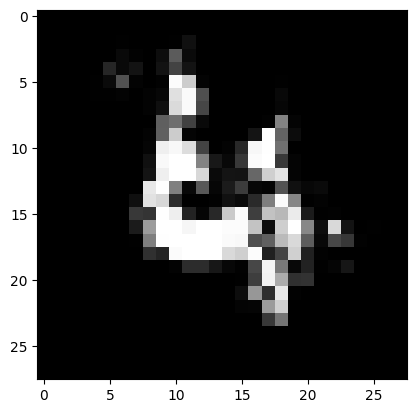

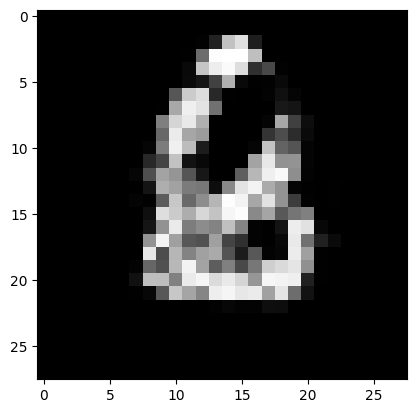

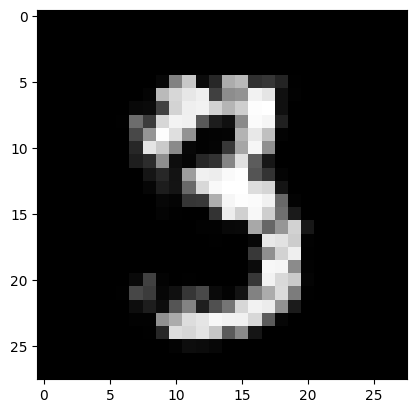

Epoch: 84050
loss_g: 0.8413719534873962 	loss_d: 1.32058584690094
Epoch: 84100
loss_g: 0.7724817991256714 	loss_d: 1.2891910076141357
Epoch: 84150
loss_g: 0.8051891326904297 	loss_d: 1.276719331741333
Epoch: 84200
loss_g: 0.7897692918777466 	loss_d: 1.3168597221374512
Epoch: 84250
loss_g: 0.7435954809188843 	loss_d: 1.2897288799285889
Epoch: 84300
loss_g: 0.7877724766731262 	loss_d: 1.3349330425262451
Epoch: 84350
loss_g: 0.8227362036705017 	loss_d: 1.2409846782684326
Epoch: 84400
loss_g: 0.7701953053474426 	loss_d: 1.4189093112945557
Epoch: 84450
loss_g: 0.8086139559745789 	loss_d: 1.358689785003662
Epoch: 84500
loss_g: 0.7974860072135925 	loss_d: 1.2600502967834473


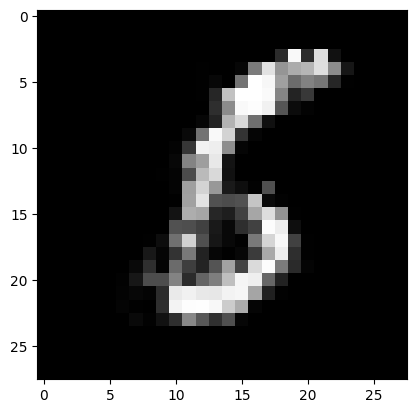

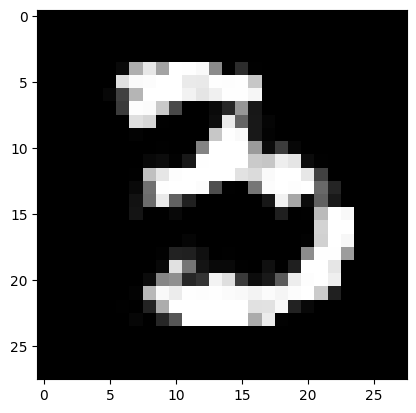

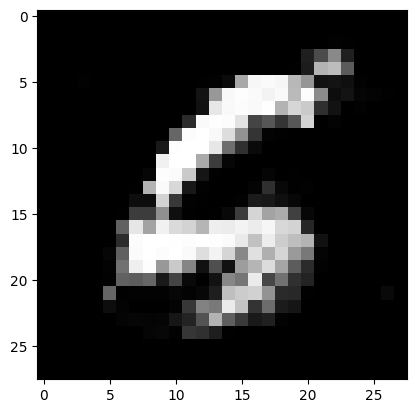

Epoch: 84550
loss_g: 0.8423020839691162 	loss_d: 1.2520697116851807
Epoch: 84600
loss_g: 0.7747811675071716 	loss_d: 1.3518054485321045
Epoch: 84650
loss_g: 0.7741849422454834 	loss_d: 1.2784597873687744
Epoch: 84700
loss_g: 0.8121975660324097 	loss_d: 1.3135502338409424
Epoch: 84750
loss_g: 0.7814162969589233 	loss_d: 1.3502171039581299
Epoch: 84800
loss_g: 0.7869960069656372 	loss_d: 1.2959541082382202
Epoch: 84850
loss_g: 0.7828702926635742 	loss_d: 1.3613436222076416
Epoch: 84900
loss_g: 0.8064682483673096 	loss_d: 1.3142545223236084
Epoch: 84950
loss_g: 0.7420507669448853 	loss_d: 1.2894036769866943
Epoch: 85000
loss_g: 0.7788506746292114 	loss_d: 1.3264390230178833


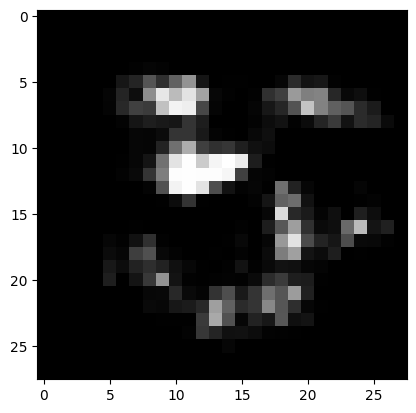

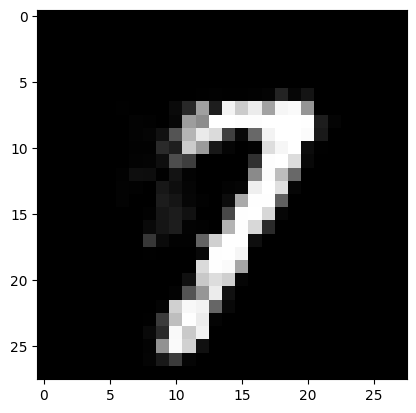

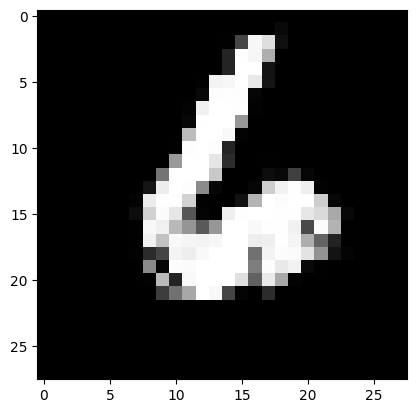

Epoch: 85050
loss_g: 0.7966812252998352 	loss_d: 1.348534345626831
Epoch: 85100
loss_g: 0.8437631726264954 	loss_d: 1.3087557554244995
Epoch: 85150
loss_g: 0.7803576588630676 	loss_d: 1.2367762327194214
Epoch: 85200
loss_g: 0.7865620255470276 	loss_d: 1.3121380805969238
Epoch: 85250
loss_g: 0.761388897895813 	loss_d: 1.3232967853546143
Epoch: 85300
loss_g: 0.8183618783950806 	loss_d: 1.2546591758728027
Epoch: 85350
loss_g: 0.8246251344680786 	loss_d: 1.2626895904541016
Epoch: 85400
loss_g: 0.827803909778595 	loss_d: 1.3638832569122314
Epoch: 85450
loss_g: 0.7851787209510803 	loss_d: 1.3255624771118164
Epoch: 85500
loss_g: 0.8101534843444824 	loss_d: 1.2329483032226562


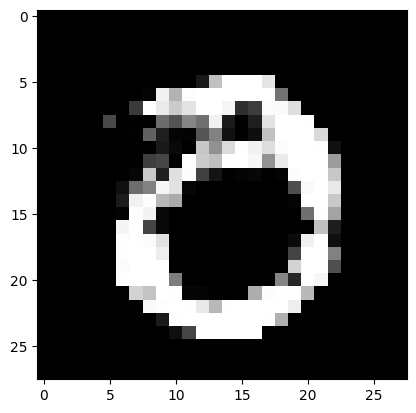

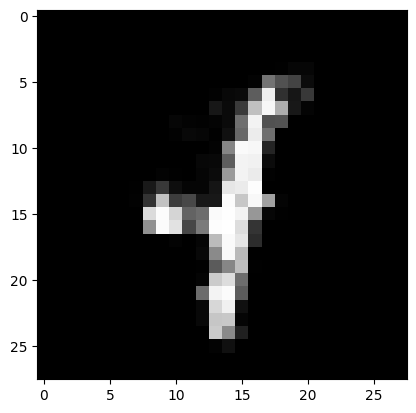

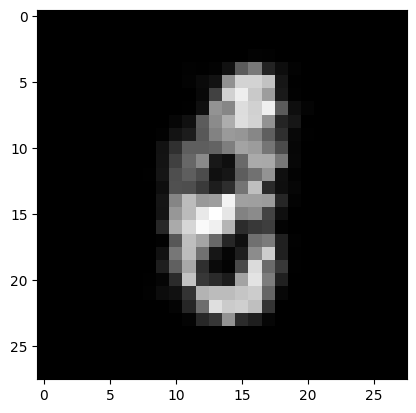

Epoch: 85550
loss_g: 0.7714148759841919 	loss_d: 1.304926872253418
Epoch: 85600
loss_g: 0.8216956853866577 	loss_d: 1.3014752864837646
Epoch: 85650
loss_g: 0.8418378233909607 	loss_d: 1.3548359870910645
Epoch: 85700
loss_g: 0.8342409133911133 	loss_d: 1.264310598373413
Epoch: 85750
loss_g: 0.8135319352149963 	loss_d: 1.2715857028961182
Epoch: 85800
loss_g: 0.7389510869979858 	loss_d: 1.2777149677276611
Epoch: 85850
loss_g: 0.8354128003120422 	loss_d: 1.2861686944961548
Epoch: 85900
loss_g: 0.7973149418830872 	loss_d: 1.3553348779678345
Epoch: 85950
loss_g: 0.8275886178016663 	loss_d: 1.3394168615341187
Epoch: 86000
loss_g: 0.7887653708457947 	loss_d: 1.3290307521820068


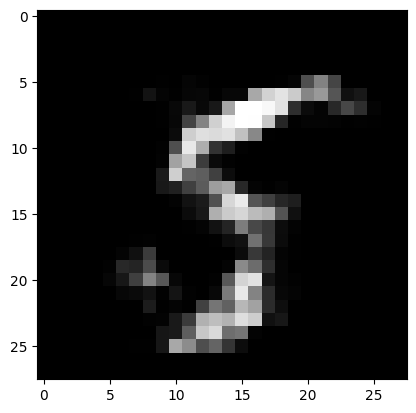

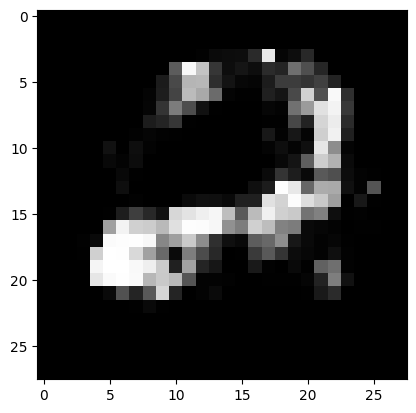

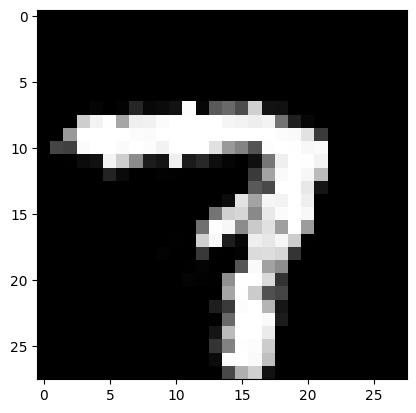

Epoch: 86050
loss_g: 0.8059765696525574 	loss_d: 1.337662935256958
Epoch: 86100
loss_g: 0.7663774490356445 	loss_d: 1.3530006408691406
Epoch: 86150
loss_g: 0.8201434016227722 	loss_d: 1.3405416011810303
Epoch: 86200
loss_g: 0.8181136846542358 	loss_d: 1.3262813091278076
Epoch: 86250
loss_g: 0.8256045579910278 	loss_d: 1.3272268772125244
Epoch: 86300
loss_g: 0.7822897434234619 	loss_d: 1.2543458938598633
Epoch: 86350
loss_g: 0.8761998414993286 	loss_d: 1.395114541053772
Epoch: 86400
loss_g: 0.7442095279693604 	loss_d: 1.3061201572418213
Epoch: 86450
loss_g: 0.7393521070480347 	loss_d: 1.3221899271011353
Epoch: 86500
loss_g: 0.8363860845565796 	loss_d: 1.321434497833252


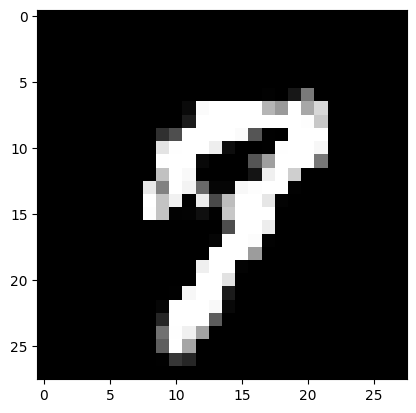

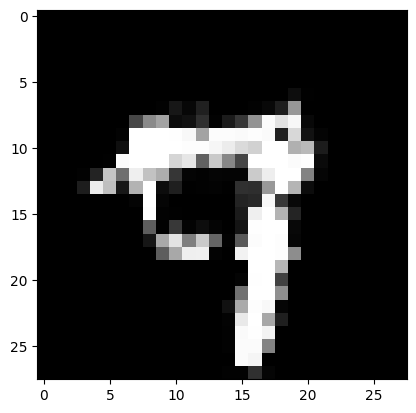

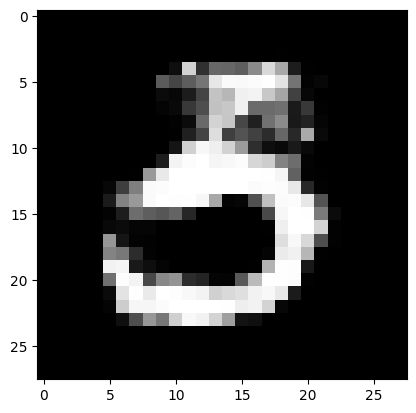

Epoch: 86550
loss_g: 0.8511421084403992 	loss_d: 1.3065690994262695
Epoch: 86600
loss_g: 0.8108149766921997 	loss_d: 1.279049038887024
Epoch: 86650
loss_g: 0.7519346475601196 	loss_d: 1.3325064182281494
Epoch: 86700
loss_g: 0.8232724666595459 	loss_d: 1.24275541305542
Epoch: 86750
loss_g: 0.8011168241500854 	loss_d: 1.3149714469909668
Epoch: 86800
loss_g: 0.7777201533317566 	loss_d: 1.2901921272277832
Epoch: 86850
loss_g: 0.8213058114051819 	loss_d: 1.3465592861175537
Epoch: 86900
loss_g: 0.8239498734474182 	loss_d: 1.3523916006088257
Epoch: 86950
loss_g: 0.8234961628913879 	loss_d: 1.242117166519165
Epoch: 87000
loss_g: 0.8437901139259338 	loss_d: 1.2757647037506104


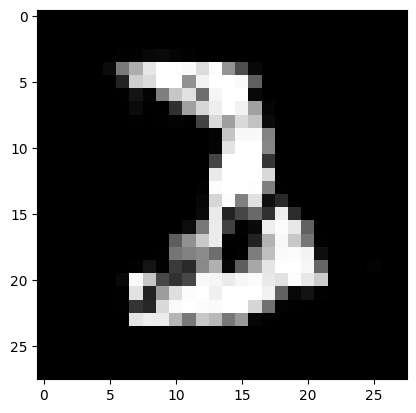

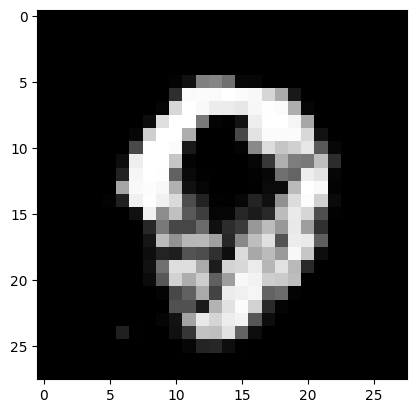

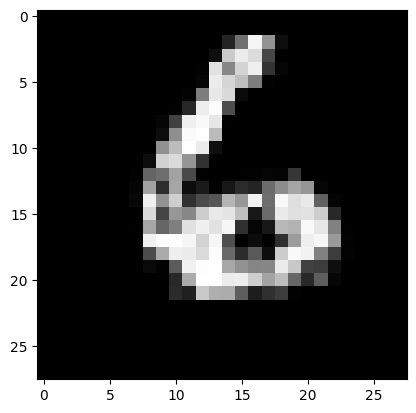

Epoch: 87050
loss_g: 0.7629550099372864 	loss_d: 1.2415764331817627
Epoch: 87100
loss_g: 0.7827652096748352 	loss_d: 1.3088845014572144
Epoch: 87150
loss_g: 0.8201121091842651 	loss_d: 1.2591031789779663
Epoch: 87200
loss_g: 0.8989511132240295 	loss_d: 1.2821307182312012
Epoch: 87250
loss_g: 0.8345320820808411 	loss_d: 1.3006325960159302
Epoch: 87300
loss_g: 0.7819086909294128 	loss_d: 1.2957234382629395
Epoch: 87350
loss_g: 0.756155252456665 	loss_d: 1.3161799907684326
Epoch: 87400
loss_g: 0.761540949344635 	loss_d: 1.287573218345642
Epoch: 87450
loss_g: 0.7700375914573669 	loss_d: 1.2707104682922363
Epoch: 87500
loss_g: 0.8009625673294067 	loss_d: 1.299936294555664


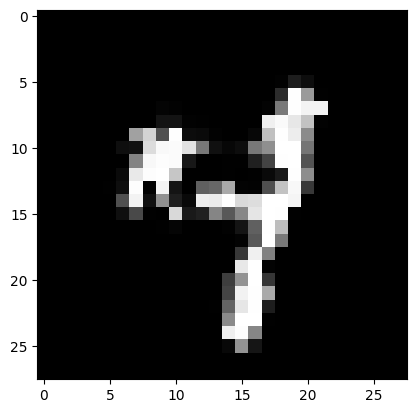

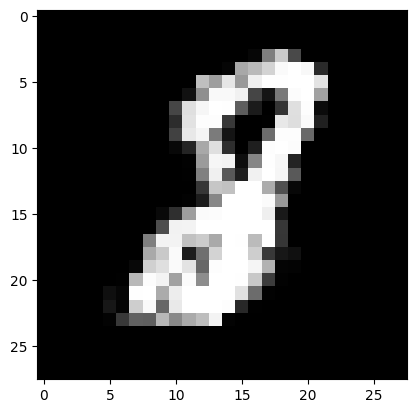

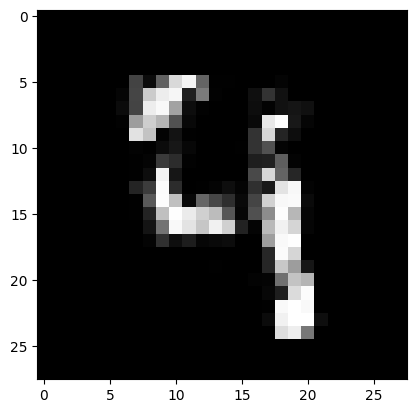

Epoch: 87550
loss_g: 0.8068154454231262 	loss_d: 1.2419626712799072
Epoch: 87600
loss_g: 0.7818167805671692 	loss_d: 1.3931652307510376
Epoch: 87650
loss_g: 0.7433764338493347 	loss_d: 1.3835079669952393
Epoch: 87700
loss_g: 0.8494328260421753 	loss_d: 1.2434306144714355
Epoch: 87750
loss_g: 0.7734450101852417 	loss_d: 1.2853119373321533
Epoch: 87800
loss_g: 0.8054592609405518 	loss_d: 1.3327128887176514
Epoch: 87850
loss_g: 0.824513852596283 	loss_d: 1.3144423961639404
Epoch: 87900
loss_g: 0.7969069480895996 	loss_d: 1.3233921527862549
Epoch: 87950
loss_g: 0.8619788289070129 	loss_d: 1.30784010887146
Epoch: 88000
loss_g: 0.8010050654411316 	loss_d: 1.2932015657424927


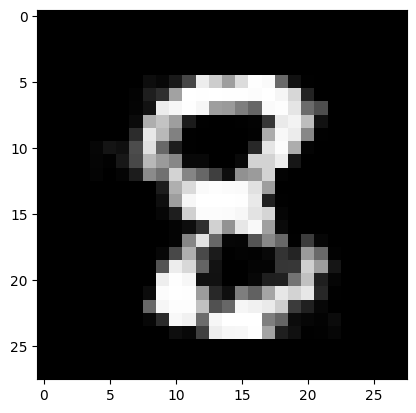

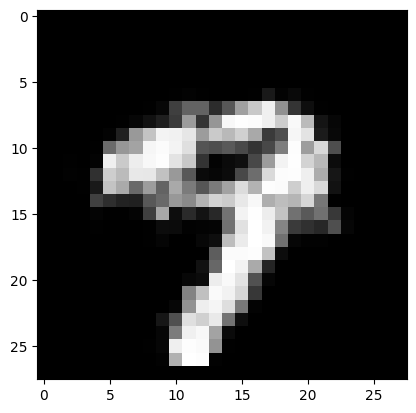

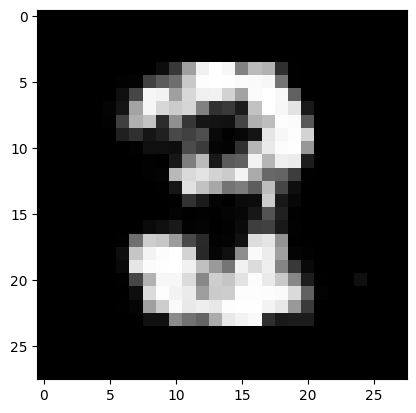

Epoch: 88050
loss_g: 0.8746854066848755 	loss_d: 1.301180124282837
Epoch: 88100
loss_g: 0.8414033055305481 	loss_d: 1.2902696132659912
Epoch: 88150
loss_g: 0.8433776497840881 	loss_d: 1.3399714231491089
Epoch: 88200
loss_g: 0.7592391967773438 	loss_d: 1.3088817596435547
Epoch: 88250
loss_g: 0.7540706992149353 	loss_d: 1.2972652912139893
Epoch: 88300
loss_g: 0.7866365909576416 	loss_d: 1.2888150215148926
Epoch: 88350
loss_g: 0.8037973642349243 	loss_d: 1.3184716701507568
Epoch: 88400
loss_g: 0.7484017014503479 	loss_d: 1.3311893939971924
Epoch: 88450
loss_g: 0.8538885116577148 	loss_d: 1.394444227218628
Epoch: 88500
loss_g: 0.7836721539497375 	loss_d: 1.2990443706512451


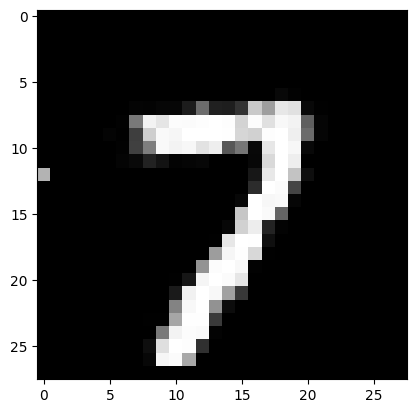

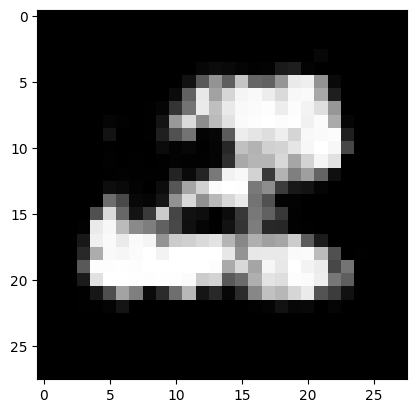

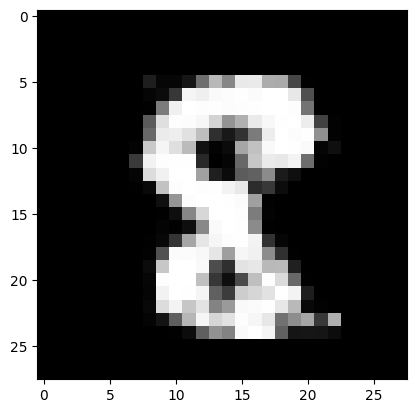

Epoch: 88550
loss_g: 0.8732917308807373 	loss_d: 1.2194762229919434
Epoch: 88600
loss_g: 0.7722839117050171 	loss_d: 1.3310356140136719
Epoch: 88650
loss_g: 0.7645602226257324 	loss_d: 1.2567086219787598
Epoch: 88700
loss_g: 0.8181281685829163 	loss_d: 1.3138246536254883
Epoch: 88750
loss_g: 0.8009581565856934 	loss_d: 1.3075329065322876
Epoch: 88800
loss_g: 0.8033192157745361 	loss_d: 1.3293895721435547
Epoch: 88850
loss_g: 0.7806938290596008 	loss_d: 1.279966115951538
Epoch: 88900
loss_g: 0.8043448328971863 	loss_d: 1.3482389450073242
Epoch: 88950
loss_g: 0.7666885852813721 	loss_d: 1.2727704048156738
Epoch: 89000
loss_g: 0.8219155669212341 	loss_d: 1.2794454097747803


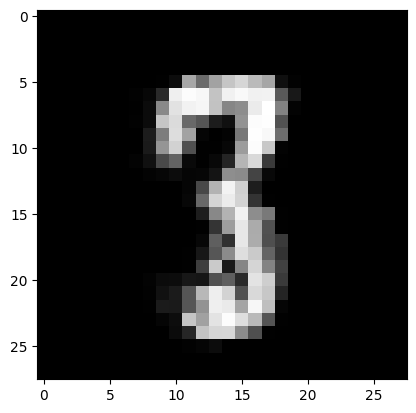

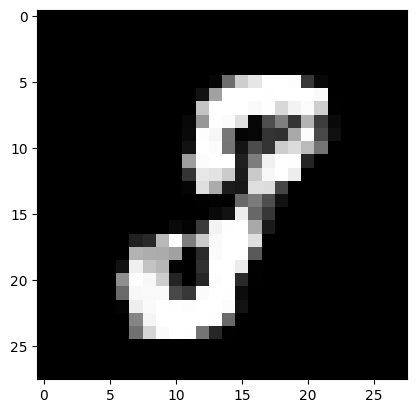

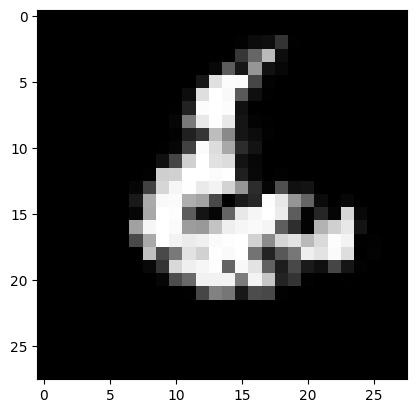

Epoch: 89050
loss_g: 0.7895942330360413 	loss_d: 1.291081428527832
Epoch: 89100
loss_g: 0.7679357528686523 	loss_d: 1.3236911296844482
Epoch: 89150
loss_g: 0.8230645656585693 	loss_d: 1.2890698909759521
Epoch: 89200
loss_g: 0.8148998618125916 	loss_d: 1.33504319190979
Epoch: 89250
loss_g: 0.8138386607170105 	loss_d: 1.2470167875289917
Epoch: 89300
loss_g: 0.8855878114700317 	loss_d: 1.3325934410095215
Epoch: 89350
loss_g: 0.7628760933876038 	loss_d: 1.3175861835479736
Epoch: 89400
loss_g: 0.8071039915084839 	loss_d: 1.300071120262146
Epoch: 89450
loss_g: 0.8854828476905823 	loss_d: 1.303694248199463
Epoch: 89500
loss_g: 0.8133482933044434 	loss_d: 1.3399008512496948


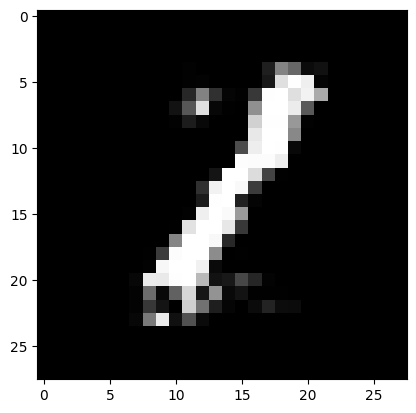

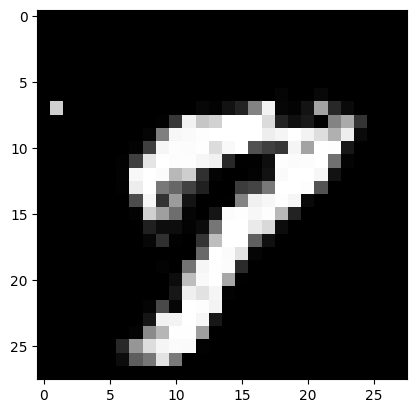

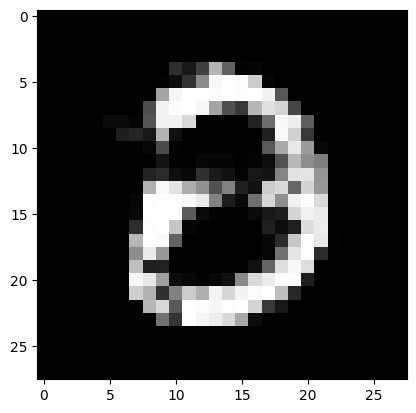

Epoch: 89550
loss_g: 0.8291822671890259 	loss_d: 1.2993216514587402
Epoch: 89600
loss_g: 0.8800662159919739 	loss_d: 1.315889835357666
Epoch: 89650
loss_g: 0.7926508784294128 	loss_d: 1.269392967224121
Epoch: 89700
loss_g: 0.7869203686714172 	loss_d: 1.2827095985412598
Epoch: 89750
loss_g: 0.8198318481445312 	loss_d: 1.296730637550354
Epoch: 89800
loss_g: 0.8201407194137573 	loss_d: 1.3747878074645996
Epoch: 89850
loss_g: 0.8489492535591125 	loss_d: 1.2581031322479248
Epoch: 89900
loss_g: 0.7924668192863464 	loss_d: 1.276235818862915
Epoch: 89950
loss_g: 0.783132791519165 	loss_d: 1.299043893814087
Epoch: 90000
loss_g: 0.8855046033859253 	loss_d: 1.1935367584228516


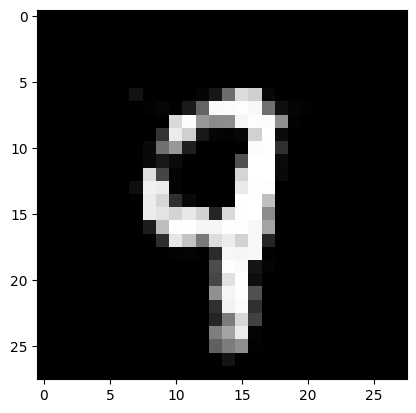

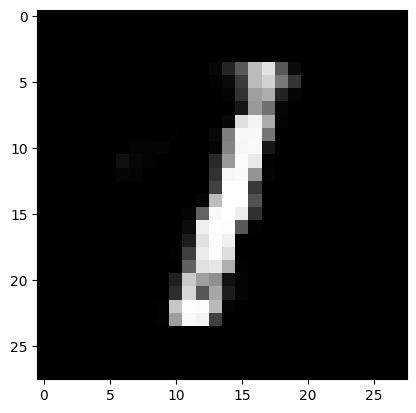

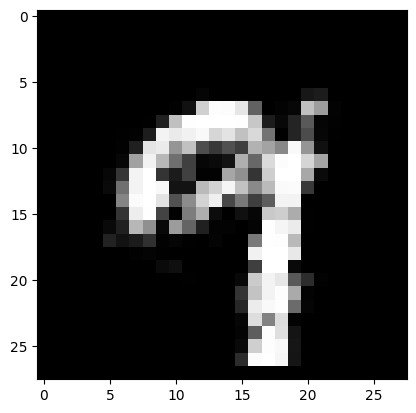

Epoch: 90050
loss_g: 0.8911846876144409 	loss_d: 1.309457778930664
Epoch: 90100
loss_g: 0.8546639680862427 	loss_d: 1.345988154411316
Epoch: 90150
loss_g: 0.8006671667098999 	loss_d: 1.3023674488067627
Epoch: 90200
loss_g: 0.7673137784004211 	loss_d: 1.3579275608062744
Epoch: 90250
loss_g: 0.801417887210846 	loss_d: 1.2655808925628662
Epoch: 90300
loss_g: 0.7971065640449524 	loss_d: 1.2745232582092285
Epoch: 90350
loss_g: 0.8176134824752808 	loss_d: 1.3140909671783447
Epoch: 90400
loss_g: 0.7717846632003784 	loss_d: 1.2967653274536133
Epoch: 90450
loss_g: 0.8384550213813782 	loss_d: 1.2514272928237915
Epoch: 90500
loss_g: 0.7968989610671997 	loss_d: 1.245577096939087


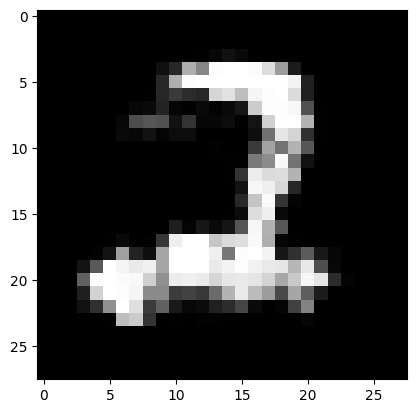

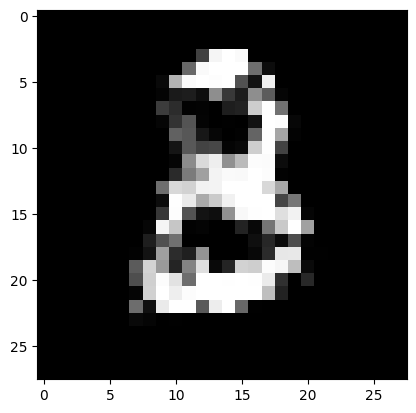

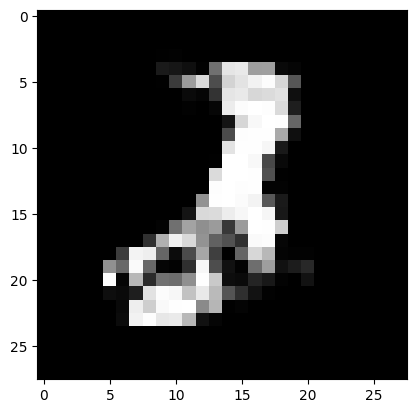

Epoch: 90550
loss_g: 0.8319433331489563 	loss_d: 1.3087475299835205
Epoch: 90600
loss_g: 0.8019744753837585 	loss_d: 1.2132923603057861
Epoch: 90650
loss_g: 0.891301155090332 	loss_d: 1.336134910583496
Epoch: 90700
loss_g: 0.8489336967468262 	loss_d: 1.2632174491882324
Epoch: 90750
loss_g: 0.8365225791931152 	loss_d: 1.3178627490997314
Epoch: 90800
loss_g: 0.8271198868751526 	loss_d: 1.2645078897476196
Epoch: 90850
loss_g: 0.8046805262565613 	loss_d: 1.2898346185684204
Epoch: 90900
loss_g: 0.8216418027877808 	loss_d: 1.308768391609192
Epoch: 90950
loss_g: 0.8377290368080139 	loss_d: 1.2870819568634033
Epoch: 91000
loss_g: 0.892360270023346 	loss_d: 1.2201578617095947


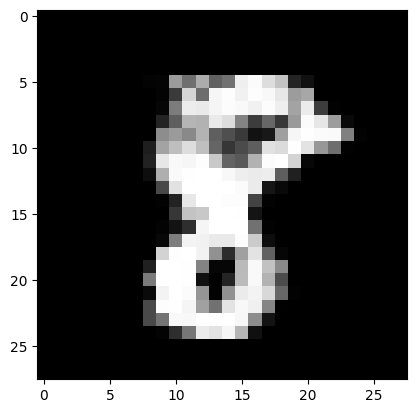

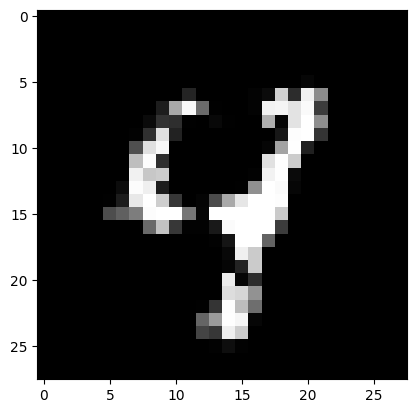

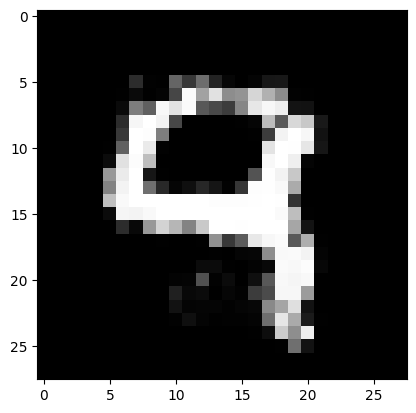

Epoch: 91050
loss_g: 0.8012260794639587 	loss_d: 1.295250654220581
Epoch: 91100
loss_g: 0.7804377675056458 	loss_d: 1.3476076126098633
Epoch: 91150
loss_g: 0.7926110625267029 	loss_d: 1.3579926490783691
Epoch: 91200
loss_g: 0.8227508068084717 	loss_d: 1.2528531551361084
Epoch: 91250
loss_g: 0.8251890540122986 	loss_d: 1.2580211162567139
Epoch: 91300
loss_g: 0.7536553740501404 	loss_d: 1.3136389255523682
Epoch: 91350
loss_g: 0.8057417273521423 	loss_d: 1.3177638053894043
Epoch: 91400
loss_g: 0.8645952939987183 	loss_d: 1.3276818990707397
Epoch: 91450
loss_g: 0.8208858370780945 	loss_d: 1.3500280380249023
Epoch: 91500
loss_g: 0.7661895751953125 	loss_d: 1.235640525817871


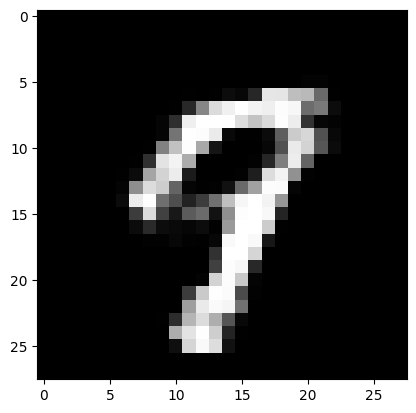

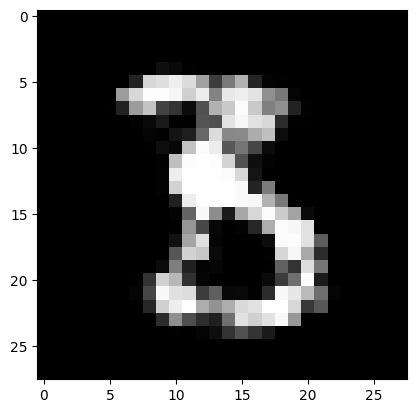

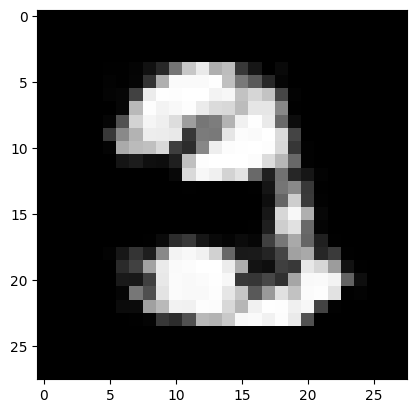

Epoch: 91550
loss_g: 0.8017065525054932 	loss_d: 1.278090000152588
Epoch: 91600
loss_g: 0.7623370289802551 	loss_d: 1.377231240272522
Epoch: 91650
loss_g: 0.8744361400604248 	loss_d: 1.2672933340072632
Epoch: 91700
loss_g: 0.7919903993606567 	loss_d: 1.3494607210159302
Epoch: 91750
loss_g: 0.7744780778884888 	loss_d: 1.3111302852630615
Epoch: 91800
loss_g: 0.826121985912323 	loss_d: 1.3263888359069824
Epoch: 91850
loss_g: 0.8359711766242981 	loss_d: 1.3181692361831665
Epoch: 91900
loss_g: 0.853310227394104 	loss_d: 1.312490701675415
Epoch: 91950
loss_g: 0.8153531551361084 	loss_d: 1.2515350580215454
Epoch: 92000
loss_g: 0.8288683295249939 	loss_d: 1.24705171585083


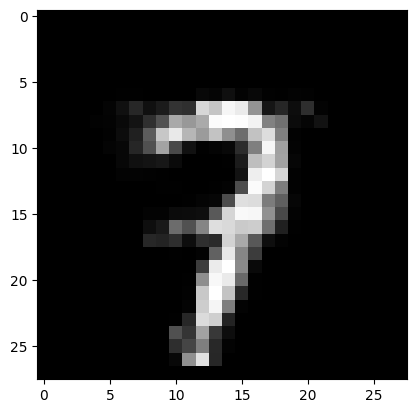

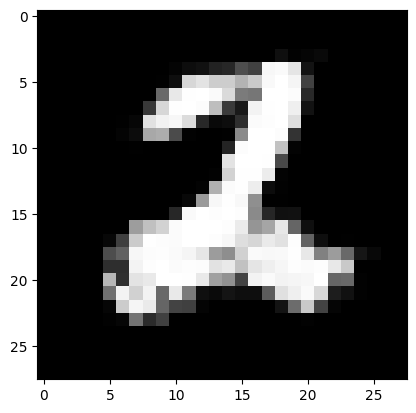

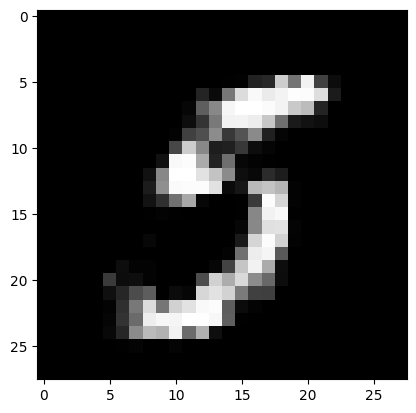

Epoch: 92050
loss_g: 0.8551889061927795 	loss_d: 1.270467758178711
Epoch: 92100
loss_g: 0.8664529323577881 	loss_d: 1.3071558475494385
Epoch: 92150
loss_g: 0.7819416522979736 	loss_d: 1.3617727756500244
Epoch: 92200
loss_g: 0.7686021327972412 	loss_d: 1.2829015254974365
Epoch: 92250
loss_g: 0.7998775839805603 	loss_d: 1.2823412418365479
Epoch: 92300
loss_g: 0.8898190259933472 	loss_d: 1.2886176109313965
Epoch: 92350
loss_g: 0.8000771403312683 	loss_d: 1.291278600692749
Epoch: 92400
loss_g: 0.8604448437690735 	loss_d: 1.2883766889572144
Epoch: 92450
loss_g: 0.7821225523948669 	loss_d: 1.2918391227722168
Epoch: 92500
loss_g: 0.796160876750946 	loss_d: 1.3207871913909912


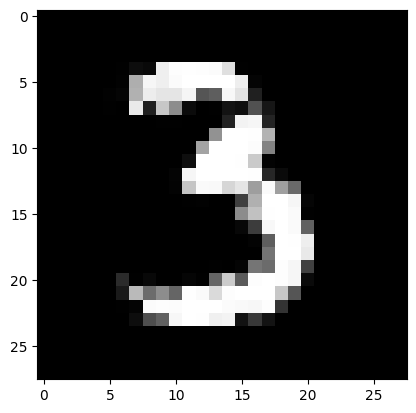

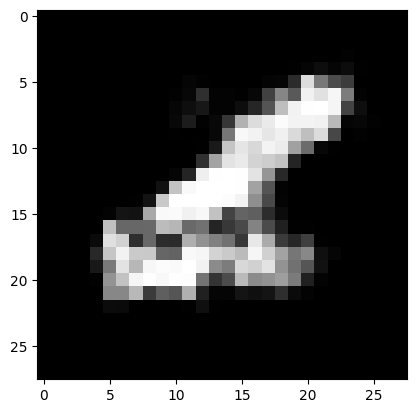

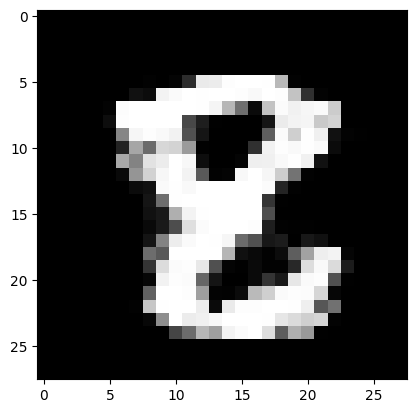

Epoch: 92550
loss_g: 0.8167102336883545 	loss_d: 1.333162784576416
Epoch: 92600
loss_g: 0.7863243818283081 	loss_d: 1.2541790008544922
Epoch: 92650
loss_g: 0.8193968534469604 	loss_d: 1.270815134048462
Epoch: 92700
loss_g: 0.8669883608818054 	loss_d: 1.2933783531188965
Epoch: 92750
loss_g: 0.8894051909446716 	loss_d: 1.3031649589538574
Epoch: 92800
loss_g: 0.7795679569244385 	loss_d: 1.2805171012878418
Epoch: 92850
loss_g: 0.766733705997467 	loss_d: 1.27392578125
Epoch: 92900
loss_g: 0.8359038829803467 	loss_d: 1.3038966655731201
Epoch: 92950
loss_g: 0.8144883513450623 	loss_d: 1.2577468156814575
Epoch: 93000
loss_g: 0.7604894042015076 	loss_d: 1.2919631004333496


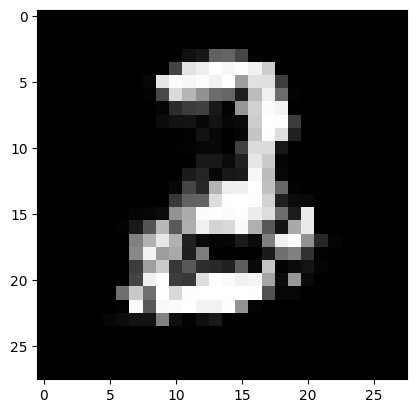

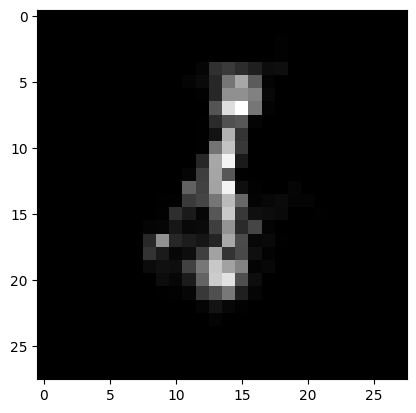

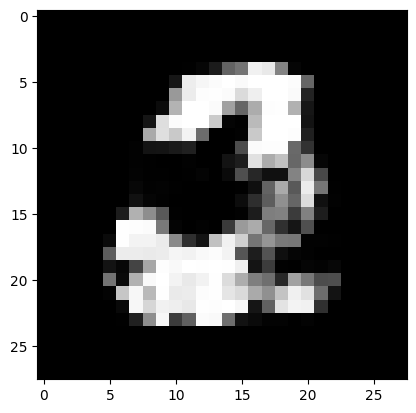

Epoch: 93050
loss_g: 0.7868613004684448 	loss_d: 1.351501703262329
Epoch: 93100
loss_g: 0.8914079070091248 	loss_d: 1.280923843383789
Epoch: 93150
loss_g: 0.8748076558113098 	loss_d: 1.2452127933502197
Epoch: 93200
loss_g: 0.8191649913787842 	loss_d: 1.3133912086486816
Epoch: 93250
loss_g: 0.8758654594421387 	loss_d: 1.3332276344299316
Epoch: 93300
loss_g: 0.8178829550743103 	loss_d: 1.2791152000427246
Epoch: 93350
loss_g: 0.7987893223762512 	loss_d: 1.2403323650360107
Epoch: 93400
loss_g: 0.7849059700965881 	loss_d: 1.2724616527557373
Epoch: 93450
loss_g: 0.8281660079956055 	loss_d: 1.245462417602539
Epoch: 93500
loss_g: 0.764218270778656 	loss_d: 1.290347933769226


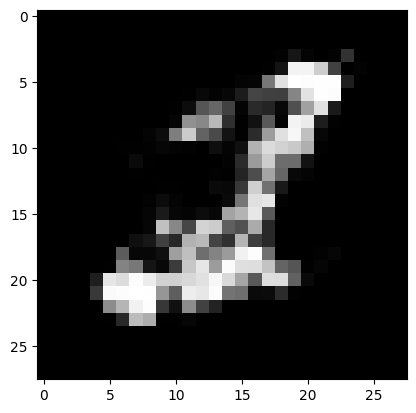

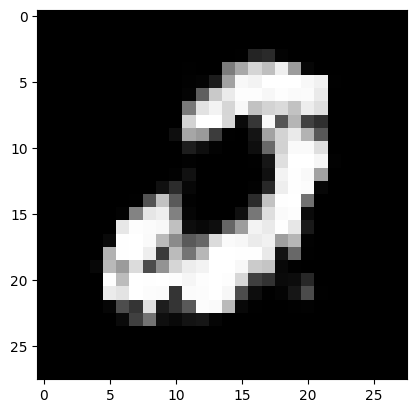

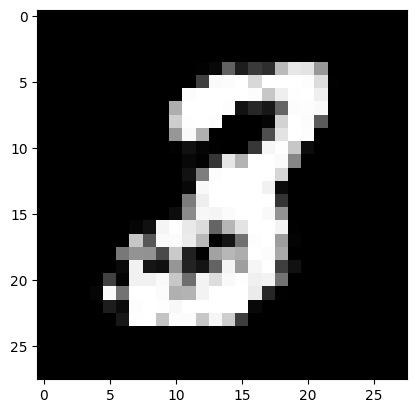

Epoch: 93550
loss_g: 0.8402132987976074 	loss_d: 1.3301446437835693
Epoch: 93600
loss_g: 0.8394263982772827 	loss_d: 1.2408047914505005
Epoch: 93650
loss_g: 0.784638524055481 	loss_d: 1.3107109069824219
Epoch: 93700
loss_g: 0.7837382555007935 	loss_d: 1.2291339635849
Epoch: 93750
loss_g: 0.8579254746437073 	loss_d: 1.2444621324539185
Epoch: 93800
loss_g: 0.7904068827629089 	loss_d: 1.2995225191116333
Epoch: 93850
loss_g: 0.7887229919433594 	loss_d: 1.3056740760803223
Epoch: 93900
loss_g: 0.7783216834068298 	loss_d: 1.2864469289779663
Epoch: 93950
loss_g: 0.88608318567276 	loss_d: 1.3399759531021118
Epoch: 94000
loss_g: 0.7994978427886963 	loss_d: 1.341599941253662


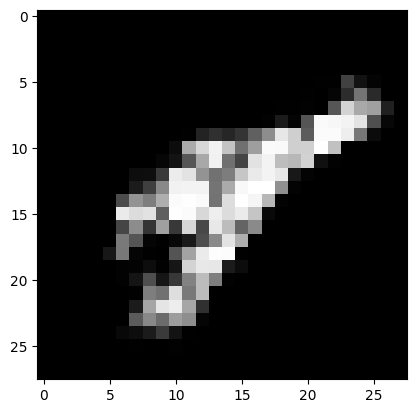

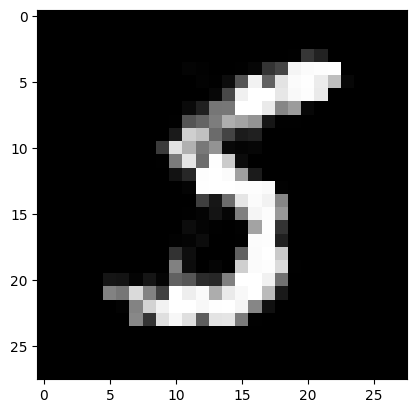

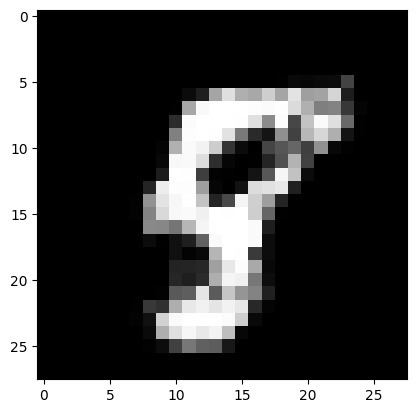

Epoch: 94050
loss_g: 0.7913165092468262 	loss_d: 1.2762153148651123
Epoch: 94100
loss_g: 0.8423059582710266 	loss_d: 1.2532305717468262
Epoch: 94150
loss_g: 0.8229008316993713 	loss_d: 1.3111729621887207
Epoch: 94200
loss_g: 0.8682209849357605 	loss_d: 1.2653920650482178
Epoch: 94250
loss_g: 0.8693140745162964 	loss_d: 1.2669012546539307
Epoch: 94300
loss_g: 0.825901985168457 	loss_d: 1.3298068046569824
Epoch: 94350
loss_g: 0.7683279514312744 	loss_d: 1.3027287721633911
Epoch: 94400
loss_g: 0.8528982996940613 	loss_d: 1.2245700359344482
Epoch: 94450
loss_g: 0.8308351039886475 	loss_d: 1.2901771068572998
Epoch: 94500
loss_g: 0.8129913210868835 	loss_d: 1.3037526607513428


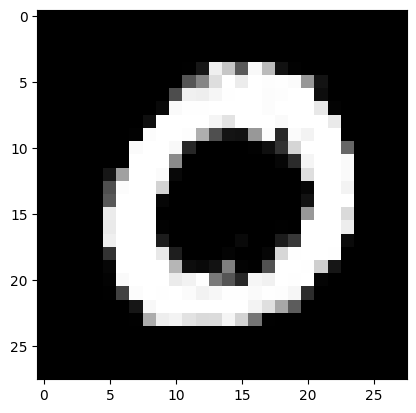

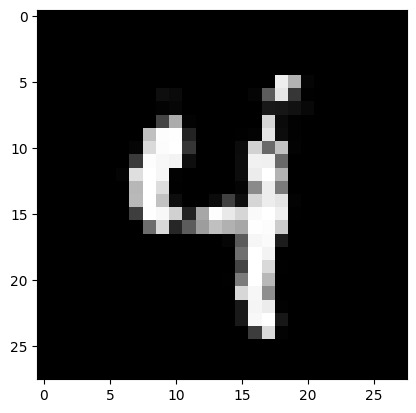

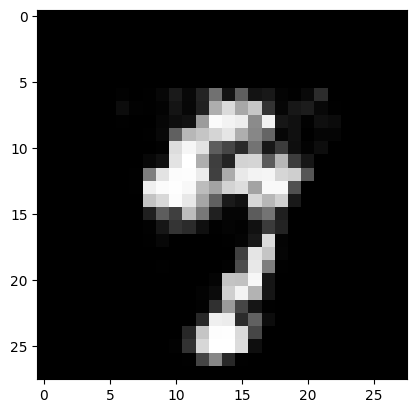

Epoch: 94550
loss_g: 0.8426858186721802 	loss_d: 1.3130712509155273
Epoch: 94600
loss_g: 0.771769642829895 	loss_d: 1.2580751180648804
Epoch: 94650
loss_g: 0.8208668828010559 	loss_d: 1.2032015323638916
Epoch: 94700
loss_g: 0.8790998458862305 	loss_d: 1.301193118095398
Epoch: 94750
loss_g: 0.7826069593429565 	loss_d: 1.2679682970046997
Epoch: 94800
loss_g: 0.8154616355895996 	loss_d: 1.317855715751648
Epoch: 94850
loss_g: 0.8795844316482544 	loss_d: 1.363019585609436
Epoch: 94900
loss_g: 0.871318519115448 	loss_d: 1.3153102397918701
Epoch: 94950
loss_g: 0.8159090876579285 	loss_d: 1.3331761360168457
Epoch: 95000
loss_g: 0.801493227481842 	loss_d: 1.2718510627746582


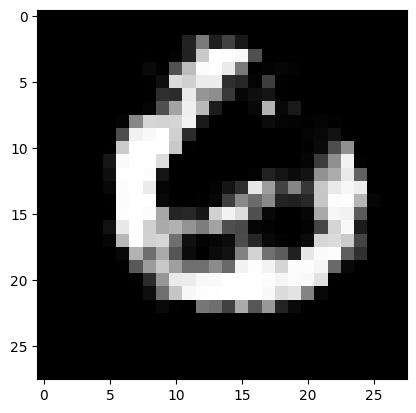

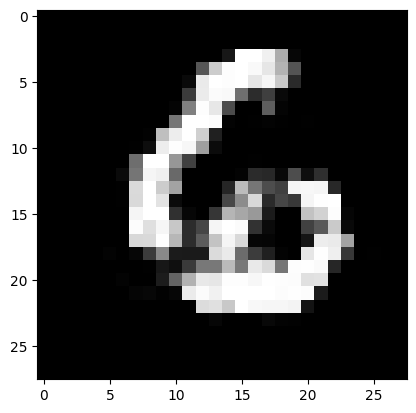

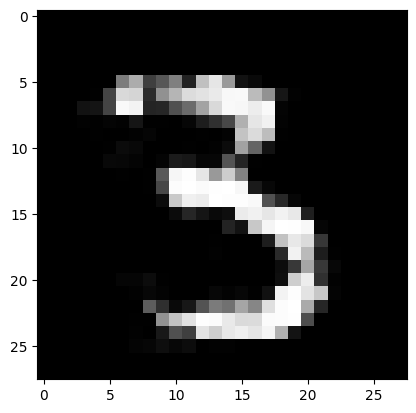

Epoch: 95050
loss_g: 0.8069053292274475 	loss_d: 1.3650436401367188
Epoch: 95100
loss_g: 0.8005177974700928 	loss_d: 1.2726428508758545
Epoch: 95150
loss_g: 0.7785389423370361 	loss_d: 1.223751425743103
Epoch: 95200
loss_g: 0.7135642766952515 	loss_d: 1.2859678268432617
Epoch: 95250
loss_g: 0.7844470143318176 	loss_d: 1.307919979095459
Epoch: 95300
loss_g: 0.8832621574401855 	loss_d: 1.2980304956436157
Epoch: 95350
loss_g: 0.8695155382156372 	loss_d: 1.2739486694335938
Epoch: 95400
loss_g: 0.8179605007171631 	loss_d: 1.2802867889404297
Epoch: 95450
loss_g: 0.809962272644043 	loss_d: 1.3133184909820557
Epoch: 95500
loss_g: 0.8438042402267456 	loss_d: 1.2643020153045654


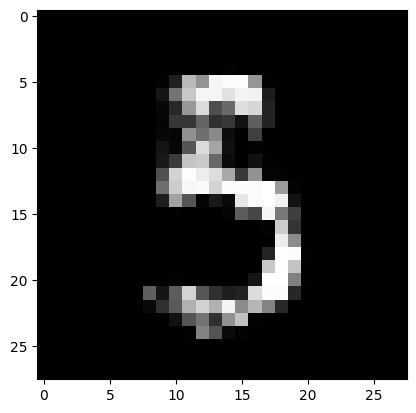

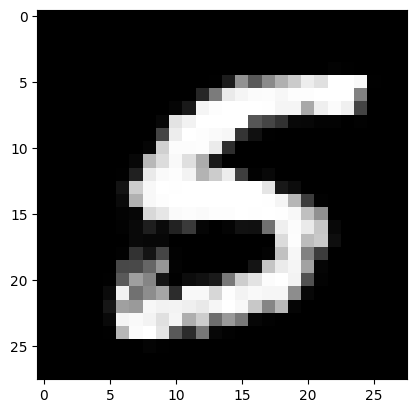

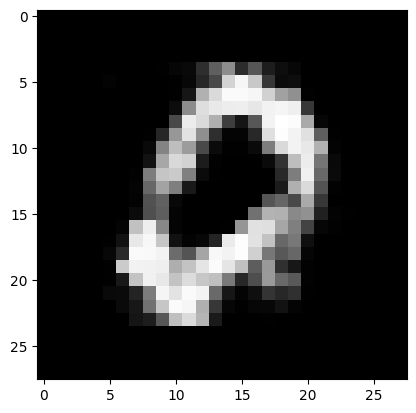

Epoch: 95550
loss_g: 0.8164774179458618 	loss_d: 1.3727562427520752
Epoch: 95600
loss_g: 0.9011147022247314 	loss_d: 1.329679250717163
Epoch: 95650
loss_g: 0.8594993948936462 	loss_d: 1.2723543643951416
Epoch: 95700
loss_g: 0.8595016002655029 	loss_d: 1.3049927949905396
Epoch: 95750
loss_g: 0.8148414492607117 	loss_d: 1.251352071762085
Epoch: 95800
loss_g: 0.9043835997581482 	loss_d: 1.2688277959823608
Epoch: 95850
loss_g: 0.9125141501426697 	loss_d: 1.220308780670166
Epoch: 95900
loss_g: 0.7869271039962769 	loss_d: 1.316631555557251
Epoch: 95950
loss_g: 0.8089625835418701 	loss_d: 1.2282425165176392
Epoch: 96000
loss_g: 0.8206886053085327 	loss_d: 1.2957398891448975


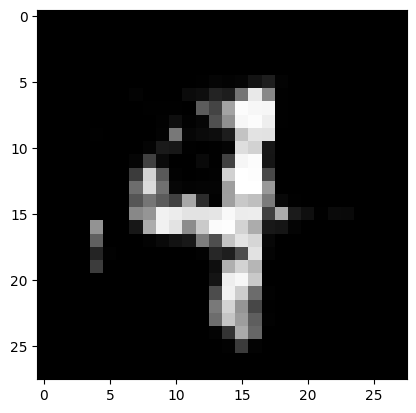

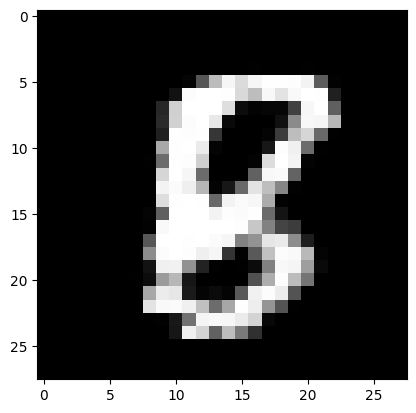

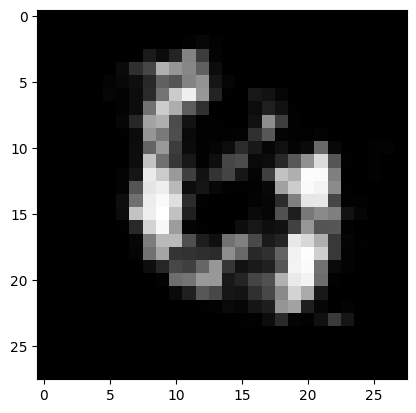

Epoch: 96050
loss_g: 0.7808299660682678 	loss_d: 1.3681716918945312
Epoch: 96100
loss_g: 0.8020715713500977 	loss_d: 1.3585734367370605
Epoch: 96150
loss_g: 0.8485177159309387 	loss_d: 1.247091293334961
Epoch: 96200
loss_g: 0.8432013988494873 	loss_d: 1.3168702125549316
Epoch: 96250
loss_g: 0.843889057636261 	loss_d: 1.3724634647369385
Epoch: 96300
loss_g: 0.8480544686317444 	loss_d: 1.273370623588562
Epoch: 96350
loss_g: 0.7925543189048767 	loss_d: 1.4052250385284424
Epoch: 96400
loss_g: 0.7791908383369446 	loss_d: 1.2582796812057495
Epoch: 96450
loss_g: 0.8935540318489075 	loss_d: 1.2437026500701904
Epoch: 96500
loss_g: 0.8506221771240234 	loss_d: 1.2853184938430786


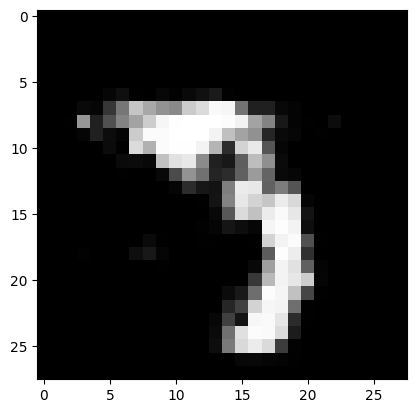

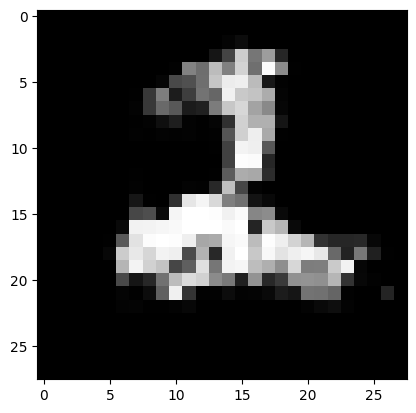

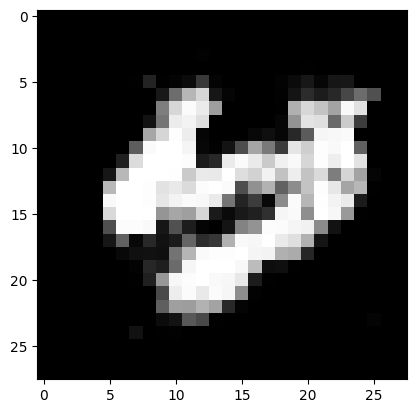

Epoch: 96550
loss_g: 0.8778924942016602 	loss_d: 1.2071082592010498
Epoch: 96600
loss_g: 0.7997028827667236 	loss_d: 1.3277912139892578
Epoch: 96650
loss_g: 0.874620258808136 	loss_d: 1.356369972229004
Epoch: 96700
loss_g: 0.7975495457649231 	loss_d: 1.298302173614502
Epoch: 96750
loss_g: 0.8144993185997009 	loss_d: 1.2948331832885742
Epoch: 96800
loss_g: 0.8148675560951233 	loss_d: 1.2647050619125366
Epoch: 96850
loss_g: 0.8480633497238159 	loss_d: 1.3092718124389648
Epoch: 96900
loss_g: 0.8178673982620239 	loss_d: 1.3208341598510742
Epoch: 96950
loss_g: 0.8088518381118774 	loss_d: 1.3153729438781738
Epoch: 97000
loss_g: 0.8563772439956665 	loss_d: 1.303916096687317


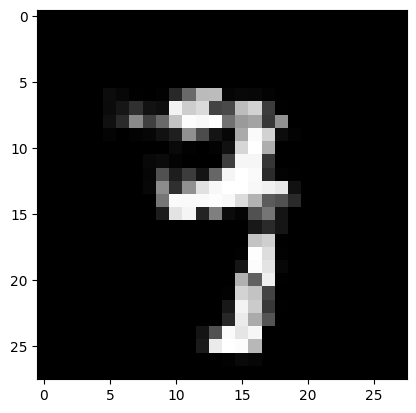

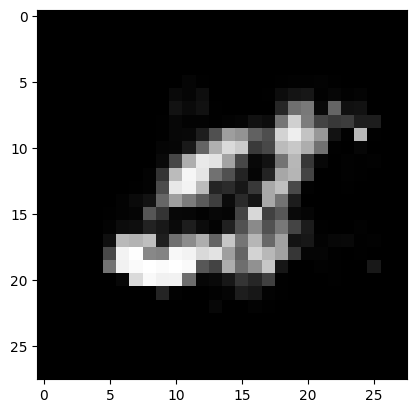

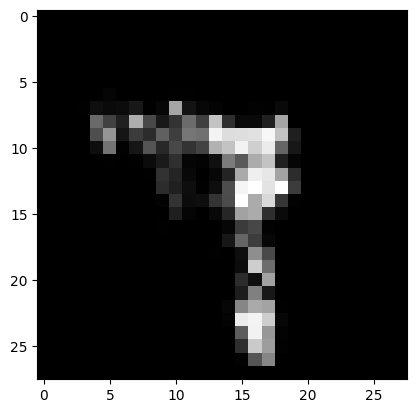

Epoch: 97050
loss_g: 0.8158093094825745 	loss_d: 1.3124396800994873
Epoch: 97100
loss_g: 0.880174994468689 	loss_d: 1.2451887130737305
Epoch: 97150
loss_g: 0.8356685638427734 	loss_d: 1.3359668254852295
Epoch: 97200
loss_g: 0.8495803475379944 	loss_d: 1.3083717823028564
Epoch: 97250
loss_g: 0.864264965057373 	loss_d: 1.3067338466644287
Epoch: 97300
loss_g: 0.9003679752349854 	loss_d: 1.3111295700073242
Epoch: 97350
loss_g: 0.7902247309684753 	loss_d: 1.2985265254974365
Epoch: 97400
loss_g: 0.8204872012138367 	loss_d: 1.323673129081726
Epoch: 97450
loss_g: 0.8968656659126282 	loss_d: 1.221898078918457
Epoch: 97500
loss_g: 0.8016799688339233 	loss_d: 1.2486114501953125


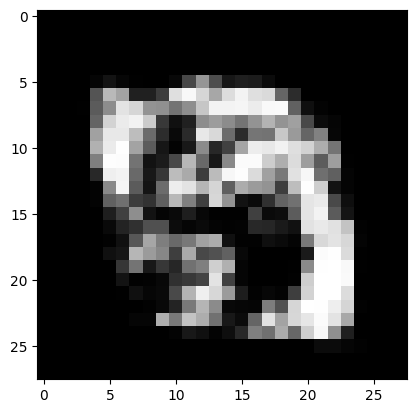

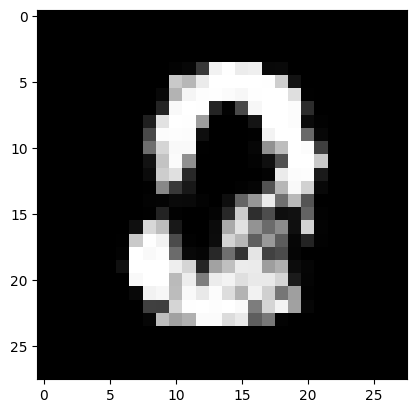

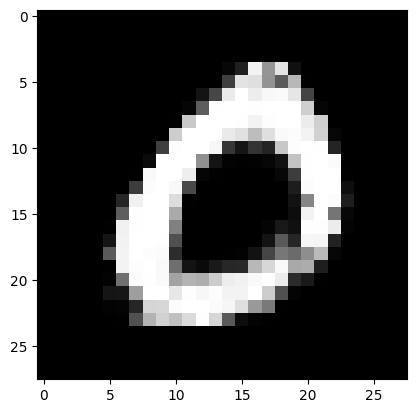

Epoch: 97550
loss_g: 0.8263185620307922 	loss_d: 1.322404384613037
Epoch: 97600
loss_g: 0.8304054737091064 	loss_d: 1.2656141519546509
Epoch: 97650
loss_g: 0.7717924118041992 	loss_d: 1.3054745197296143
Epoch: 97700
loss_g: 0.803043782711029 	loss_d: 1.3318724632263184
Epoch: 97750
loss_g: 0.8673210740089417 	loss_d: 1.313983678817749
Epoch: 97800
loss_g: 0.826191246509552 	loss_d: 1.3553245067596436
Epoch: 97850
loss_g: 0.7995373606681824 	loss_d: 1.2530131340026855
Epoch: 97900
loss_g: 0.9027283787727356 	loss_d: 1.1974375247955322
Epoch: 97950
loss_g: 0.8183809518814087 	loss_d: 1.2893528938293457
Epoch: 98000
loss_g: 0.8424980044364929 	loss_d: 1.3187570571899414


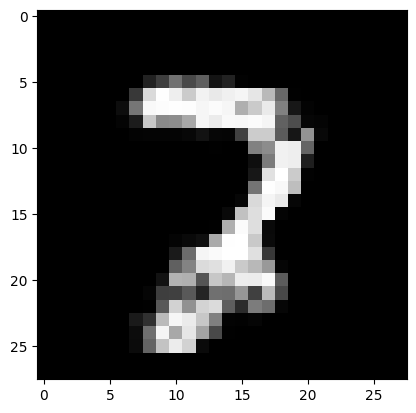

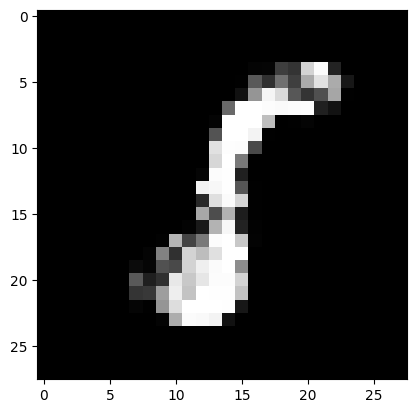

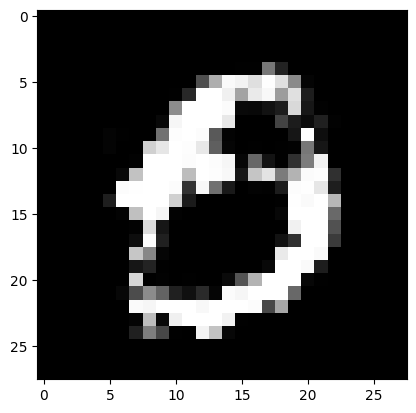

Epoch: 98050
loss_g: 0.884905993938446 	loss_d: 1.2262871265411377
Epoch: 98100
loss_g: 0.8517580032348633 	loss_d: 1.2731534242630005
Epoch: 98150
loss_g: 0.8137893676757812 	loss_d: 1.3292477130889893
Epoch: 98200
loss_g: 0.7619917392730713 	loss_d: 1.3191320896148682
Epoch: 98250
loss_g: 0.8229040503501892 	loss_d: 1.2914875745773315
Epoch: 98300
loss_g: 0.820248544216156 	loss_d: 1.2945454120635986
Epoch: 98350
loss_g: 0.7932769656181335 	loss_d: 1.2801182270050049
Epoch: 98400
loss_g: 0.7905089259147644 	loss_d: 1.3065104484558105
Epoch: 98450
loss_g: 0.8211450576782227 	loss_d: 1.287214994430542
Epoch: 98500
loss_g: 0.848473846912384 	loss_d: 1.3726191520690918


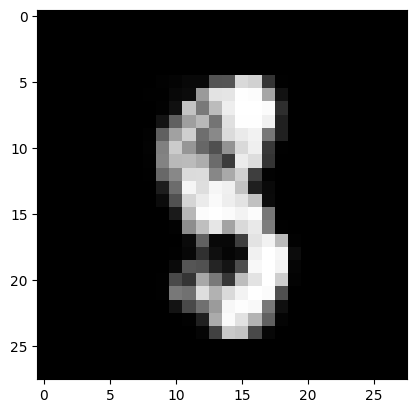

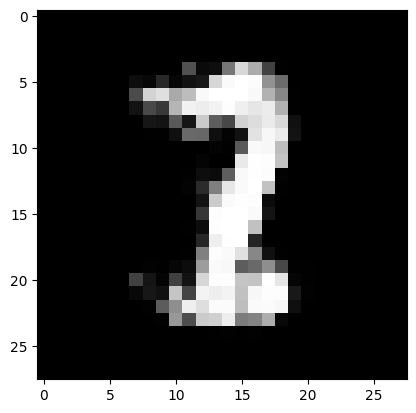

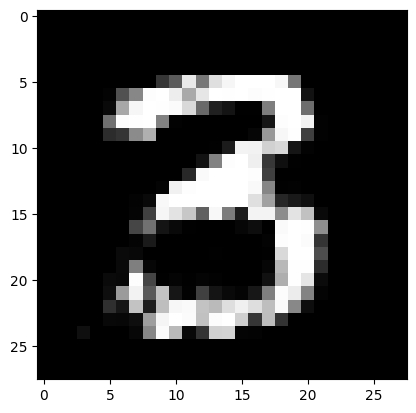

Epoch: 98550
loss_g: 0.933095395565033 	loss_d: 1.1787669658660889
Epoch: 98600
loss_g: 0.8505751490592957 	loss_d: 1.2326741218566895
Epoch: 98650
loss_g: 0.8399510979652405 	loss_d: 1.3398244380950928
Epoch: 98700
loss_g: 0.8685807585716248 	loss_d: 1.2988317012786865
Epoch: 98750
loss_g: 0.9081374406814575 	loss_d: 1.2851917743682861
Epoch: 98800
loss_g: 0.8120394945144653 	loss_d: 1.2896251678466797
Epoch: 98850
loss_g: 0.8011218905448914 	loss_d: 1.2720892429351807
Epoch: 98900
loss_g: 0.9190434217453003 	loss_d: 1.2428081035614014
Epoch: 98950
loss_g: 0.8213114142417908 	loss_d: 1.230506181716919
Epoch: 99000
loss_g: 0.8007099628448486 	loss_d: 1.3314483165740967


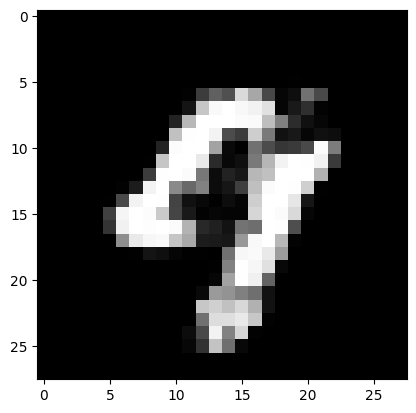

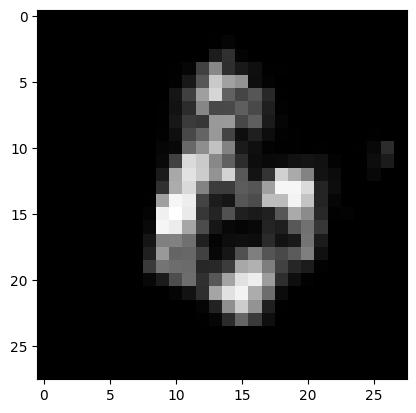

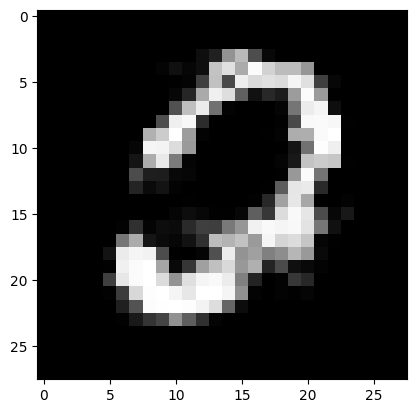

Epoch: 99050
loss_g: 0.8433350920677185 	loss_d: 1.2386716604232788
Epoch: 99100
loss_g: 0.7816946506500244 	loss_d: 1.245236873626709
Epoch: 99150
loss_g: 0.7705324292182922 	loss_d: 1.2681469917297363
Epoch: 99200
loss_g: 0.8301536440849304 	loss_d: 1.276146650314331
Epoch: 99250
loss_g: 0.7658834457397461 	loss_d: 1.271132230758667
Epoch: 99300
loss_g: 0.828520655632019 	loss_d: 1.3301050662994385
Epoch: 99350
loss_g: 0.834463357925415 	loss_d: 1.2258003950119019
Epoch: 99400
loss_g: 0.8367408514022827 	loss_d: 1.2748541831970215
Epoch: 99450
loss_g: 0.868538498878479 	loss_d: 1.2896645069122314
Epoch: 99500
loss_g: 0.8655494451522827 	loss_d: 1.2965891361236572


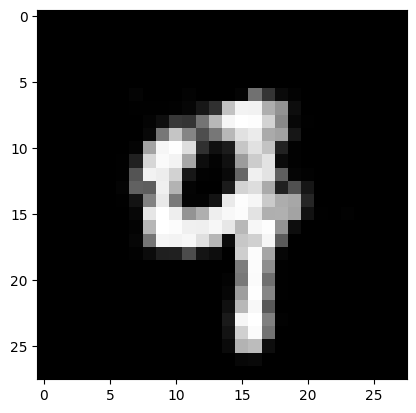

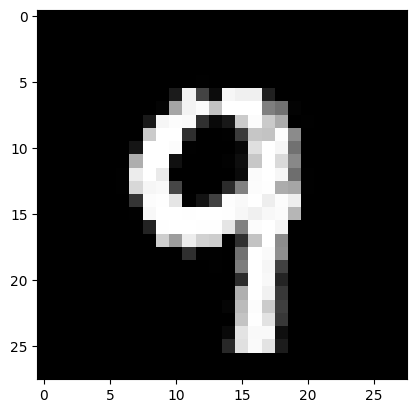

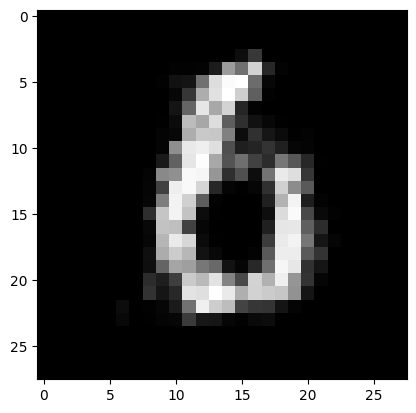

Epoch: 99550
loss_g: 0.89857417345047 	loss_d: 1.363222360610962
Epoch: 99600
loss_g: 0.8591764569282532 	loss_d: 1.2582783699035645
Epoch: 99650
loss_g: 0.8085586428642273 	loss_d: 1.190528154373169
Epoch: 99700
loss_g: 0.8631678819656372 	loss_d: 1.3062032461166382
Epoch: 99750
loss_g: 0.8167759776115417 	loss_d: 1.3168107271194458
Epoch: 99800
loss_g: 0.8593458533287048 	loss_d: 1.2676423788070679
Epoch: 99850
loss_g: 0.8306697010993958 	loss_d: 1.2790534496307373
Epoch: 99900
loss_g: 0.7790318131446838 	loss_d: 1.2449183464050293
Epoch: 99950
loss_g: 0.7923168540000916 	loss_d: 1.2628982067108154


In [5]:
lr = 0.0002
k = 1
epochs = 100000

generator = Generator().to(device)
disciminator = Discriminator().to(device)

optimizer_gen = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_dis = torch.optim.Adam(disciminator.parameters(), lr=lr)

criterion_gen = torch.nn.BCEWithLogitsLoss()
criterion_dis = torch.nn.BCEWithLogitsLoss()

train_models(disciminator, criterion_dis, optimizer_dis, generator, criterion_gen, optimizer_gen, epochs, train_loader, k, batch_size)

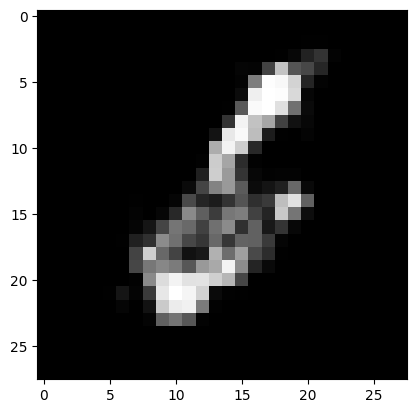

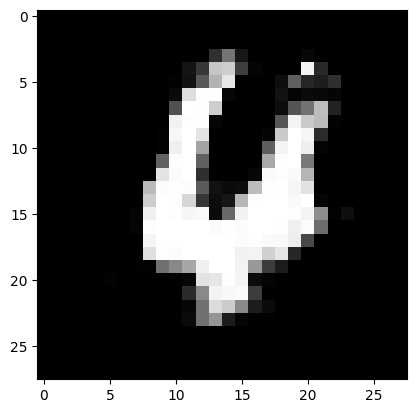

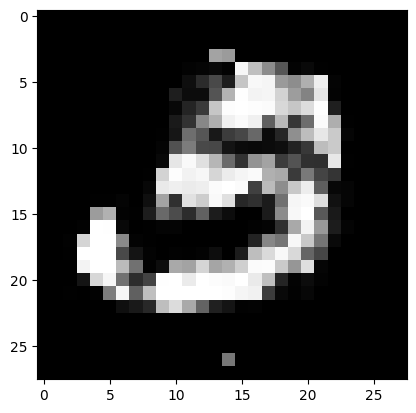

In [6]:
#Result
noise = torch.randn(5,100)
disp = generator(noise.to(device))
plot_digit(torch.reshape(disp[0,:],(28,28)).detach().cpu())
plot_digit(torch.reshape(disp[1,:],(28,28)).detach().cpu())
plot_digit(torch.reshape(disp[2,:],(28,28)).detach().cpu())